# Parameters
in this cell the used variables can be changed 

height and width correspond to the dimensions of the Workspace, in which the Topology Optimisation is going to be performed

log_dir is the direction where the current best Model will be saved to during training

ts is the amount of timesteps the model will be trained for




In [19]:
import os
import time

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import autograd.numpy as anp
import scipy

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor


In [20]:
height = 30
width = 15
log_dir = "log/"
ts = 5e6

density = 1e-4
constraint_thresh = 0.7

filter_width = 1
penal = 3.0
young_min = 1e-9
young = 1
poisson = 0.3

number_subprocesses = 8

normals = np.zeros((height + 1, width + 1, 2))
x = 0
y = 1
normals[0, 0, x] = 1
normals[0, 0, y] = 1
normals[0, -1, x] = 1
normals[0, -1, y] = 1



forces = np.zeros((height + 1, width + 1, 2))
forces[-1, -1, y] = -1
forces = forces.ravel()



width = normals.shape[0] - 1
height = normals.shape[1] - 1
fixdofs = np.flatnonzero(normals.ravel())
alldofs = np.arange(2 * (width + 1) * (height + 1))
freedofs = np.sort(list(set(alldofs) - set(fixdofs)))

print ("fixdofs\n" + str(fixdofs))
print ("freedofs\n" + str(freedofs))




path_calculix = "E:/Bachelorarbeit/CalculiX/bConverged/CalculiX/ccx"



number_of_nodes = height * width

fixdofs
[ 0  1 30 31]
freedofs
[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242

Here the reward for each state of the workspace is the compliance
which should be minimized or above a certain threshold



In [21]:
def objective(x, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=penal, e_min=young_min, e_0=young)
    x_phys = physical_density(x, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(young, poisson)  # stiffness matrix
    u      = displace(x_phys, ke, forces, freedofs, fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [22]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()

    return scipy.sparse.linalg.splu(a).solve



# @autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp


def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])


def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)


    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]






def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x,volume_contraint=False, use_filter=True):
    x = 1 * x.reshape(height, width)  # reshape from 1D to 2D
    return gaussian_filter(x, filter_width) if use_filter else x  # maybe filter

def mean_density(x, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, volume_contraint, use_filter)) / anp.mean(1)

# @autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')






def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm


In [23]:
# TODO write the function to get the reward
# It should return the compliance of the structure
# The compliance is the sum of the forces applied to the structure
# multiplied by the displacement of the nodes
# The goal of the Optimization will be to minimize the compliance or keep it below a certain threshold


def rewardFunction(state):
    reshape = lambda state: state.reshape(height, width)
    objective_fn = lambda state: objective(reshape(state))
    
    value = objective_fn(state)
    
    return (1/value)**0.5




def constraintFunction(state):
    reshape = lambda state: state.reshape(height, width)
    constraint = lambda params: mean_density(reshape(params)) 
    const = constraint(state)
    return const

In [24]:
class TopOptEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self):
        # The constructor of the environment

        super().__init__()
        self.design_space = anp.ones((height, width))
        self.bound_nodes = np.zeros((height, width))
        self.force_nodes = np.zeros((height, width))
        self.density_matrix = self.design_space * density
        

        self.action_space = gym.spaces.Discrete(number_of_nodes)
        self.observation_space = gym.spaces.Box(low=0, 
                                                high=1, 
                                                shape=(height, width), 
                                                dtype=np.float64)

        # A Dictionary is used to map each coordinate tuple of the designspace
        # to a singular distinct integer for use in the
        self._actions_to_coordinates = {}  
        k=0
        for i in range(height):
            for j in range(width):
                self._actions_to_coordinates[k] = (i,j)
                k += 1


        
        self.reward = 0
        self.step_count = 0

        self.reset()

    def step(self, action):
        #
        # TODO finisch the step function for the environment	
        # we need to add the reward function and the termination condition
        #
        #
        # action is the coordinate of the node that is going to be changed
        # action is a number between 0 and number_of_nodes

        self.step_count += 1
        terminated = False

        #check if the selected Node is either bound or force node
        print(self._actions_to_coordinates[action])
        if self.bound_nodes[self._actions_to_coordinates[action]] == 1:
            self.reward = -1
            return self.design_space, self.reward, terminated, False, self.getInfo()
        
        if self.force_nodes[self._actions_to_coordinates[action]] == 1:
            self.reward = -1
            return self.design_space, self.reward, terminated, False, self.getInfo()
        
        if self.design_space[self._actions_to_coordinates[action]] == 0:
            self.reward = -1
            terminated = True
            return self.design_space, self.reward, terminated, False, self.getInfo()

        # exectute an action and get the Reward
        self.design_space[self._actions_to_coordinates[action]] = 0
        self.reward += rewardFunction(self.design_space)
        self.constraint = constraintFunction(self.design_space)
        self.reward += np.size(self.design_space)-np.count_nonzero(self.design_space)*np.size(self.design_space)
        # 
        if self.constraint > constraint_thresh:
            self.reward -= 1

        
        # if self.step_count > number_of_nodes:
        #     terminated = True

        



        return self.design_space, self.reward, terminated, False, self.getInfo()
    
    
    def reset(self, seed=None):
        # Reset the environment
        # This function returns the initial state of the environment
        # The initial state should be a 2D array of size (height, width)
        #


        super().reset(seed=seed)
        self.design_space = anp.ones((height, width))
        self.density_matrix = self.design_space * density 

        self.constraint = constraintFunction(self.design_space)
        self.reward = 0
        self.step_count = 0

        # initialize the bound and force nodes
        self.bound_nodes = np.zeros((height, width))
        self.force_nodes = np.zeros((height, width))
        
        # We chose arbitrary but senseful Values here 
        # So this Enviroment wil train a Model, only fit to solve the problem
        # that gets specified here
        self.bound_nodes[:,0] = 1
        self.force_nodes[-1,-1] = 1

        return self.design_space, self.getInfo()
    

    def render(self, mode="human"):
        # This function is used to render the environment
        # This function is not necessary for the optimization
        print("current Design")
        fig, ax = plt.subplots()
        ax.imshow(self.design_space)
        plt.show()
    
    def getInfo(self):
        # This function returns the information about the environment
        # This function is used to monitor the environment
        # The information should be a dictionary
        # The dictionary should contain the following keys:
        # - step_count: the number of steps that have been executed
        # - current Reward: the reward of the current state
        # - design_space: the current state of the environment
        return {"step_count": self.step_count, 
                "current_reward": self.reward,
                "design_space": self.design_space}
    
    def debug(self):
        print(self.design_space)

In [25]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)s
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                vecenv_render(env)
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
                    

        return True

In [26]:

env = SubprocVecEnv([lambda: TopOptEnv() for _ in range(number_subprocesses)]) #### trying to multiprocess

# Logs will be saved in log_dir/monitor.csv
env = VecMonitor(env, log_dir)
#check_env(env, warn=True)
#env = Monitor(env, log_dir)
#check_env(env, warn=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)






In [27]:

def vecenv_render(env):
    plt.close()
    design_spaces = env.env_method("getInfo")
    fig, axs = plt.subplots(1,number_subprocesses)
    fig.set_size_inches(20, 10)
    for i in range(number_subprocesses):
        axs[i].imshow(design_spaces[i]["design_space"])
        axs[i].set_title(i+1)
    plt.show()    




Num timesteps: 8000
Best mean reward: -inf - Last mean reward per episode: -50846700.04


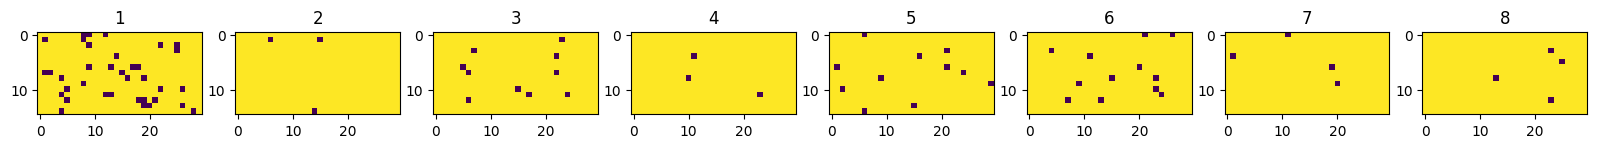

Saving new best model to log/best_model.zip
Num timesteps: 16000
Best mean reward: -50846700.04 - Last mean reward per episode: -50269064.67


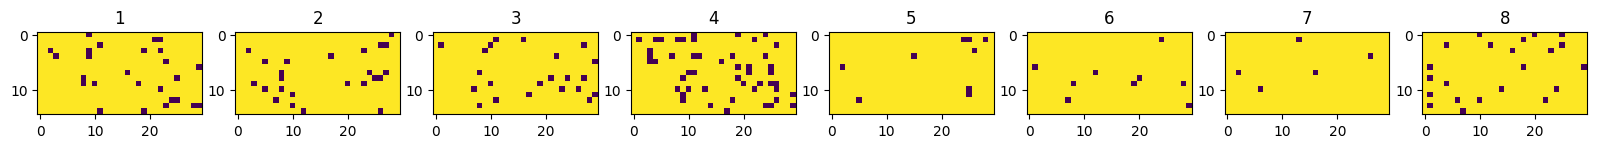

Saving new best model to log/best_model.zip
Num timesteps: 24000
Best mean reward: -50269064.67 - Last mean reward per episode: -57253339.95


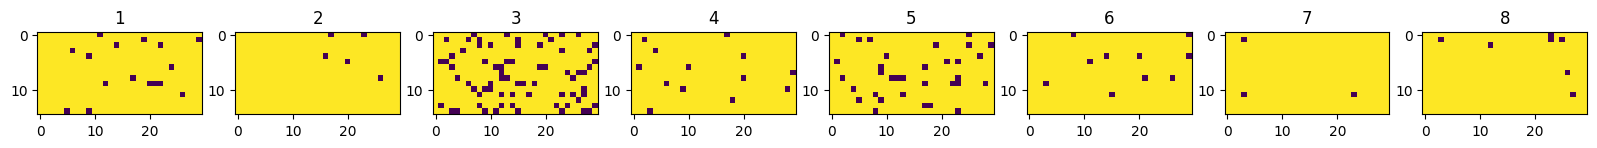

Num timesteps: 32000
Best mean reward: -50269064.67 - Last mean reward per episode: -59358180.58


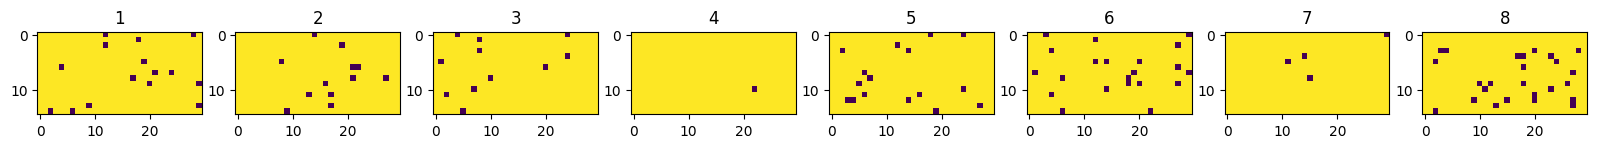

Num timesteps: 40000
Best mean reward: -50269064.67 - Last mean reward per episode: -57796553.77


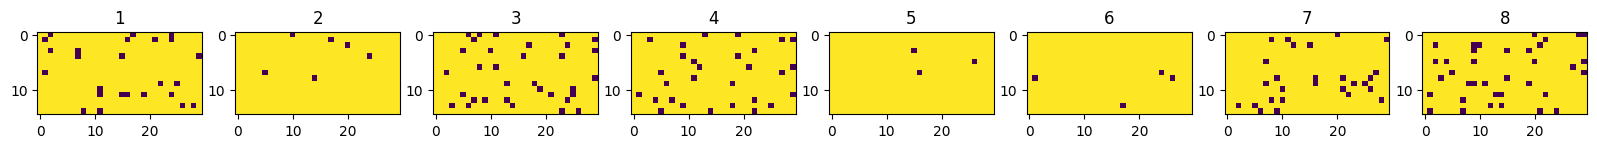

Num timesteps: 48000
Best mean reward: -50269064.67 - Last mean reward per episode: -54235819.04


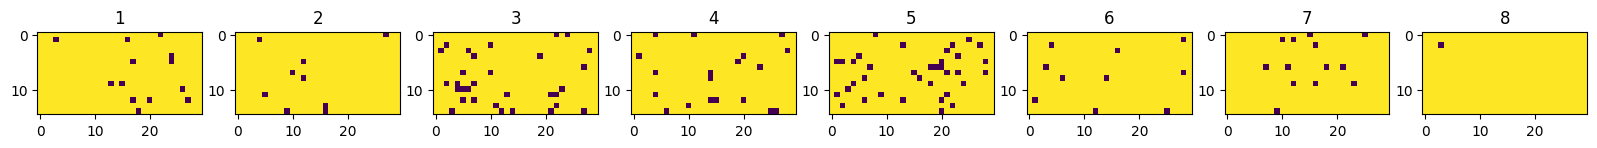

Num timesteps: 56000
Best mean reward: -50269064.67 - Last mean reward per episode: -63203562.90


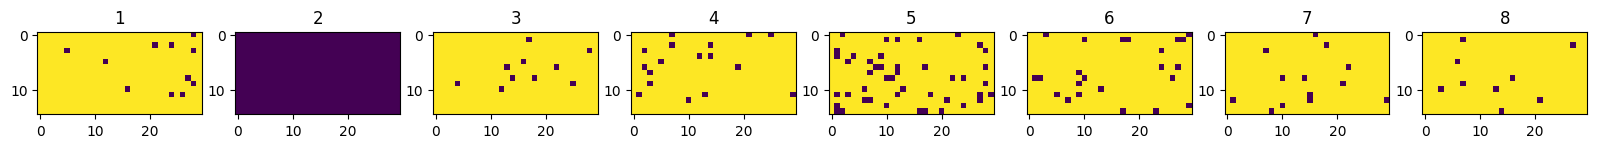

Num timesteps: 64000
Best mean reward: -50269064.67 - Last mean reward per episode: -57398297.73


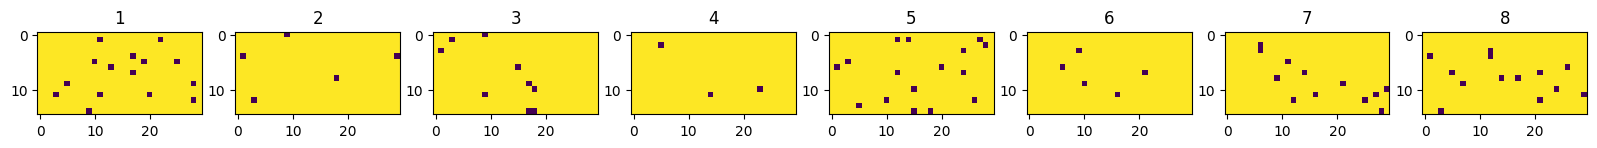

Num timesteps: 72000
Best mean reward: -50269064.67 - Last mean reward per episode: -68966567.77


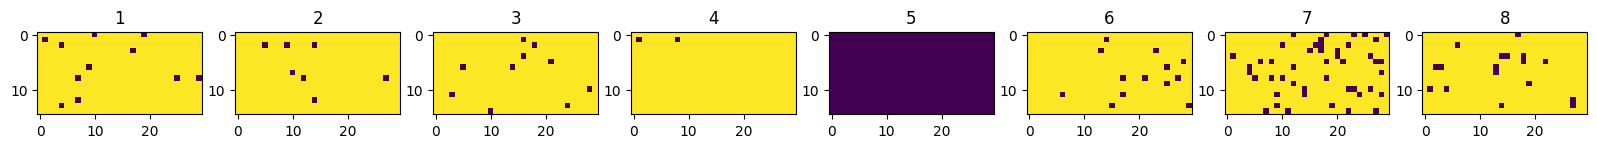

Num timesteps: 80000
Best mean reward: -50269064.67 - Last mean reward per episode: -50095598.97


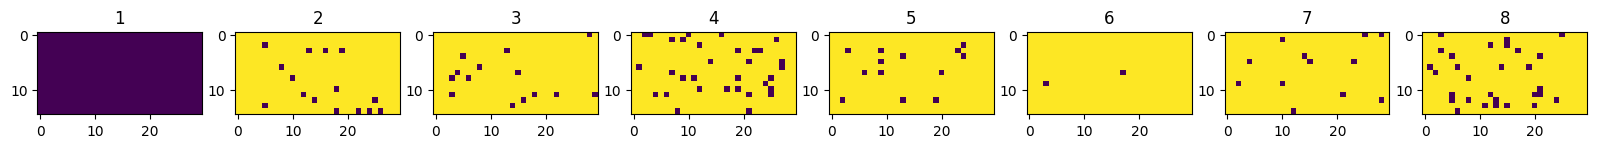

Saving new best model to log/best_model.zip
Num timesteps: 88000
Best mean reward: -50095598.97 - Last mean reward per episode: -58430843.74


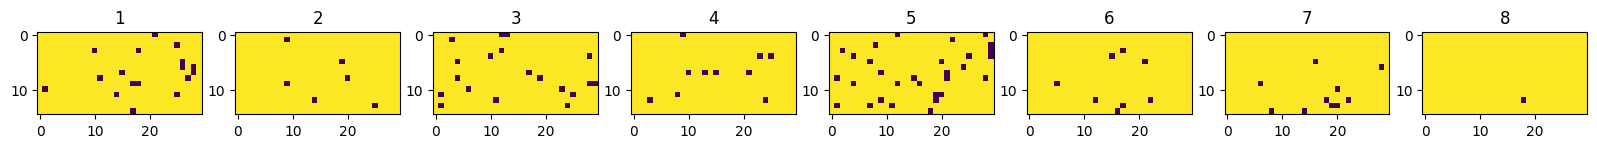

Num timesteps: 96000
Best mean reward: -50095598.97 - Last mean reward per episode: -56432359.07


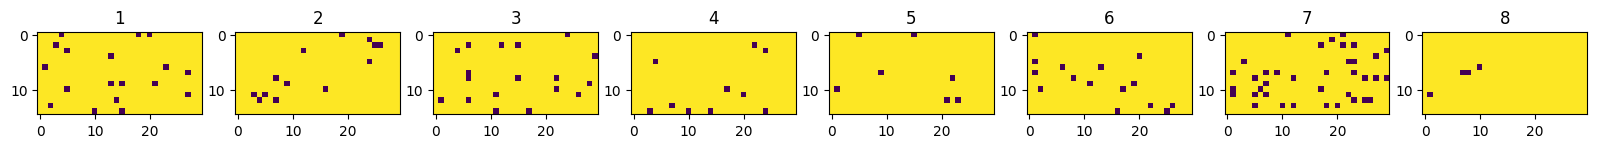

Num timesteps: 104000
Best mean reward: -50095598.97 - Last mean reward per episode: -59023663.09


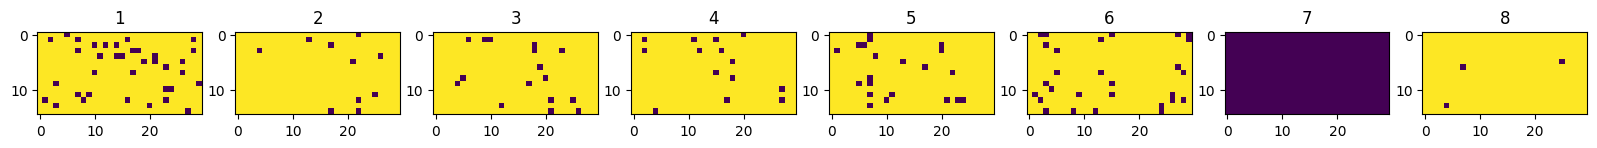

Num timesteps: 112000
Best mean reward: -50095598.97 - Last mean reward per episode: -57090344.22


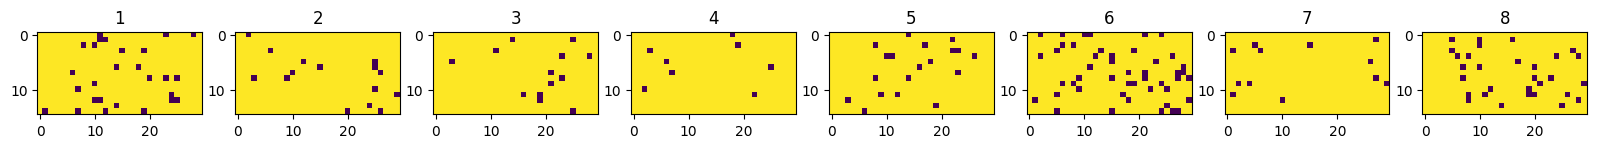

Num timesteps: 120000
Best mean reward: -50095598.97 - Last mean reward per episode: -62358280.80


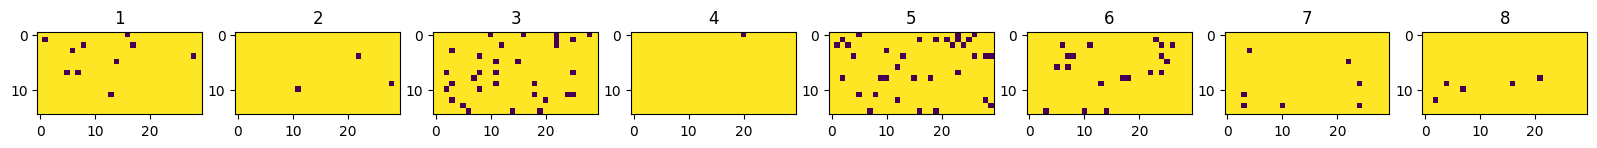

Num timesteps: 128000
Best mean reward: -50095598.97 - Last mean reward per episode: -54333013.16


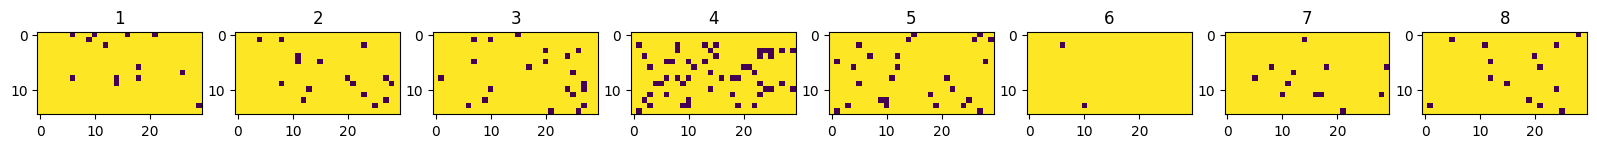

Num timesteps: 136000
Best mean reward: -50095598.97 - Last mean reward per episode: -52961648.19


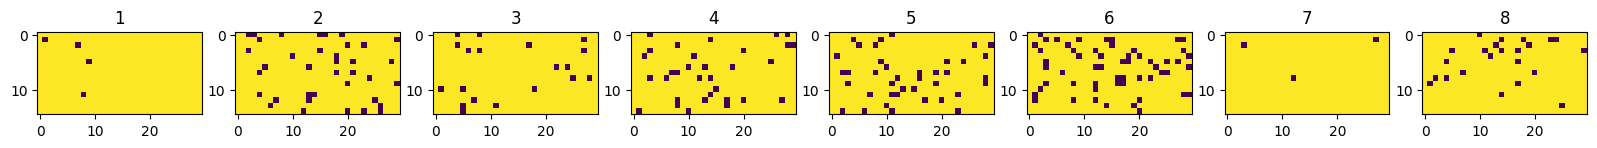

Num timesteps: 144000
Best mean reward: -50095598.97 - Last mean reward per episode: -57071842.44


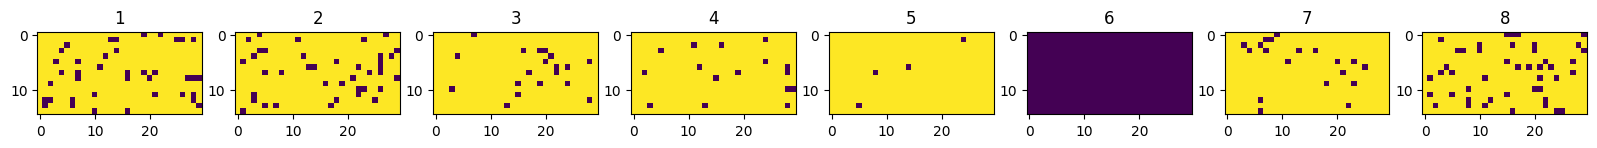

Num timesteps: 152000
Best mean reward: -50095598.97 - Last mean reward per episode: -57751627.34


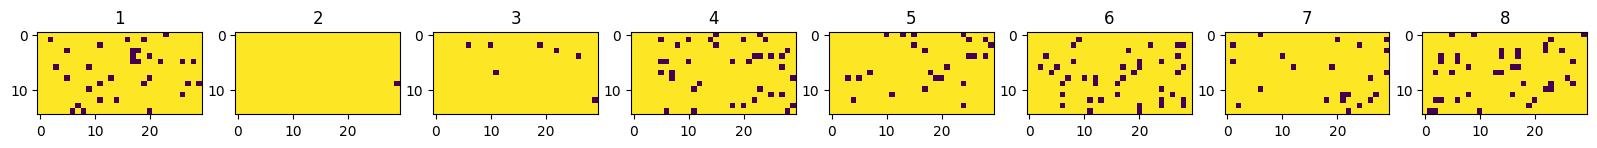

Num timesteps: 160000
Best mean reward: -50095598.97 - Last mean reward per episode: -60666910.08


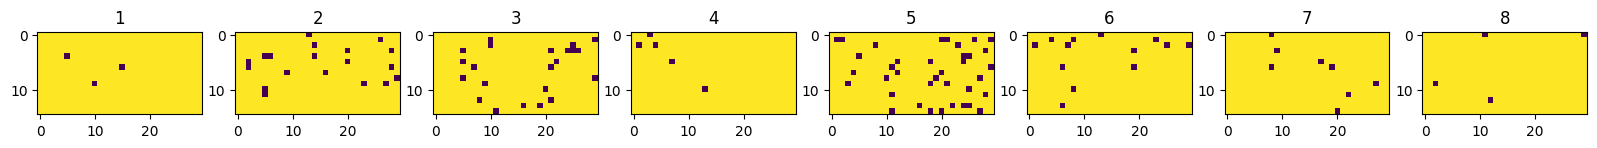

Num timesteps: 168000
Best mean reward: -50095598.97 - Last mean reward per episode: -60243721.41


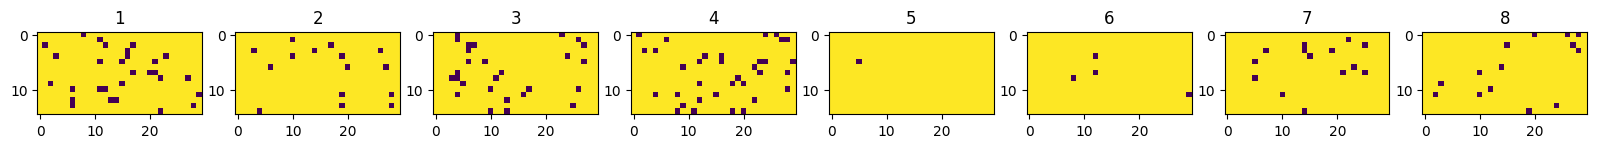

Num timesteps: 176000
Best mean reward: -50095598.97 - Last mean reward per episode: -49880554.54


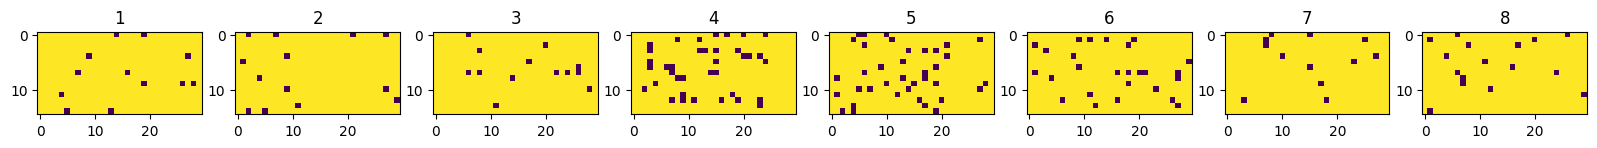

Saving new best model to log/best_model.zip
Num timesteps: 184000
Best mean reward: -49880554.54 - Last mean reward per episode: -60700916.20


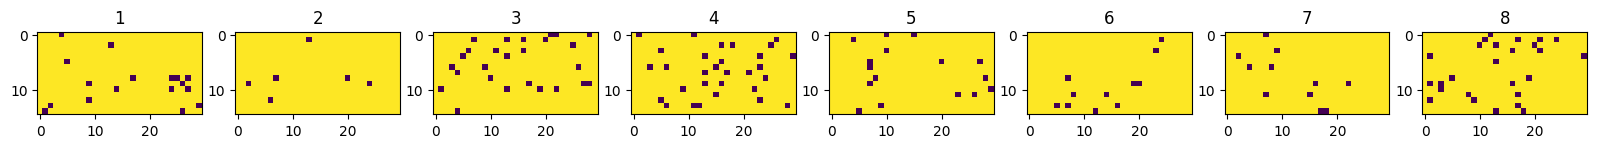

Num timesteps: 192000
Best mean reward: -49880554.54 - Last mean reward per episode: -59476818.77


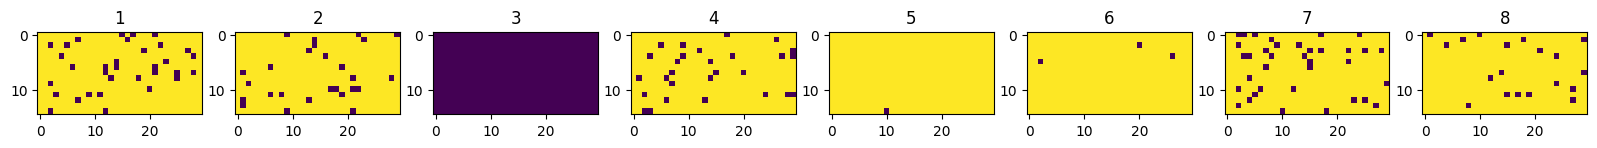

Num timesteps: 200000
Best mean reward: -49880554.54 - Last mean reward per episode: -77576084.93


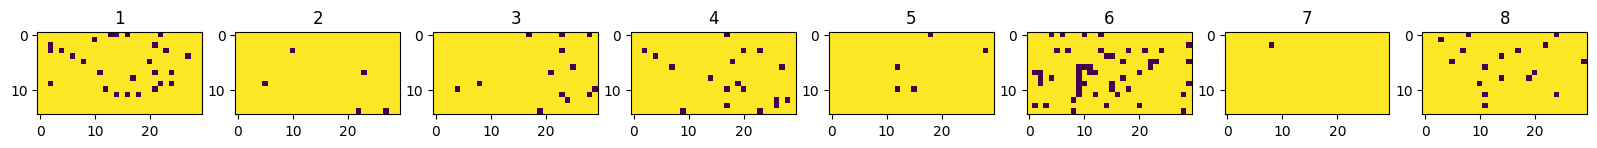

Num timesteps: 208000
Best mean reward: -49880554.54 - Last mean reward per episode: -55606265.36


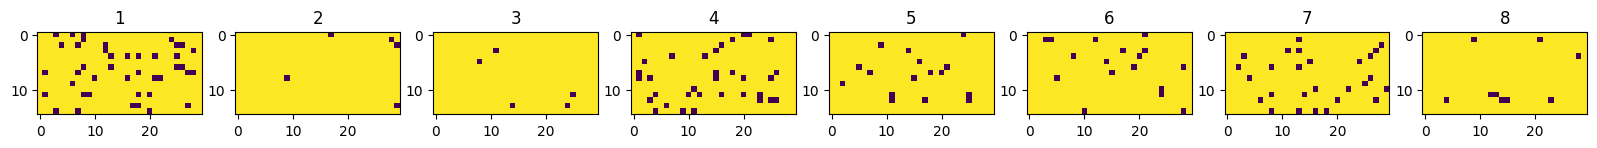

Num timesteps: 216000
Best mean reward: -49880554.54 - Last mean reward per episode: -60542320.25


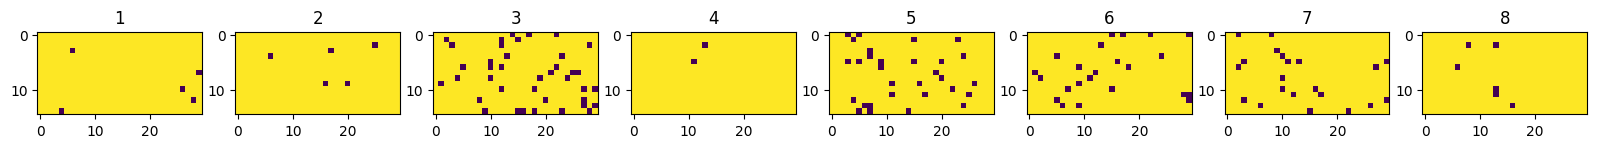

Num timesteps: 224000
Best mean reward: -49880554.54 - Last mean reward per episode: -53780552.31


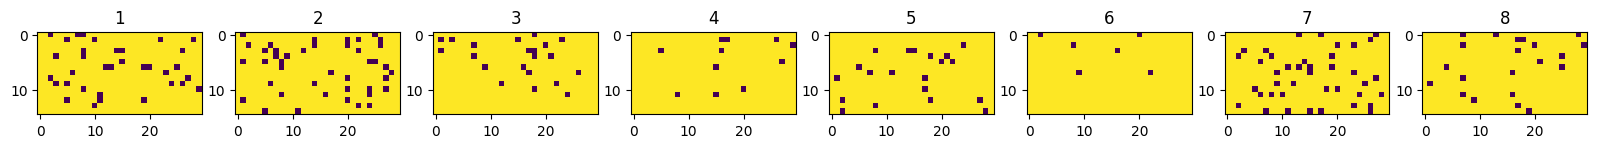

Num timesteps: 232000
Best mean reward: -49880554.54 - Last mean reward per episode: -57688229.88


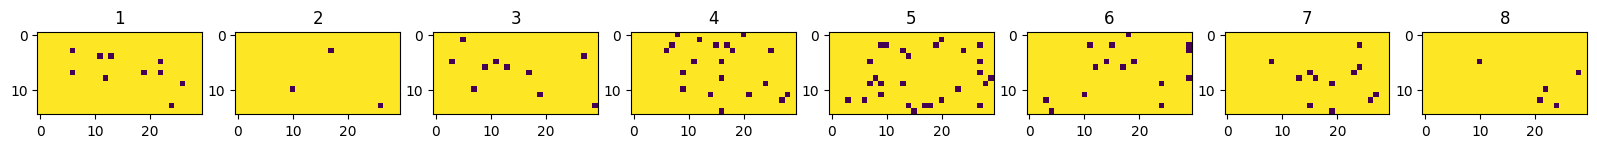

Num timesteps: 240000
Best mean reward: -49880554.54 - Last mean reward per episode: -58394115.57


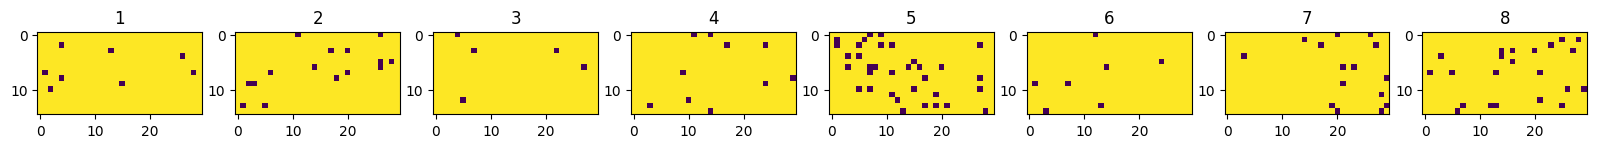

Num timesteps: 248000
Best mean reward: -49880554.54 - Last mean reward per episode: -58368186.33


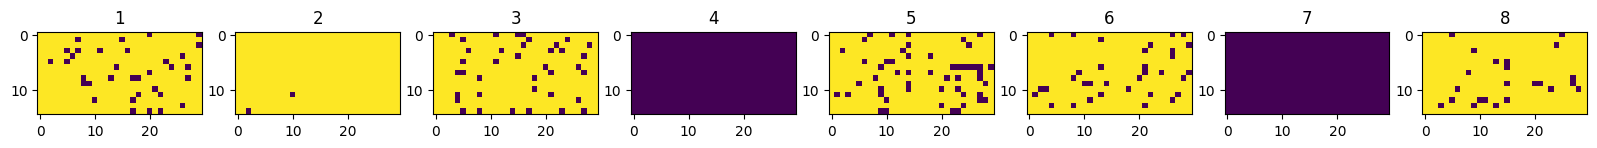

Num timesteps: 256000
Best mean reward: -49880554.54 - Last mean reward per episode: -63644474.67


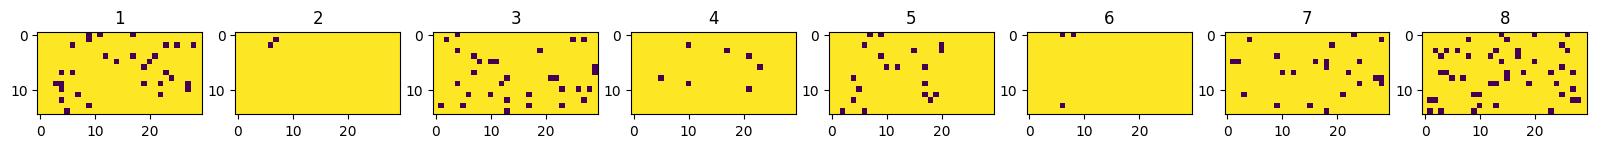

Num timesteps: 264000
Best mean reward: -49880554.54 - Last mean reward per episode: -56407439.49


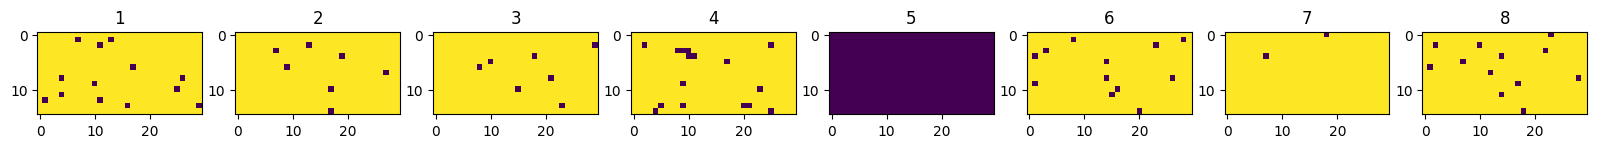

Num timesteps: 272000
Best mean reward: -49880554.54 - Last mean reward per episode: -63979064.51


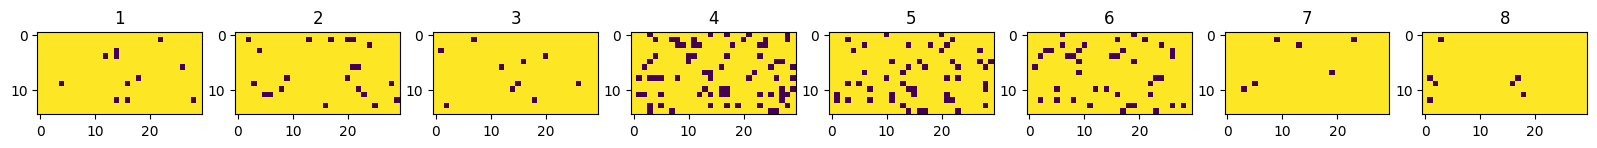

Num timesteps: 280000
Best mean reward: -49880554.54 - Last mean reward per episode: -64177809.59


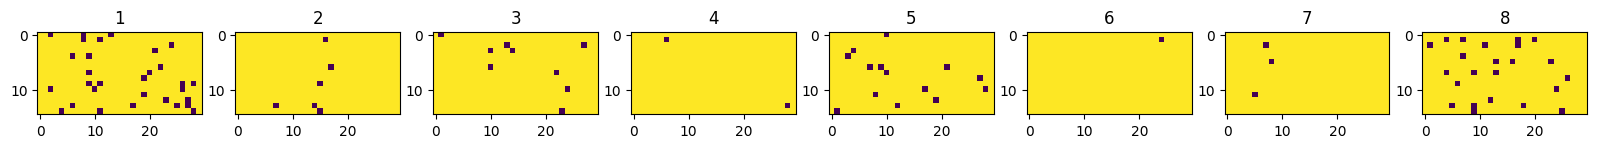

Num timesteps: 288000
Best mean reward: -49880554.54 - Last mean reward per episode: -54636247.92


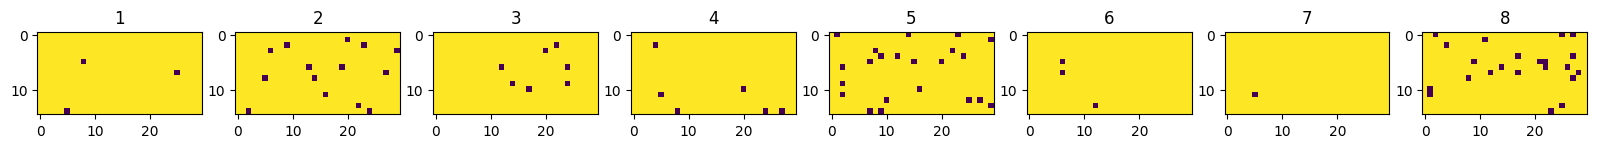

Num timesteps: 296000
Best mean reward: -49880554.54 - Last mean reward per episode: -61405077.51


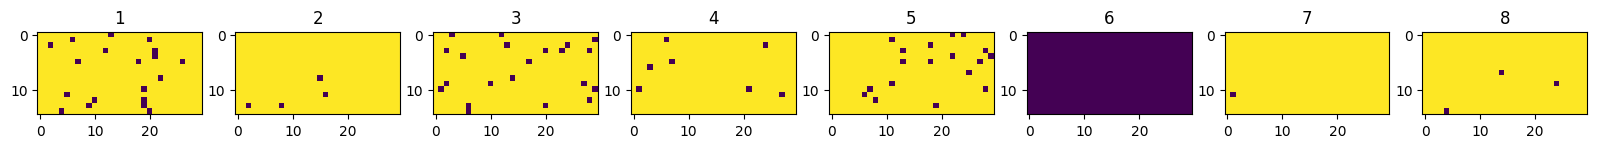

Num timesteps: 304000
Best mean reward: -49880554.54 - Last mean reward per episode: -54840739.95


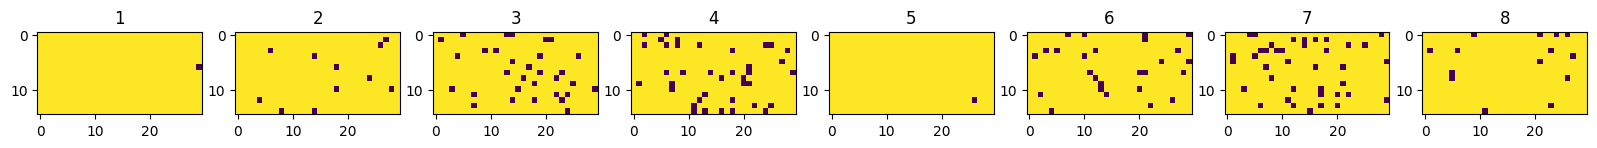

Num timesteps: 312000
Best mean reward: -49880554.54 - Last mean reward per episode: -56900789.98


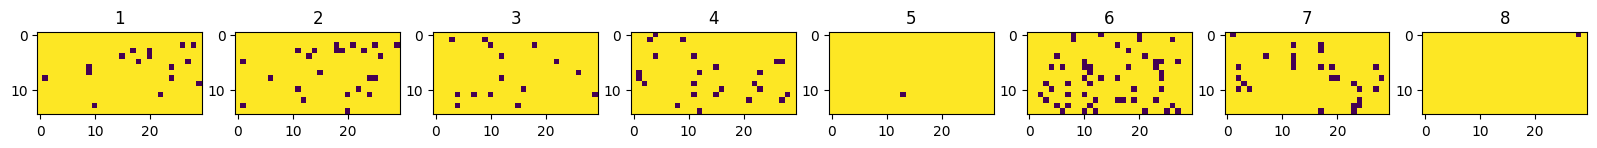

Num timesteps: 320000
Best mean reward: -49880554.54 - Last mean reward per episode: -61762630.69


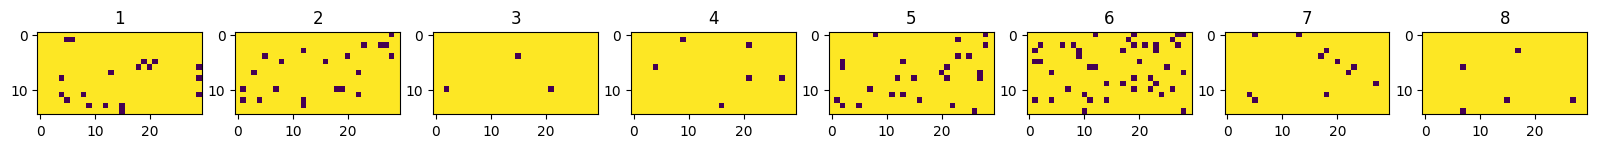

Num timesteps: 328000
Best mean reward: -49880554.54 - Last mean reward per episode: -55105486.81


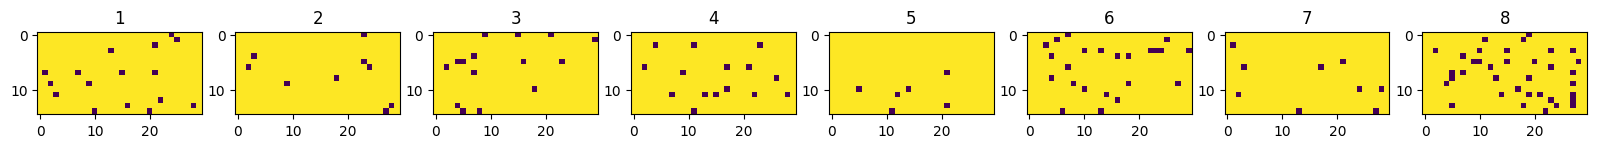

Num timesteps: 336000
Best mean reward: -49880554.54 - Last mean reward per episode: -56272828.56


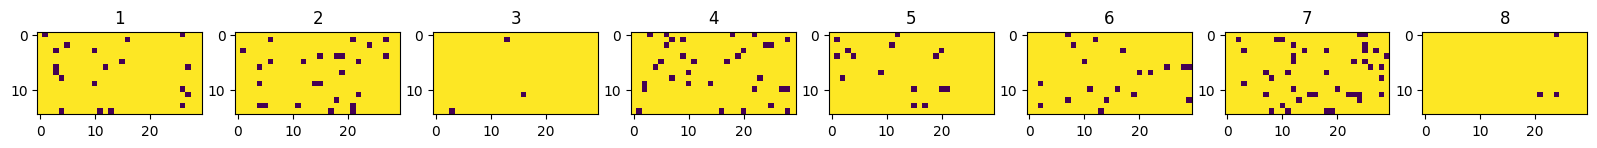

Num timesteps: 344000
Best mean reward: -49880554.54 - Last mean reward per episode: -49601596.19


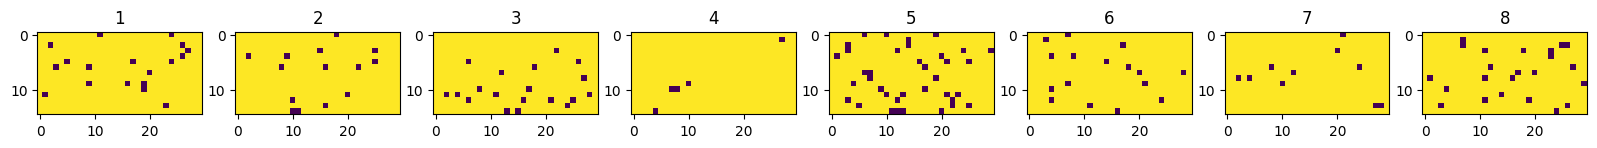

Saving new best model to log/best_model.zip
Num timesteps: 352000
Best mean reward: -49601596.19 - Last mean reward per episode: -56834004.25


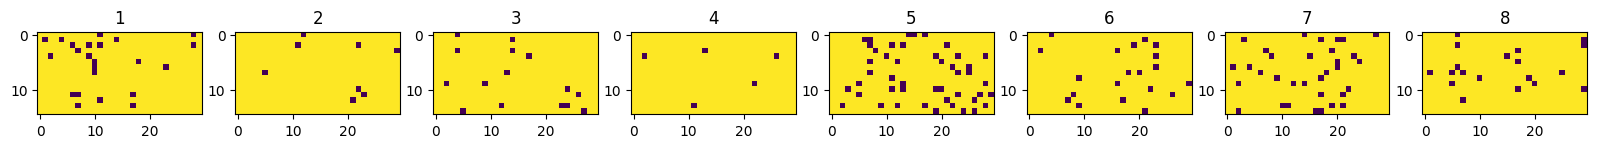

Num timesteps: 360000
Best mean reward: -49601596.19 - Last mean reward per episode: -47376033.29


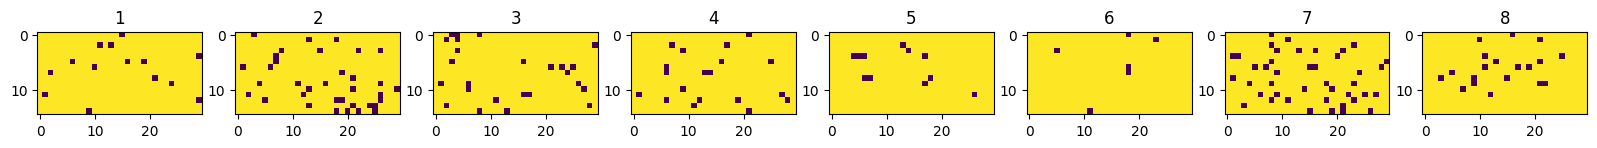

Saving new best model to log/best_model.zip
Num timesteps: 368000
Best mean reward: -47376033.29 - Last mean reward per episode: -57735680.06


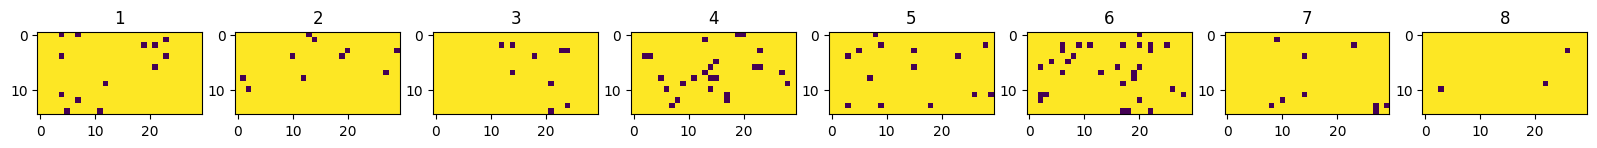

Num timesteps: 376000
Best mean reward: -47376033.29 - Last mean reward per episode: -66317371.55


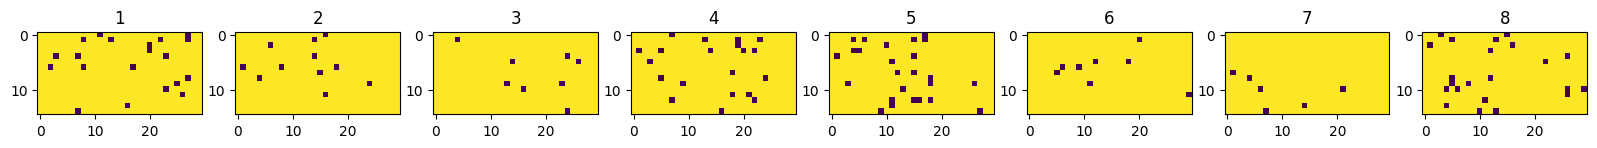

Num timesteps: 384000
Best mean reward: -47376033.29 - Last mean reward per episode: -49926511.29


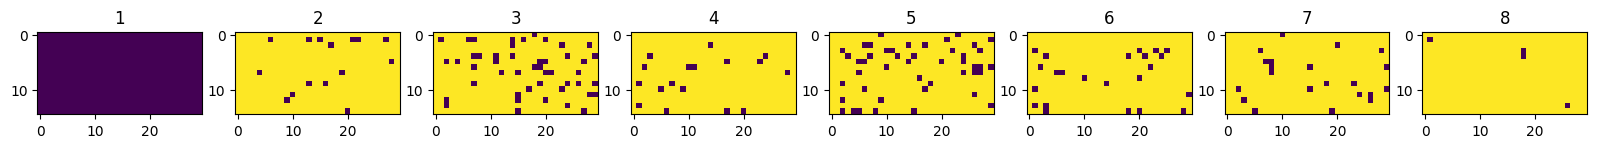

Num timesteps: 392000
Best mean reward: -47376033.29 - Last mean reward per episode: -66109430.49


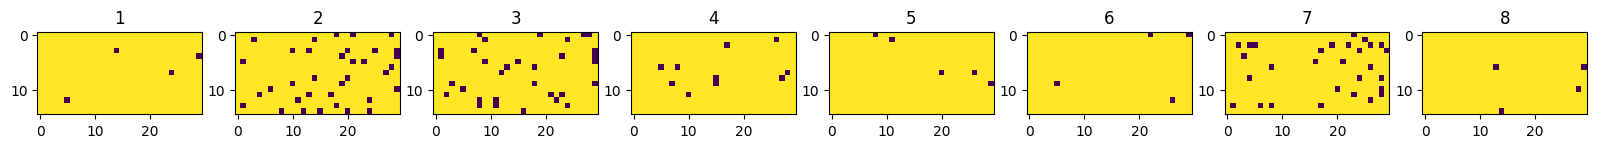

Num timesteps: 400000
Best mean reward: -47376033.29 - Last mean reward per episode: -58315973.84


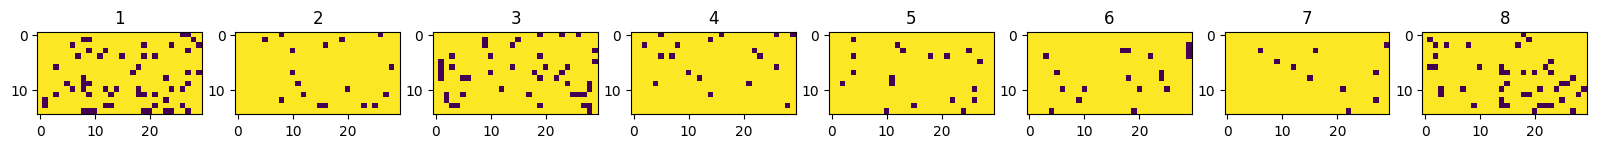

Num timesteps: 408000
Best mean reward: -47376033.29 - Last mean reward per episode: -54220956.06


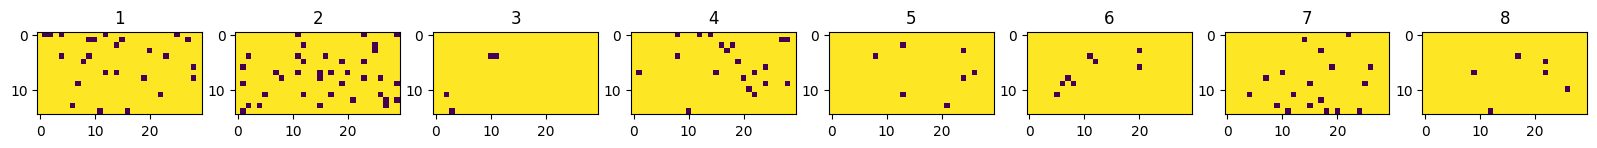

Num timesteps: 416000
Best mean reward: -47376033.29 - Last mean reward per episode: -60176411.43


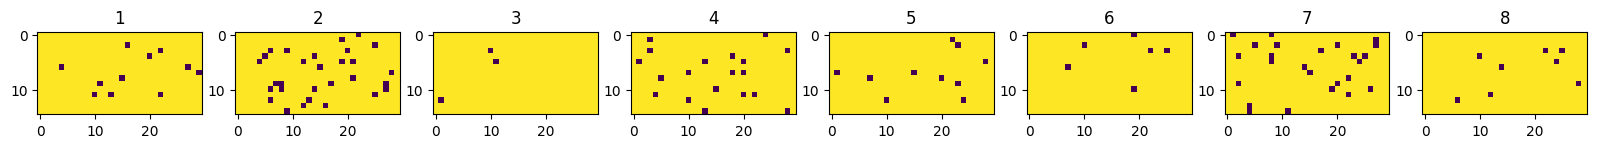

Num timesteps: 424000
Best mean reward: -47376033.29 - Last mean reward per episode: -61552080.12


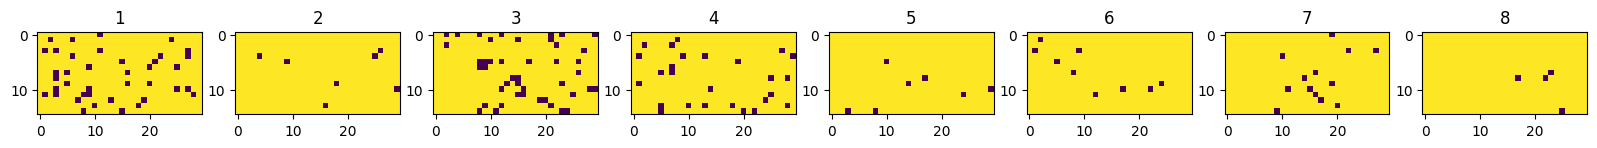

Num timesteps: 432000
Best mean reward: -47376033.29 - Last mean reward per episode: -61518834.73


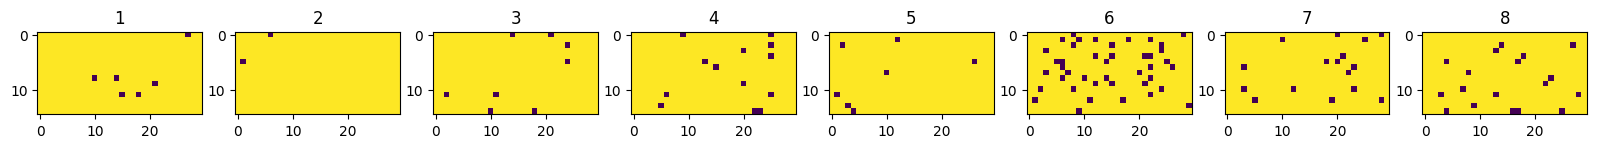

Num timesteps: 440000
Best mean reward: -47376033.29 - Last mean reward per episode: -55318931.67


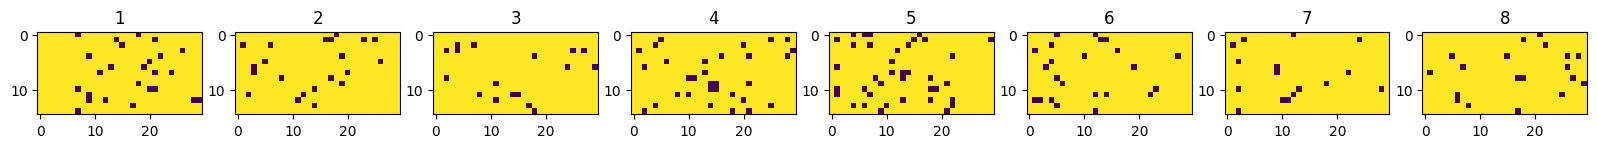

Num timesteps: 448000
Best mean reward: -47376033.29 - Last mean reward per episode: -70004771.23


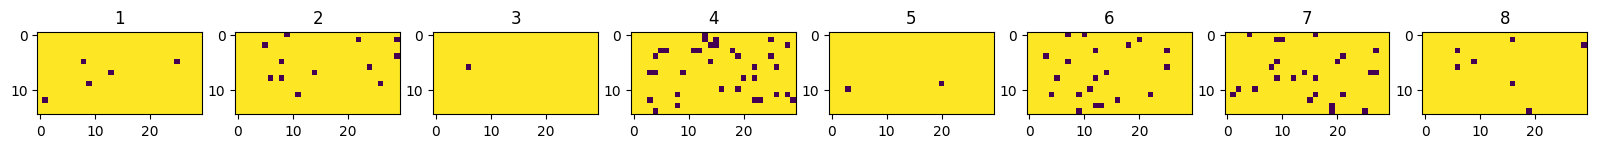

Num timesteps: 456000
Best mean reward: -47376033.29 - Last mean reward per episode: -66071694.98


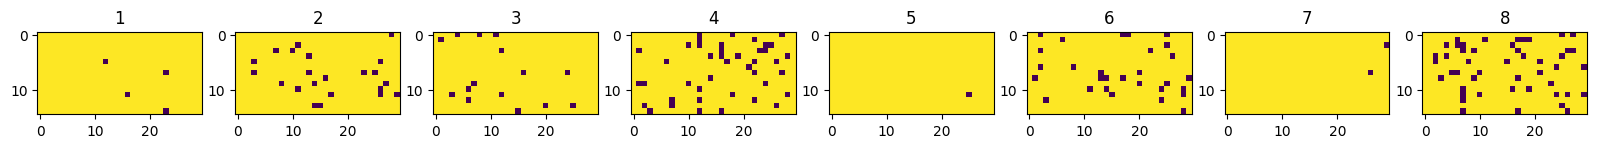

Num timesteps: 464000
Best mean reward: -47376033.29 - Last mean reward per episode: -58774214.15


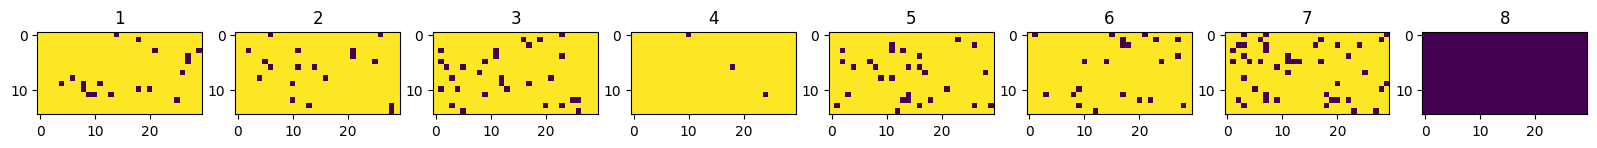

Num timesteps: 472000
Best mean reward: -47376033.29 - Last mean reward per episode: -55851955.23


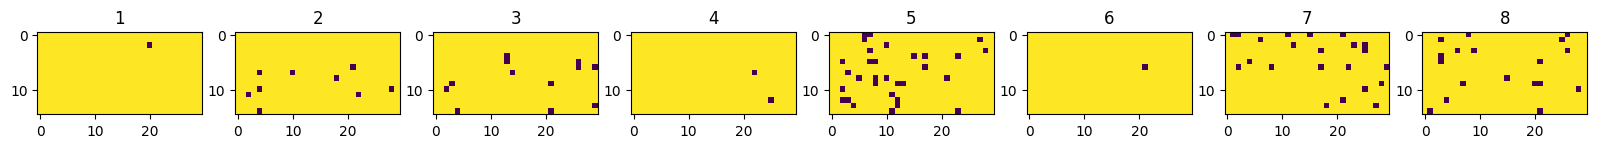

Num timesteps: 480000
Best mean reward: -47376033.29 - Last mean reward per episode: -56163960.20


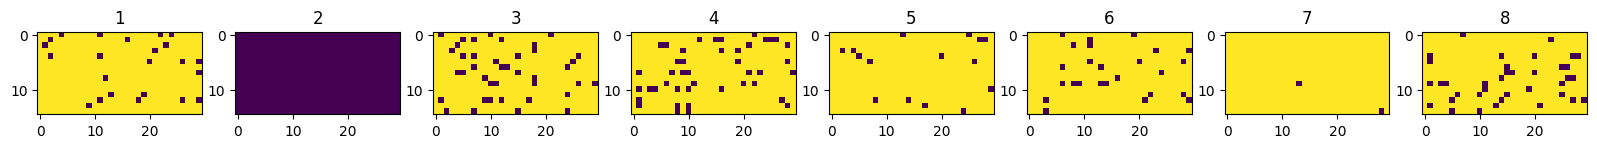

Num timesteps: 488000
Best mean reward: -47376033.29 - Last mean reward per episode: -56290789.88


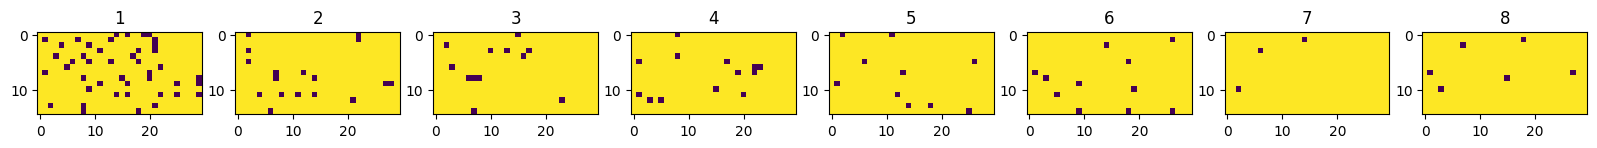

Num timesteps: 496000
Best mean reward: -47376033.29 - Last mean reward per episode: -58919958.86


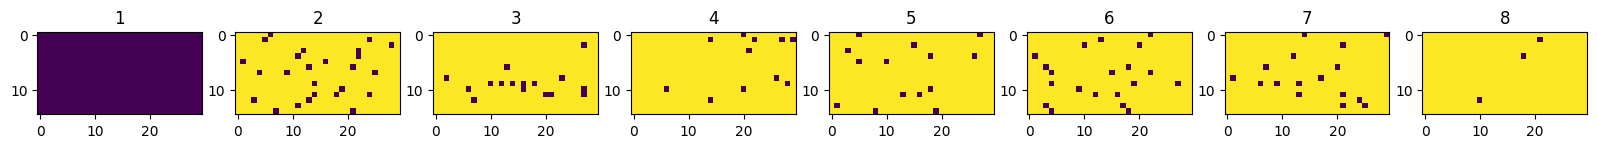

Num timesteps: 504000
Best mean reward: -47376033.29 - Last mean reward per episode: -57528857.73


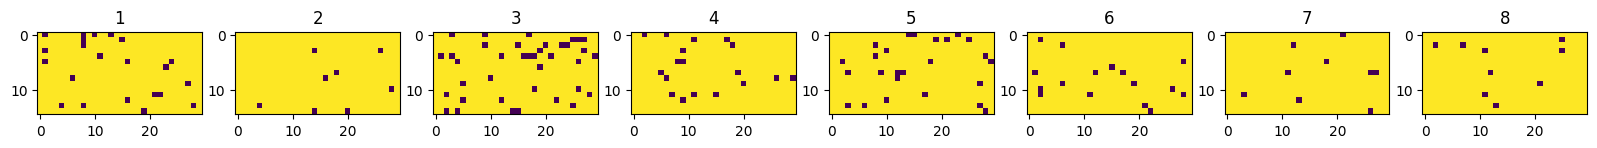

Num timesteps: 512000
Best mean reward: -47376033.29 - Last mean reward per episode: -54132594.28


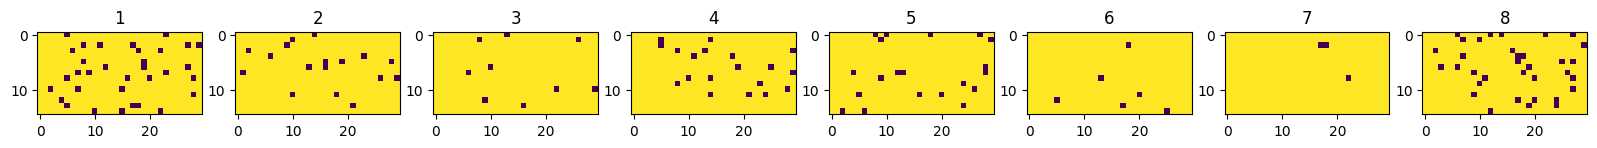

Num timesteps: 520000
Best mean reward: -47376033.29 - Last mean reward per episode: -53584318.55


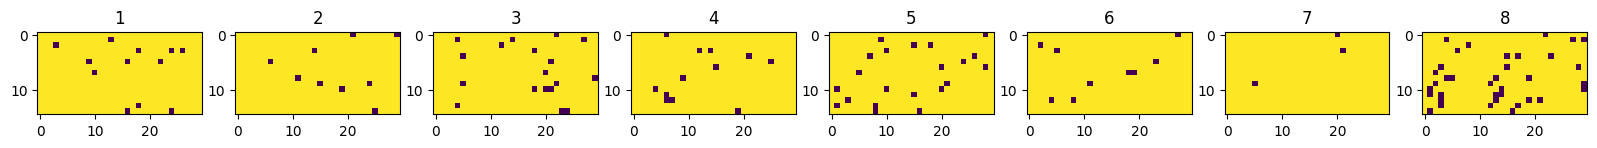

Num timesteps: 528000
Best mean reward: -47376033.29 - Last mean reward per episode: -51029737.39


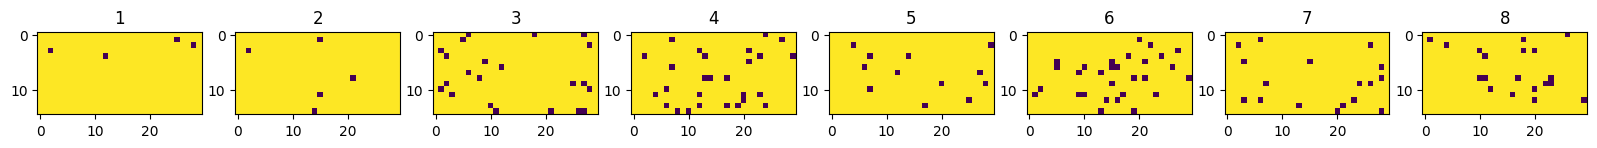

Num timesteps: 536000
Best mean reward: -47376033.29 - Last mean reward per episode: -58758298.35


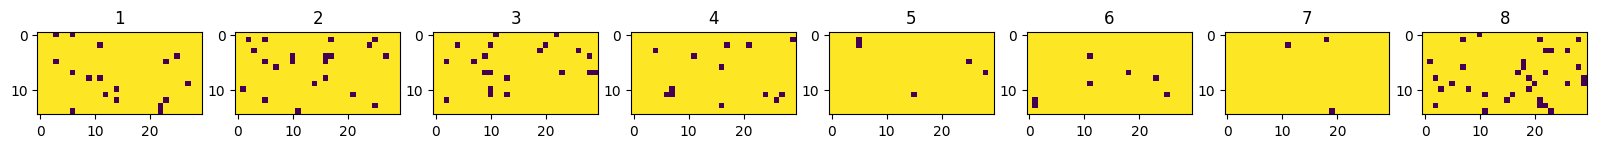

Num timesteps: 544000
Best mean reward: -47376033.29 - Last mean reward per episode: -61043592.44


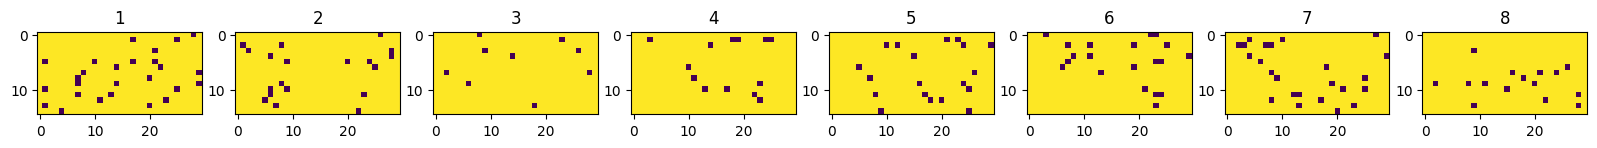

Num timesteps: 552000
Best mean reward: -47376033.29 - Last mean reward per episode: -56292449.65


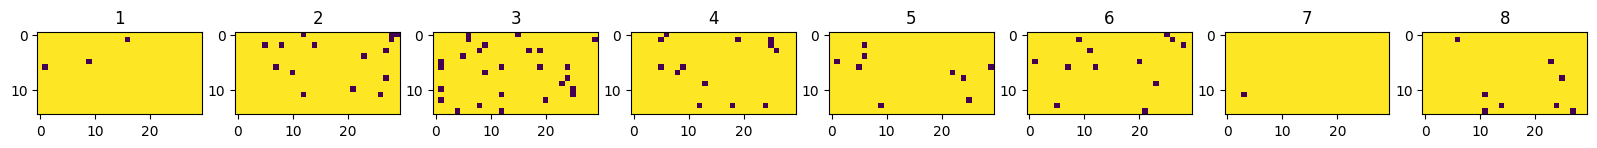

Num timesteps: 560000
Best mean reward: -47376033.29 - Last mean reward per episode: -63069704.72


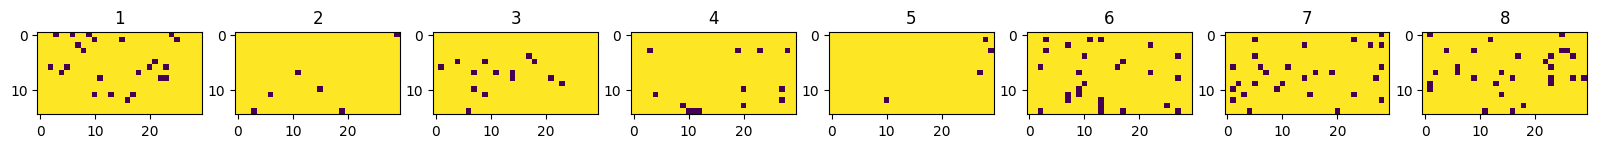

Num timesteps: 568000
Best mean reward: -47376033.29 - Last mean reward per episode: -62407312.84


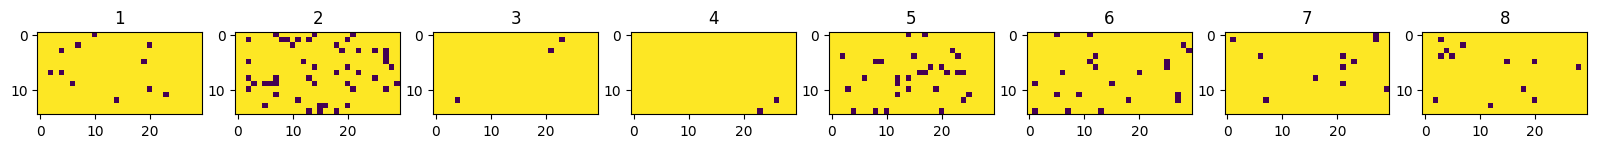

Num timesteps: 576000
Best mean reward: -47376033.29 - Last mean reward per episode: -54034241.40


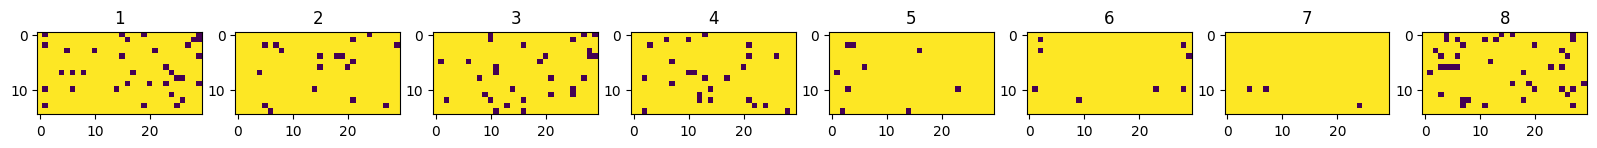

Num timesteps: 584000
Best mean reward: -47376033.29 - Last mean reward per episode: -55400993.53


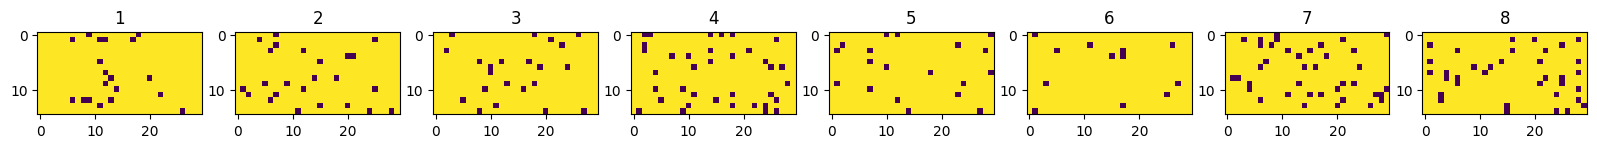

Num timesteps: 592000
Best mean reward: -47376033.29 - Last mean reward per episode: -55810445.24


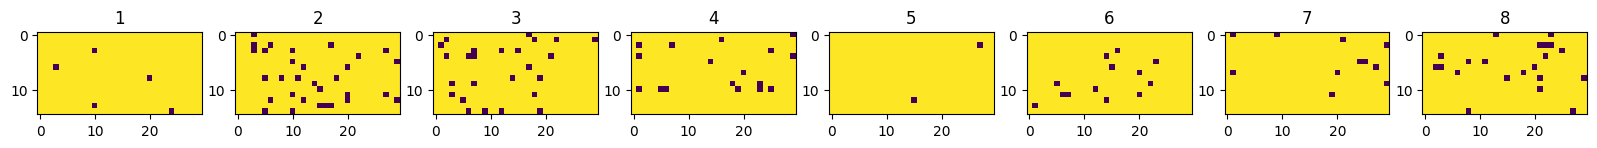

Num timesteps: 600000
Best mean reward: -47376033.29 - Last mean reward per episode: -57336421.04


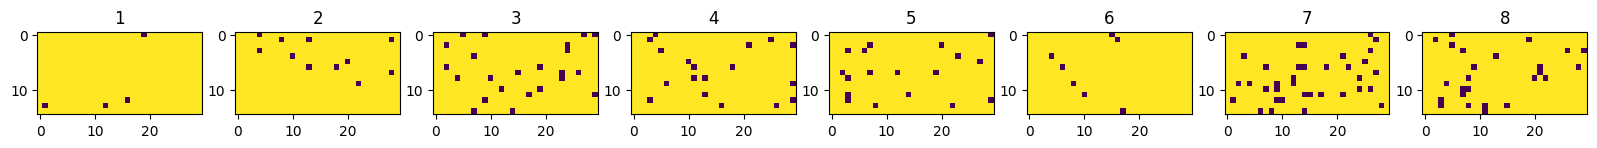

Num timesteps: 608000
Best mean reward: -47376033.29 - Last mean reward per episode: -55106585.21


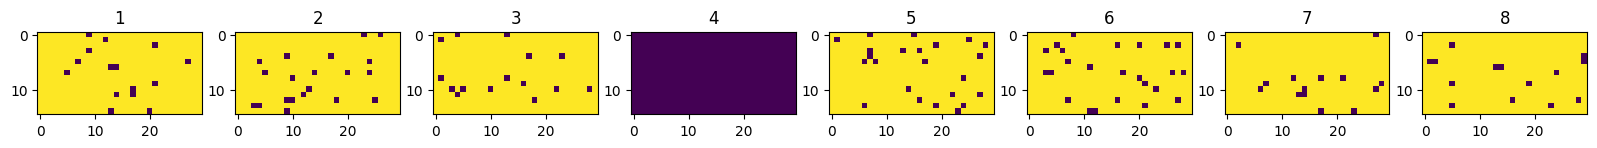

Num timesteps: 616000
Best mean reward: -47376033.29 - Last mean reward per episode: -65656997.13


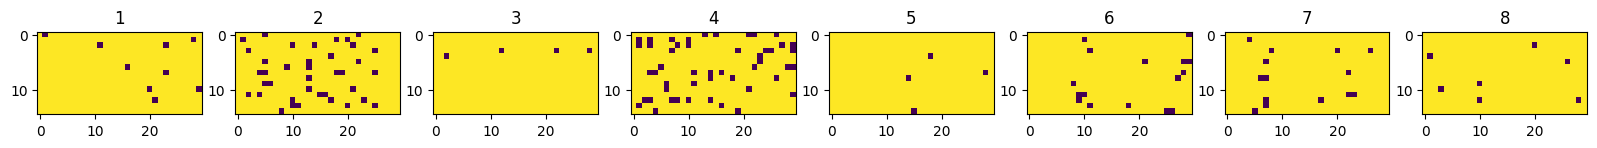

Num timesteps: 624000
Best mean reward: -47376033.29 - Last mean reward per episode: -56786712.97


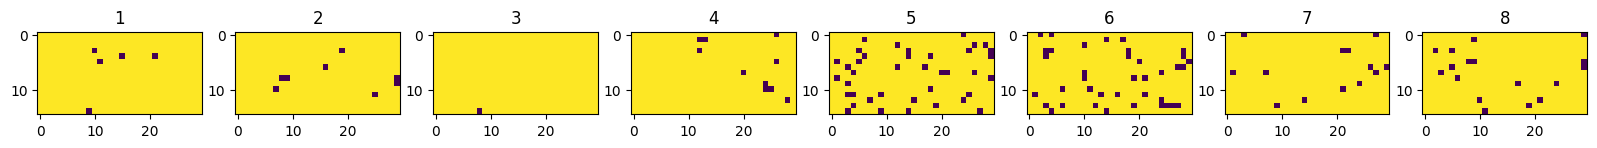

Num timesteps: 632000
Best mean reward: -47376033.29 - Last mean reward per episode: -64270841.67


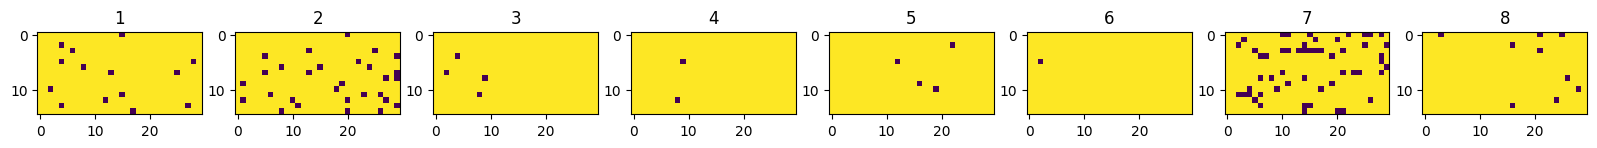

Num timesteps: 640000
Best mean reward: -47376033.29 - Last mean reward per episode: -58191678.36


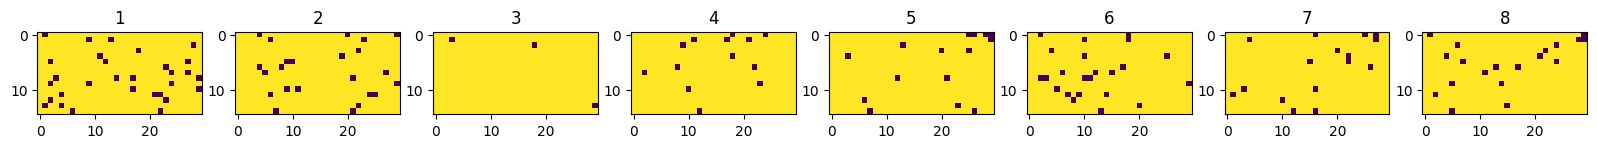

Num timesteps: 648000
Best mean reward: -47376033.29 - Last mean reward per episode: -66180703.30


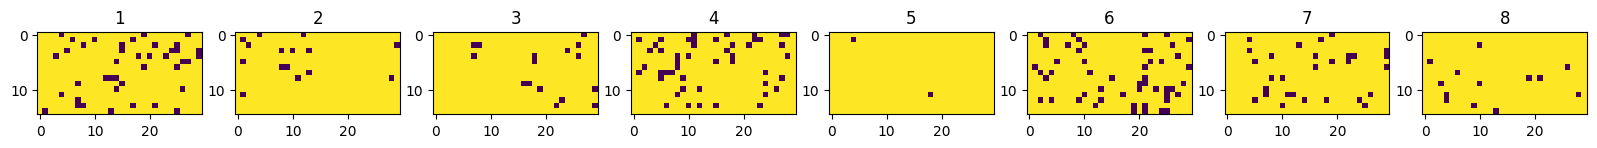

Num timesteps: 656000
Best mean reward: -47376033.29 - Last mean reward per episode: -60172565.03


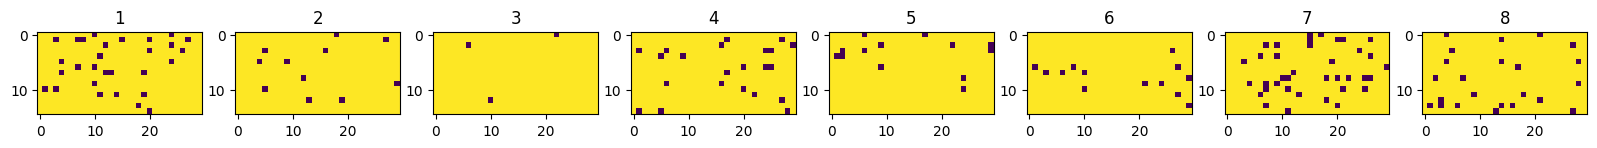

Num timesteps: 664000
Best mean reward: -47376033.29 - Last mean reward per episode: -57567010.18


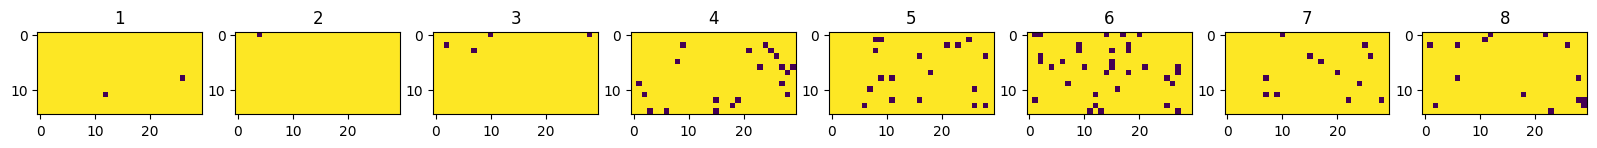

Num timesteps: 672000
Best mean reward: -47376033.29 - Last mean reward per episode: -57572041.06


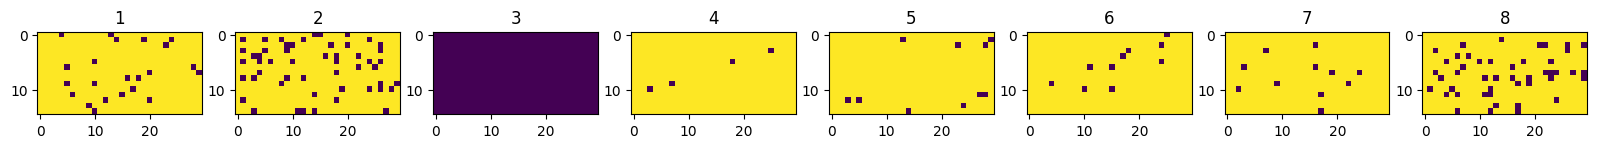

Num timesteps: 680000
Best mean reward: -47376033.29 - Last mean reward per episode: -48846748.50


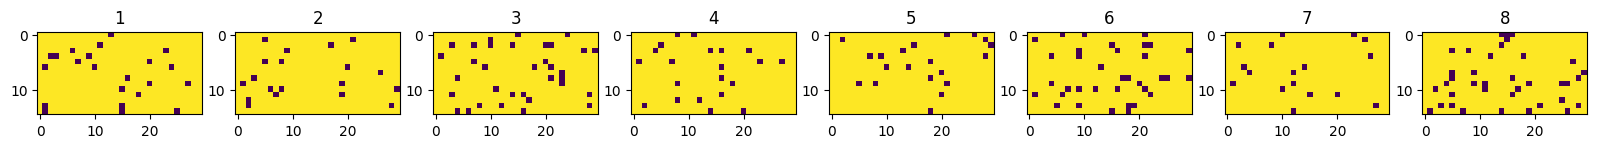

Num timesteps: 688000
Best mean reward: -47376033.29 - Last mean reward per episode: -60613431.84


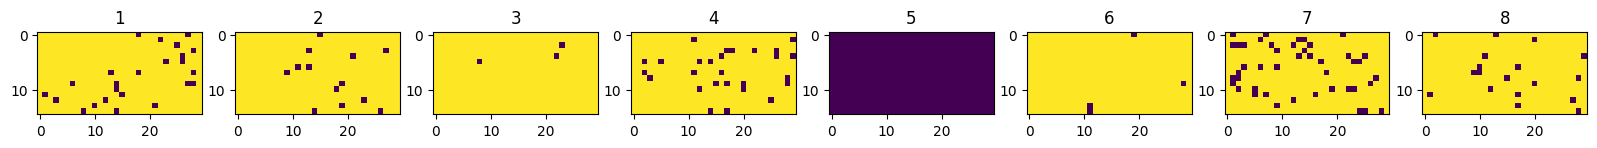

Num timesteps: 696000
Best mean reward: -47376033.29 - Last mean reward per episode: -53188102.45


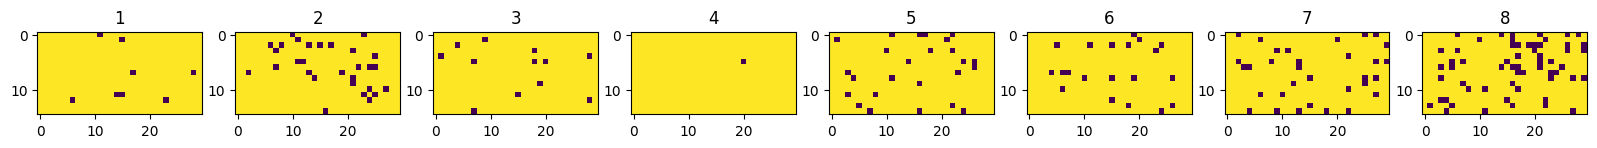

Num timesteps: 704000
Best mean reward: -47376033.29 - Last mean reward per episode: -57854516.36


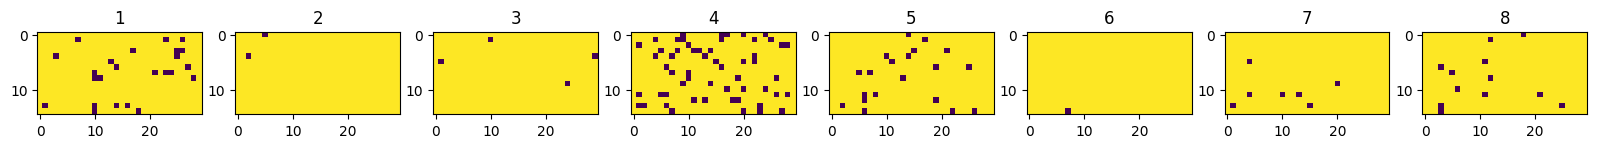

Num timesteps: 712000
Best mean reward: -47376033.29 - Last mean reward per episode: -61767910.30


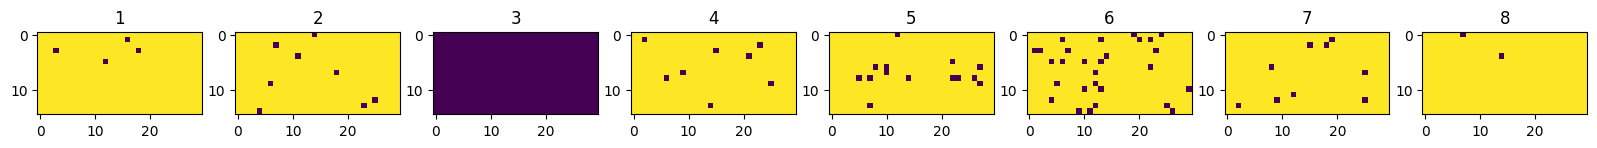

Num timesteps: 720000
Best mean reward: -47376033.29 - Last mean reward per episode: -66616396.02


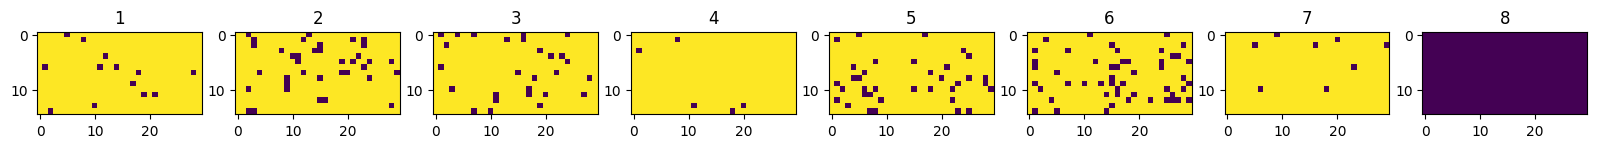

Num timesteps: 728000
Best mean reward: -47376033.29 - Last mean reward per episode: -70399306.82


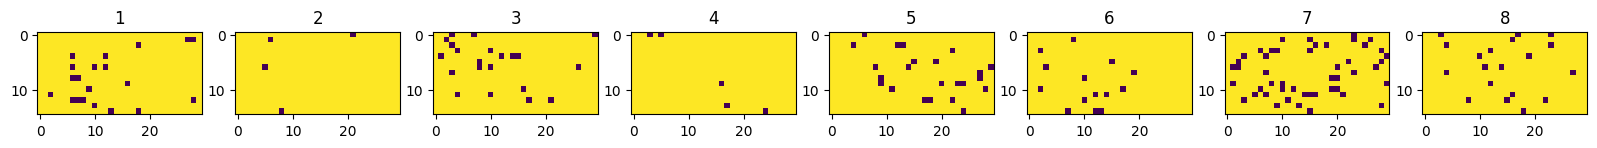

Num timesteps: 736000
Best mean reward: -47376033.29 - Last mean reward per episode: -48705104.20


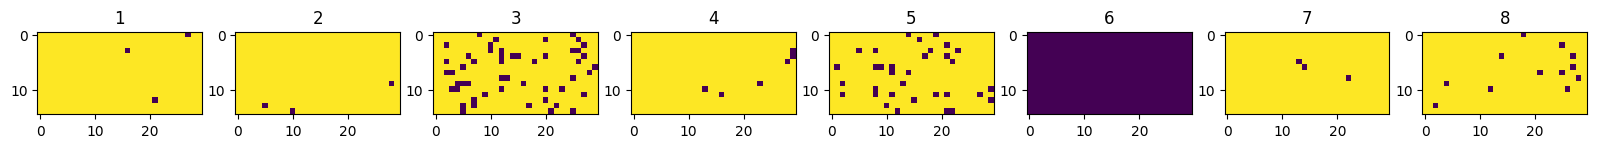

Num timesteps: 744000
Best mean reward: -47376033.29 - Last mean reward per episode: -55707911.05


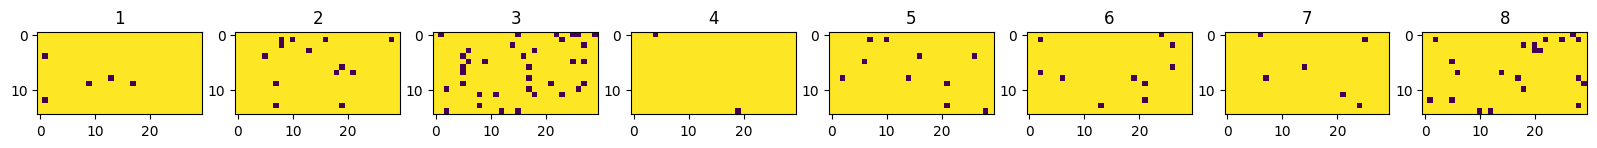

Num timesteps: 752000
Best mean reward: -47376033.29 - Last mean reward per episode: -65945750.97


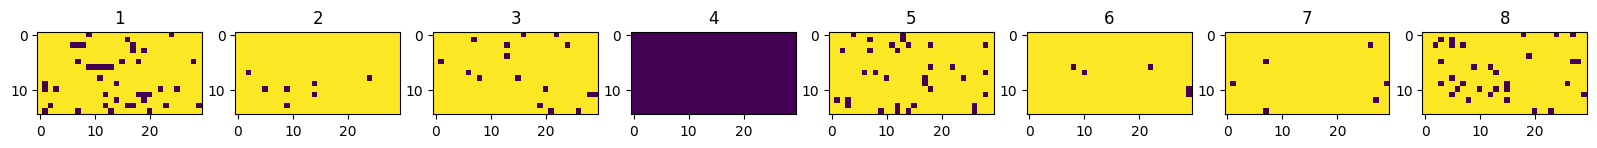

Num timesteps: 760000
Best mean reward: -47376033.29 - Last mean reward per episode: -50205405.01


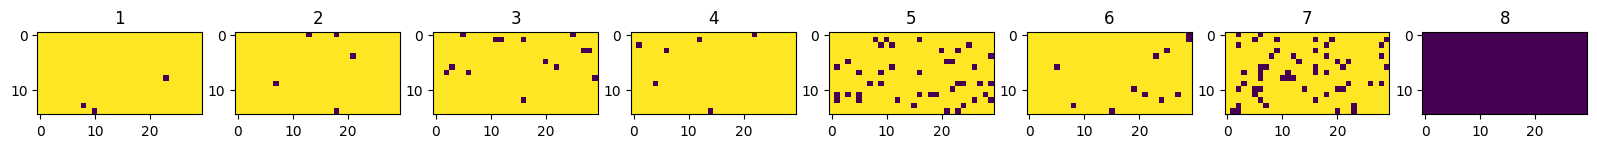

Num timesteps: 768000
Best mean reward: -47376033.29 - Last mean reward per episode: -54988843.35


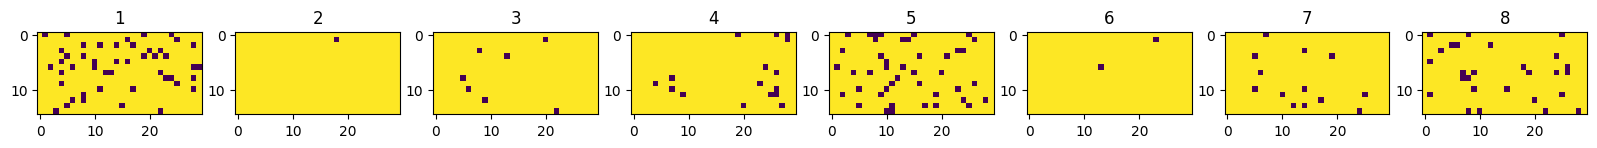

Num timesteps: 776000
Best mean reward: -47376033.29 - Last mean reward per episode: -51530960.16


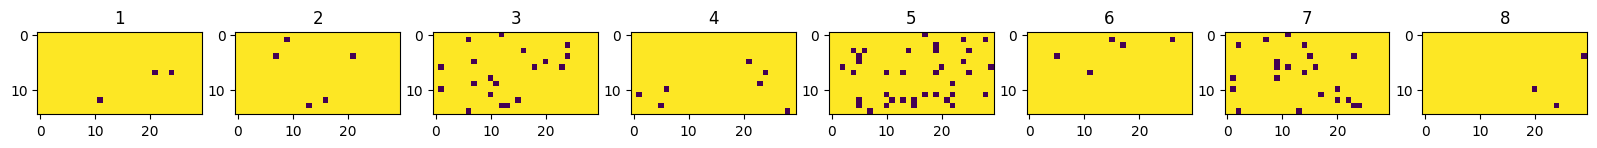

Num timesteps: 784000
Best mean reward: -47376033.29 - Last mean reward per episode: -66452824.30


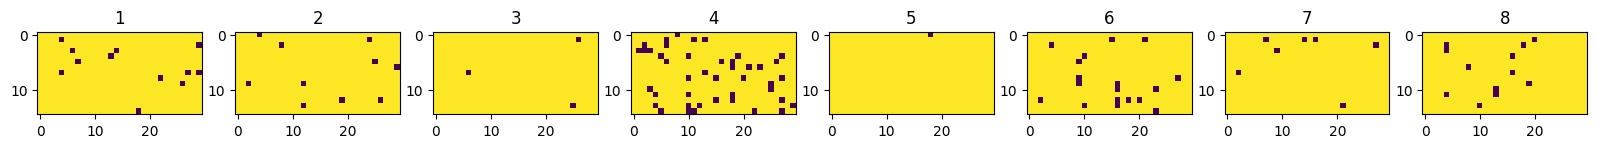

Num timesteps: 792000
Best mean reward: -47376033.29 - Last mean reward per episode: -60046937.90


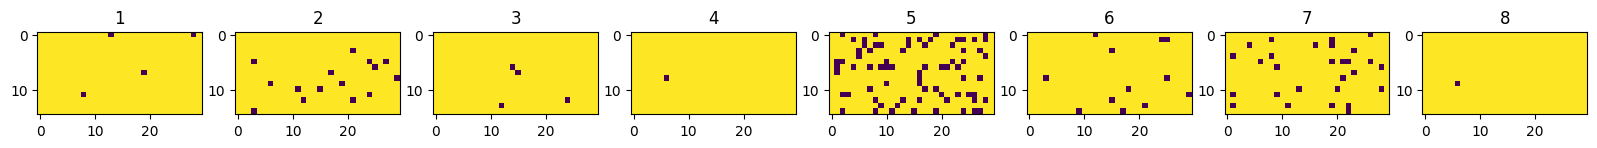

Num timesteps: 800000
Best mean reward: -47376033.29 - Last mean reward per episode: -56131381.74


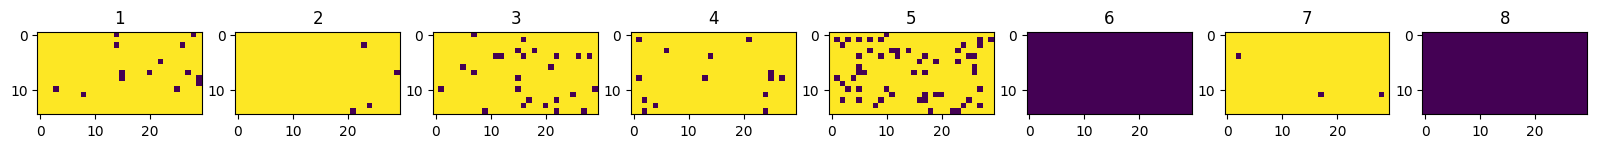

Num timesteps: 808000
Best mean reward: -47376033.29 - Last mean reward per episode: -61385907.71


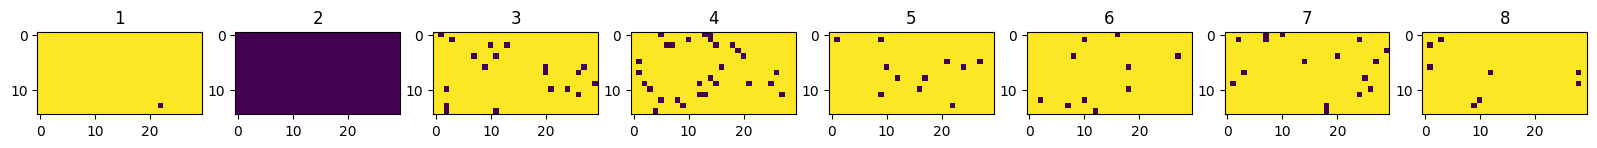

Num timesteps: 816000
Best mean reward: -47376033.29 - Last mean reward per episode: -53107759.42


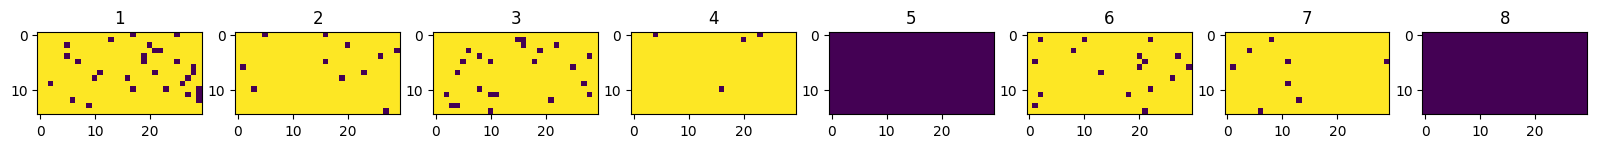

Num timesteps: 824000
Best mean reward: -47376033.29 - Last mean reward per episode: -62119834.08


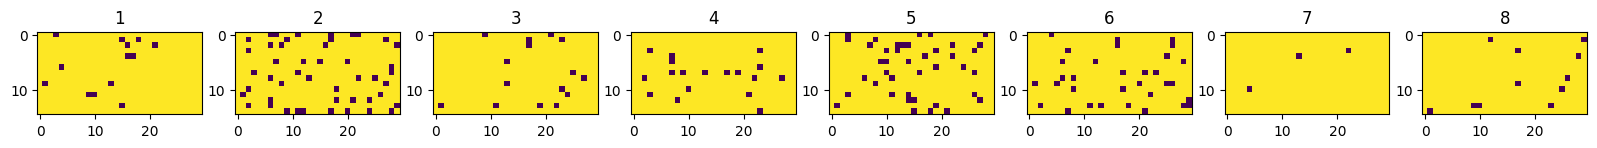

Num timesteps: 832000
Best mean reward: -47376033.29 - Last mean reward per episode: -64304277.07


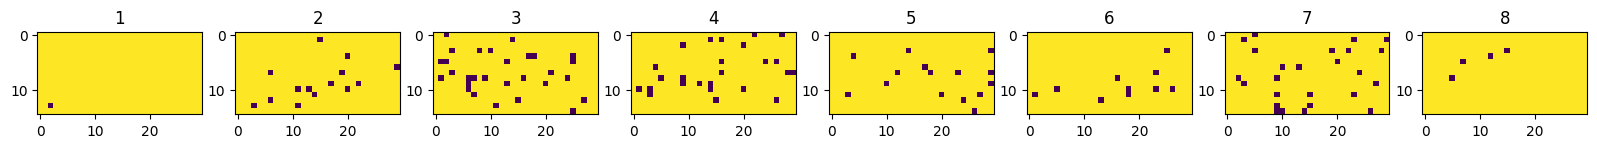

Num timesteps: 840000
Best mean reward: -47376033.29 - Last mean reward per episode: -63201332.15


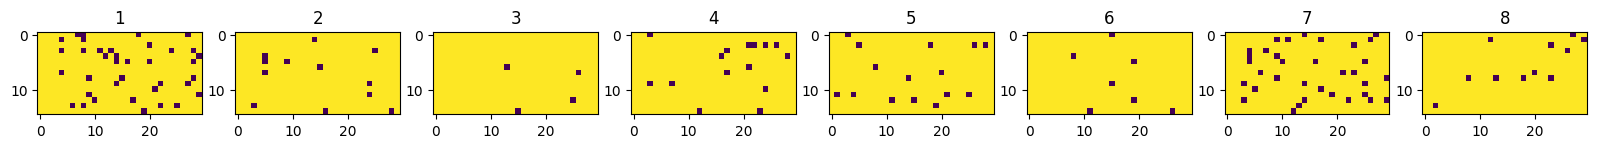

Num timesteps: 848000
Best mean reward: -47376033.29 - Last mean reward per episode: -54307372.98


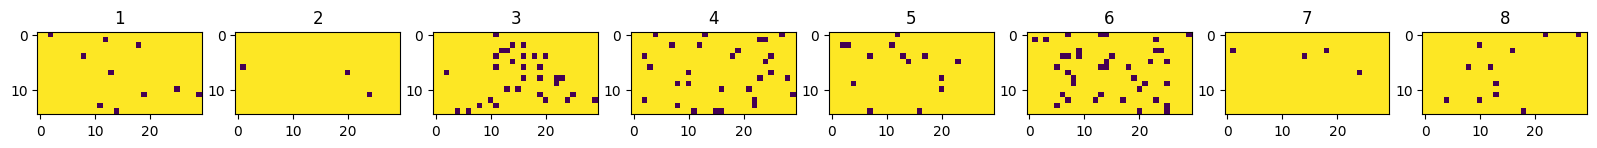

Num timesteps: 856000
Best mean reward: -47376033.29 - Last mean reward per episode: -43657901.90


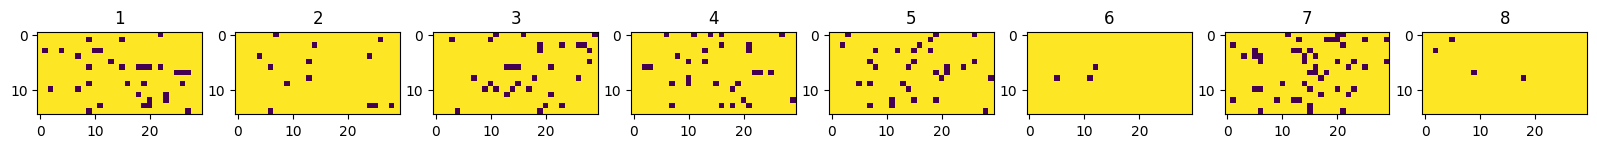

Saving new best model to log/best_model.zip
Num timesteps: 864000
Best mean reward: -43657901.90 - Last mean reward per episode: -52578316.83


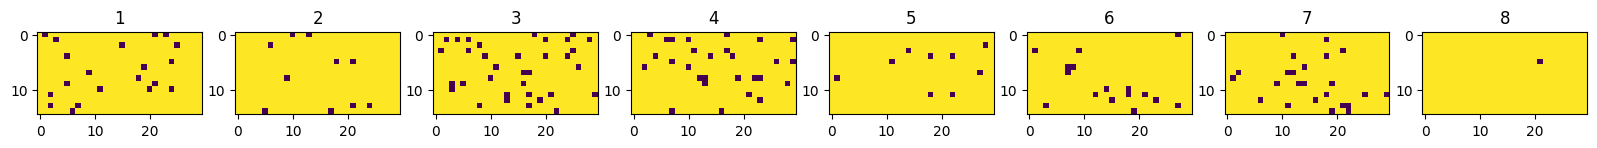

Num timesteps: 872000
Best mean reward: -43657901.90 - Last mean reward per episode: -61082630.70


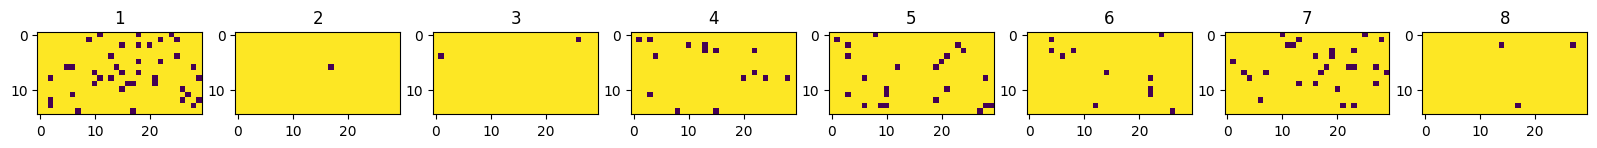

Num timesteps: 880000
Best mean reward: -43657901.90 - Last mean reward per episode: -60538925.04


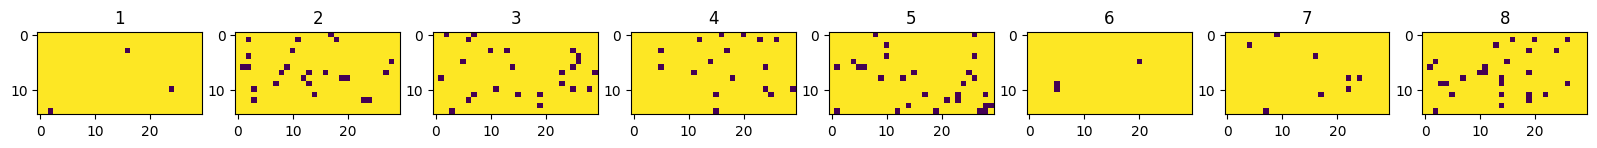

Num timesteps: 888000
Best mean reward: -43657901.90 - Last mean reward per episode: -54694319.88


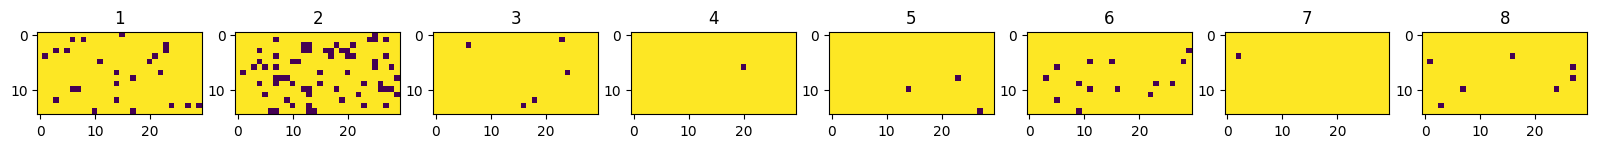

Num timesteps: 896000
Best mean reward: -43657901.90 - Last mean reward per episode: -59870286.21


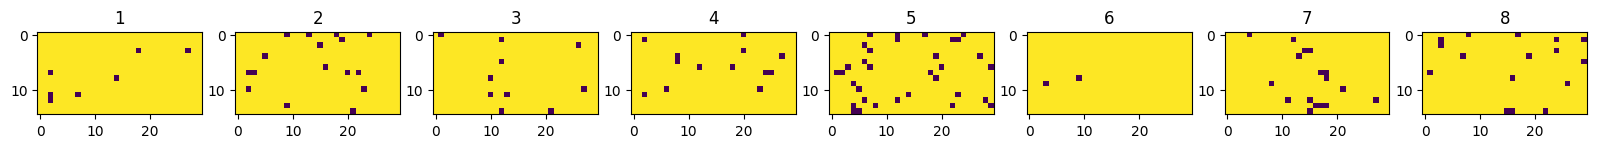

Num timesteps: 904000
Best mean reward: -43657901.90 - Last mean reward per episode: -52787381.76


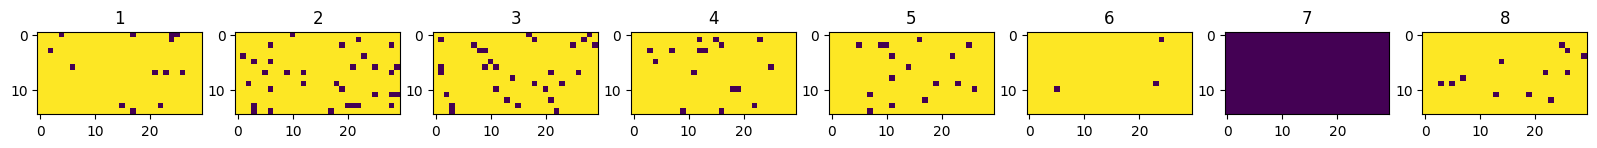

Num timesteps: 912000
Best mean reward: -43657901.90 - Last mean reward per episode: -61049128.00


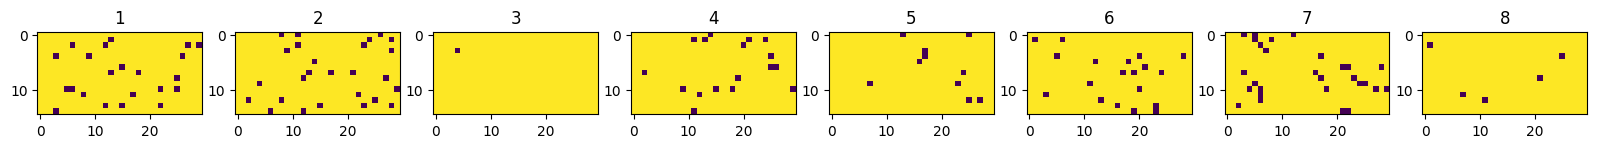

Num timesteps: 920000
Best mean reward: -43657901.90 - Last mean reward per episode: -55032905.34


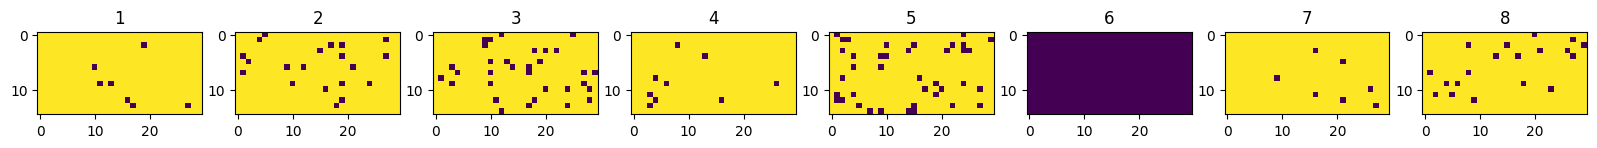

Num timesteps: 928000
Best mean reward: -43657901.90 - Last mean reward per episode: -62936664.67


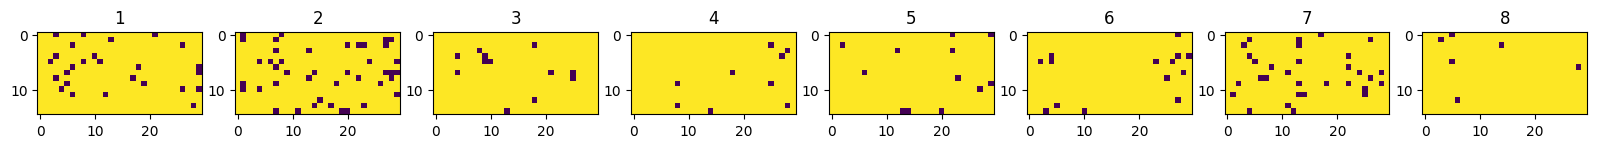

Num timesteps: 936000
Best mean reward: -43657901.90 - Last mean reward per episode: -57967644.64


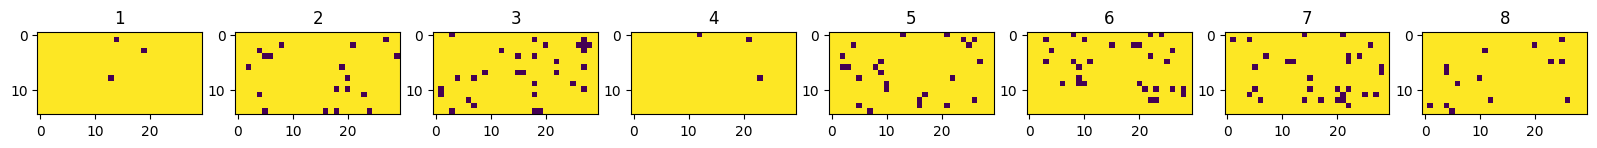

Num timesteps: 944000
Best mean reward: -43657901.90 - Last mean reward per episode: -56145512.99


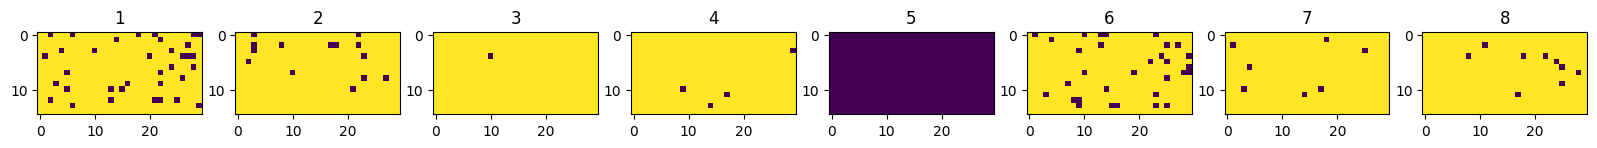

Num timesteps: 952000
Best mean reward: -43657901.90 - Last mean reward per episode: -58936070.63


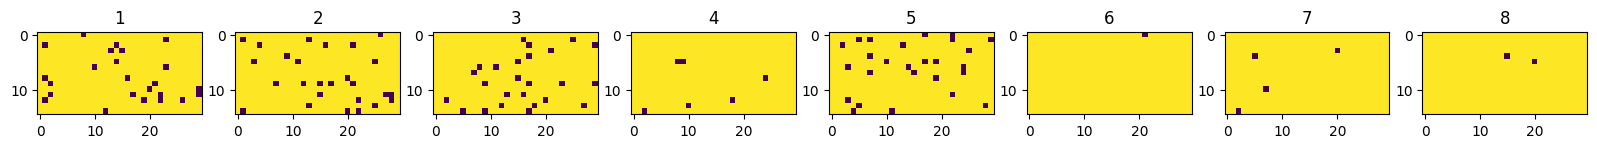

Num timesteps: 960000
Best mean reward: -43657901.90 - Last mean reward per episode: -65334455.51


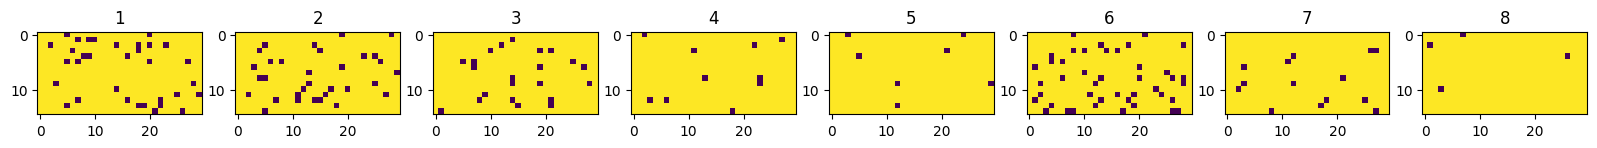

Num timesteps: 968000
Best mean reward: -43657901.90 - Last mean reward per episode: -54990235.78


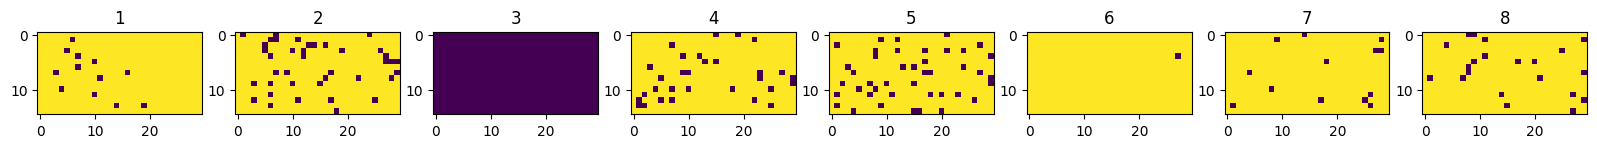

Num timesteps: 976000
Best mean reward: -43657901.90 - Last mean reward per episode: -50134477.02


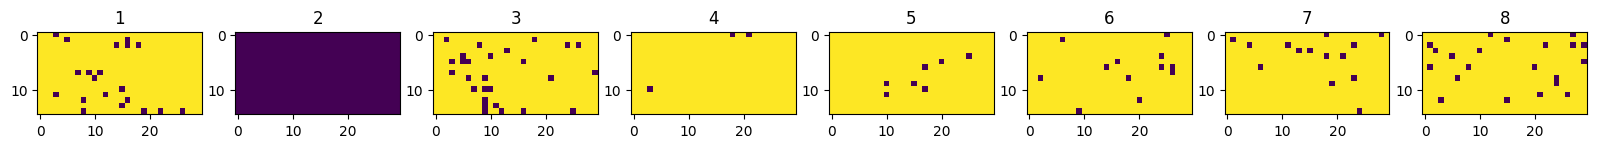

Num timesteps: 984000
Best mean reward: -43657901.90 - Last mean reward per episode: -53842170.48


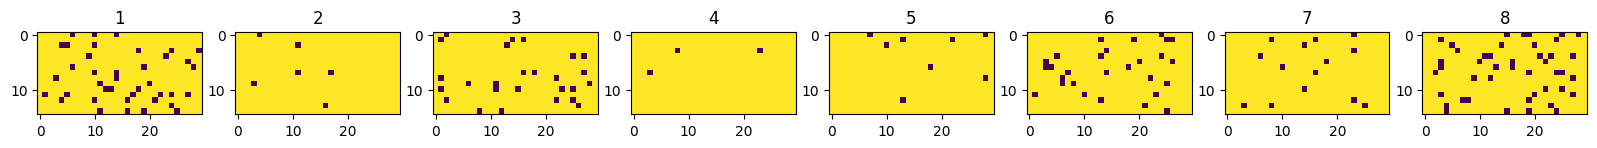

Num timesteps: 992000
Best mean reward: -43657901.90 - Last mean reward per episode: -52364866.83


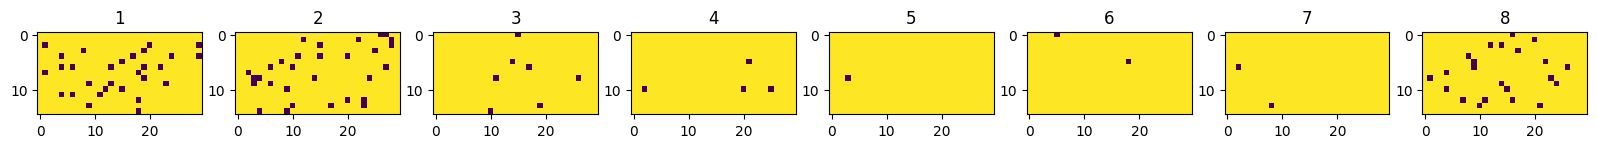

Num timesteps: 1000000
Best mean reward: -43657901.90 - Last mean reward per episode: -53655142.83


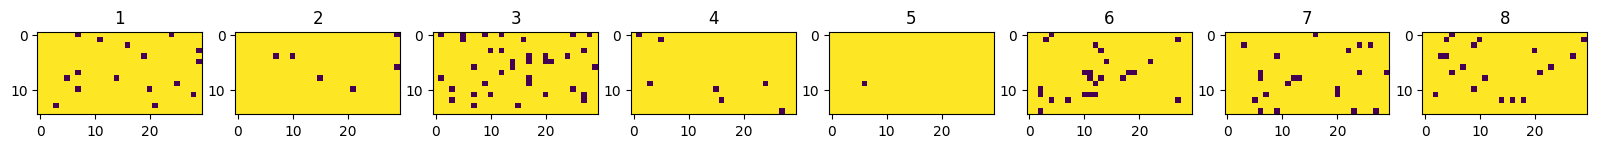

Num timesteps: 1008000
Best mean reward: -43657901.90 - Last mean reward per episode: -58250216.14


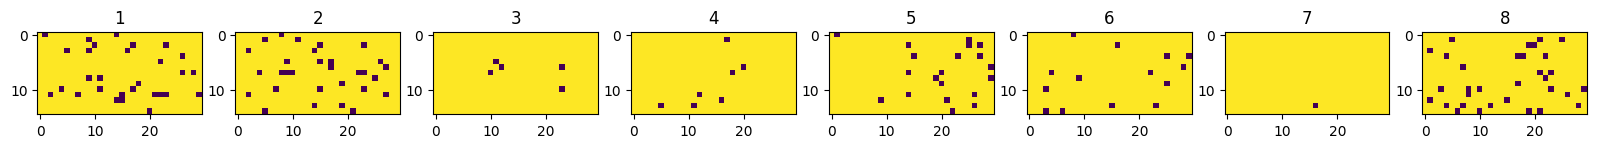

Num timesteps: 1016000
Best mean reward: -43657901.90 - Last mean reward per episode: -58813557.61


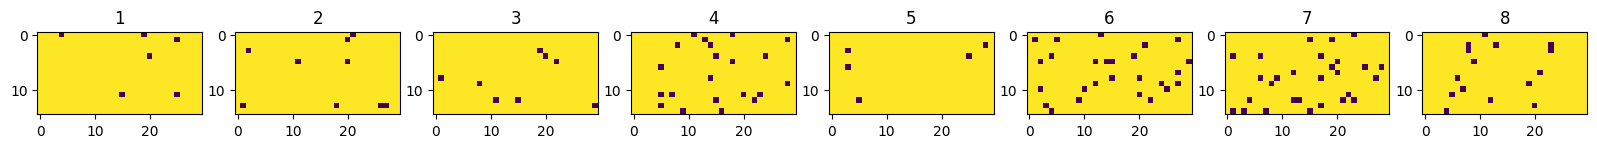

Num timesteps: 1024000
Best mean reward: -43657901.90 - Last mean reward per episode: -61626821.42


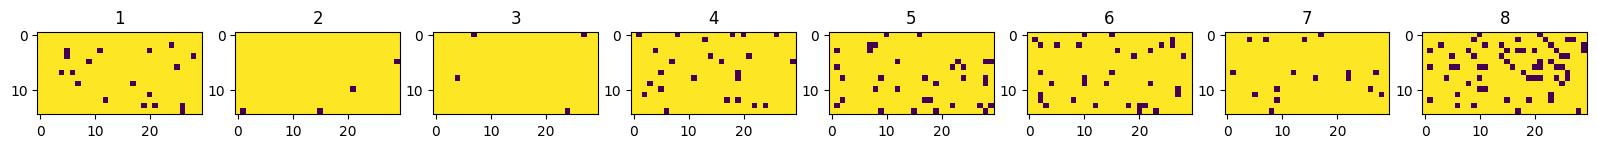

Num timesteps: 1032000
Best mean reward: -43657901.90 - Last mean reward per episode: -60755207.12


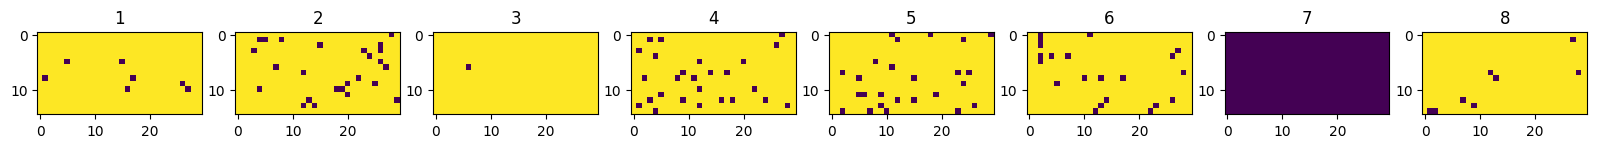

Num timesteps: 1040000
Best mean reward: -43657901.90 - Last mean reward per episode: -57906183.16


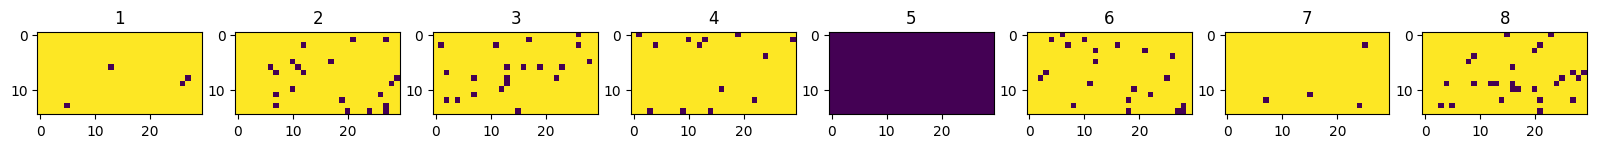

Num timesteps: 1048000
Best mean reward: -43657901.90 - Last mean reward per episode: -43188767.30


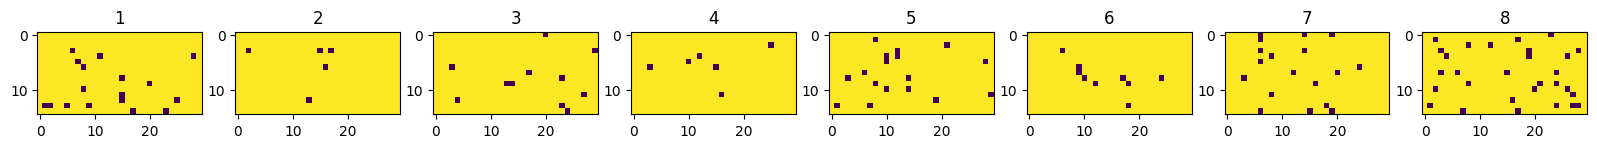

Saving new best model to log/best_model.zip
Num timesteps: 1056000
Best mean reward: -43188767.30 - Last mean reward per episode: -49047680.60


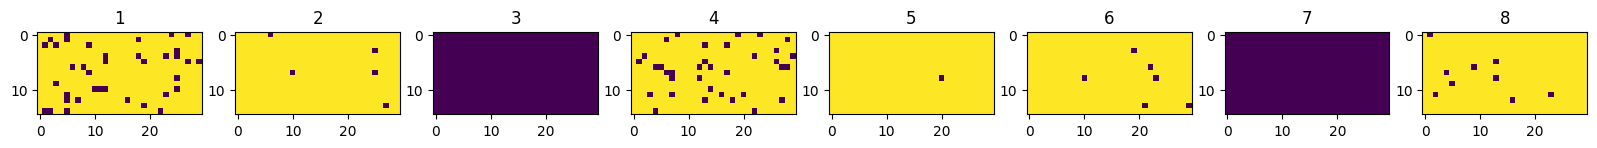

Num timesteps: 1064000
Best mean reward: -43188767.30 - Last mean reward per episode: -57343727.76


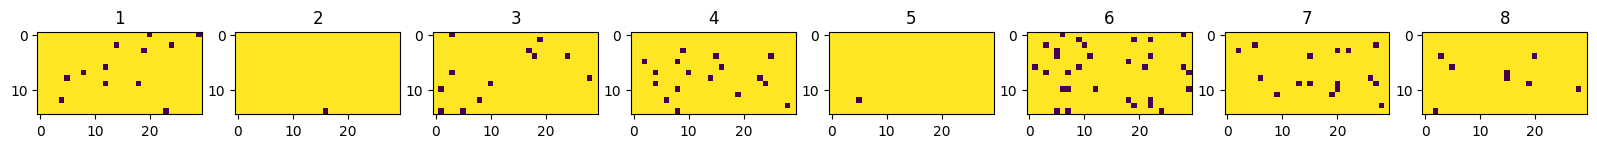

Num timesteps: 1072000
Best mean reward: -43188767.30 - Last mean reward per episode: -57957898.36


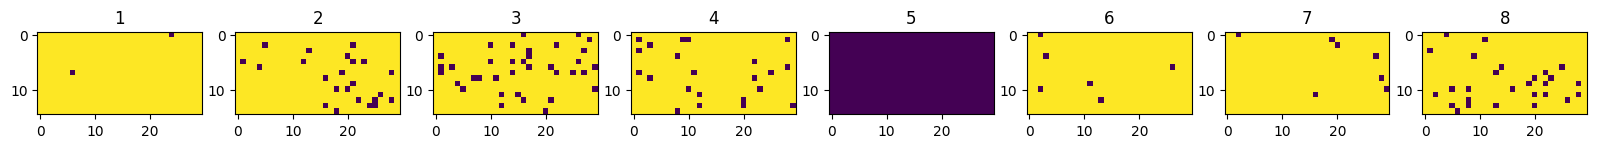

Num timesteps: 1080000
Best mean reward: -43188767.30 - Last mean reward per episode: -55386082.22


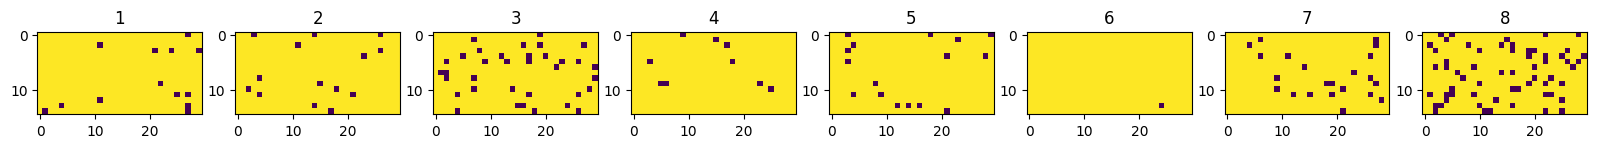

Num timesteps: 1088000
Best mean reward: -43188767.30 - Last mean reward per episode: -62525946.21


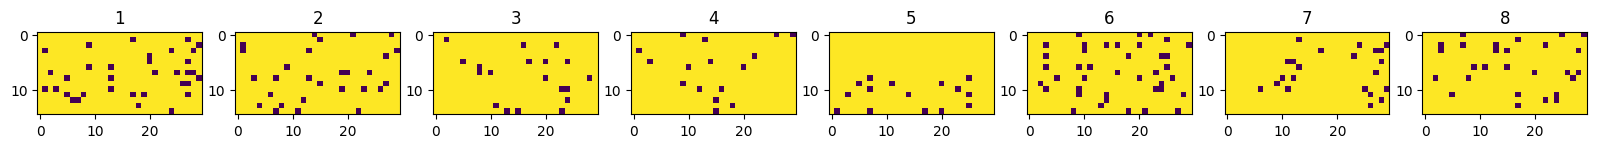

Num timesteps: 1096000
Best mean reward: -43188767.30 - Last mean reward per episode: -52459102.75


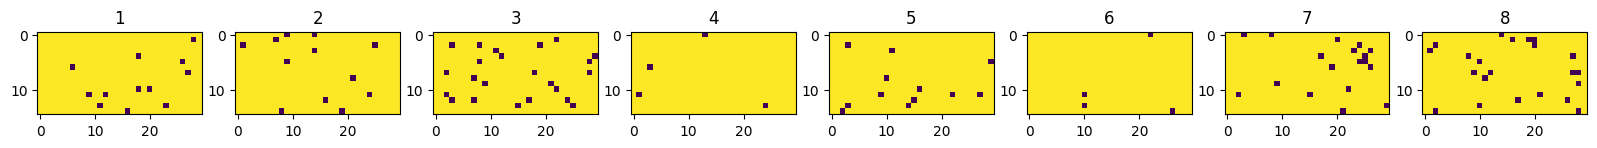

Num timesteps: 1104000
Best mean reward: -43188767.30 - Last mean reward per episode: -54962081.98


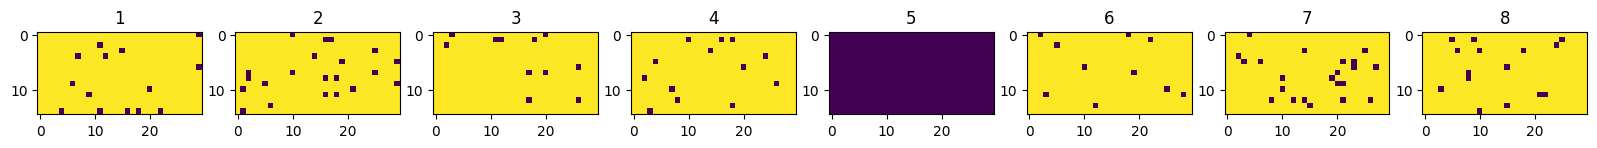

Num timesteps: 1112000
Best mean reward: -43188767.30 - Last mean reward per episode: -56472169.12


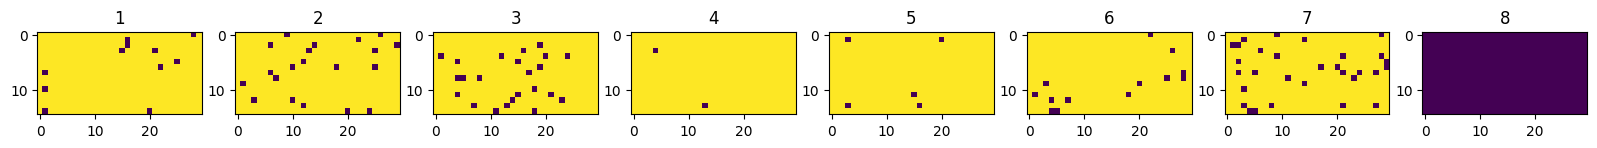

Num timesteps: 1120000
Best mean reward: -43188767.30 - Last mean reward per episode: -49820220.14


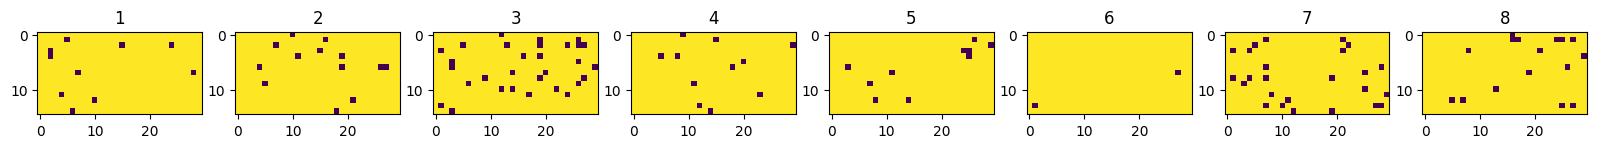

Num timesteps: 1128000
Best mean reward: -43188767.30 - Last mean reward per episode: -48071228.20


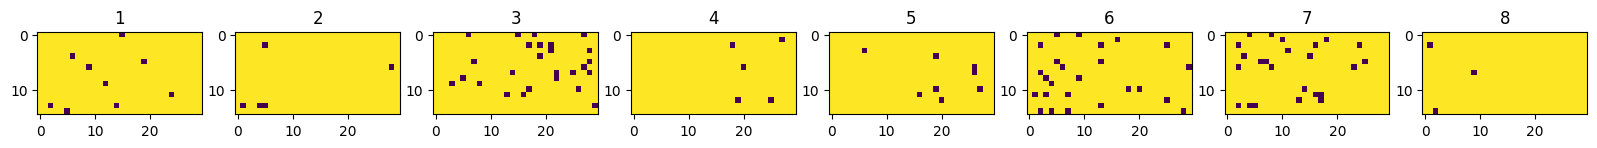

Num timesteps: 1136000
Best mean reward: -43188767.30 - Last mean reward per episode: -55033016.62


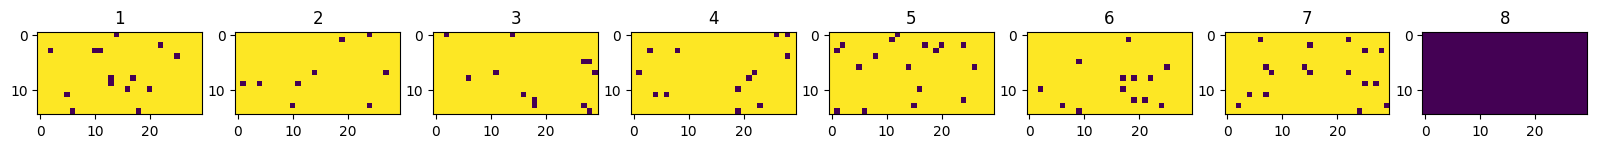

Num timesteps: 1144000
Best mean reward: -43188767.30 - Last mean reward per episode: -55265427.69


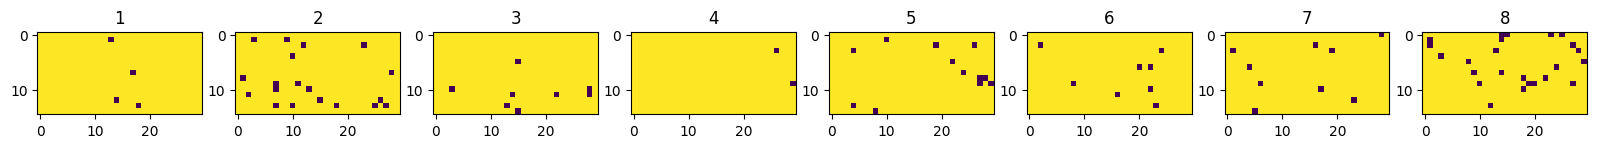

Num timesteps: 1152000
Best mean reward: -43188767.30 - Last mean reward per episode: -63481033.49


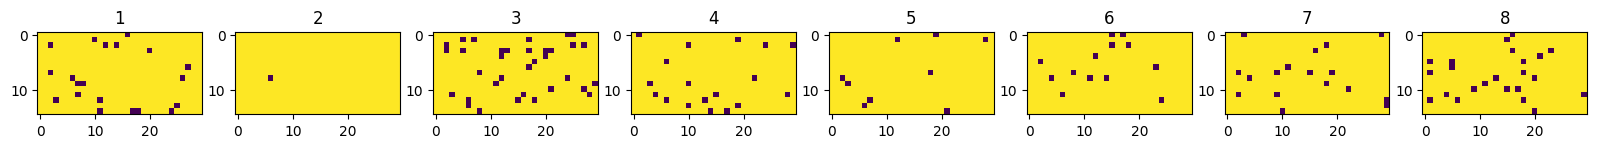

Num timesteps: 1160000
Best mean reward: -43188767.30 - Last mean reward per episode: -62760911.38


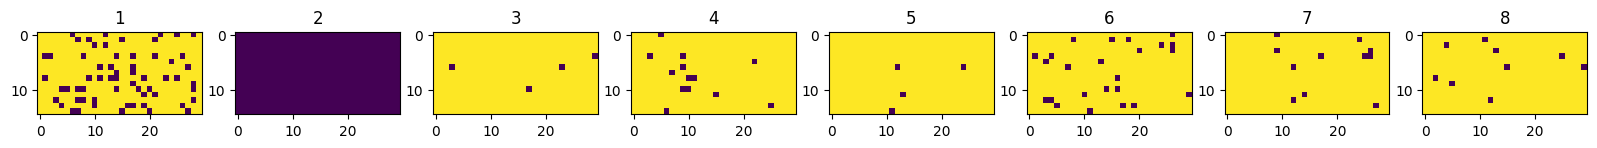

Num timesteps: 1168000
Best mean reward: -43188767.30 - Last mean reward per episode: -55077477.95


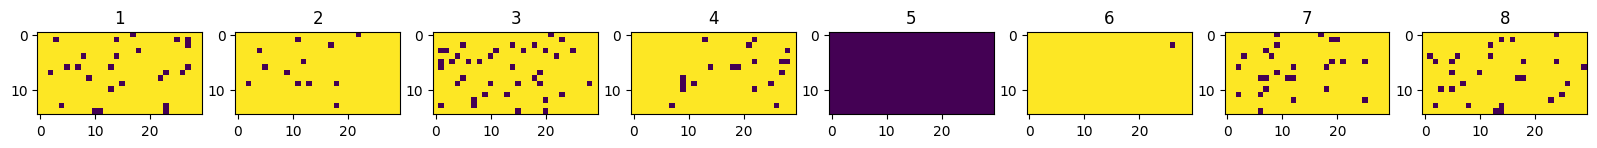

Num timesteps: 1176000
Best mean reward: -43188767.30 - Last mean reward per episode: -52628934.90


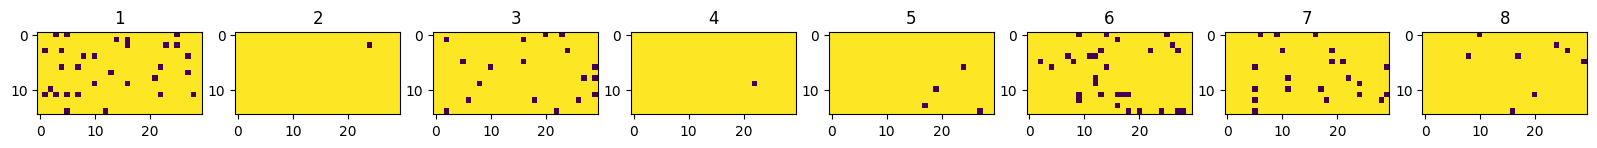

Num timesteps: 1184000
Best mean reward: -43188767.30 - Last mean reward per episode: -61100612.14


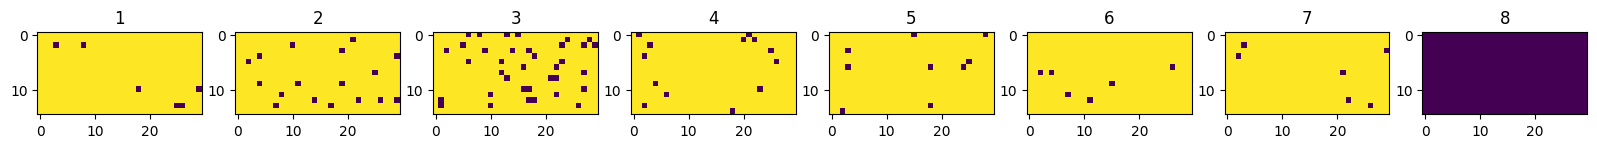

Num timesteps: 1192000
Best mean reward: -43188767.30 - Last mean reward per episode: -57319238.79


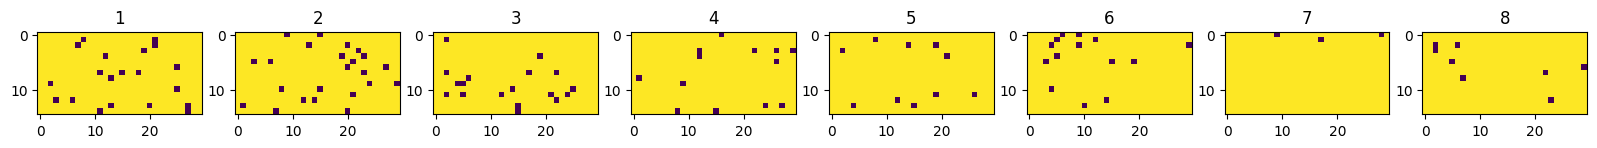

Num timesteps: 1200000
Best mean reward: -43188767.30 - Last mean reward per episode: -52968182.93


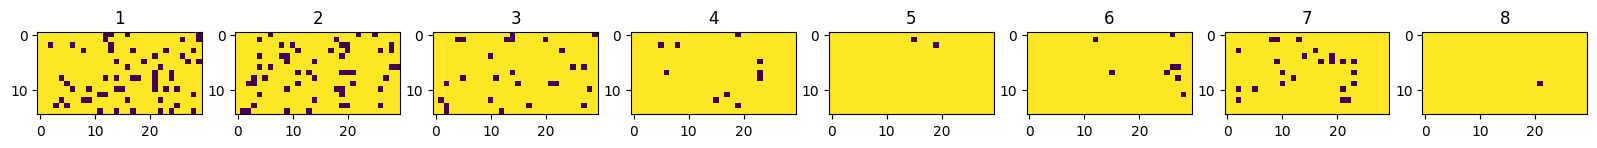

Num timesteps: 1208000
Best mean reward: -43188767.30 - Last mean reward per episode: -51828611.77


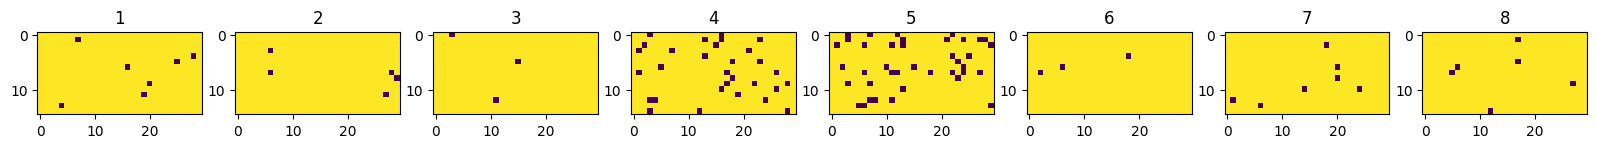

Num timesteps: 1216000
Best mean reward: -43188767.30 - Last mean reward per episode: -56701175.91


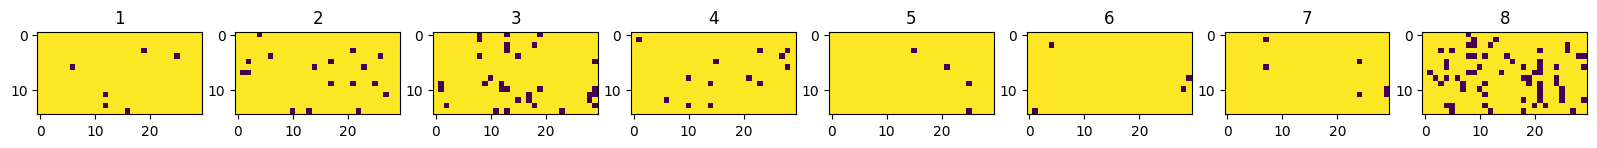

Num timesteps: 1224000
Best mean reward: -43188767.30 - Last mean reward per episode: -74259248.14


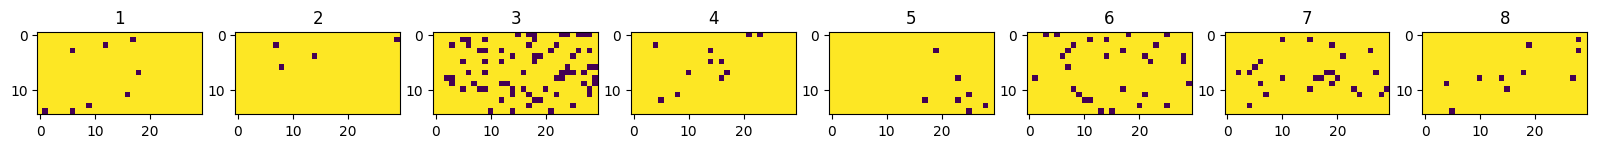

Num timesteps: 1232000
Best mean reward: -43188767.30 - Last mean reward per episode: -59212942.00


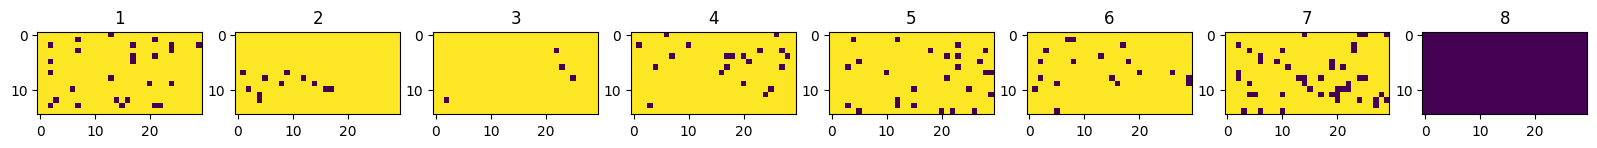

Num timesteps: 1240000
Best mean reward: -43188767.30 - Last mean reward per episode: -53188712.88


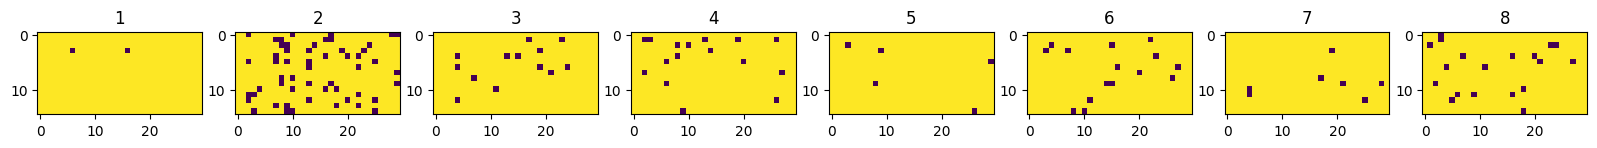

Num timesteps: 1248000
Best mean reward: -43188767.30 - Last mean reward per episode: -66644034.21


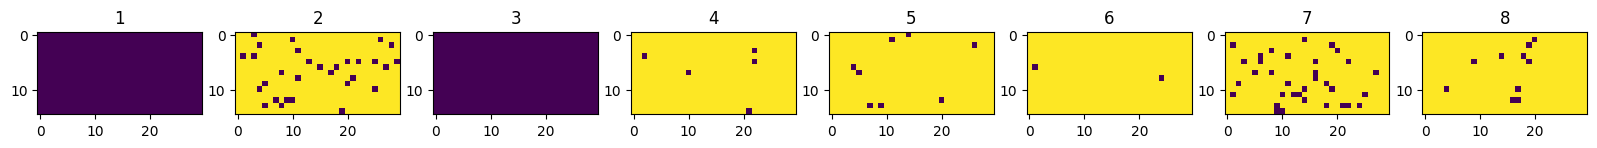

Num timesteps: 1256000
Best mean reward: -43188767.30 - Last mean reward per episode: -66077682.58


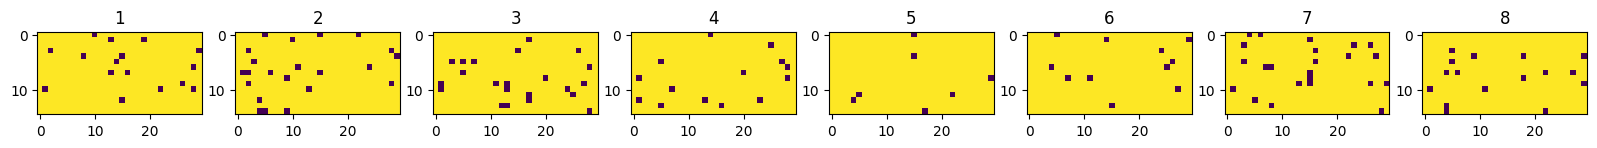

Num timesteps: 1264000
Best mean reward: -43188767.30 - Last mean reward per episode: -58011458.17


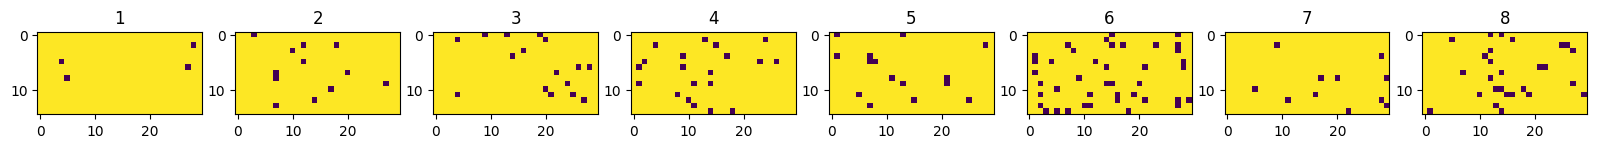

Num timesteps: 1272000
Best mean reward: -43188767.30 - Last mean reward per episode: -56567244.76


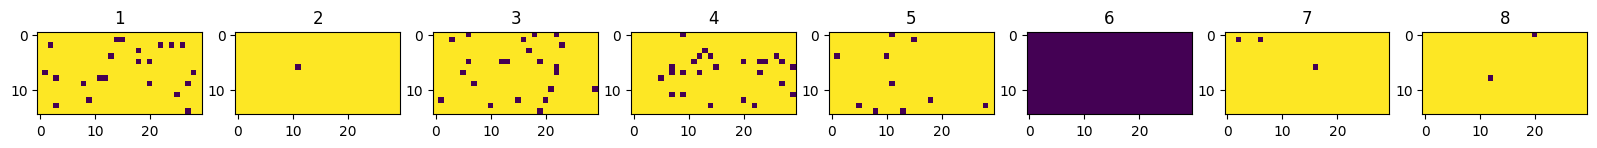

Num timesteps: 1280000
Best mean reward: -43188767.30 - Last mean reward per episode: -62039789.89


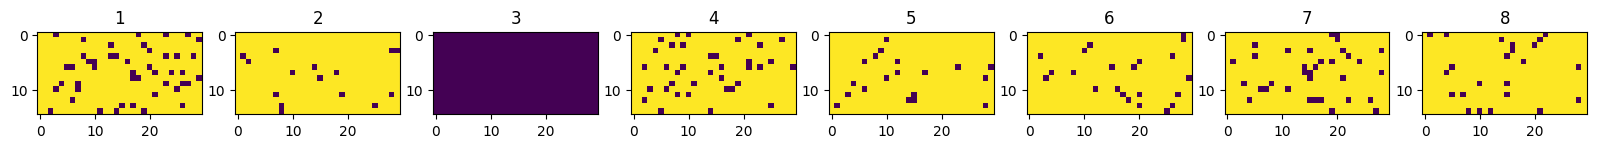

Num timesteps: 1288000
Best mean reward: -43188767.30 - Last mean reward per episode: -55363784.18


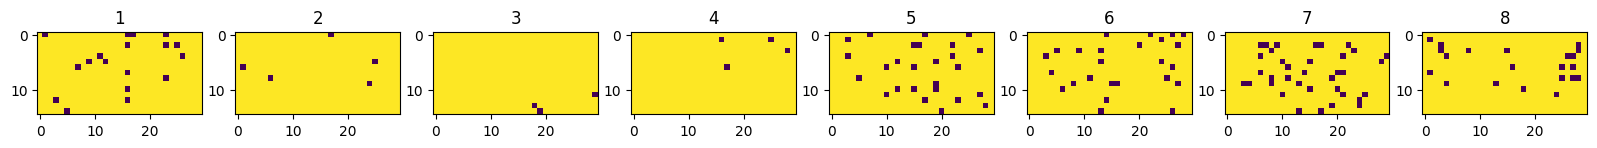

Num timesteps: 1296000
Best mean reward: -43188767.30 - Last mean reward per episode: -58585914.34


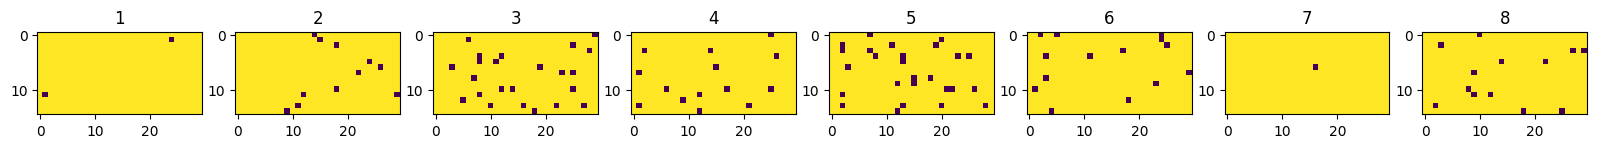

Num timesteps: 1304000
Best mean reward: -43188767.30 - Last mean reward per episode: -56101118.59


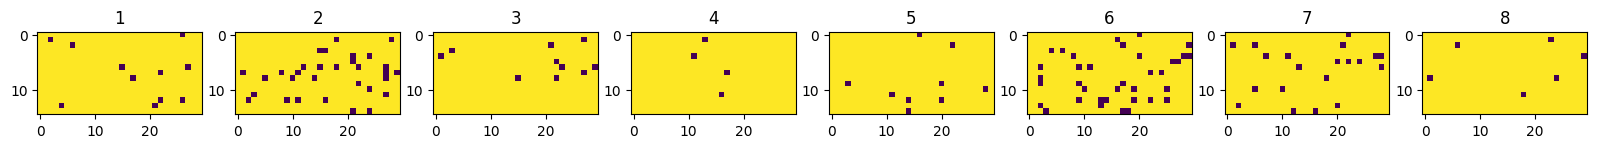

Num timesteps: 1312000
Best mean reward: -43188767.30 - Last mean reward per episode: -52810547.16


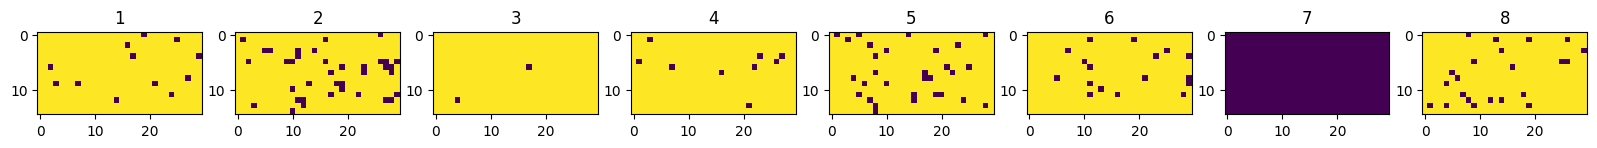

Num timesteps: 1320000
Best mean reward: -43188767.30 - Last mean reward per episode: -61728952.75


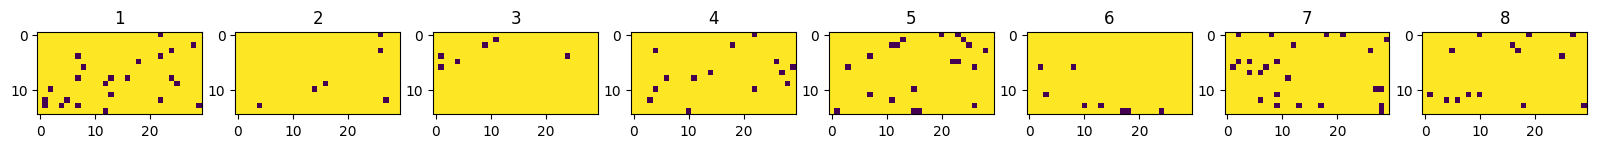

Num timesteps: 1328000
Best mean reward: -43188767.30 - Last mean reward per episode: -55728176.34


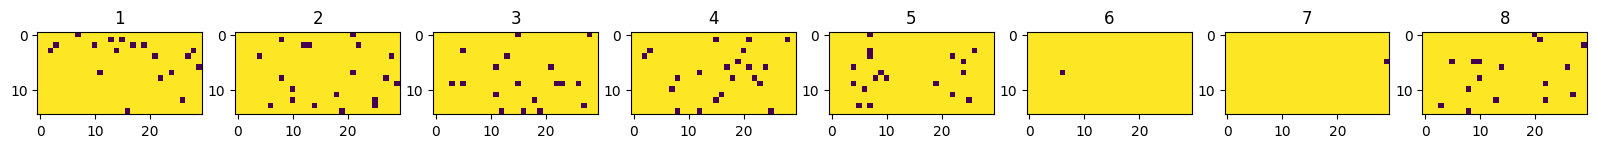

Num timesteps: 1336000
Best mean reward: -43188767.30 - Last mean reward per episode: -55570097.63


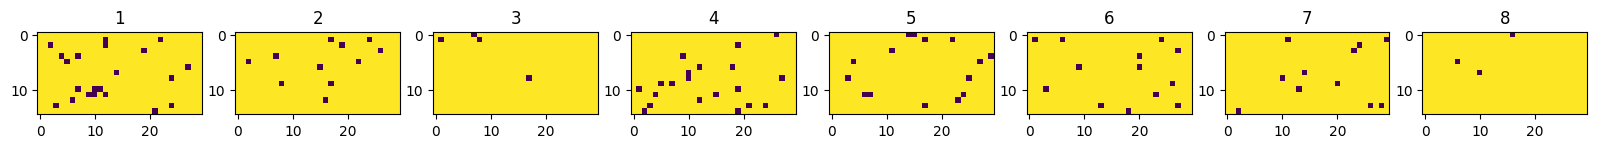

Num timesteps: 1344000
Best mean reward: -43188767.30 - Last mean reward per episode: -60551009.28


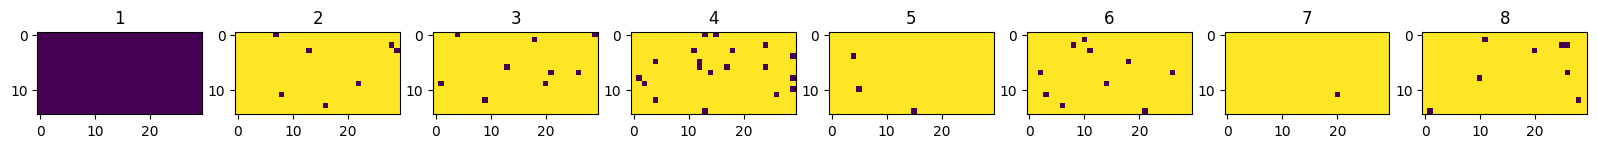

Num timesteps: 1352000
Best mean reward: -43188767.30 - Last mean reward per episode: -51767325.22


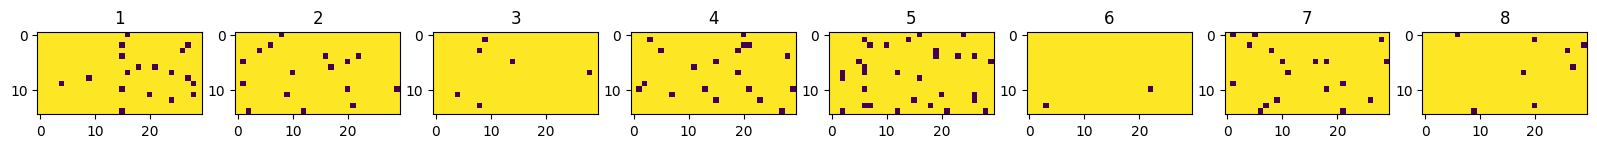

Num timesteps: 1360000
Best mean reward: -43188767.30 - Last mean reward per episode: -53927036.20


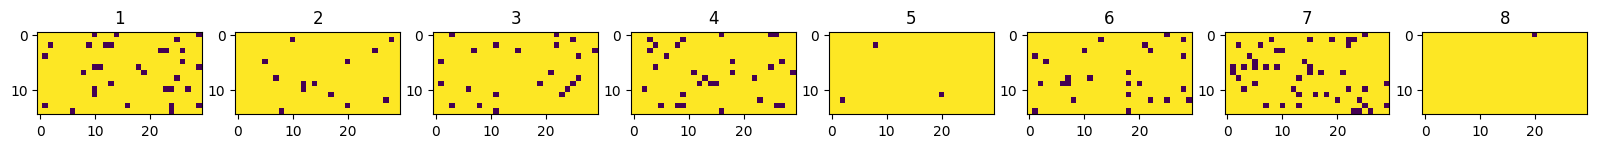

Num timesteps: 1368000
Best mean reward: -43188767.30 - Last mean reward per episode: -56392401.80


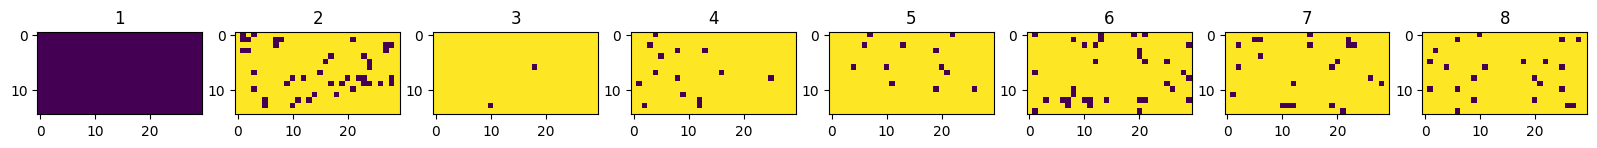

Num timesteps: 1376000
Best mean reward: -43188767.30 - Last mean reward per episode: -67131961.03


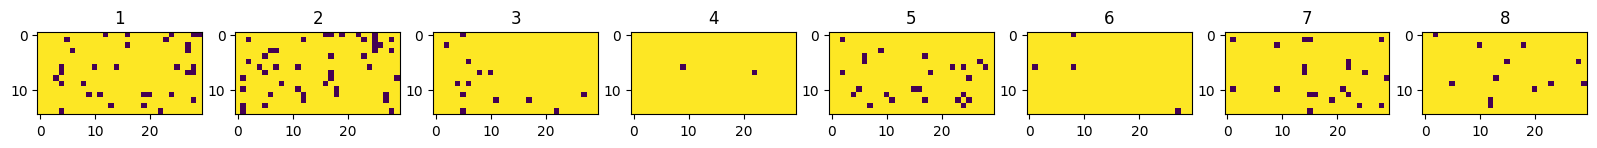

Num timesteps: 1384000
Best mean reward: -43188767.30 - Last mean reward per episode: -61588363.97


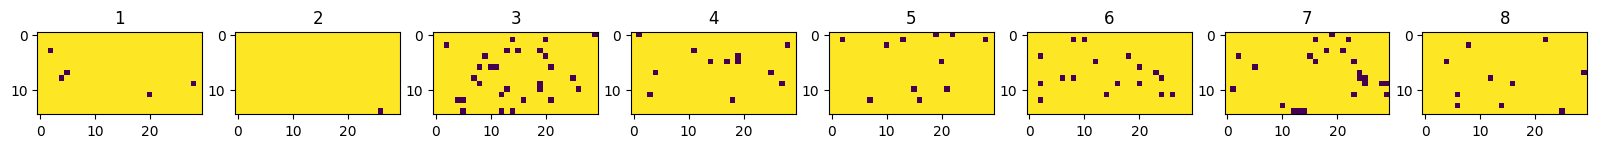

Num timesteps: 1392000
Best mean reward: -43188767.30 - Last mean reward per episode: -64964306.99


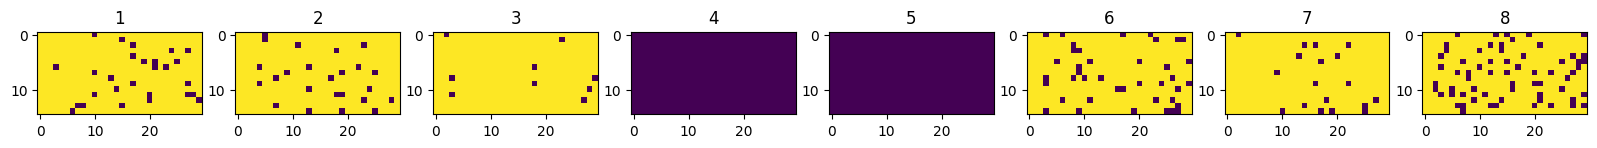

Num timesteps: 1400000
Best mean reward: -43188767.30 - Last mean reward per episode: -65919071.84


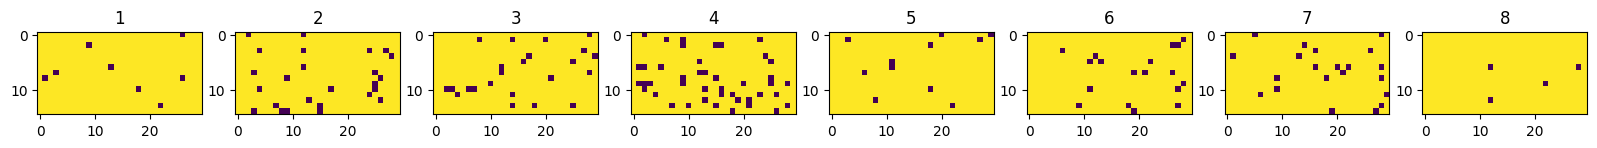

Num timesteps: 1408000
Best mean reward: -43188767.30 - Last mean reward per episode: -57507376.73


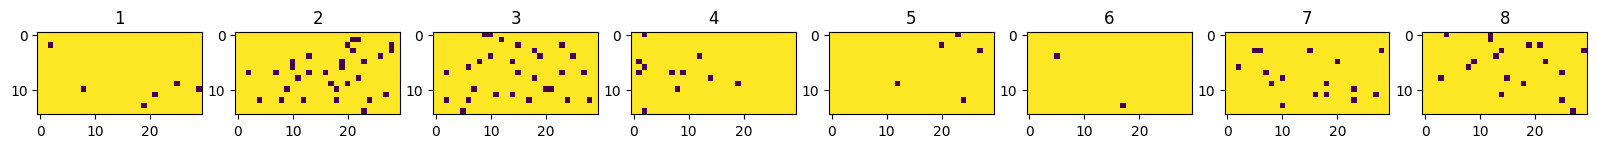

Num timesteps: 1416000
Best mean reward: -43188767.30 - Last mean reward per episode: -55085687.21


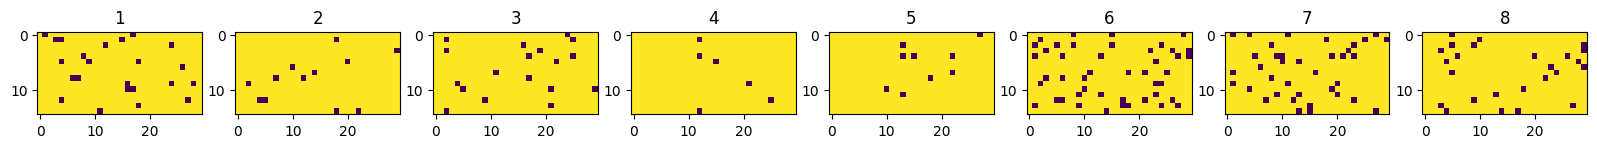

Num timesteps: 1424000
Best mean reward: -43188767.30 - Last mean reward per episode: -54117089.28


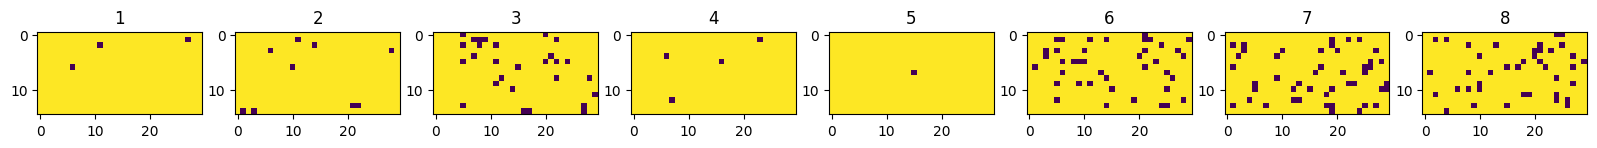

Num timesteps: 1432000
Best mean reward: -43188767.30 - Last mean reward per episode: -55248980.22


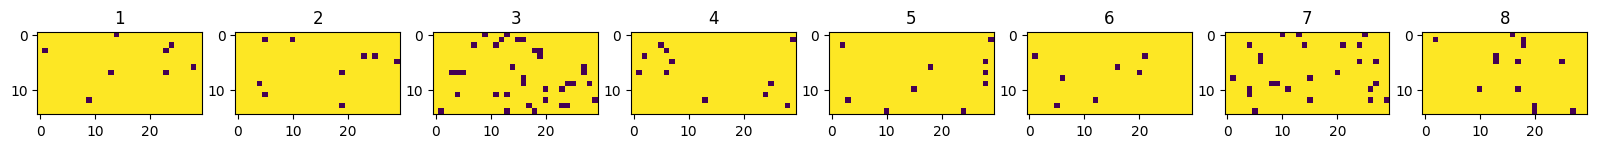

Num timesteps: 1440000
Best mean reward: -43188767.30 - Last mean reward per episode: -63766676.95


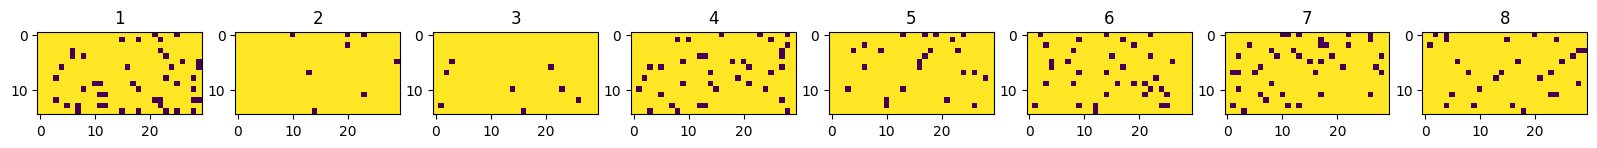

Num timesteps: 1448000
Best mean reward: -43188767.30 - Last mean reward per episode: -58667761.16


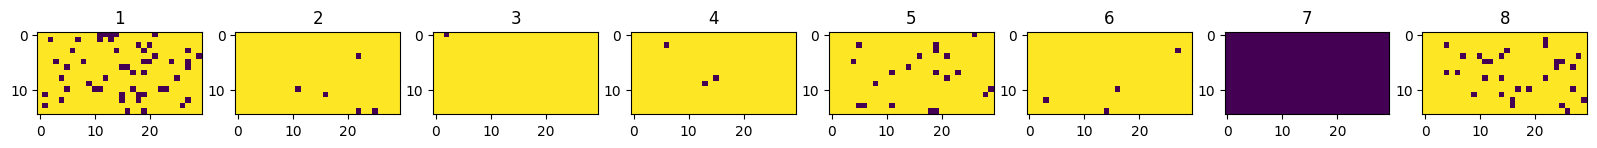

Num timesteps: 1456000
Best mean reward: -43188767.30 - Last mean reward per episode: -55234064.50


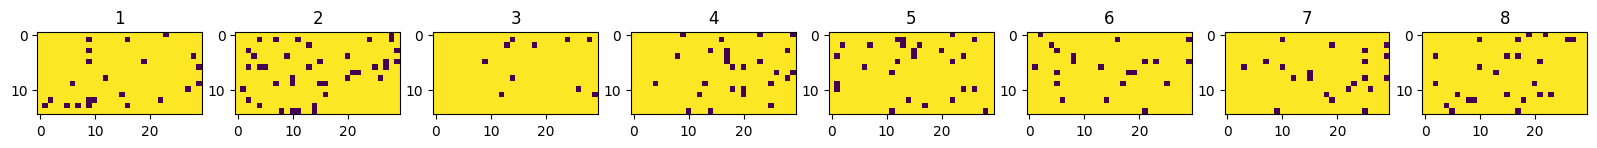

Num timesteps: 1464000
Best mean reward: -43188767.30 - Last mean reward per episode: -61206138.26


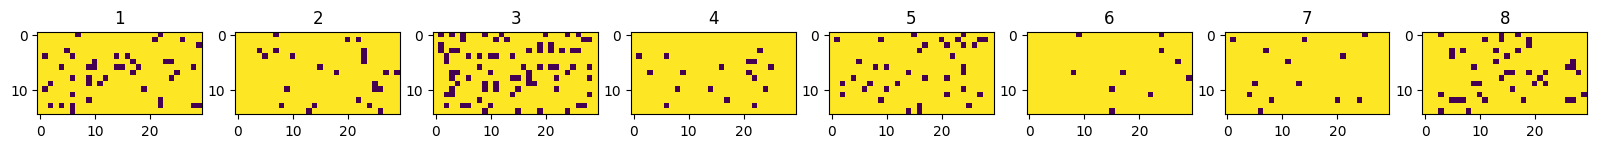

Num timesteps: 1472000
Best mean reward: -43188767.30 - Last mean reward per episode: -67212063.60


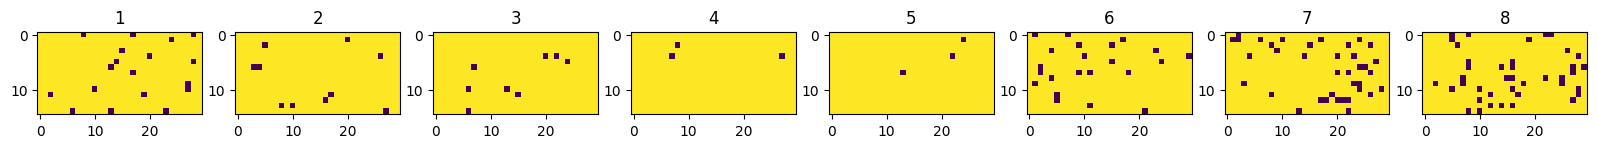

Num timesteps: 1480000
Best mean reward: -43188767.30 - Last mean reward per episode: -52172912.23


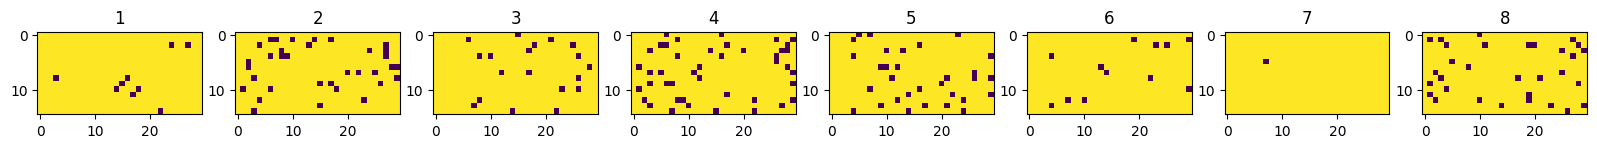

Num timesteps: 1488000
Best mean reward: -43188767.30 - Last mean reward per episode: -59910653.19


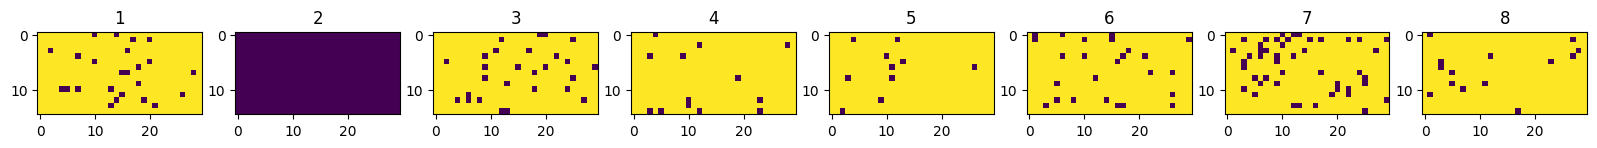

Num timesteps: 1496000
Best mean reward: -43188767.30 - Last mean reward per episode: -52145433.35


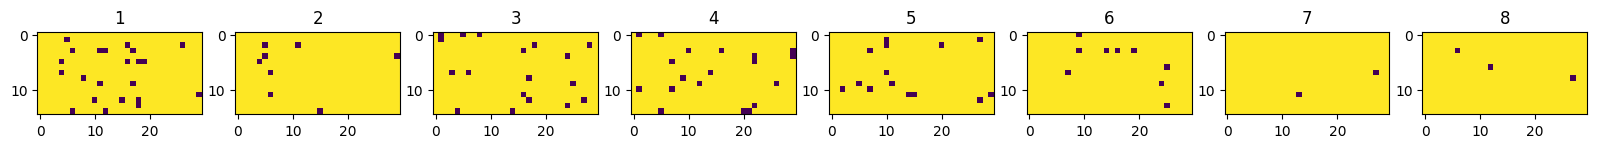

Num timesteps: 1504000
Best mean reward: -43188767.30 - Last mean reward per episode: -66763041.91


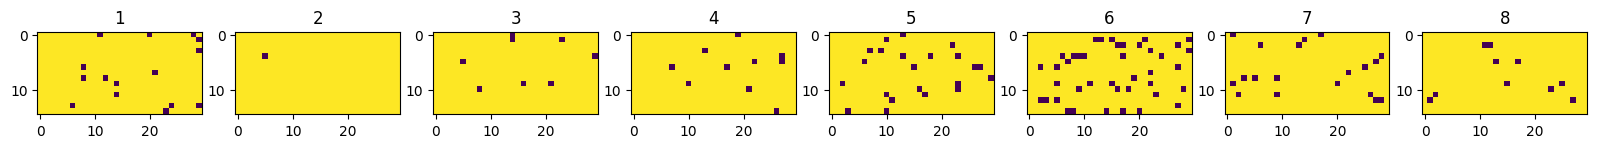

Num timesteps: 1512000
Best mean reward: -43188767.30 - Last mean reward per episode: -57637878.79


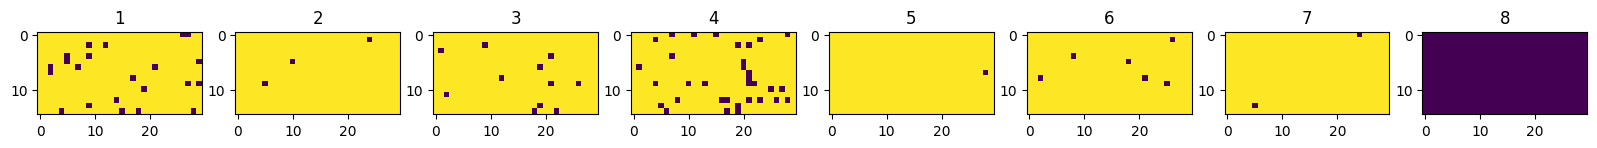

Num timesteps: 1520000
Best mean reward: -43188767.30 - Last mean reward per episode: -69264507.01


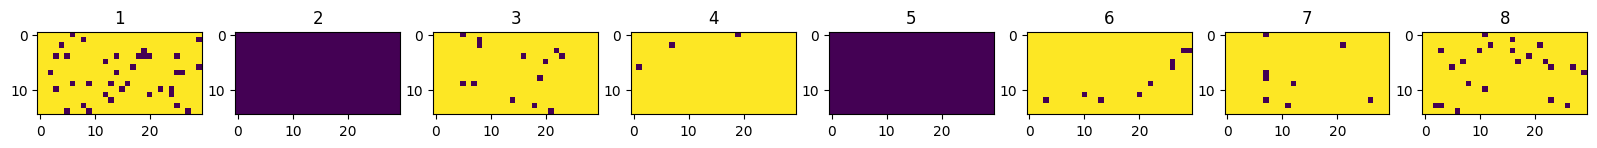

Num timesteps: 1528000
Best mean reward: -43188767.30 - Last mean reward per episode: -64835597.28


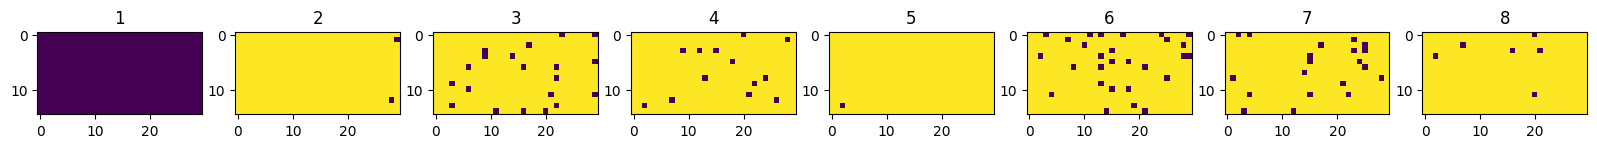

Num timesteps: 1536000
Best mean reward: -43188767.30 - Last mean reward per episode: -58838216.31


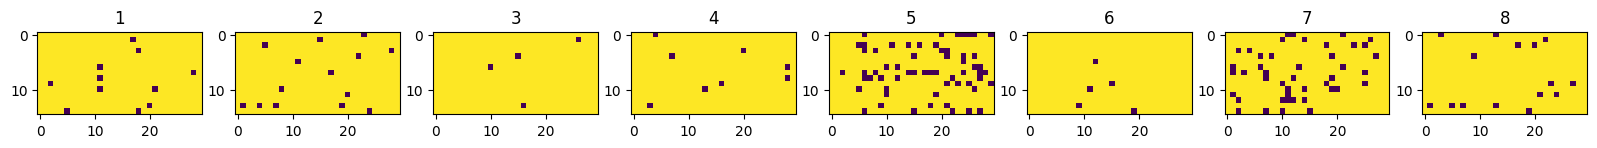

Num timesteps: 1544000
Best mean reward: -43188767.30 - Last mean reward per episode: -49178659.41


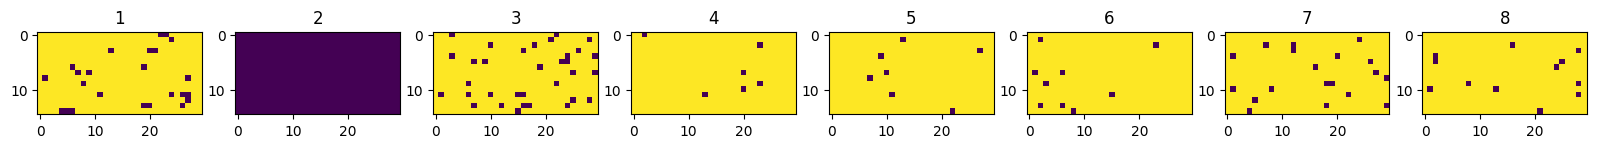

Num timesteps: 1552000
Best mean reward: -43188767.30 - Last mean reward per episode: -61697281.03


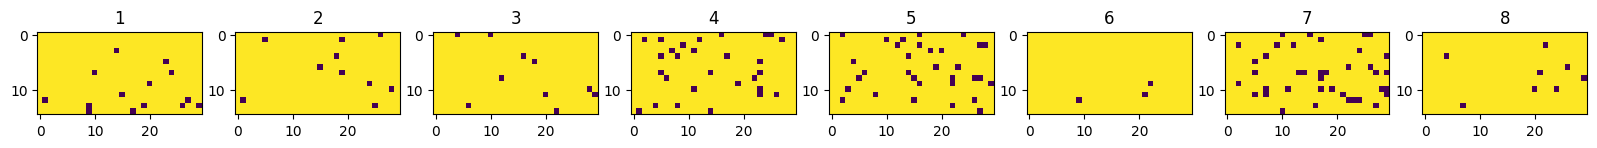

Num timesteps: 1560000
Best mean reward: -43188767.30 - Last mean reward per episode: -58228876.93


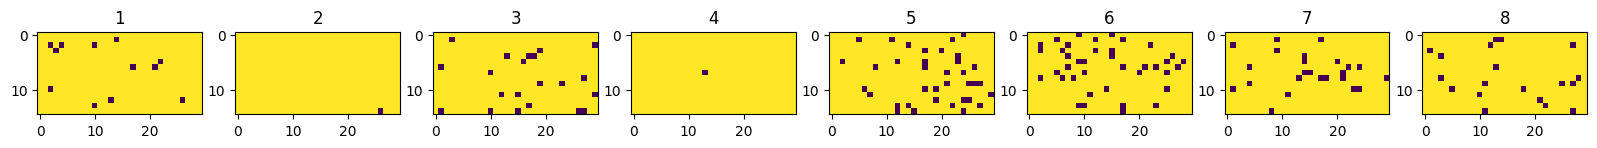

Num timesteps: 1568000
Best mean reward: -43188767.30 - Last mean reward per episode: -53619040.33


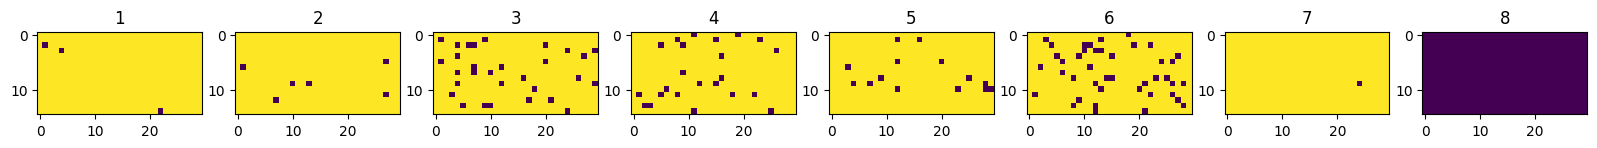

Num timesteps: 1576000
Best mean reward: -43188767.30 - Last mean reward per episode: -66754033.61


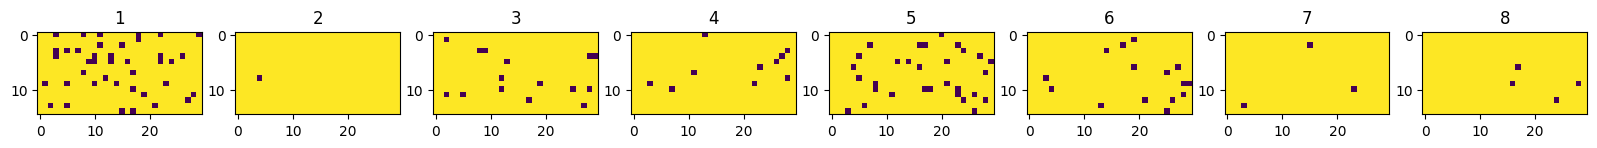

Num timesteps: 1584000
Best mean reward: -43188767.30 - Last mean reward per episode: -68009899.11


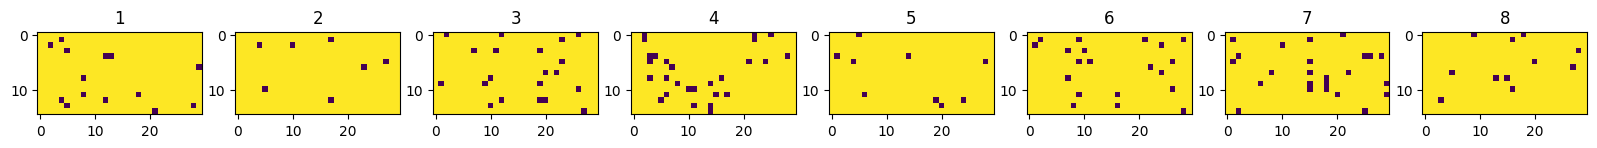

Num timesteps: 1592000
Best mean reward: -43188767.30 - Last mean reward per episode: -45126886.71


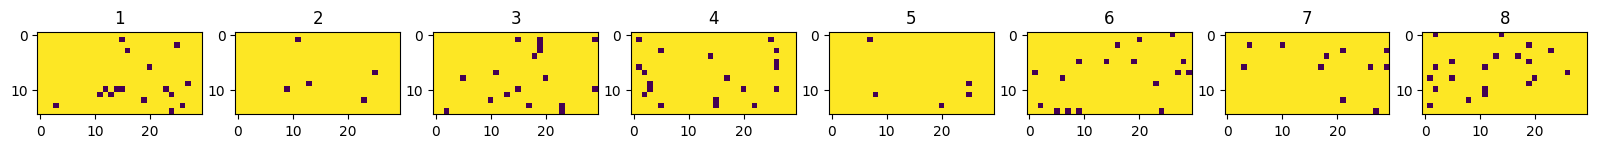

Num timesteps: 1600000
Best mean reward: -43188767.30 - Last mean reward per episode: -62492950.06


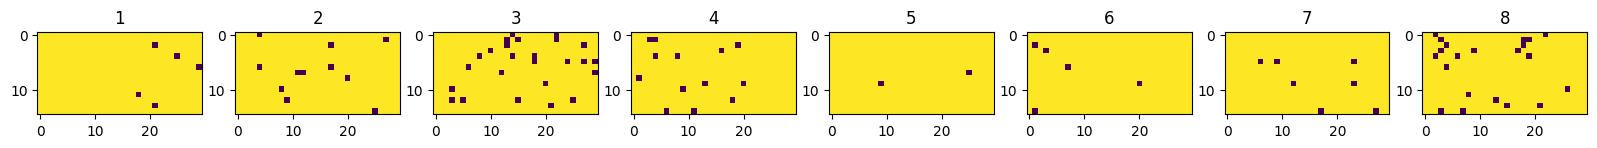

Num timesteps: 1608000
Best mean reward: -43188767.30 - Last mean reward per episode: -60094291.95


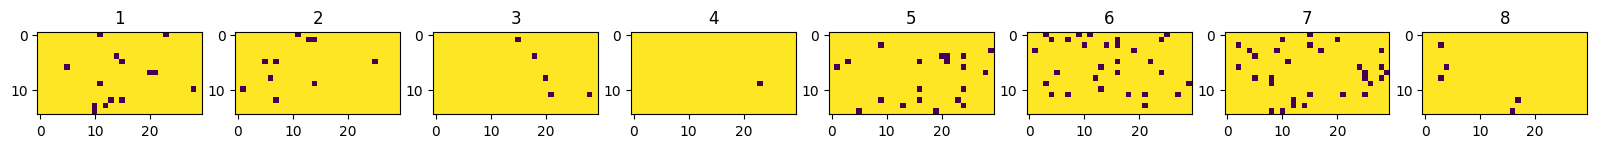

Num timesteps: 1616000
Best mean reward: -43188767.30 - Last mean reward per episode: -49269126.09


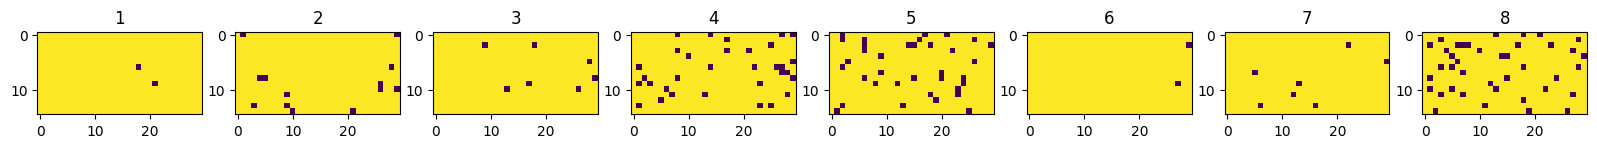

Num timesteps: 1624000
Best mean reward: -43188767.30 - Last mean reward per episode: -56117075.31


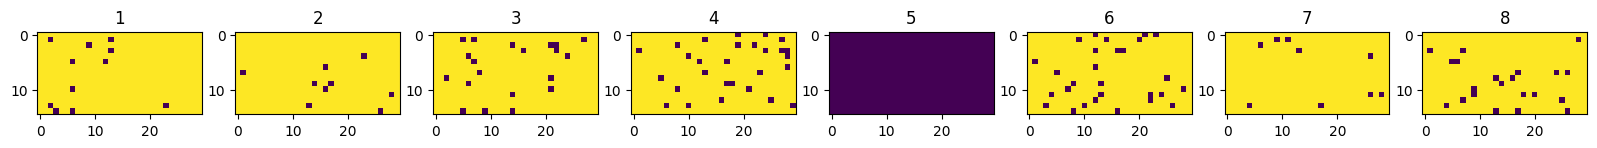

Num timesteps: 1632000
Best mean reward: -43188767.30 - Last mean reward per episode: -52294716.23


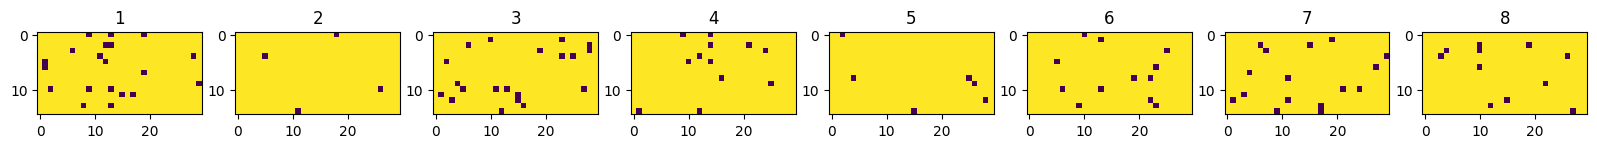

Num timesteps: 1640000
Best mean reward: -43188767.30 - Last mean reward per episode: -58170943.38


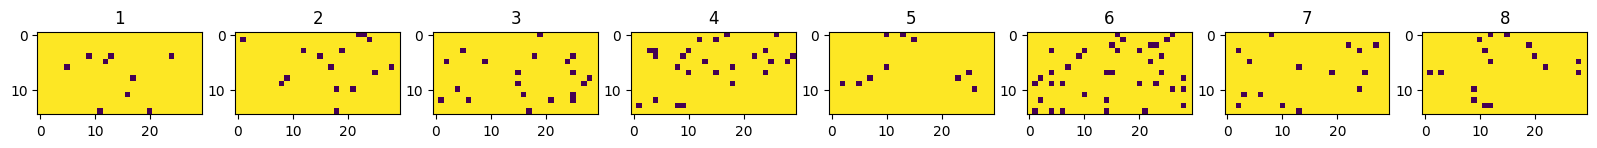

Num timesteps: 1648000
Best mean reward: -43188767.30 - Last mean reward per episode: -56632364.18


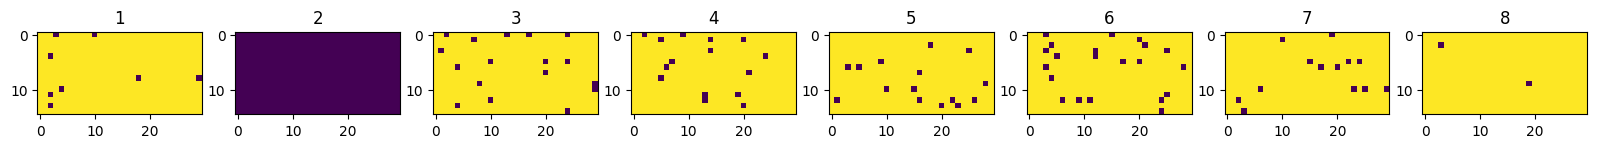

Num timesteps: 1656000
Best mean reward: -43188767.30 - Last mean reward per episode: -59832625.92


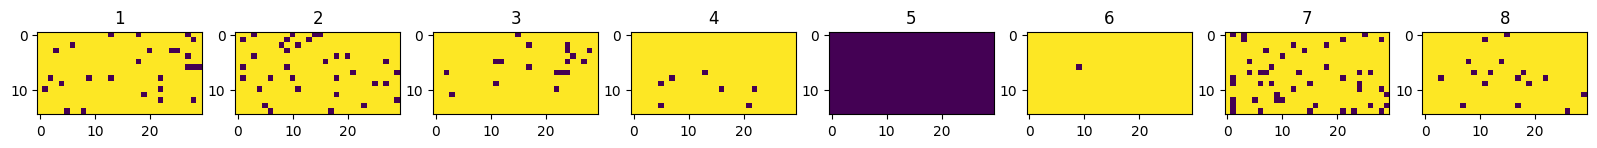

Num timesteps: 1664000
Best mean reward: -43188767.30 - Last mean reward per episode: -59552624.85


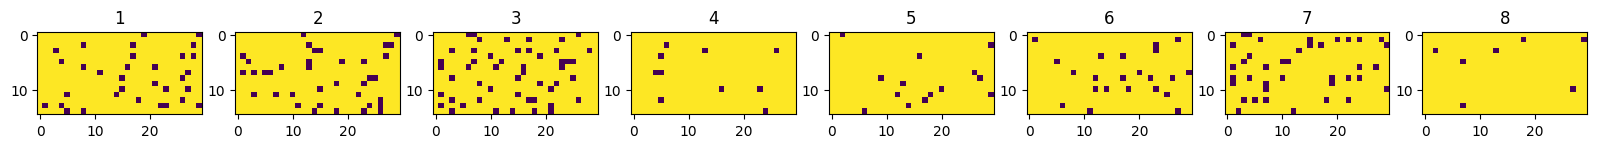

Num timesteps: 1672000
Best mean reward: -43188767.30 - Last mean reward per episode: -58308414.82


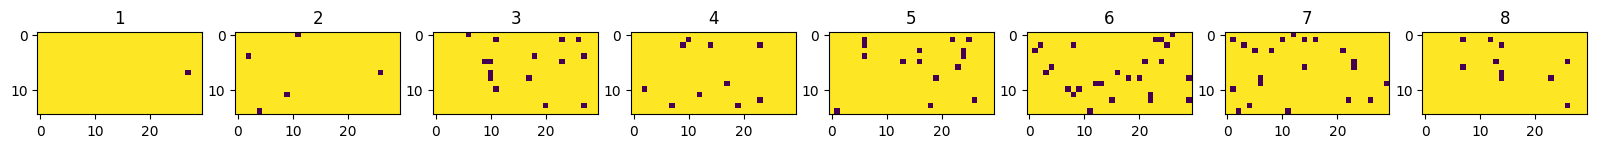

Num timesteps: 1680000
Best mean reward: -43188767.30 - Last mean reward per episode: -53912519.17


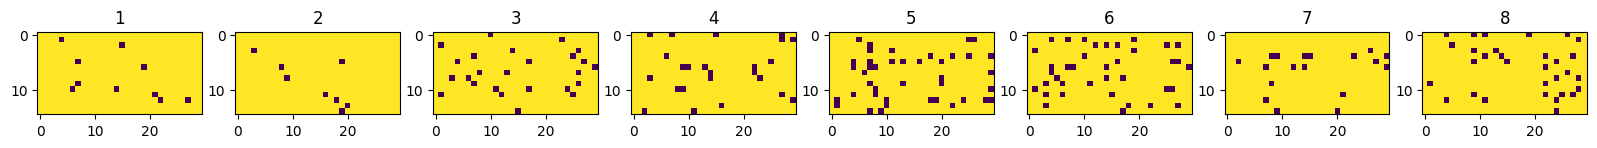

Num timesteps: 1688000
Best mean reward: -43188767.30 - Last mean reward per episode: -58452369.63


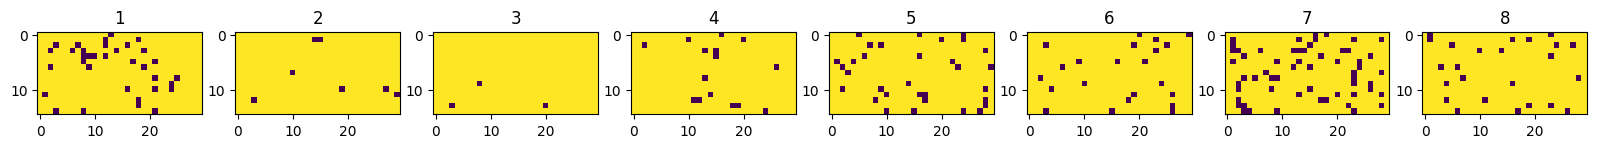

Num timesteps: 1696000
Best mean reward: -43188767.30 - Last mean reward per episode: -48803792.83


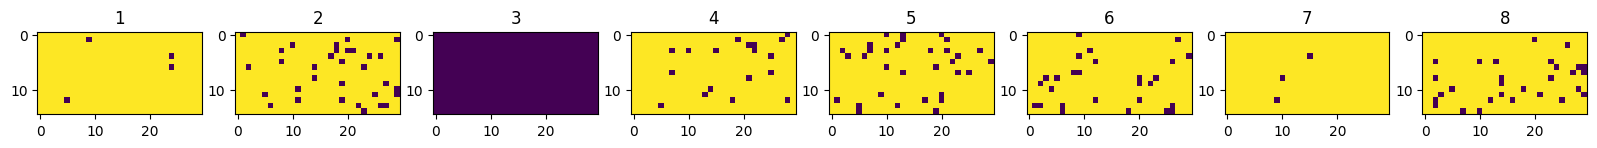

Num timesteps: 1704000
Best mean reward: -43188767.30 - Last mean reward per episode: -50866623.37


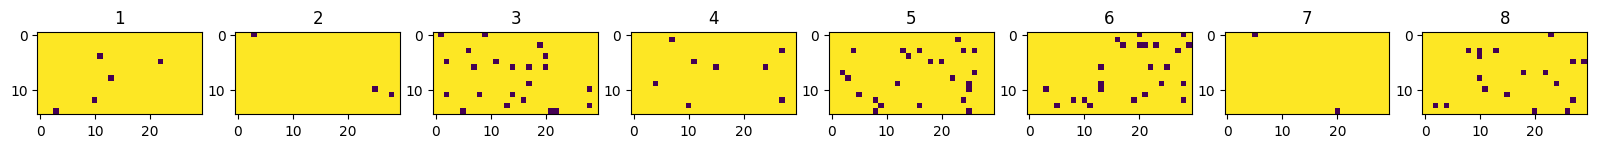

Num timesteps: 1712000
Best mean reward: -43188767.30 - Last mean reward per episode: -55530441.14


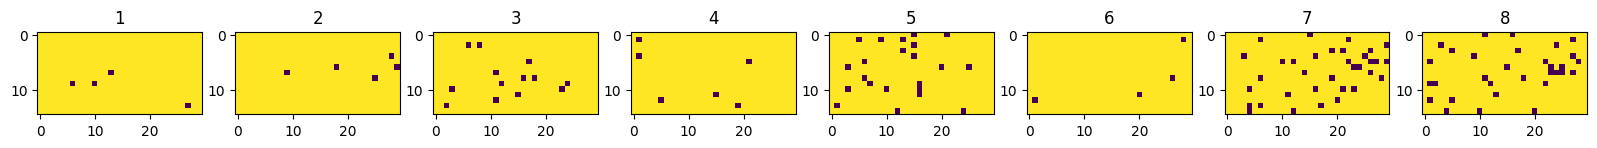

Num timesteps: 1720000
Best mean reward: -43188767.30 - Last mean reward per episode: -66465413.60


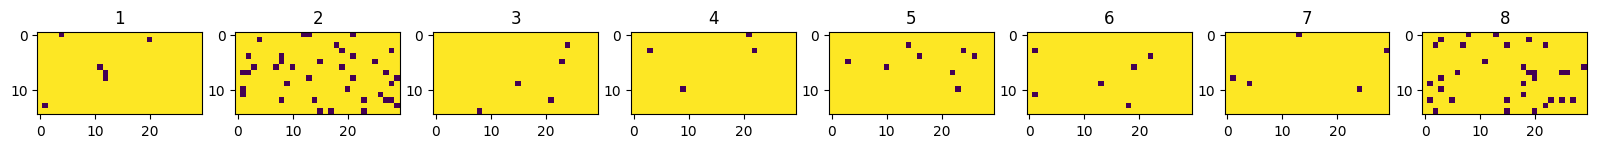

Num timesteps: 1728000
Best mean reward: -43188767.30 - Last mean reward per episode: -53816984.45


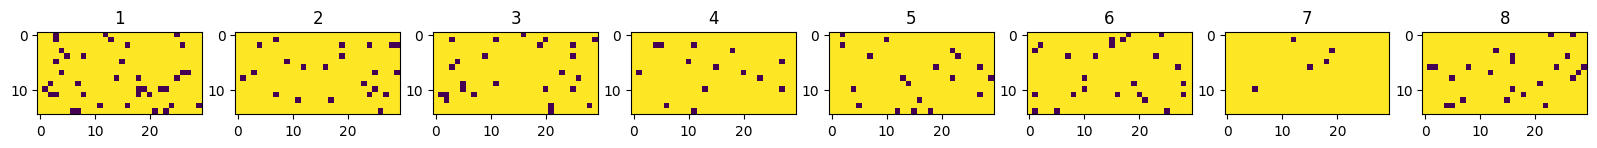

Num timesteps: 1736000
Best mean reward: -43188767.30 - Last mean reward per episode: -64800397.15


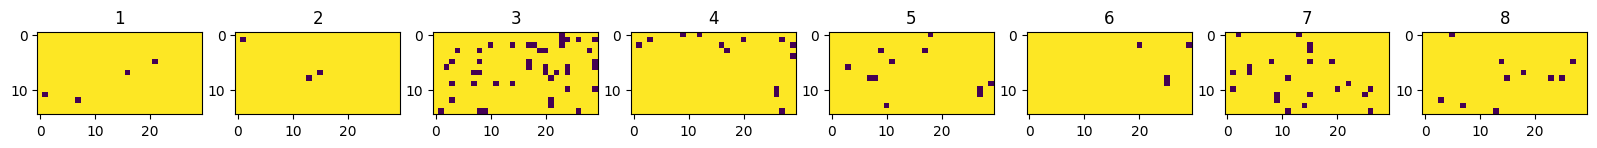

Num timesteps: 1744000
Best mean reward: -43188767.30 - Last mean reward per episode: -59086875.11


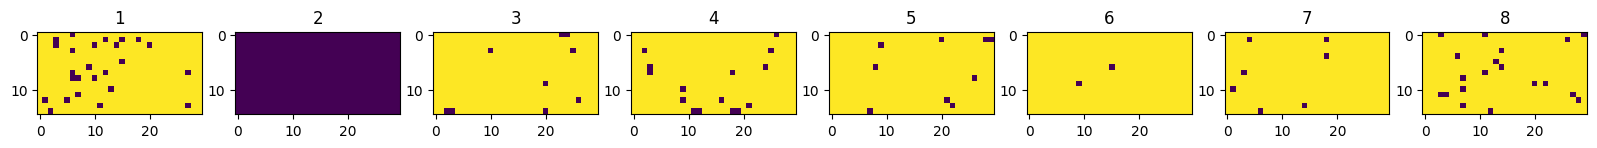

Num timesteps: 1752000
Best mean reward: -43188767.30 - Last mean reward per episode: -60650078.80


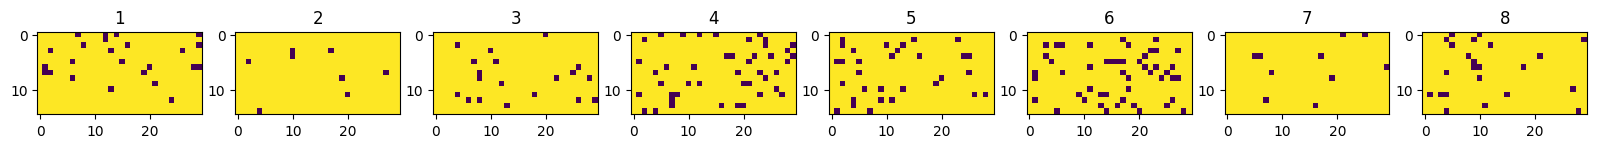

Num timesteps: 1760000
Best mean reward: -43188767.30 - Last mean reward per episode: -61625345.35


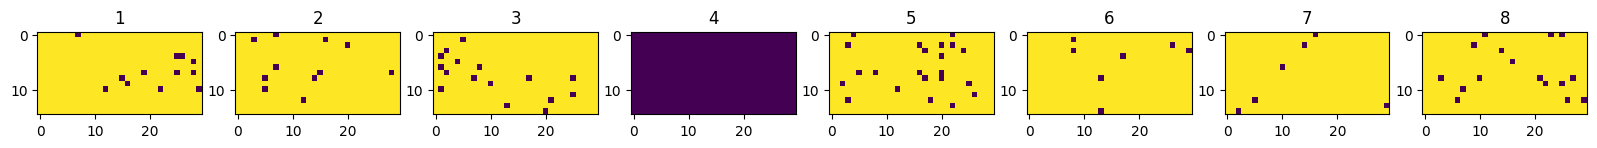

Num timesteps: 1768000
Best mean reward: -43188767.30 - Last mean reward per episode: -64474628.67


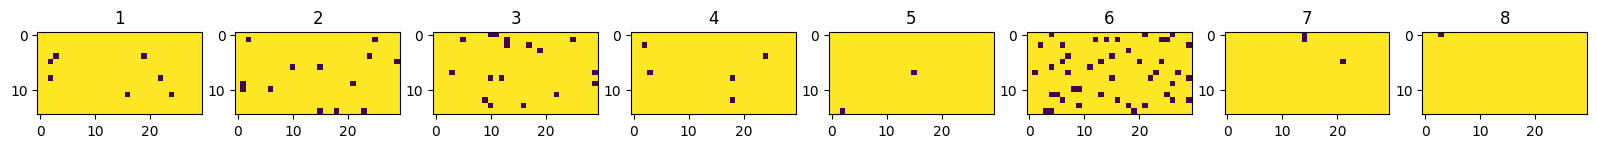

Num timesteps: 1776000
Best mean reward: -43188767.30 - Last mean reward per episode: -65294813.51


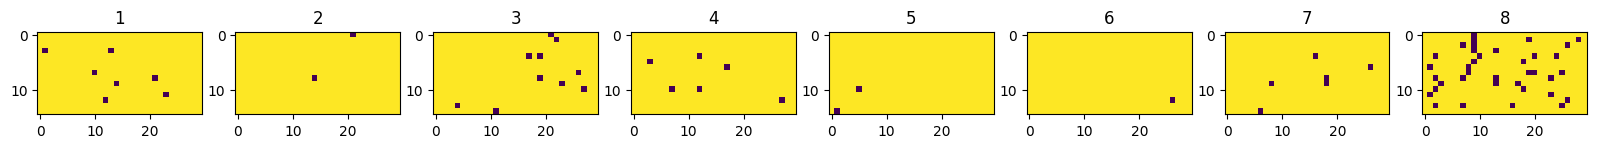

Num timesteps: 1784000
Best mean reward: -43188767.30 - Last mean reward per episode: -55267375.95


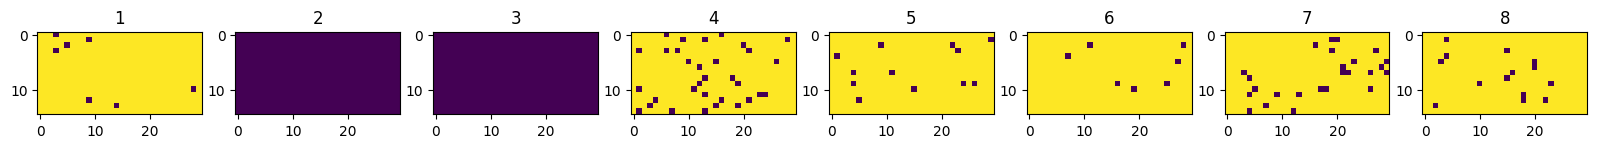

Num timesteps: 1792000
Best mean reward: -43188767.30 - Last mean reward per episode: -59739715.87


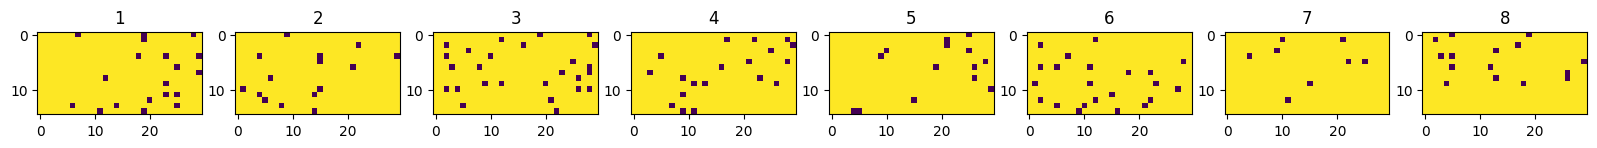

Num timesteps: 1800000
Best mean reward: -43188767.30 - Last mean reward per episode: -58770636.62


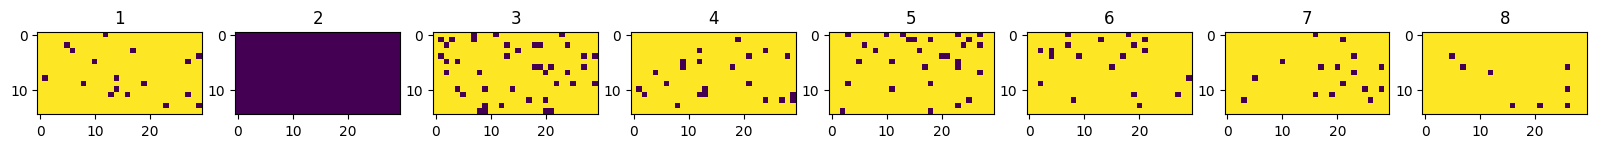

Num timesteps: 1808000
Best mean reward: -43188767.30 - Last mean reward per episode: -54953539.39


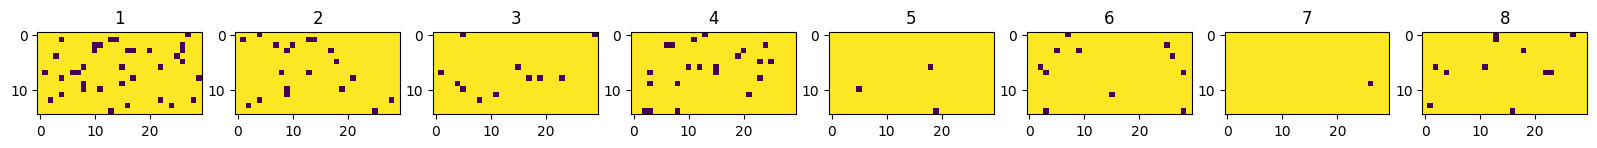

Num timesteps: 1816000
Best mean reward: -43188767.30 - Last mean reward per episode: -60516753.70


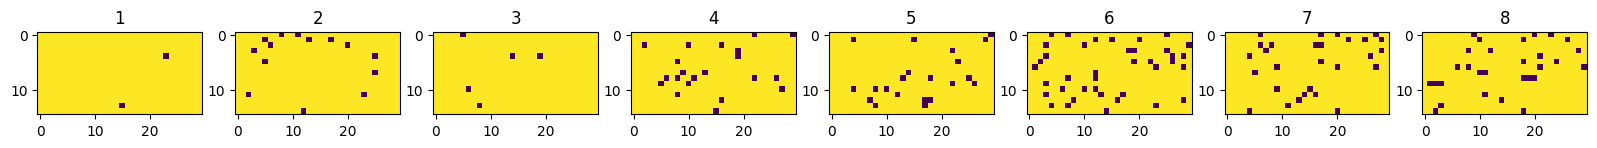

Num timesteps: 1824000
Best mean reward: -43188767.30 - Last mean reward per episode: -59859652.67


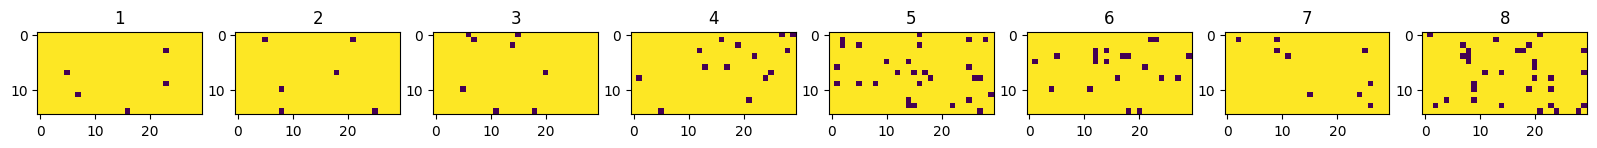

Num timesteps: 1832000
Best mean reward: -43188767.30 - Last mean reward per episode: -58156003.86


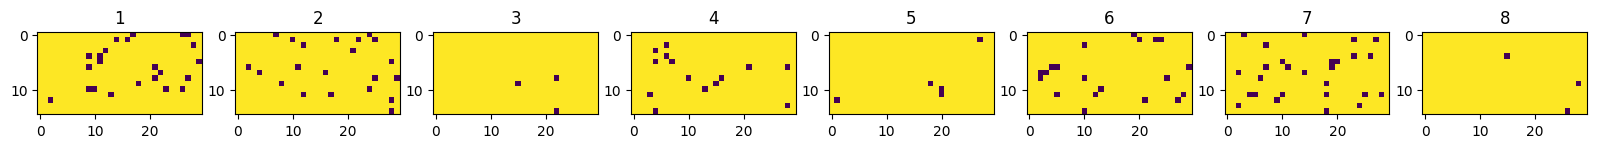

Num timesteps: 1840000
Best mean reward: -43188767.30 - Last mean reward per episode: -61719427.43


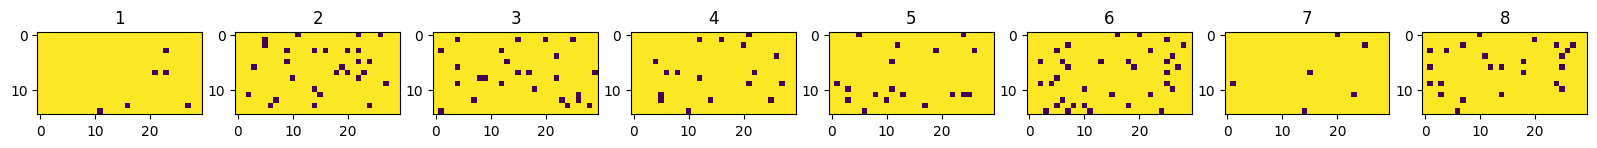

Num timesteps: 1848000
Best mean reward: -43188767.30 - Last mean reward per episode: -50374954.27


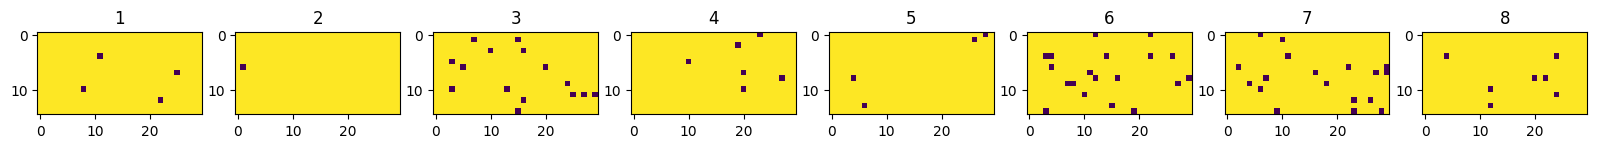

Num timesteps: 1856000
Best mean reward: -43188767.30 - Last mean reward per episode: -56414280.03


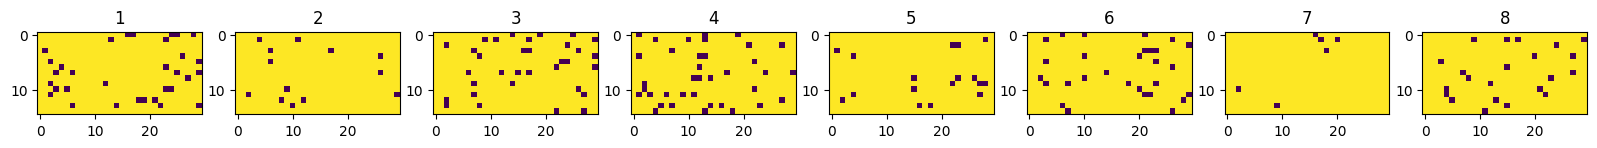

Num timesteps: 1864000
Best mean reward: -43188767.30 - Last mean reward per episode: -55567602.61


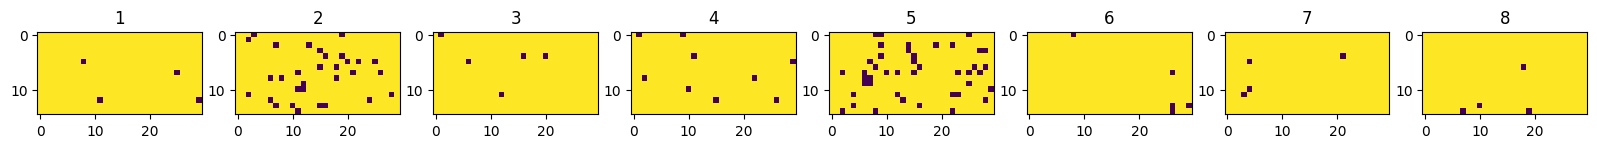

Num timesteps: 1872000
Best mean reward: -43188767.30 - Last mean reward per episode: -52668246.31


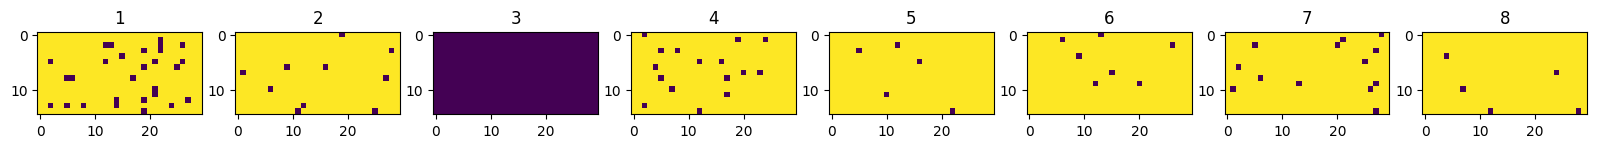

Num timesteps: 1880000
Best mean reward: -43188767.30 - Last mean reward per episode: -54253779.42


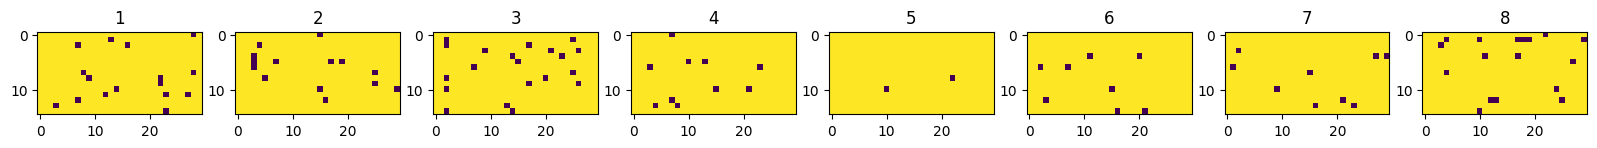

Num timesteps: 1888000
Best mean reward: -43188767.30 - Last mean reward per episode: -59847426.42


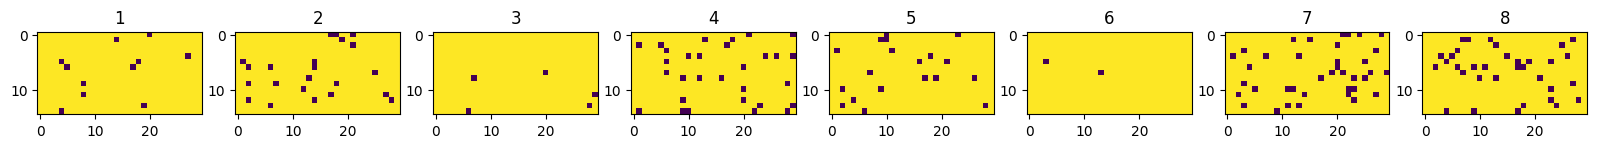

Num timesteps: 1896000
Best mean reward: -43188767.30 - Last mean reward per episode: -56590505.79


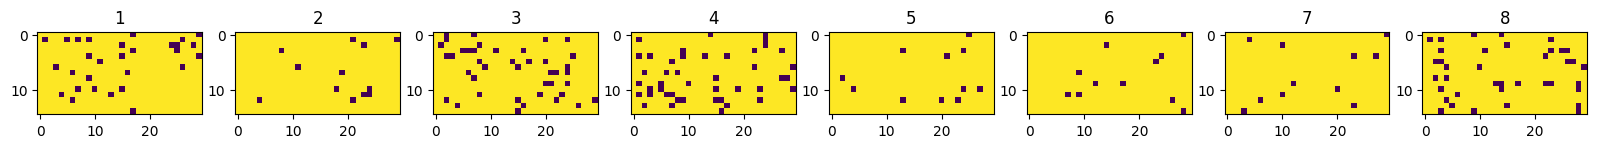

Num timesteps: 1904000
Best mean reward: -43188767.30 - Last mean reward per episode: -60128548.53


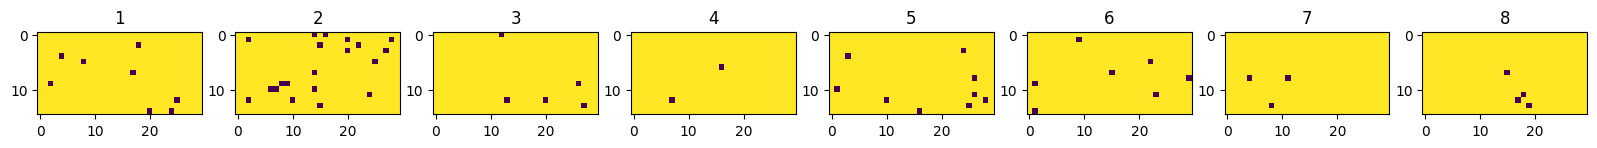

Num timesteps: 1912000
Best mean reward: -43188767.30 - Last mean reward per episode: -51927971.25


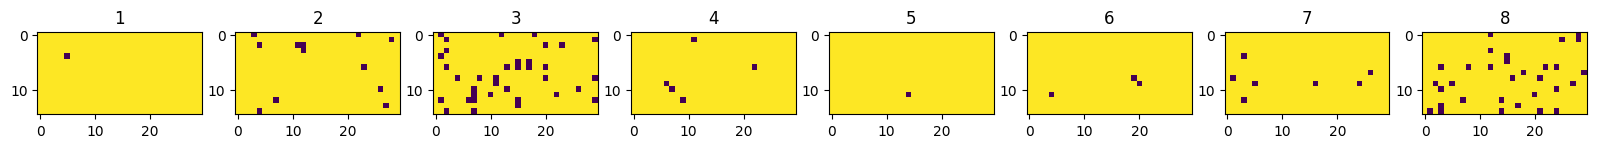

Num timesteps: 1920000
Best mean reward: -43188767.30 - Last mean reward per episode: -56798318.48


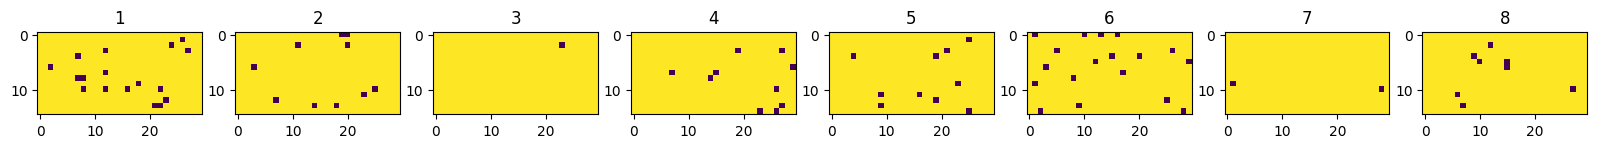

Num timesteps: 1928000
Best mean reward: -43188767.30 - Last mean reward per episode: -54160711.39


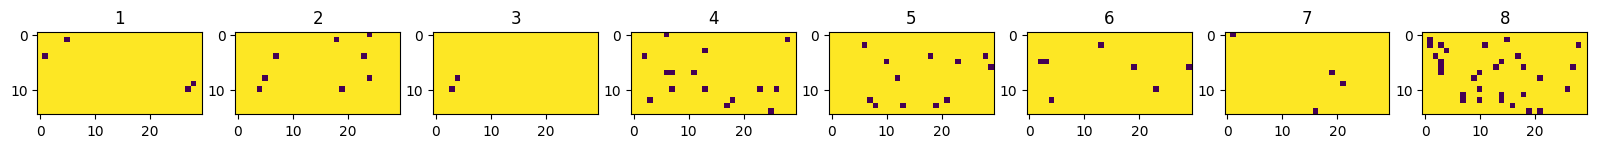

Num timesteps: 1936000
Best mean reward: -43188767.30 - Last mean reward per episode: -53811040.83


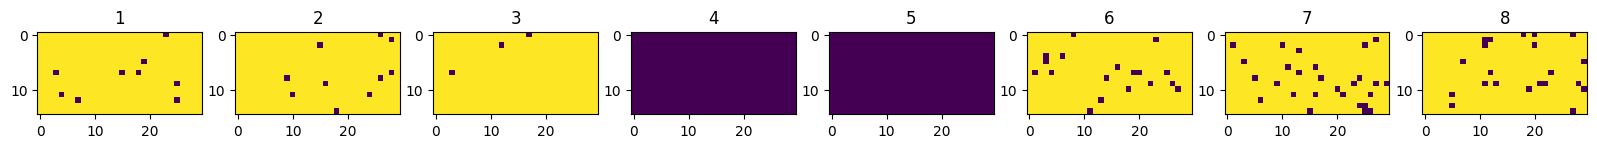

Num timesteps: 1944000
Best mean reward: -43188767.30 - Last mean reward per episode: -61091116.78


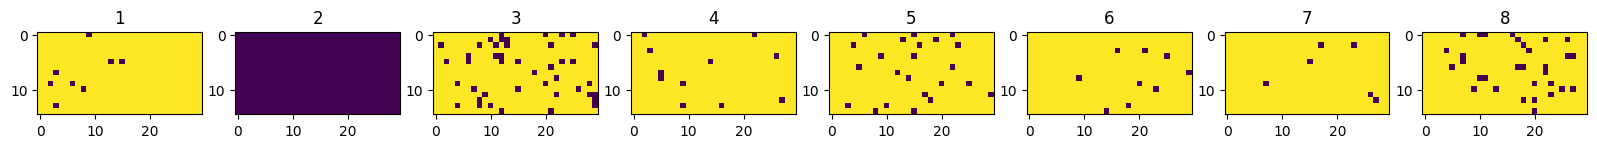

Num timesteps: 1952000
Best mean reward: -43188767.30 - Last mean reward per episode: -54739044.11


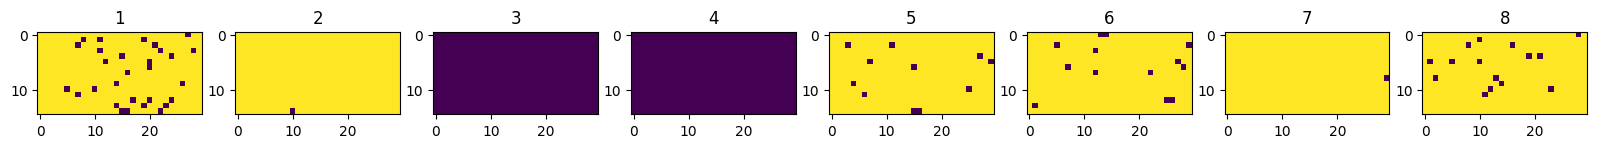

Num timesteps: 1960000
Best mean reward: -43188767.30 - Last mean reward per episode: -65088577.20


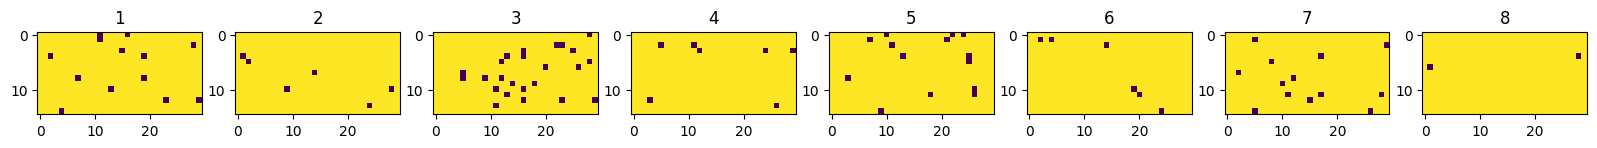

Num timesteps: 1968000
Best mean reward: -43188767.30 - Last mean reward per episode: -54818168.85


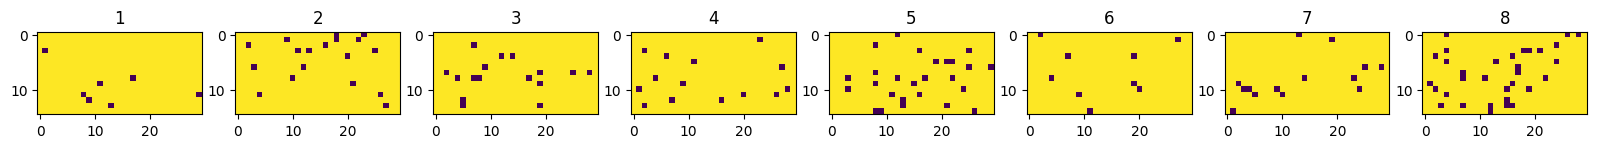

Num timesteps: 1976000
Best mean reward: -43188767.30 - Last mean reward per episode: -59261214.84


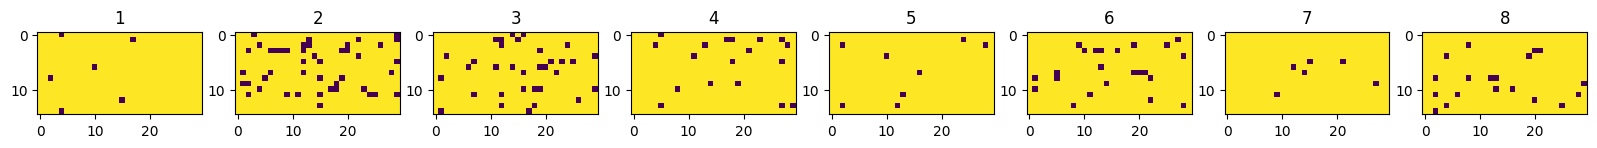

Num timesteps: 1984000
Best mean reward: -43188767.30 - Last mean reward per episode: -54423485.86


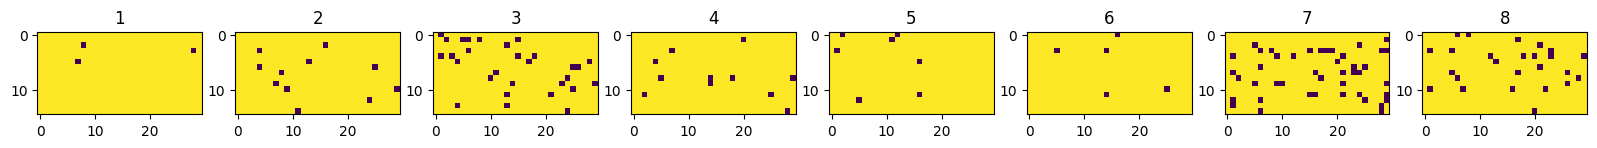

Num timesteps: 1992000
Best mean reward: -43188767.30 - Last mean reward per episode: -58785715.30


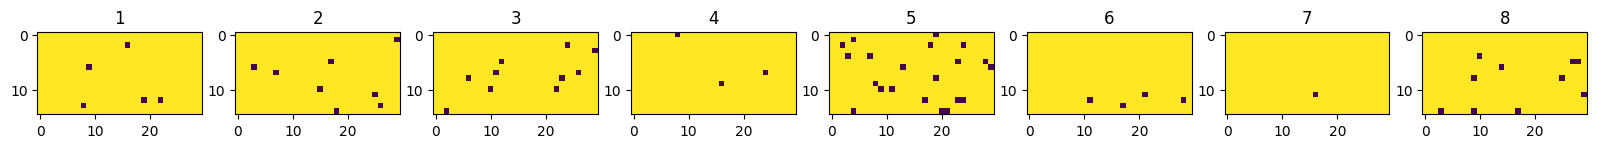

Num timesteps: 2000000
Best mean reward: -43188767.30 - Last mean reward per episode: -71769844.88


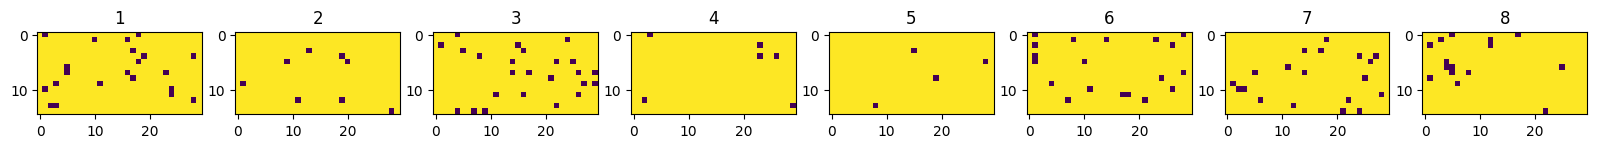

Num timesteps: 2008000
Best mean reward: -43188767.30 - Last mean reward per episode: -49905925.64


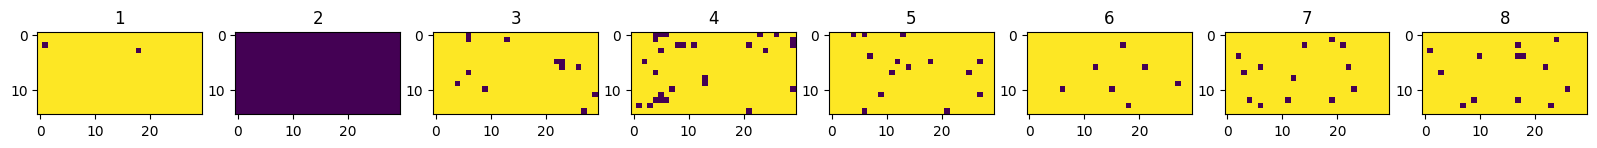

Num timesteps: 2016000
Best mean reward: -43188767.30 - Last mean reward per episode: -56080824.76


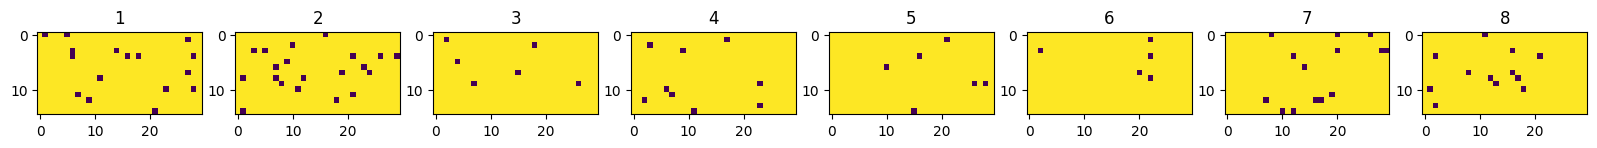

Num timesteps: 2024000
Best mean reward: -43188767.30 - Last mean reward per episode: -50359369.56


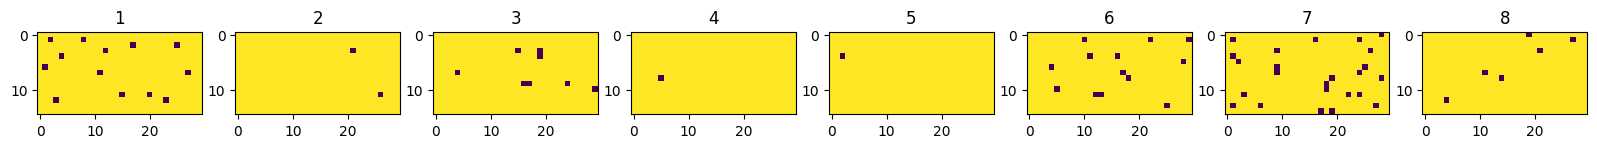

Num timesteps: 2032000
Best mean reward: -43188767.30 - Last mean reward per episode: -55345169.93


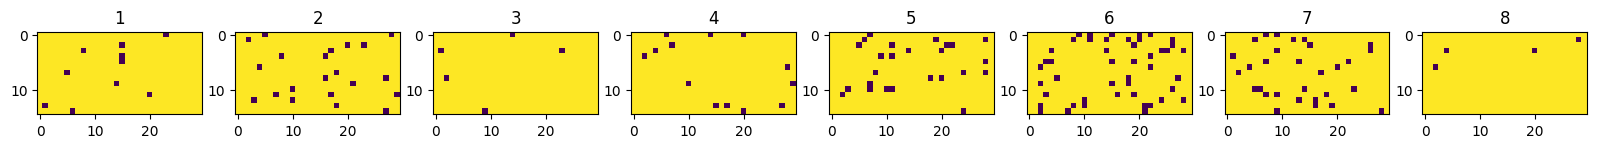

Num timesteps: 2040000
Best mean reward: -43188767.30 - Last mean reward per episode: -58344077.81


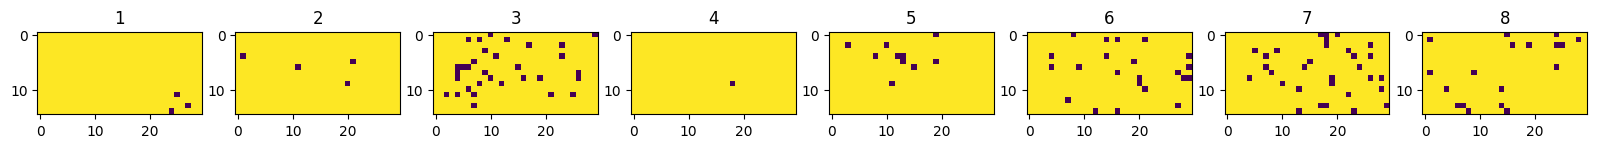

Num timesteps: 2048000
Best mean reward: -43188767.30 - Last mean reward per episode: -62952282.68


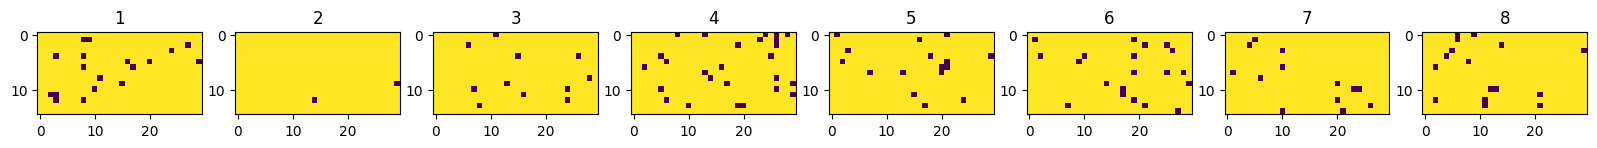

Num timesteps: 2056000
Best mean reward: -43188767.30 - Last mean reward per episode: -57342765.51


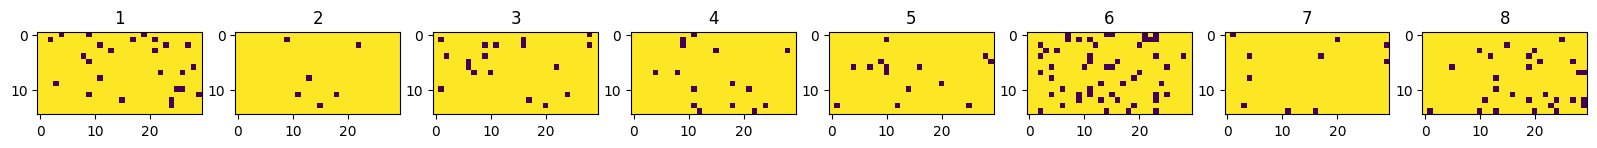

Num timesteps: 2064000
Best mean reward: -43188767.30 - Last mean reward per episode: -58927419.69


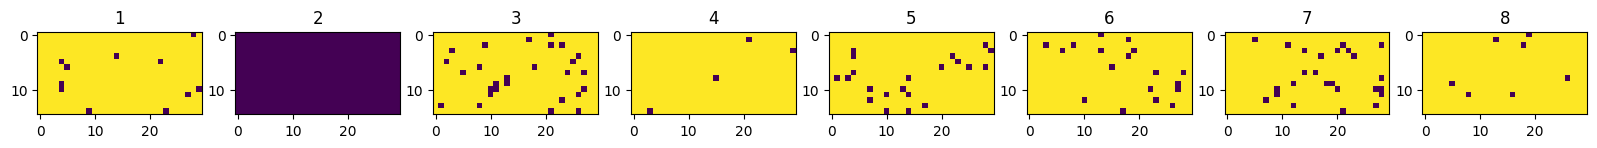

Num timesteps: 2072000
Best mean reward: -43188767.30 - Last mean reward per episode: -69069575.03


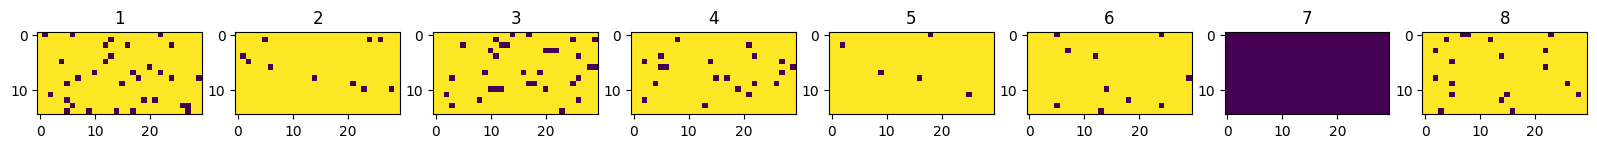

Num timesteps: 2080000
Best mean reward: -43188767.30 - Last mean reward per episode: -46841576.11


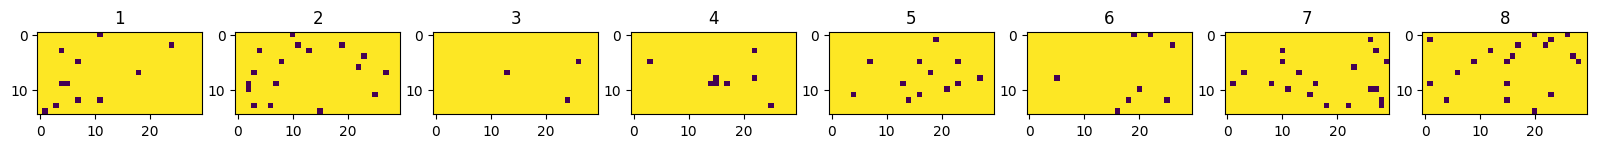

Num timesteps: 2088000
Best mean reward: -43188767.30 - Last mean reward per episode: -62462855.21


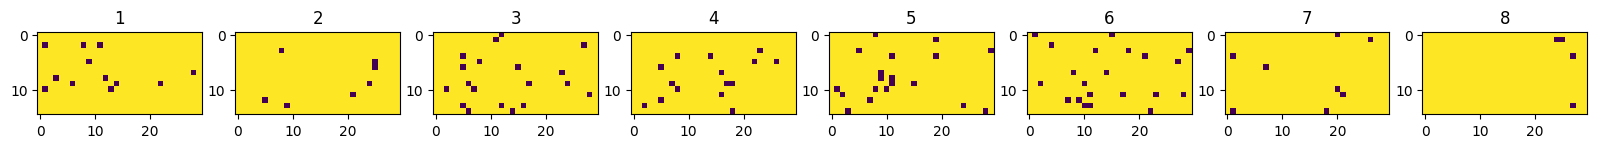

Num timesteps: 2096000
Best mean reward: -43188767.30 - Last mean reward per episode: -72114364.81


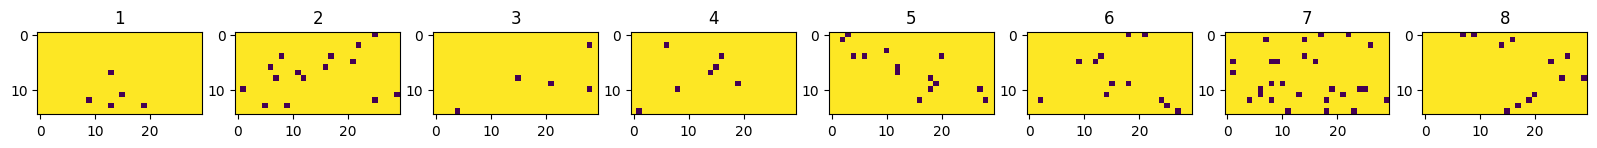

Num timesteps: 2104000
Best mean reward: -43188767.30 - Last mean reward per episode: -54778763.70


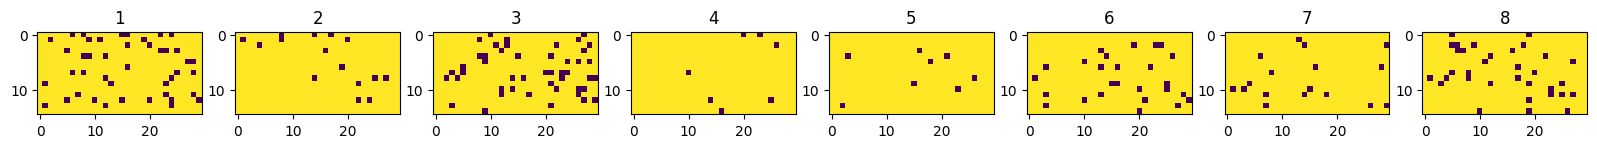

Num timesteps: 2112000
Best mean reward: -43188767.30 - Last mean reward per episode: -57906051.96


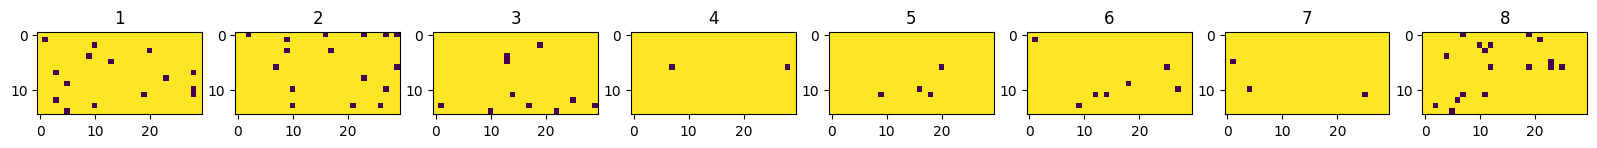

Num timesteps: 2120000
Best mean reward: -43188767.30 - Last mean reward per episode: -61723081.56


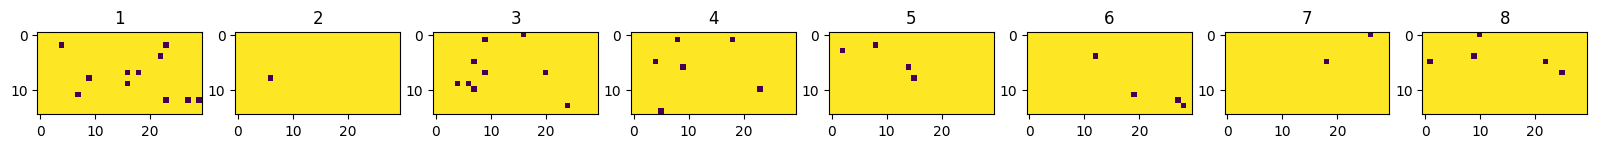

Num timesteps: 2128000
Best mean reward: -43188767.30 - Last mean reward per episode: -73136074.53


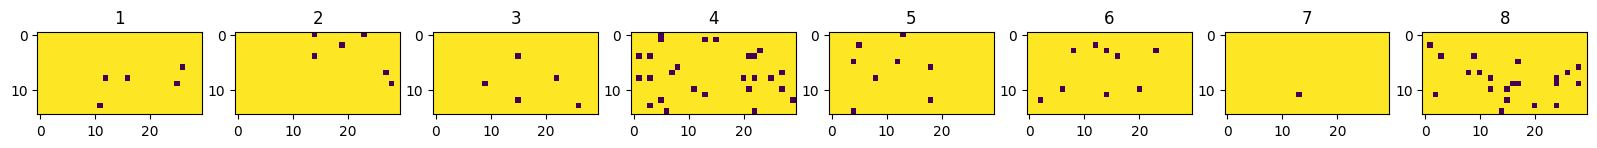

Num timesteps: 2136000
Best mean reward: -43188767.30 - Last mean reward per episode: -55173200.19


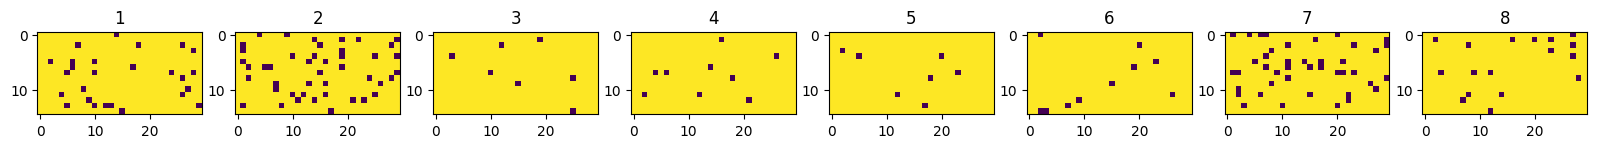

Num timesteps: 2144000
Best mean reward: -43188767.30 - Last mean reward per episode: -54816219.21


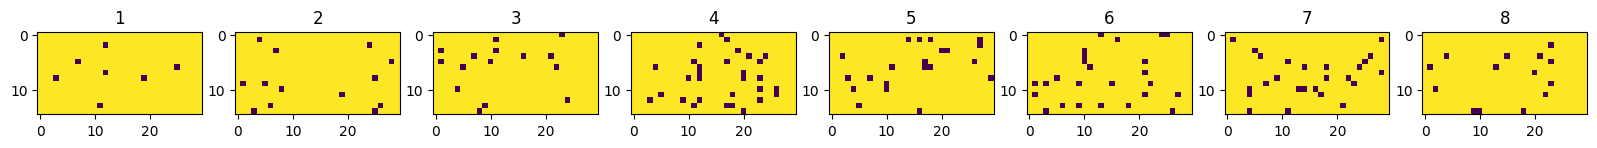

Num timesteps: 2152000
Best mean reward: -43188767.30 - Last mean reward per episode: -73114067.60


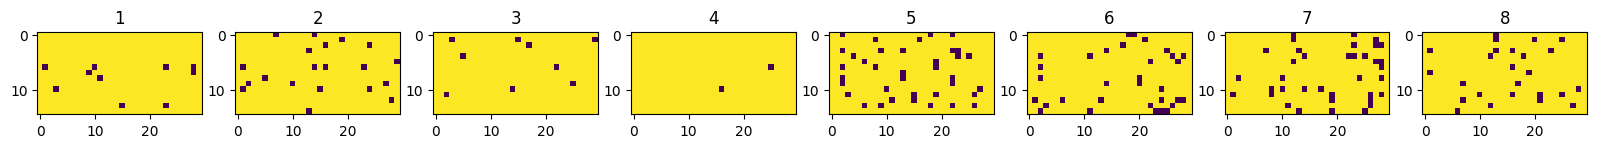

Num timesteps: 2160000
Best mean reward: -43188767.30 - Last mean reward per episode: -57038200.40


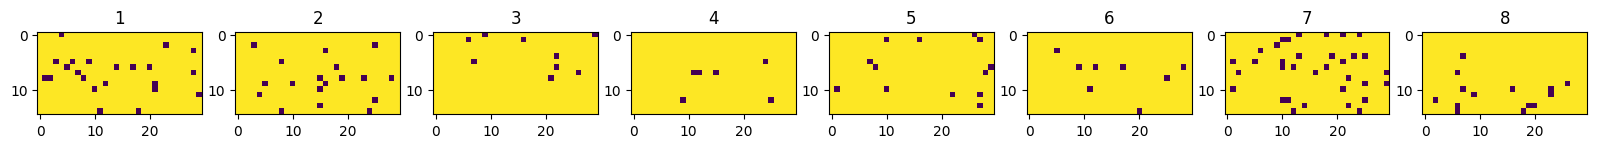

Num timesteps: 2168000
Best mean reward: -43188767.30 - Last mean reward per episode: -65597372.99


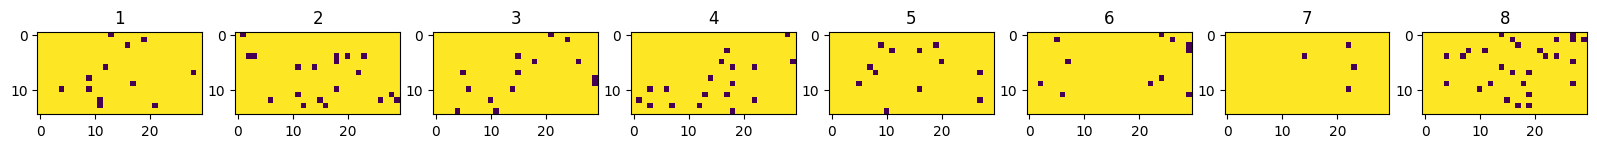

Num timesteps: 2176000
Best mean reward: -43188767.30 - Last mean reward per episode: -54602713.40


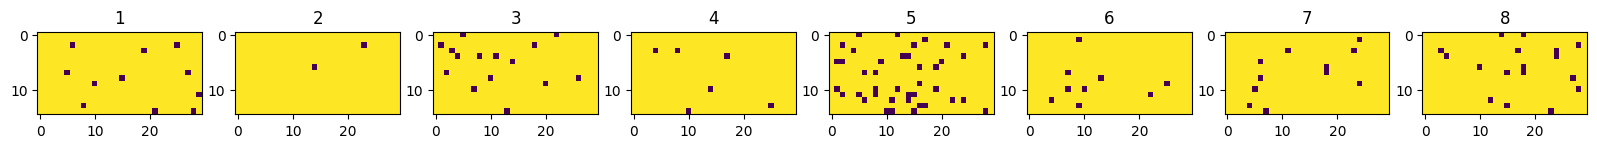

Num timesteps: 2184000
Best mean reward: -43188767.30 - Last mean reward per episode: -62286501.90


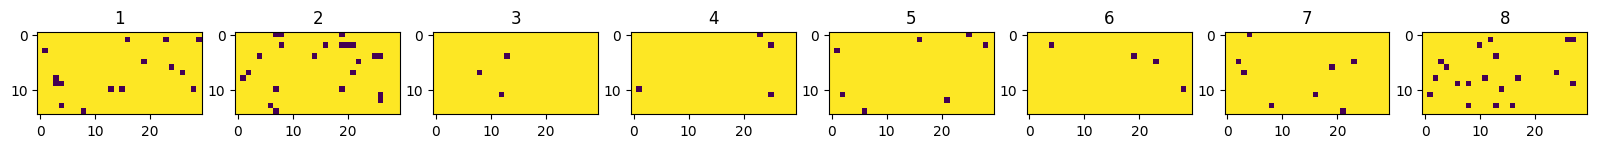

Num timesteps: 2192000
Best mean reward: -43188767.30 - Last mean reward per episode: -64973531.11


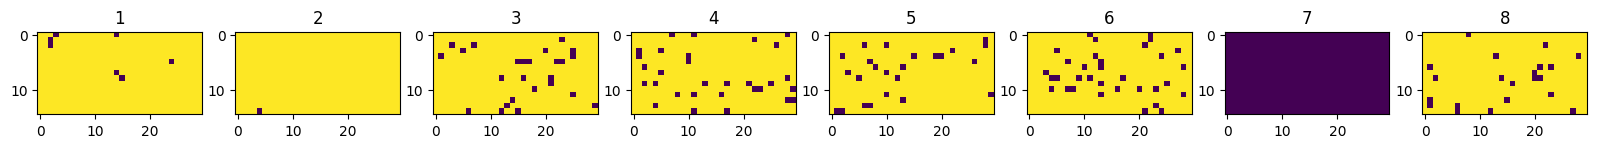

Num timesteps: 2200000
Best mean reward: -43188767.30 - Last mean reward per episode: -63344012.06


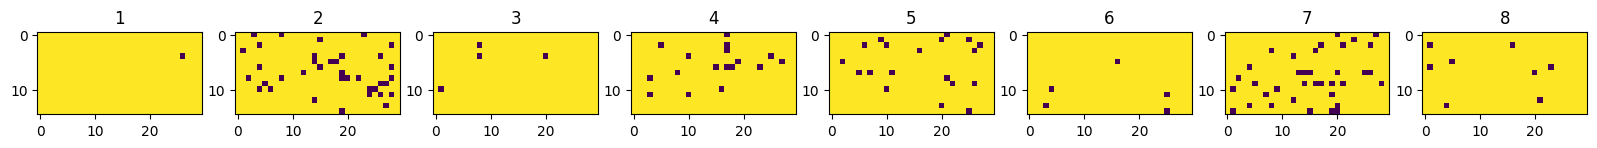

Num timesteps: 2208000
Best mean reward: -43188767.30 - Last mean reward per episode: -52255783.99


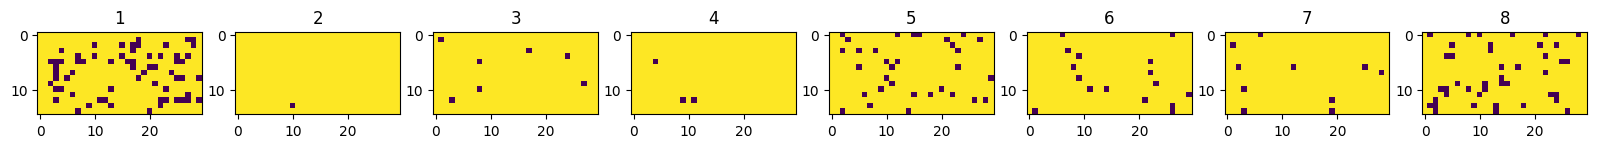

Num timesteps: 2216000
Best mean reward: -43188767.30 - Last mean reward per episode: -61980785.04


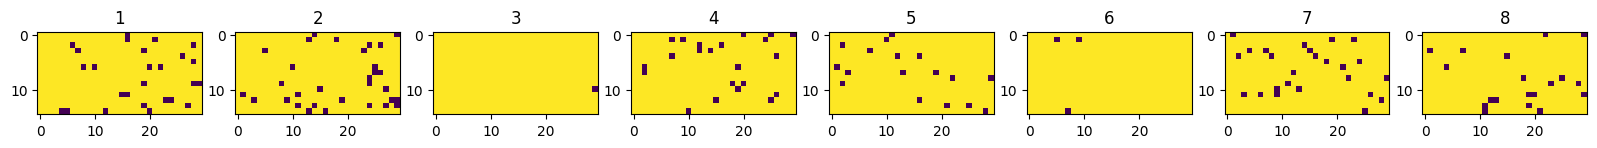

Num timesteps: 2224000
Best mean reward: -43188767.30 - Last mean reward per episode: -58852331.55


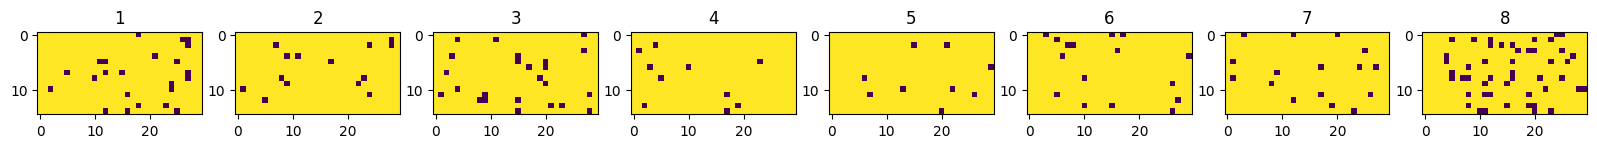

Num timesteps: 2232000
Best mean reward: -43188767.30 - Last mean reward per episode: -55870465.47


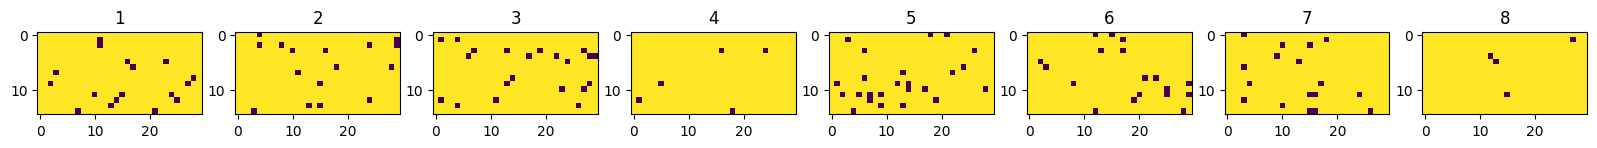

Num timesteps: 2240000
Best mean reward: -43188767.30 - Last mean reward per episode: -65592675.93


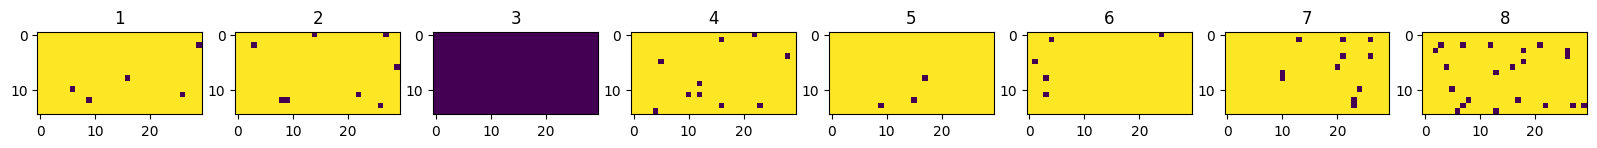

Num timesteps: 2248000
Best mean reward: -43188767.30 - Last mean reward per episode: -53813367.29


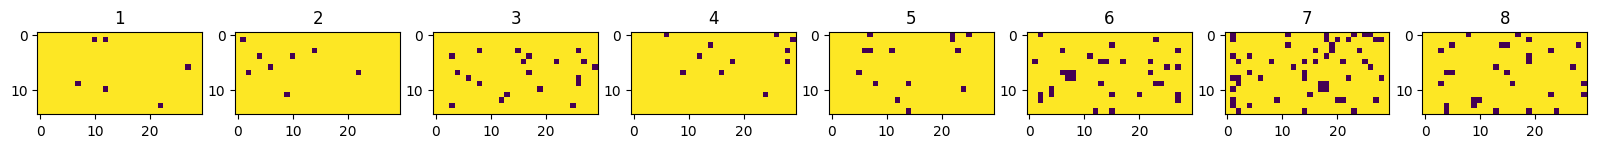

Num timesteps: 2256000
Best mean reward: -43188767.30 - Last mean reward per episode: -63614429.60


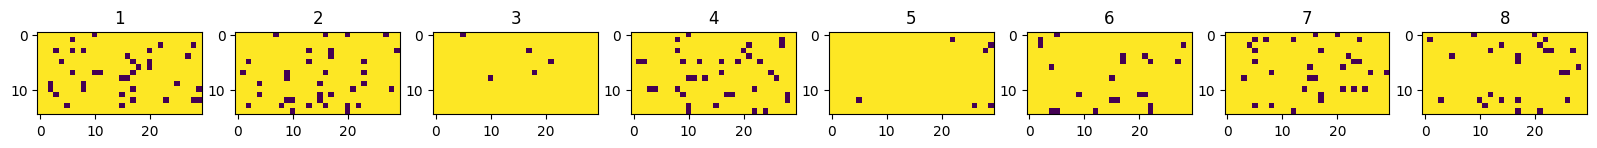

Num timesteps: 2264000
Best mean reward: -43188767.30 - Last mean reward per episode: -62582195.25


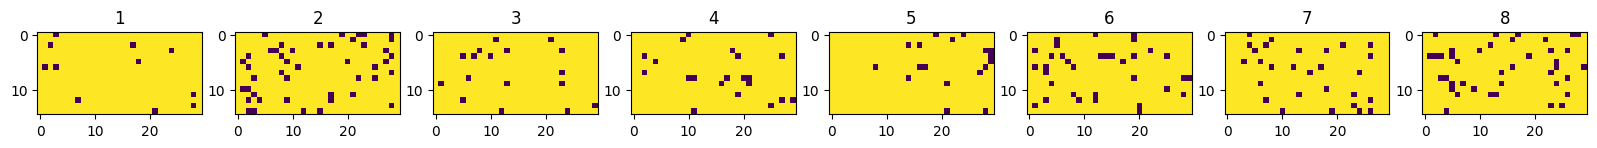

Num timesteps: 2272000
Best mean reward: -43188767.30 - Last mean reward per episode: -66010749.82


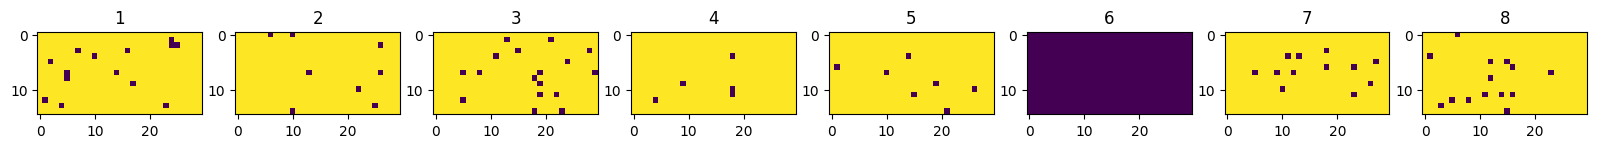

Num timesteps: 2280000
Best mean reward: -43188767.30 - Last mean reward per episode: -59565776.12


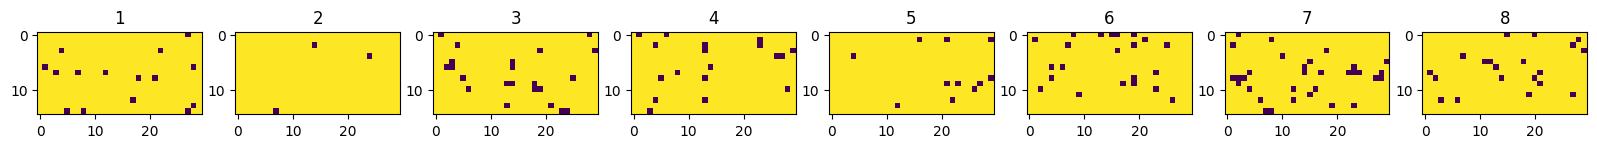

Num timesteps: 2288000
Best mean reward: -43188767.30 - Last mean reward per episode: -67512847.06


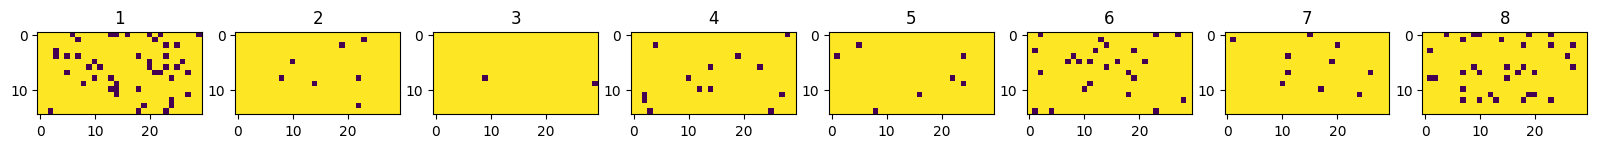

Num timesteps: 2296000
Best mean reward: -43188767.30 - Last mean reward per episode: -57929570.59


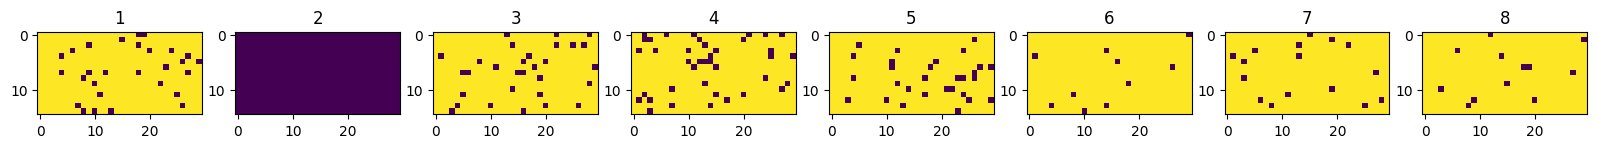

Num timesteps: 2304000
Best mean reward: -43188767.30 - Last mean reward per episode: -61496537.12


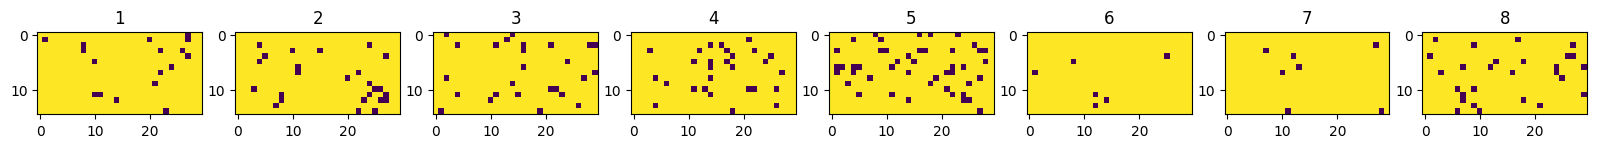

Num timesteps: 2312000
Best mean reward: -43188767.30 - Last mean reward per episode: -53868384.44


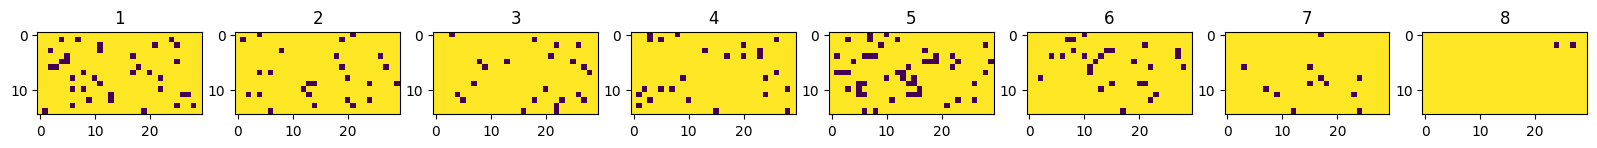

Num timesteps: 2320000
Best mean reward: -43188767.30 - Last mean reward per episode: -54561244.65


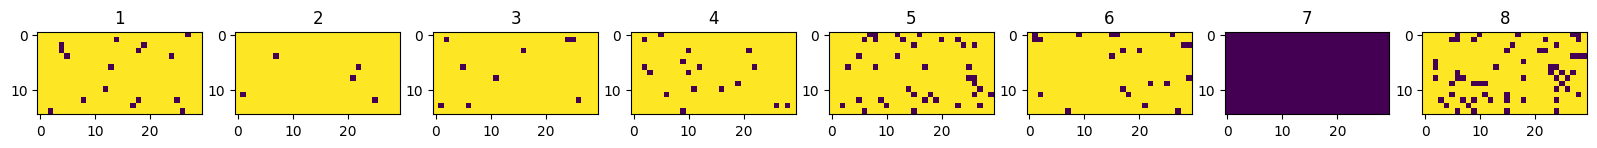

Num timesteps: 2328000
Best mean reward: -43188767.30 - Last mean reward per episode: -53221304.57


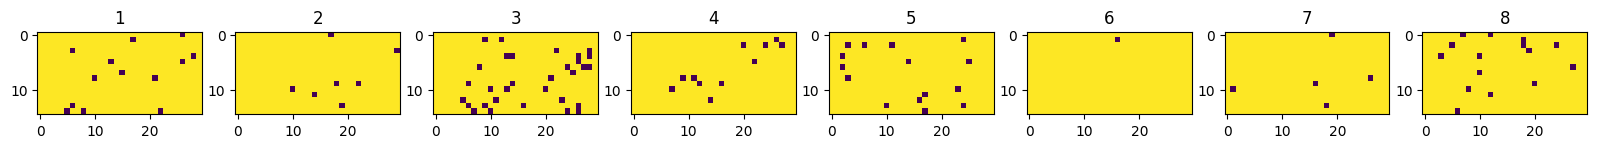

Num timesteps: 2336000
Best mean reward: -43188767.30 - Last mean reward per episode: -64055090.95


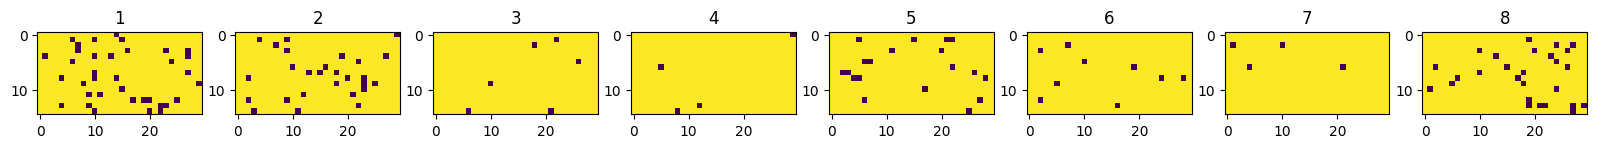

Num timesteps: 2344000
Best mean reward: -43188767.30 - Last mean reward per episode: -62876368.98


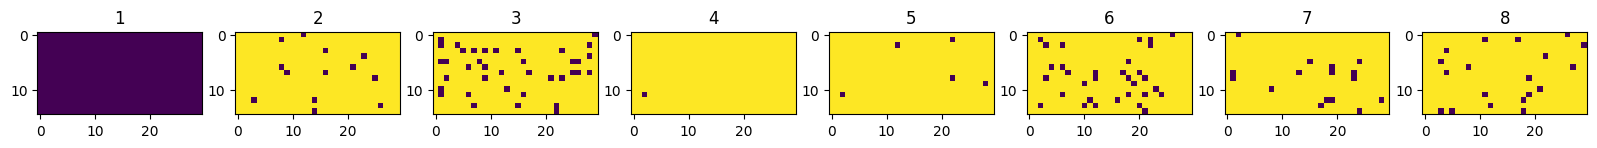

Num timesteps: 2352000
Best mean reward: -43188767.30 - Last mean reward per episode: -50124853.75


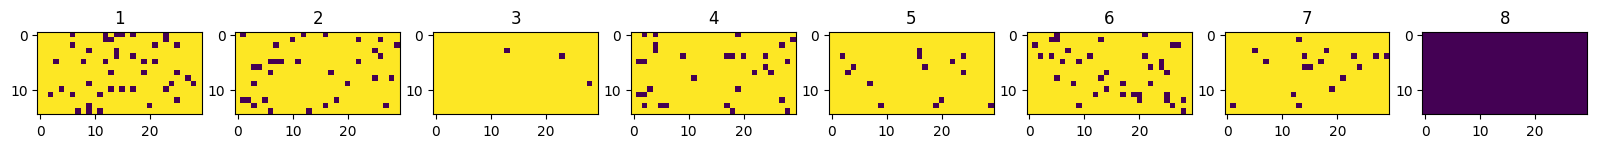

Num timesteps: 2360000
Best mean reward: -43188767.30 - Last mean reward per episode: -60532874.70


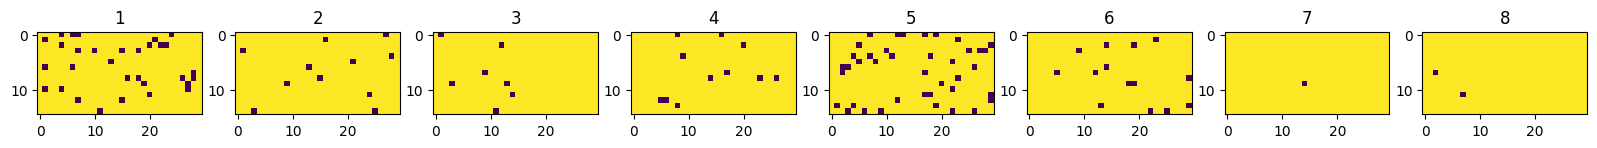

Num timesteps: 2368000
Best mean reward: -43188767.30 - Last mean reward per episode: -56508071.94


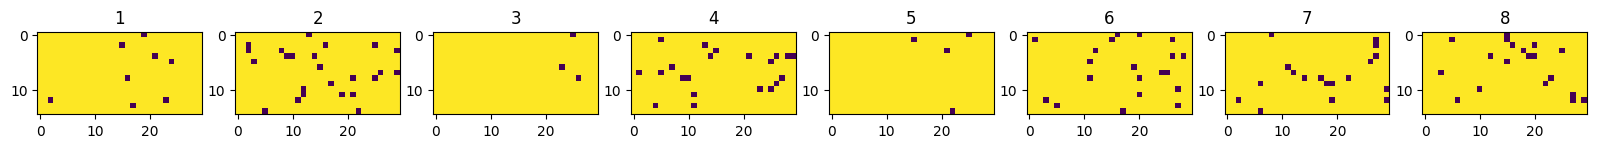

Num timesteps: 2376000
Best mean reward: -43188767.30 - Last mean reward per episode: -51645845.74


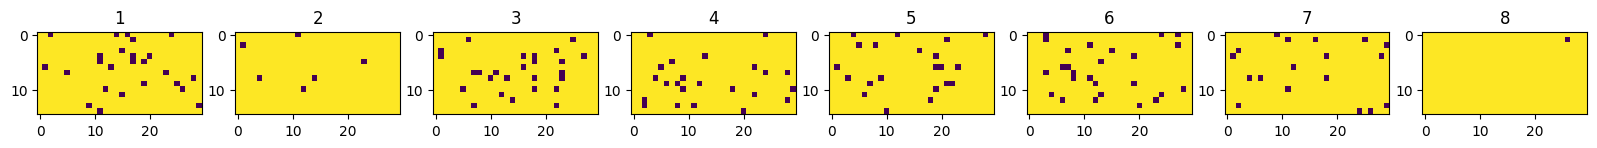

Num timesteps: 2384000
Best mean reward: -43188767.30 - Last mean reward per episode: -57312068.40


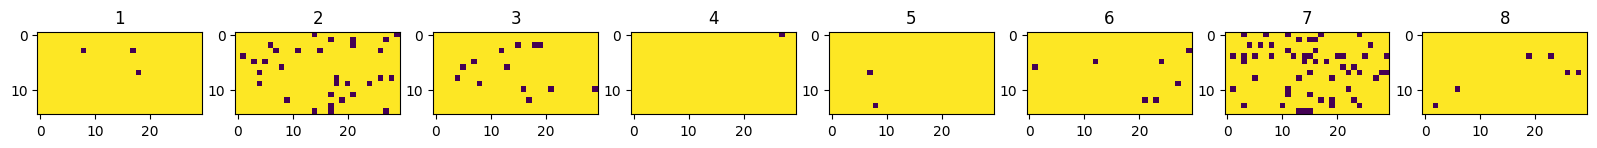

Num timesteps: 2392000
Best mean reward: -43188767.30 - Last mean reward per episode: -62128313.44


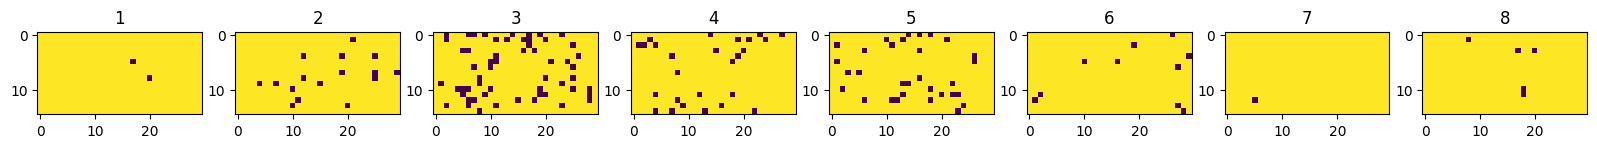

Num timesteps: 2400000
Best mean reward: -43188767.30 - Last mean reward per episode: -55548422.48


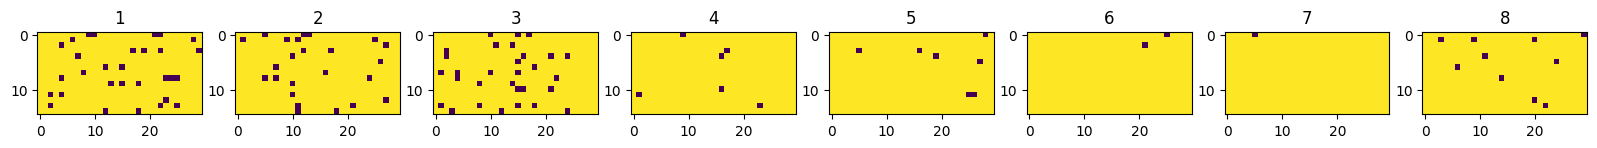

Num timesteps: 2408000
Best mean reward: -43188767.30 - Last mean reward per episode: -66674716.41


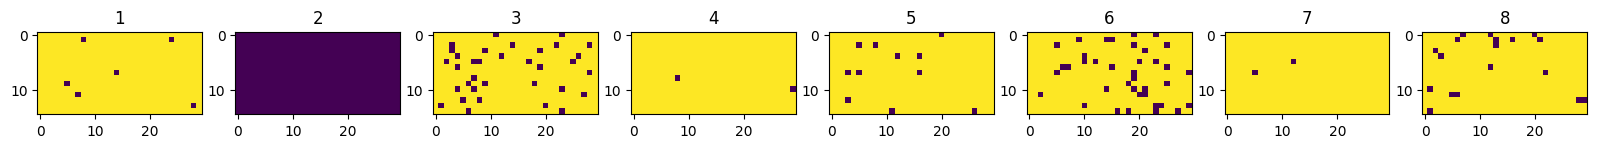

Num timesteps: 2416000
Best mean reward: -43188767.30 - Last mean reward per episode: -52867856.02


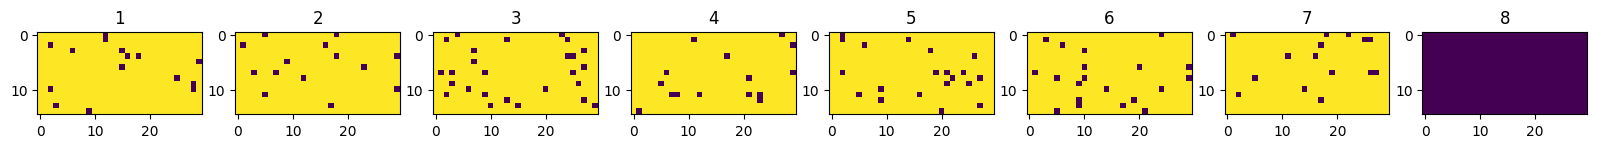

Num timesteps: 2424000
Best mean reward: -43188767.30 - Last mean reward per episode: -60213431.46


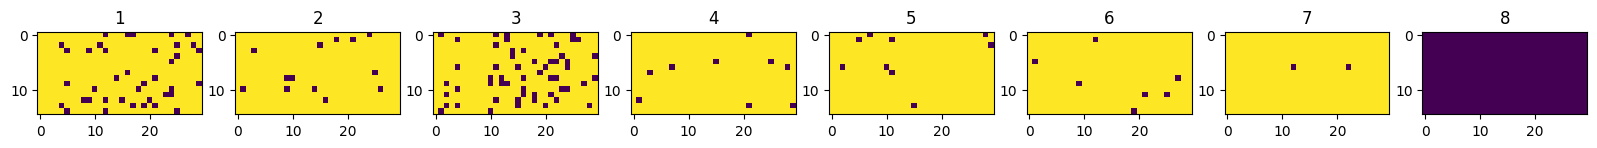

Num timesteps: 2432000
Best mean reward: -43188767.30 - Last mean reward per episode: -49427826.50


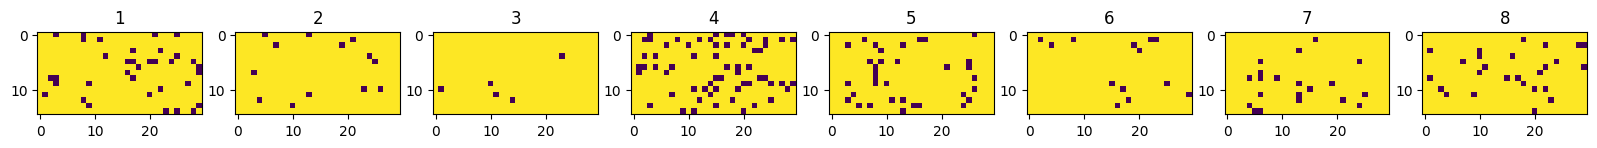

Num timesteps: 2440000
Best mean reward: -43188767.30 - Last mean reward per episode: -58363070.41


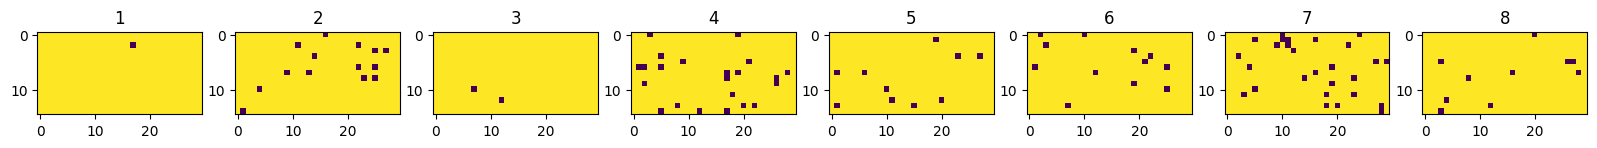

Num timesteps: 2448000
Best mean reward: -43188767.30 - Last mean reward per episode: -59070740.66


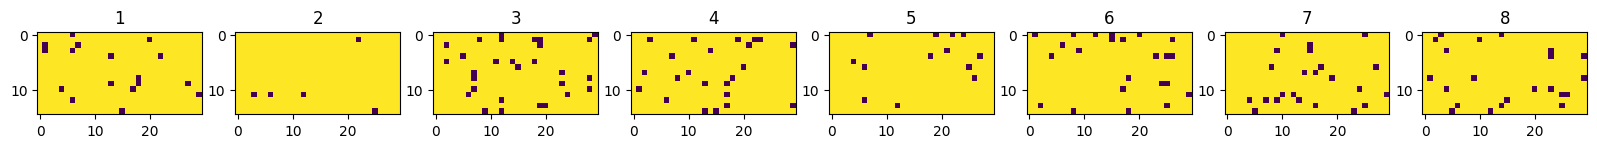

Num timesteps: 2456000
Best mean reward: -43188767.30 - Last mean reward per episode: -61071081.51


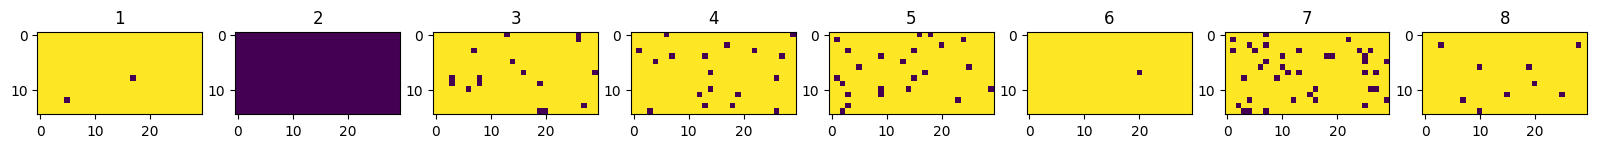

Num timesteps: 2464000
Best mean reward: -43188767.30 - Last mean reward per episode: -52229394.23


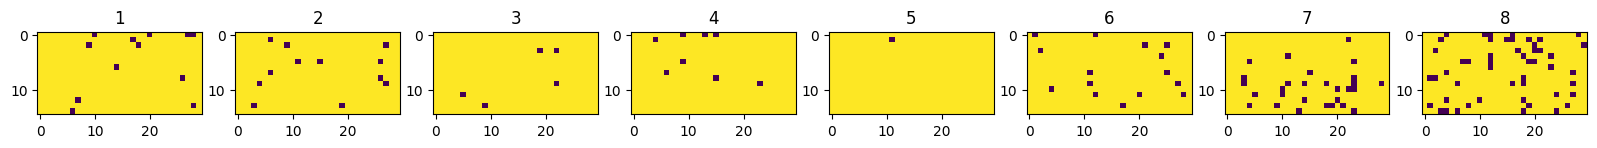

Num timesteps: 2472000
Best mean reward: -43188767.30 - Last mean reward per episode: -60053825.88


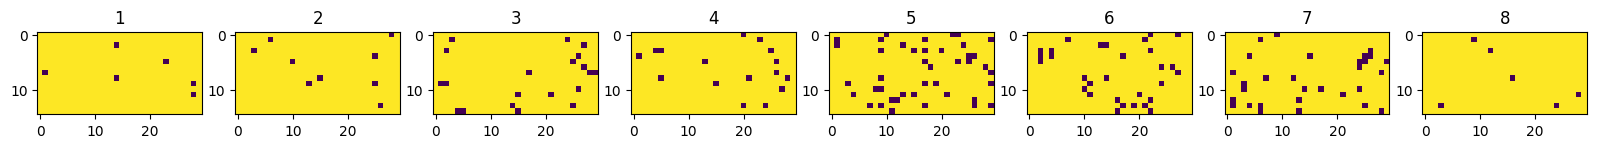

Num timesteps: 2480000
Best mean reward: -43188767.30 - Last mean reward per episode: -58714860.32


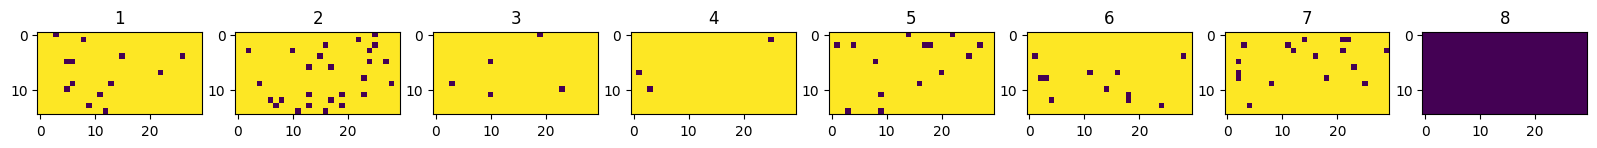

Num timesteps: 2488000
Best mean reward: -43188767.30 - Last mean reward per episode: -59378746.84


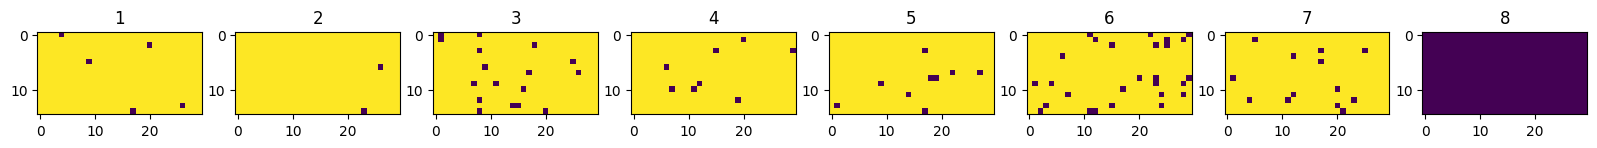

Num timesteps: 2496000
Best mean reward: -43188767.30 - Last mean reward per episode: -62080053.34


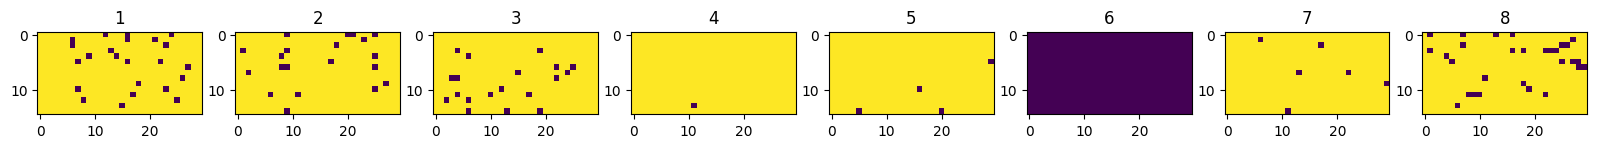

Num timesteps: 2504000
Best mean reward: -43188767.30 - Last mean reward per episode: -49996166.33


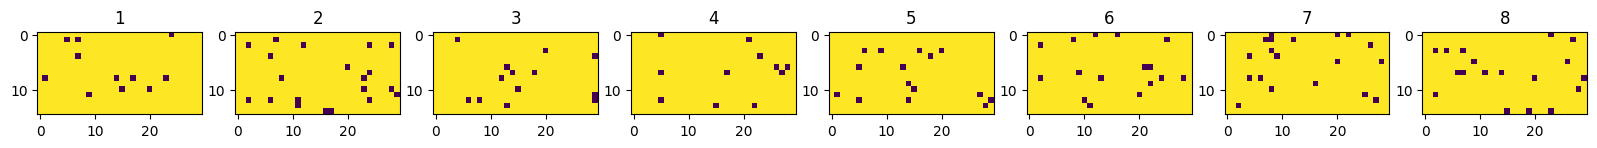

Num timesteps: 2512000
Best mean reward: -43188767.30 - Last mean reward per episode: -55681682.82


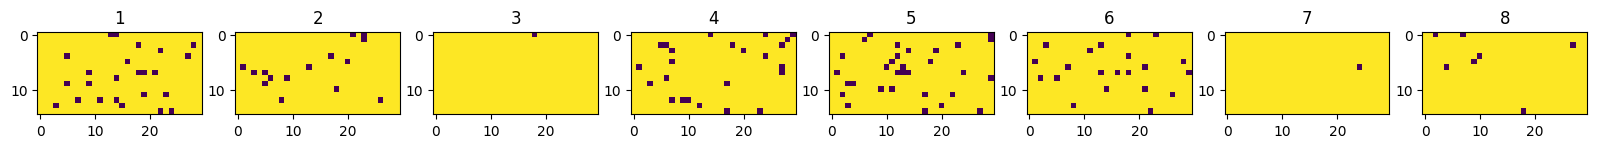

Num timesteps: 2520000
Best mean reward: -43188767.30 - Last mean reward per episode: -54327627.89


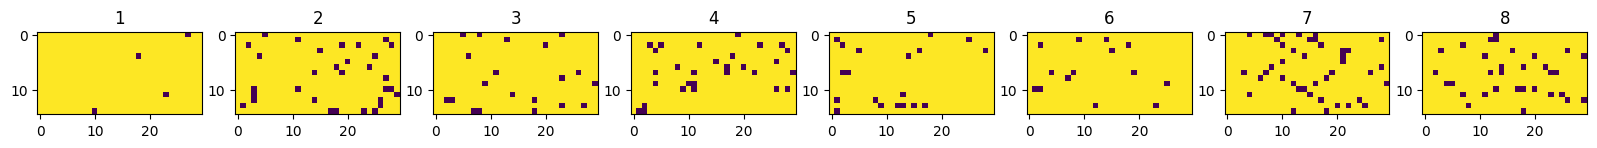

Num timesteps: 2528000
Best mean reward: -43188767.30 - Last mean reward per episode: -57449513.57


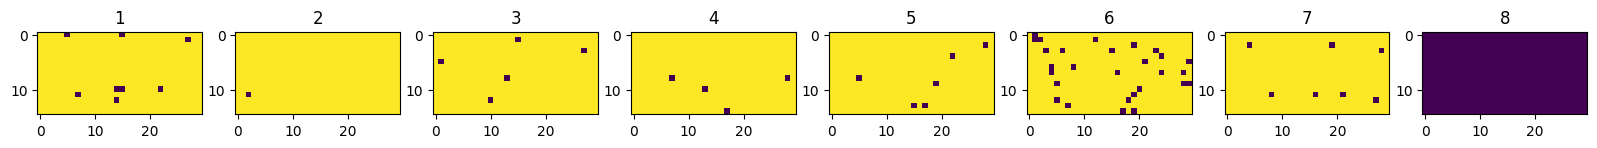

Num timesteps: 2536000
Best mean reward: -43188767.30 - Last mean reward per episode: -55142031.79


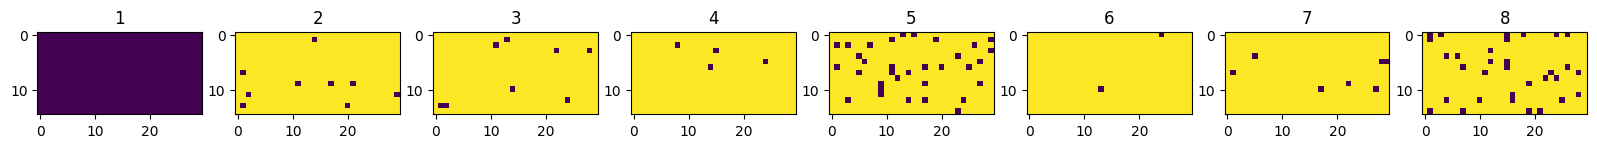

Num timesteps: 2544000
Best mean reward: -43188767.30 - Last mean reward per episode: -66577681.26


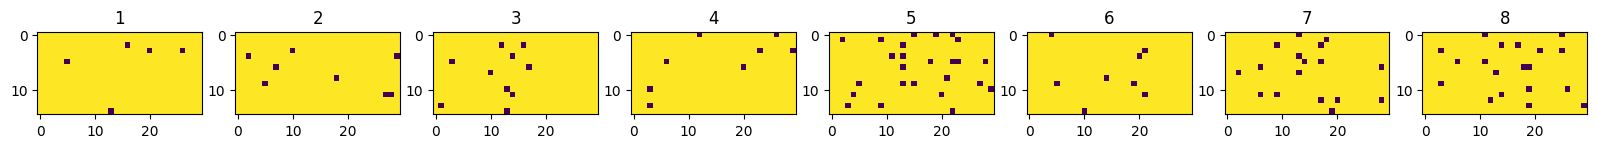

Num timesteps: 2552000
Best mean reward: -43188767.30 - Last mean reward per episode: -53556504.61


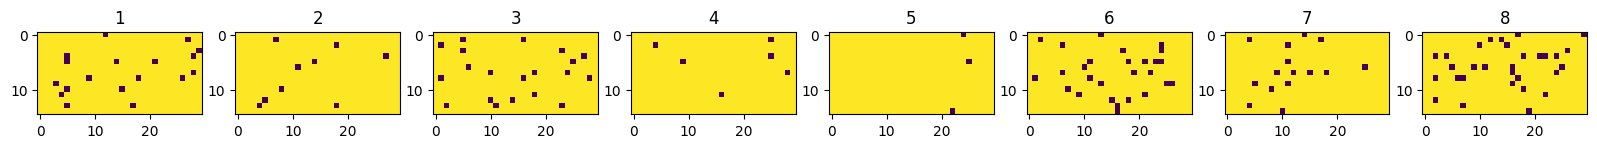

Num timesteps: 2560000
Best mean reward: -43188767.30 - Last mean reward per episode: -53217569.42


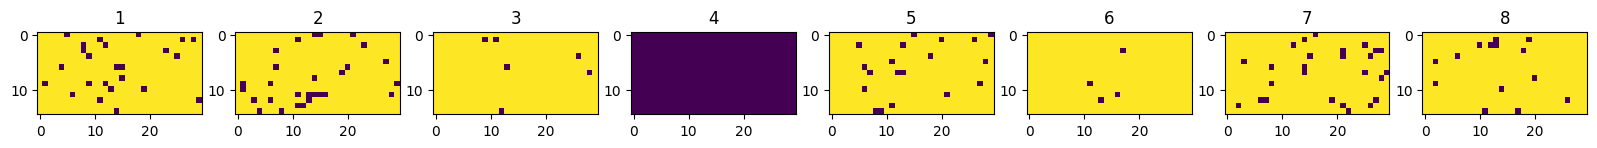

Num timesteps: 2568000
Best mean reward: -43188767.30 - Last mean reward per episode: -61248215.24


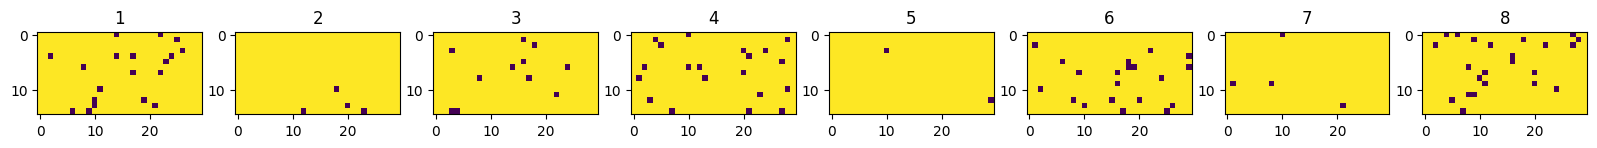

Num timesteps: 2576000
Best mean reward: -43188767.30 - Last mean reward per episode: -46615536.27


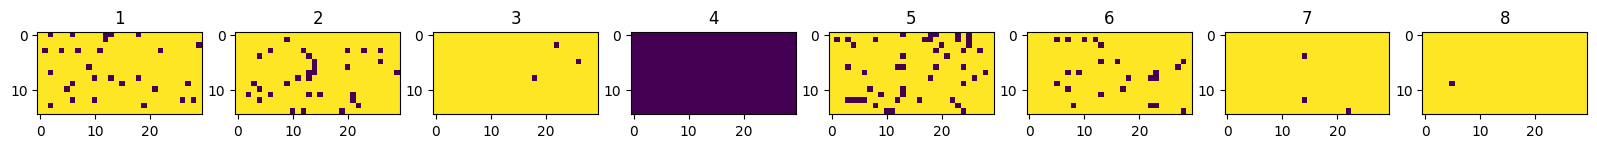

Num timesteps: 2584000
Best mean reward: -43188767.30 - Last mean reward per episode: -54121866.95


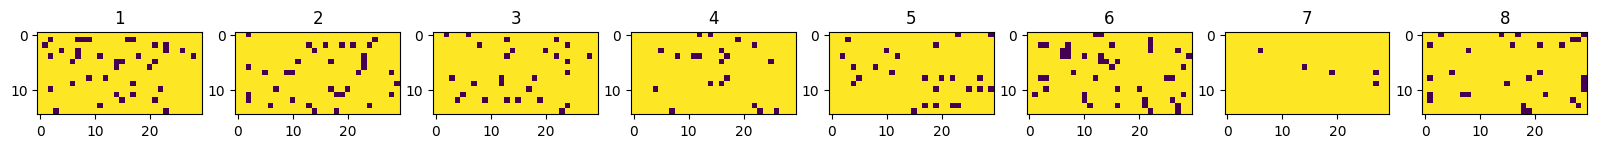

Num timesteps: 2592000
Best mean reward: -43188767.30 - Last mean reward per episode: -63352365.30


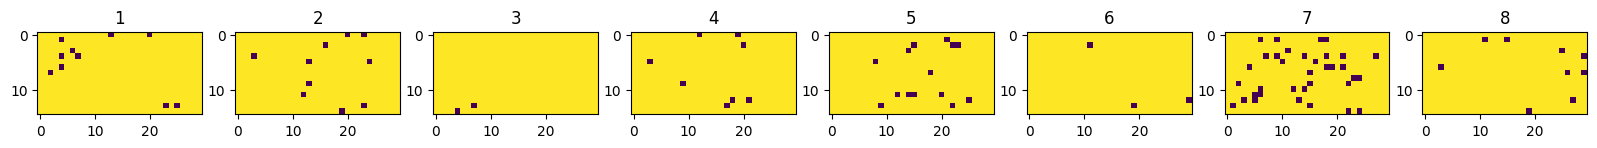

Num timesteps: 2600000
Best mean reward: -43188767.30 - Last mean reward per episode: -57745326.17


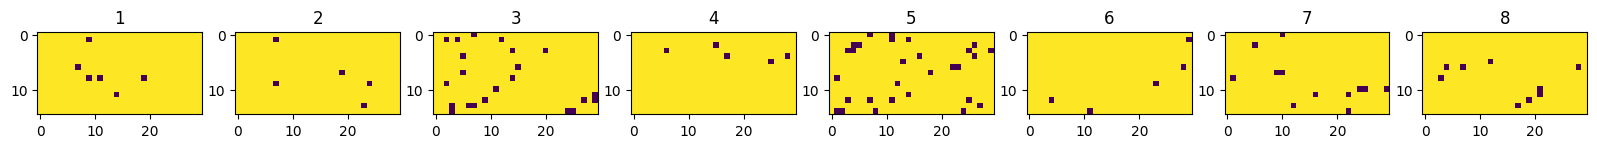

Num timesteps: 2608000
Best mean reward: -43188767.30 - Last mean reward per episode: -52429218.06


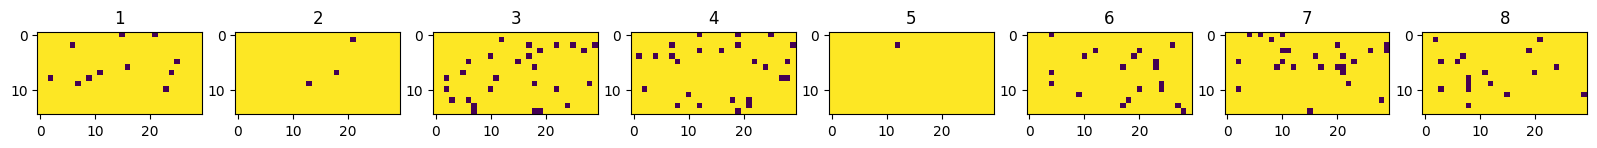

Num timesteps: 2616000
Best mean reward: -43188767.30 - Last mean reward per episode: -58141928.38


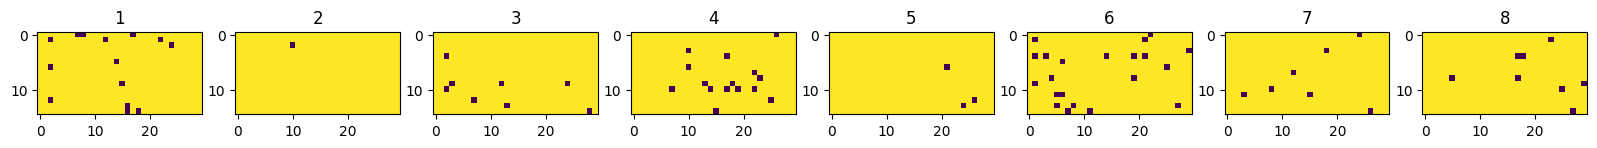

Num timesteps: 2624000
Best mean reward: -43188767.30 - Last mean reward per episode: -62321544.33


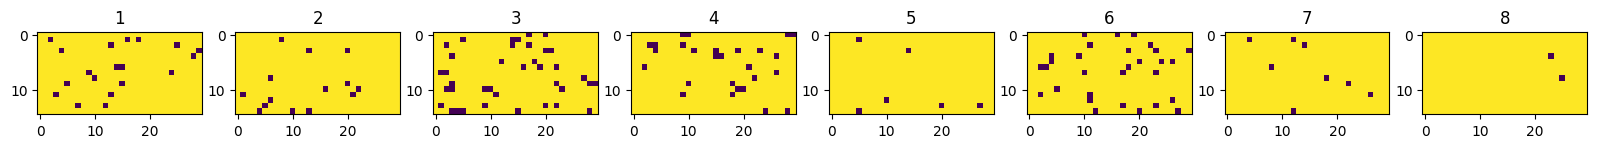

Num timesteps: 2632000
Best mean reward: -43188767.30 - Last mean reward per episode: -52932283.80


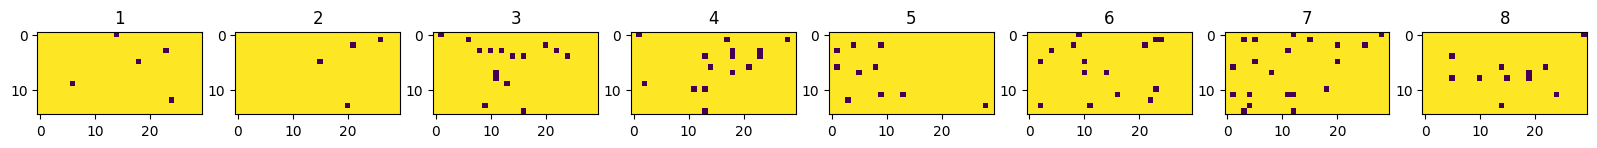

Num timesteps: 2640000
Best mean reward: -43188767.30 - Last mean reward per episode: -57891287.11


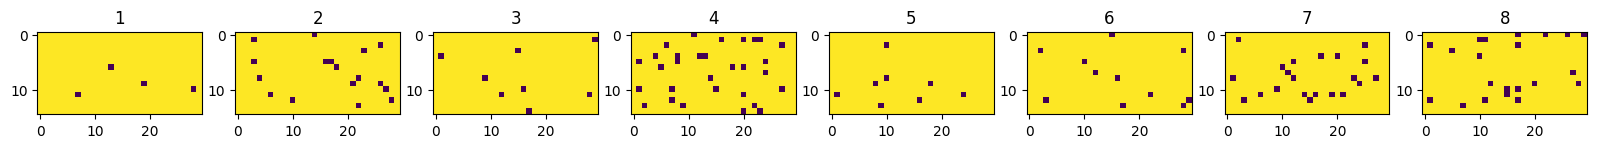

Num timesteps: 2648000
Best mean reward: -43188767.30 - Last mean reward per episode: -61738896.44


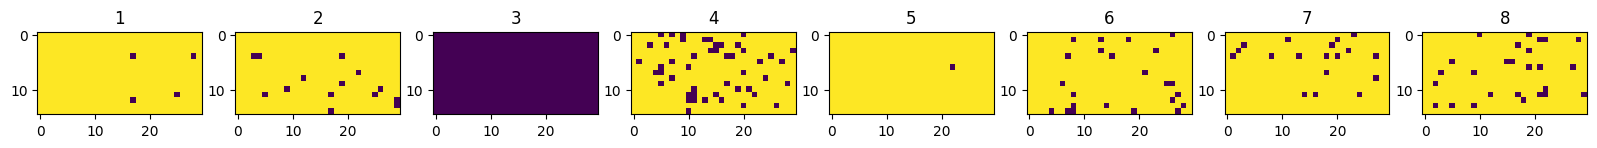

Num timesteps: 2656000
Best mean reward: -43188767.30 - Last mean reward per episode: -59358293.96


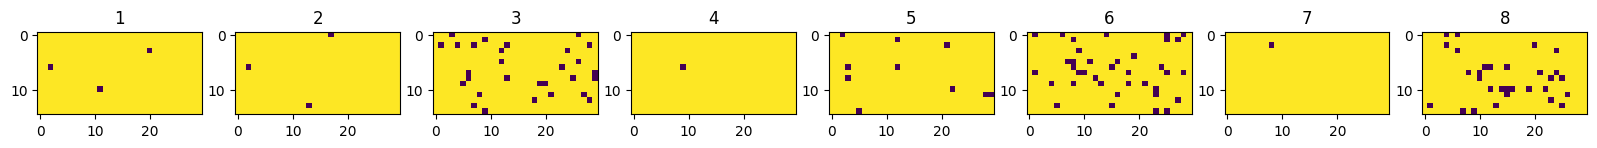

Num timesteps: 2664000
Best mean reward: -43188767.30 - Last mean reward per episode: -64800334.37


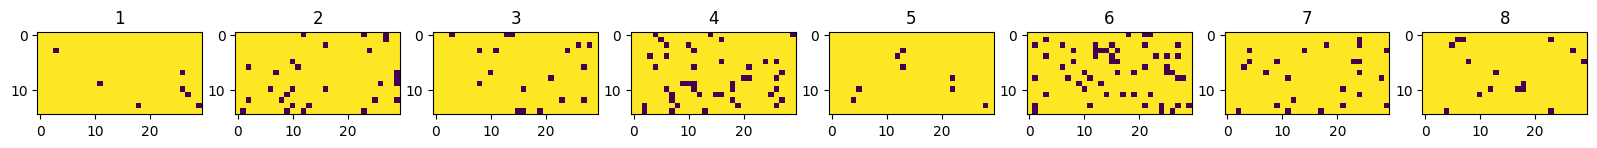

Num timesteps: 2672000
Best mean reward: -43188767.30 - Last mean reward per episode: -61691245.10


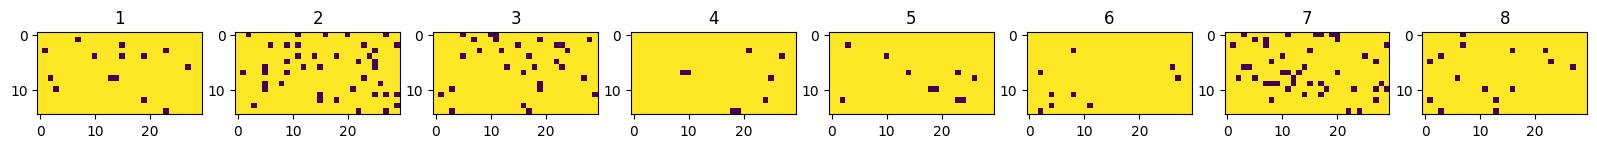

Num timesteps: 2680000
Best mean reward: -43188767.30 - Last mean reward per episode: -53527220.75


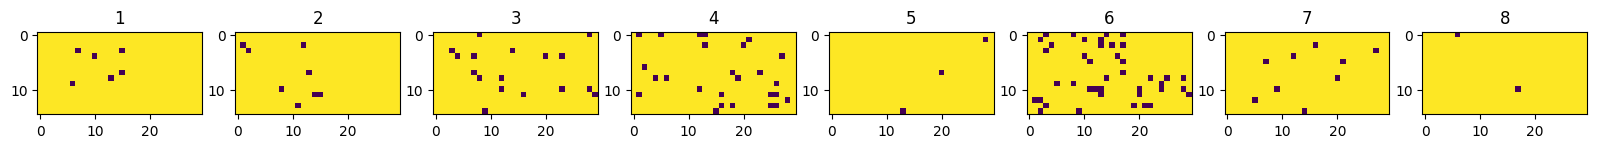

Num timesteps: 2688000
Best mean reward: -43188767.30 - Last mean reward per episode: -55515110.90


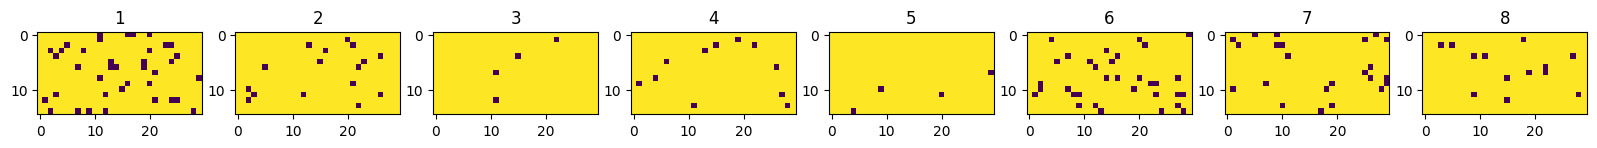

Num timesteps: 2696000
Best mean reward: -43188767.30 - Last mean reward per episode: -65730178.07


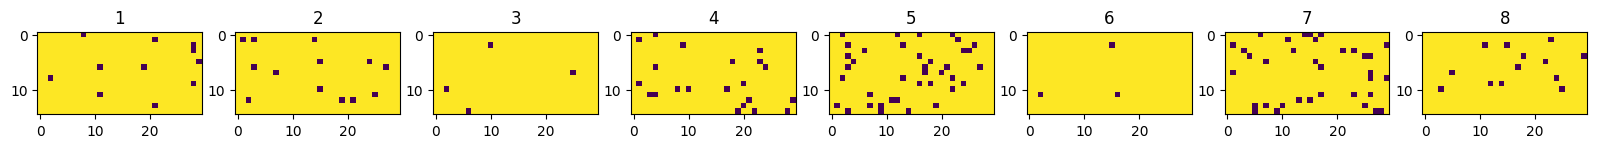

Num timesteps: 2704000
Best mean reward: -43188767.30 - Last mean reward per episode: -52988368.02


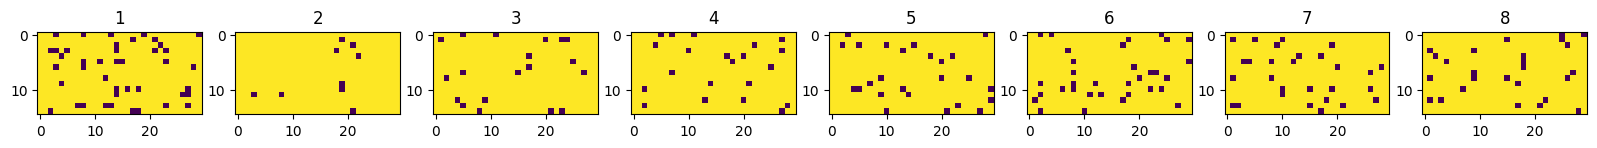

Num timesteps: 2712000
Best mean reward: -43188767.30 - Last mean reward per episode: -53981002.64


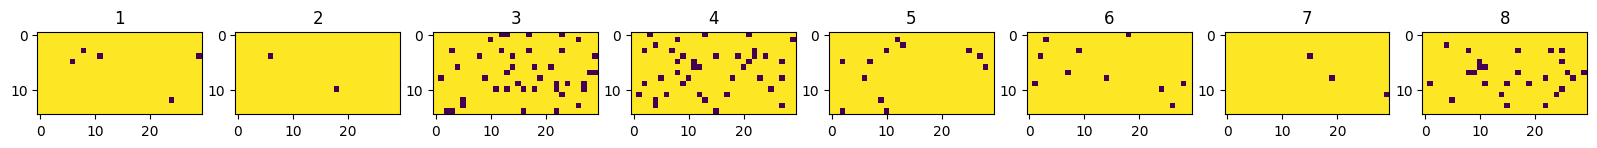

Num timesteps: 2720000
Best mean reward: -43188767.30 - Last mean reward per episode: -53122719.84


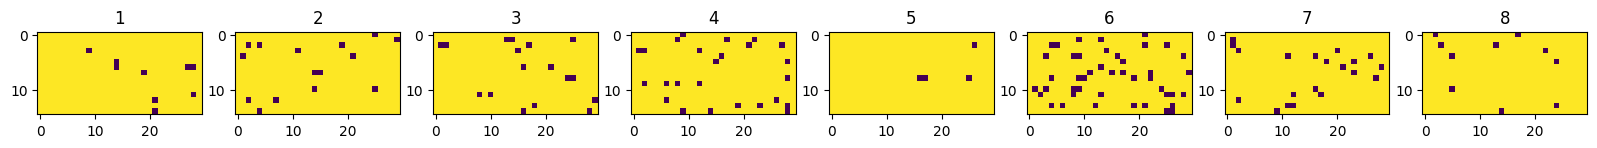

Num timesteps: 2728000
Best mean reward: -43188767.30 - Last mean reward per episode: -62577292.62


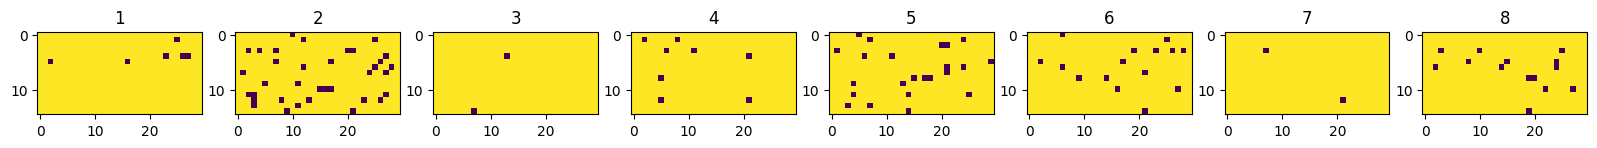

Num timesteps: 2736000
Best mean reward: -43188767.30 - Last mean reward per episode: -55466263.50


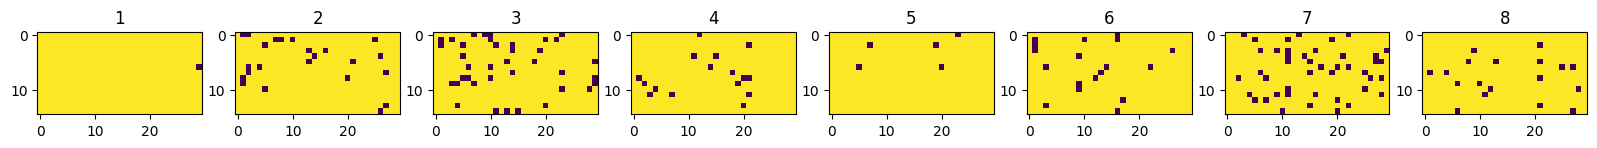

Num timesteps: 2744000
Best mean reward: -43188767.30 - Last mean reward per episode: -63315679.23


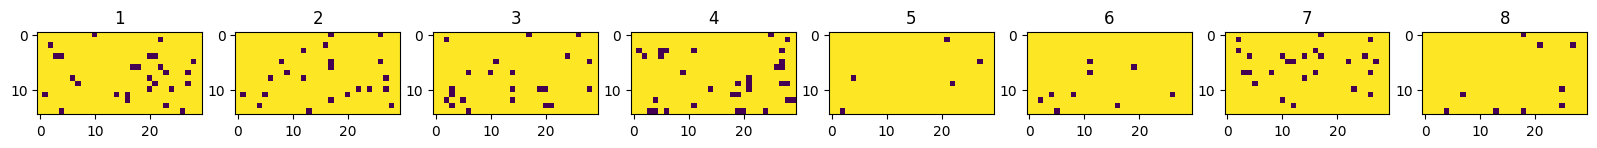

Num timesteps: 2752000
Best mean reward: -43188767.30 - Last mean reward per episode: -51142323.43


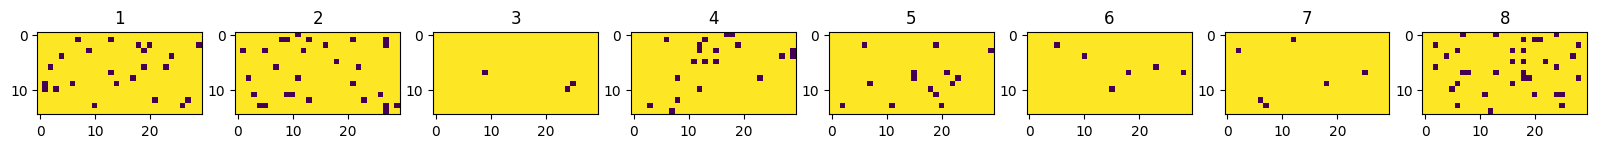

Num timesteps: 2760000
Best mean reward: -43188767.30 - Last mean reward per episode: -56697442.79


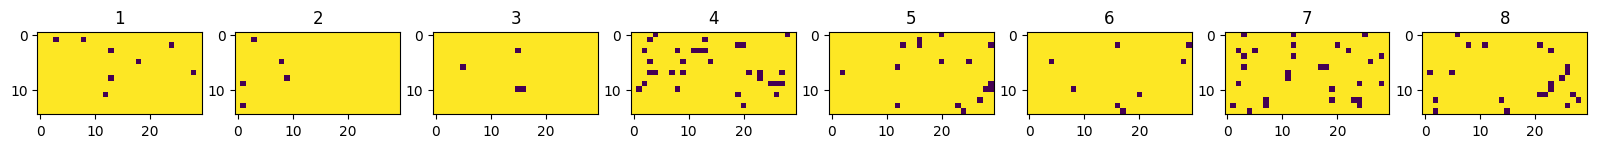

Num timesteps: 2768000
Best mean reward: -43188767.30 - Last mean reward per episode: -54957352.78


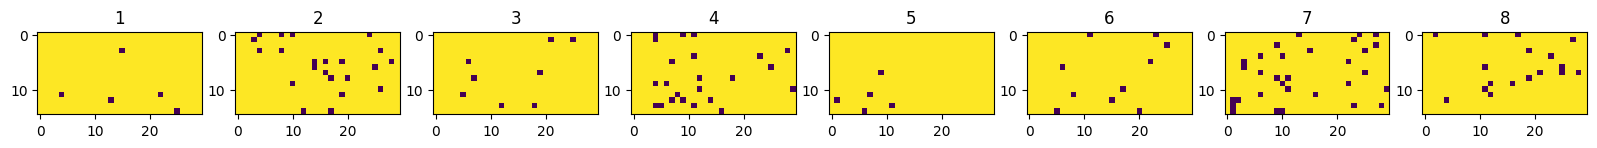

Num timesteps: 2776000
Best mean reward: -43188767.30 - Last mean reward per episode: -60883500.23


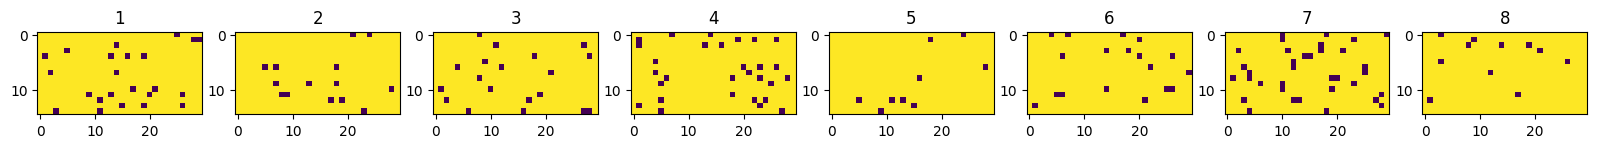

Num timesteps: 2784000
Best mean reward: -43188767.30 - Last mean reward per episode: -58239989.56


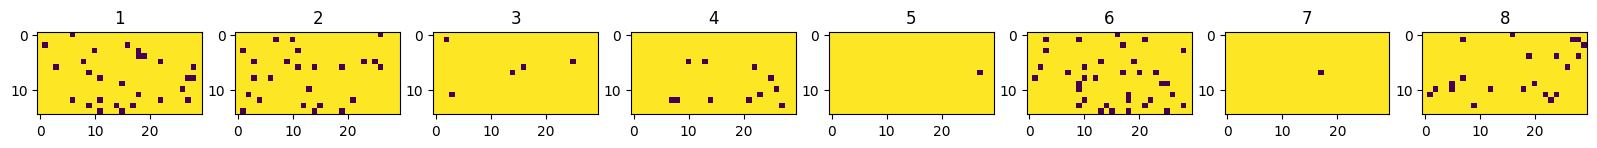

Num timesteps: 2792000
Best mean reward: -43188767.30 - Last mean reward per episode: -56694687.72


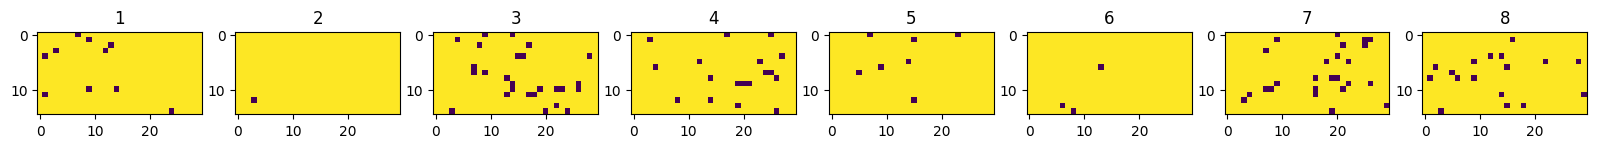

Num timesteps: 2800000
Best mean reward: -43188767.30 - Last mean reward per episode: -52824067.03


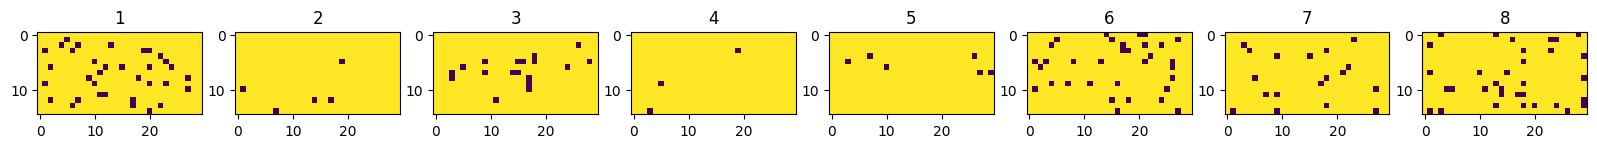

Num timesteps: 2808000
Best mean reward: -43188767.30 - Last mean reward per episode: -61853635.30


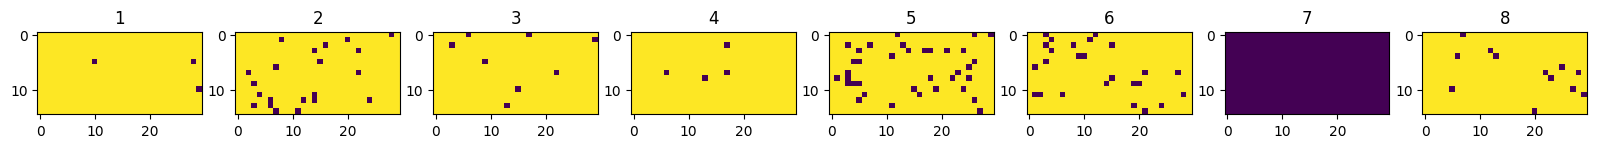

Num timesteps: 2816000
Best mean reward: -43188767.30 - Last mean reward per episode: -59234637.36


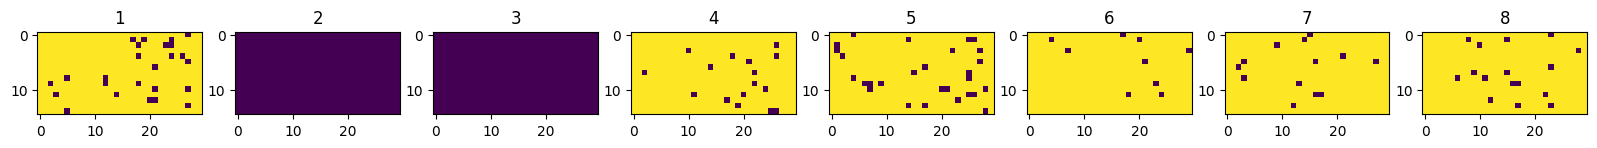

Num timesteps: 2824000
Best mean reward: -43188767.30 - Last mean reward per episode: -61430389.64


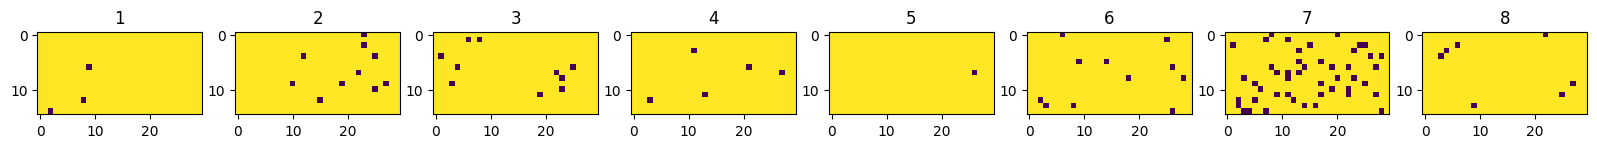

Num timesteps: 2832000
Best mean reward: -43188767.30 - Last mean reward per episode: -53055375.11


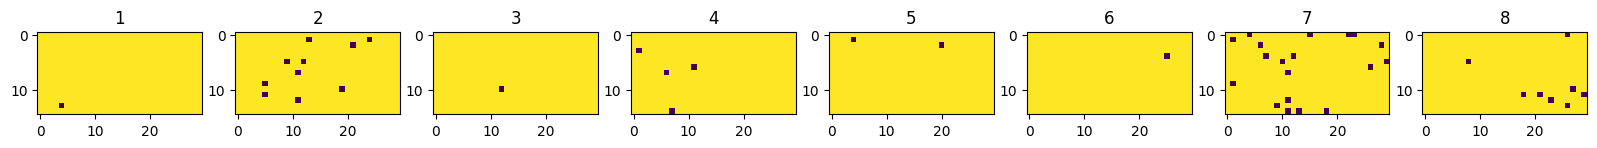

Num timesteps: 2840000
Best mean reward: -43188767.30 - Last mean reward per episode: -60474208.42


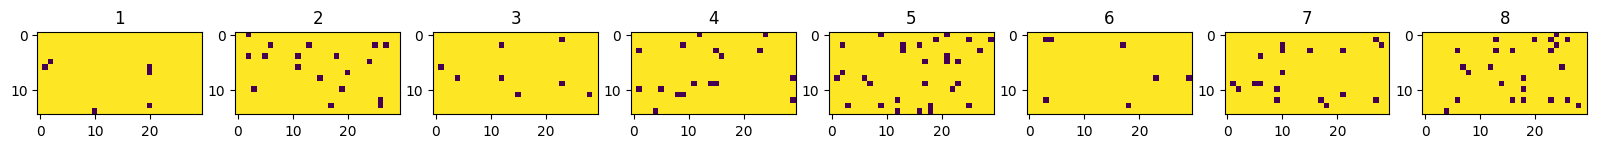

Num timesteps: 2848000
Best mean reward: -43188767.30 - Last mean reward per episode: -56029570.42


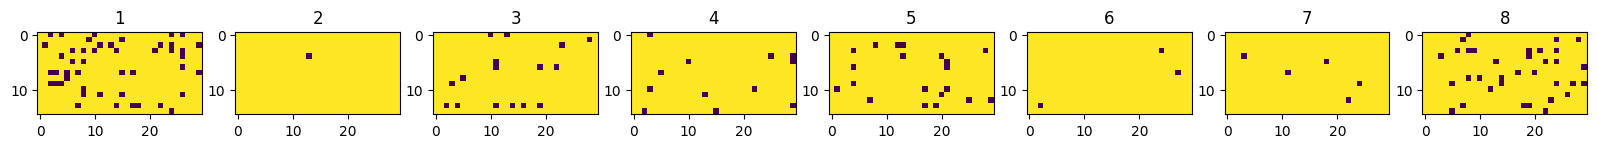

Num timesteps: 2856000
Best mean reward: -43188767.30 - Last mean reward per episode: -57708153.32


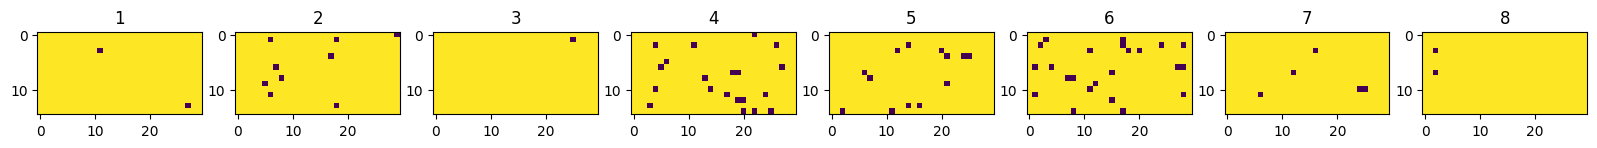

Num timesteps: 2864000
Best mean reward: -43188767.30 - Last mean reward per episode: -52826871.86


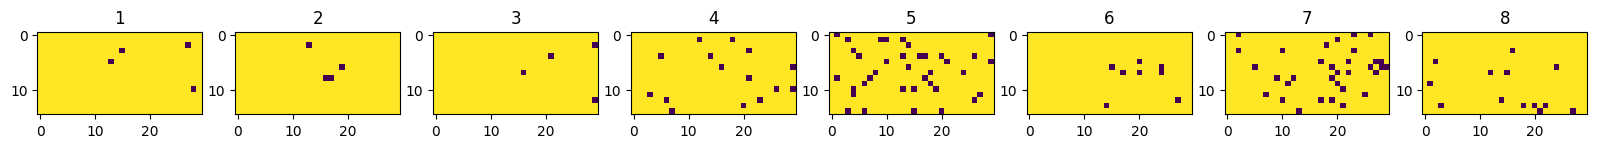

Num timesteps: 2872000
Best mean reward: -43188767.30 - Last mean reward per episode: -58672106.36


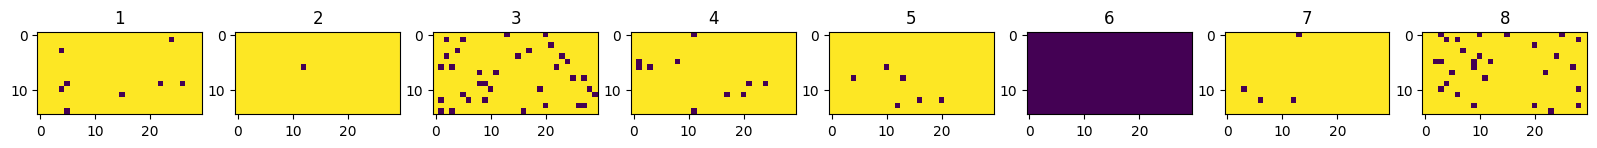

Num timesteps: 2880000
Best mean reward: -43188767.30 - Last mean reward per episode: -48269983.23


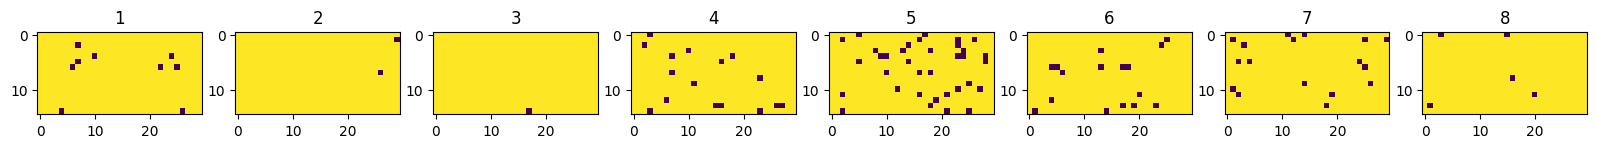

Num timesteps: 2888000
Best mean reward: -43188767.30 - Last mean reward per episode: -58182283.26


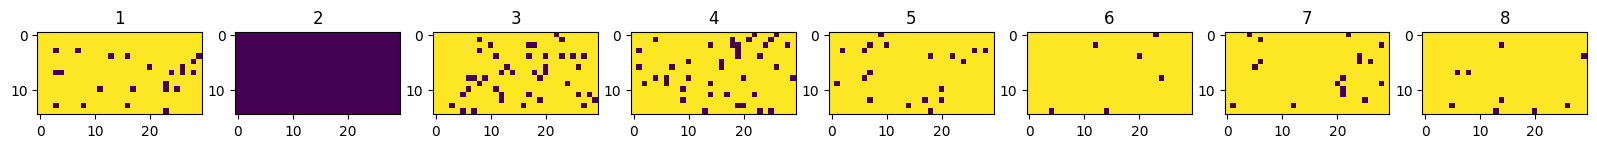

Num timesteps: 2896000
Best mean reward: -43188767.30 - Last mean reward per episode: -53704615.96


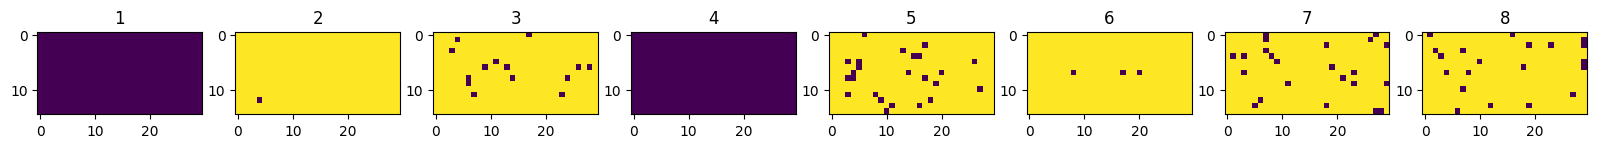

Num timesteps: 2904000
Best mean reward: -43188767.30 - Last mean reward per episode: -57488718.27


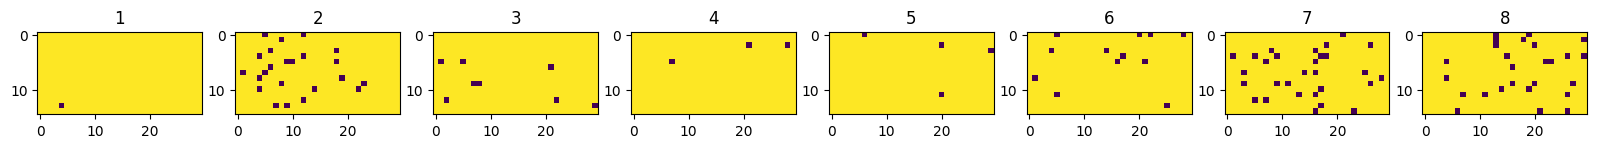

Num timesteps: 2912000
Best mean reward: -43188767.30 - Last mean reward per episode: -56854856.10


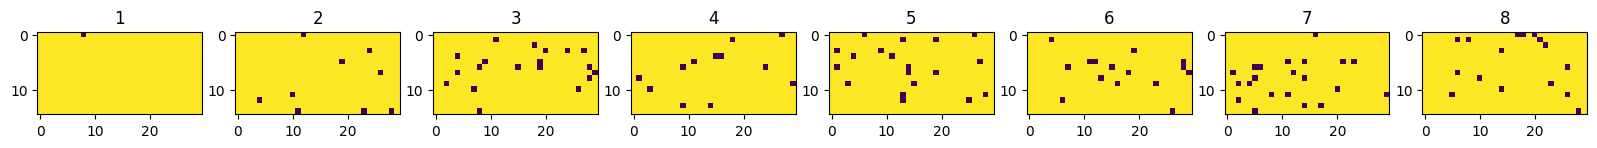

Num timesteps: 2920000
Best mean reward: -43188767.30 - Last mean reward per episode: -50476051.45


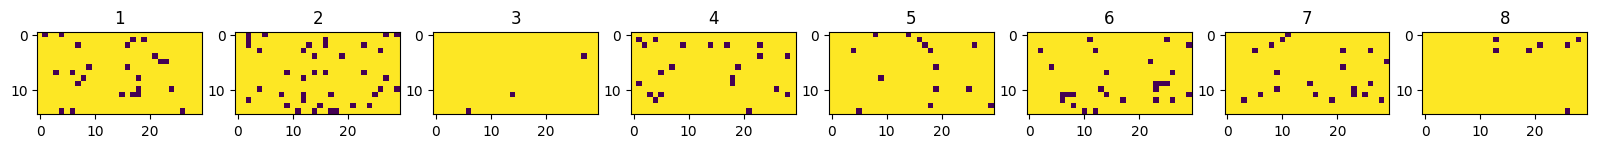

Num timesteps: 2928000
Best mean reward: -43188767.30 - Last mean reward per episode: -51331056.68


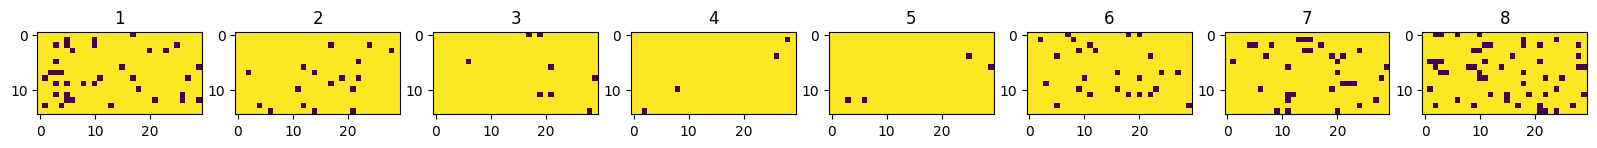

Num timesteps: 2936000
Best mean reward: -43188767.30 - Last mean reward per episode: -68251182.83


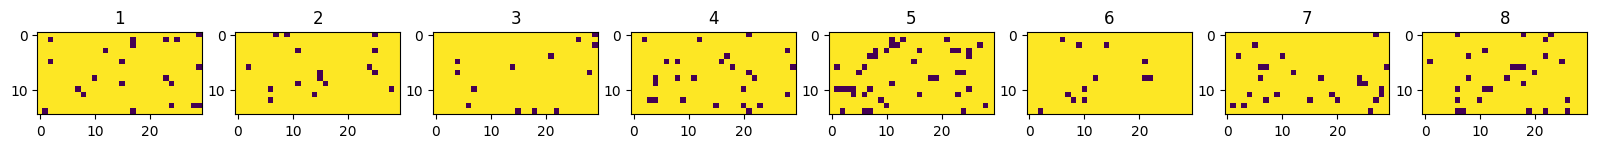

Num timesteps: 2944000
Best mean reward: -43188767.30 - Last mean reward per episode: -57391852.77


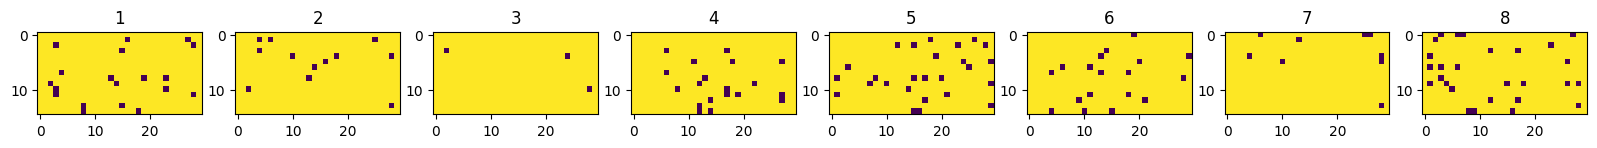

Num timesteps: 2952000
Best mean reward: -43188767.30 - Last mean reward per episode: -59656723.49


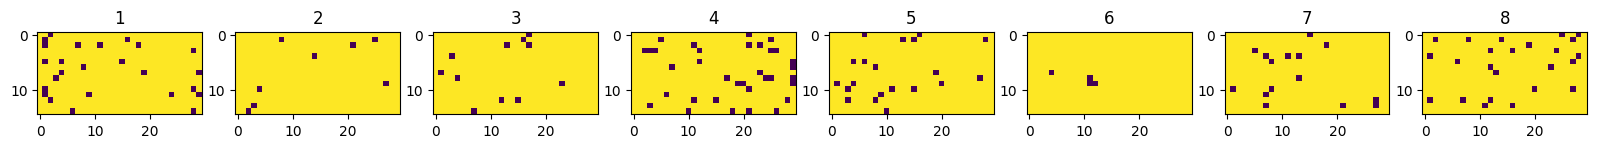

Num timesteps: 2960000
Best mean reward: -43188767.30 - Last mean reward per episode: -60974021.92


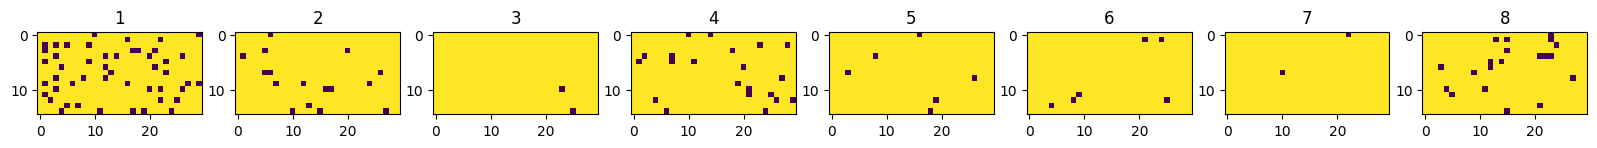

Num timesteps: 2968000
Best mean reward: -43188767.30 - Last mean reward per episode: -61560204.62


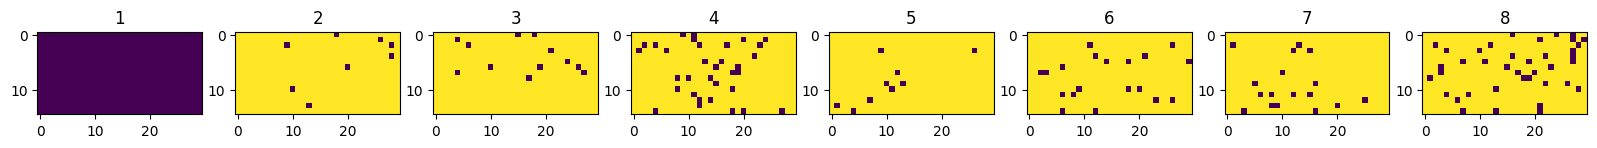

Num timesteps: 2976000
Best mean reward: -43188767.30 - Last mean reward per episode: -63456423.63


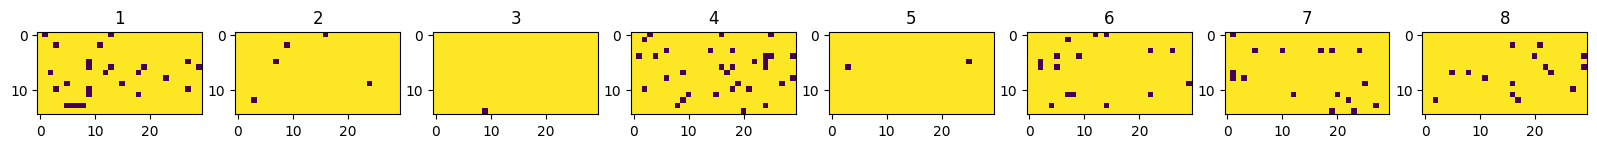

Num timesteps: 2984000
Best mean reward: -43188767.30 - Last mean reward per episode: -60399890.61


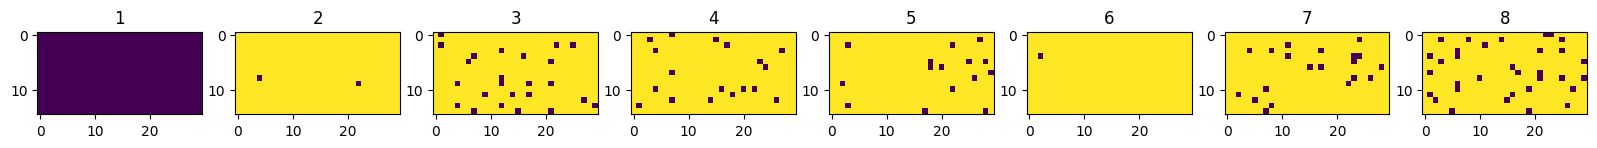

Num timesteps: 2992000
Best mean reward: -43188767.30 - Last mean reward per episode: -63553497.99


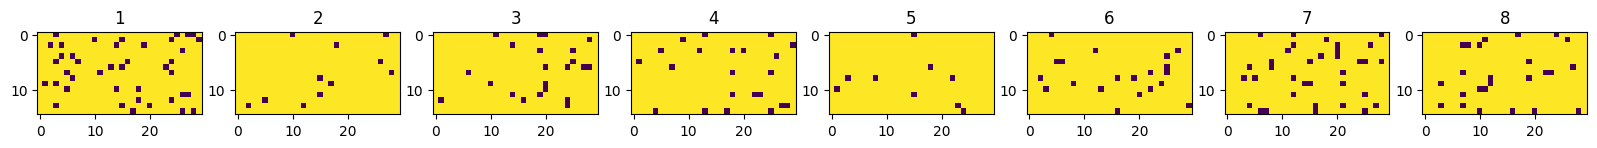

Num timesteps: 3000000
Best mean reward: -43188767.30 - Last mean reward per episode: -57680128.96


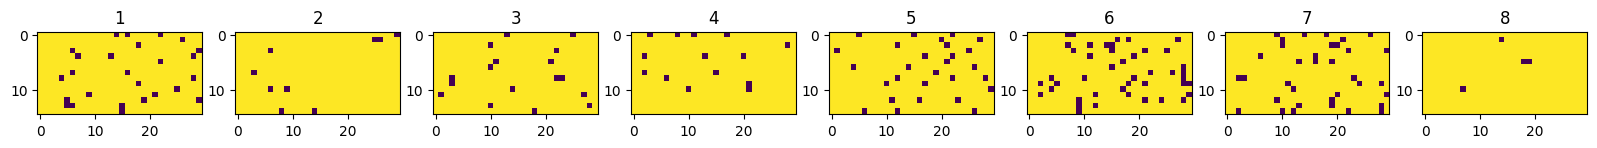

Num timesteps: 3008000
Best mean reward: -43188767.30 - Last mean reward per episode: -53559605.00


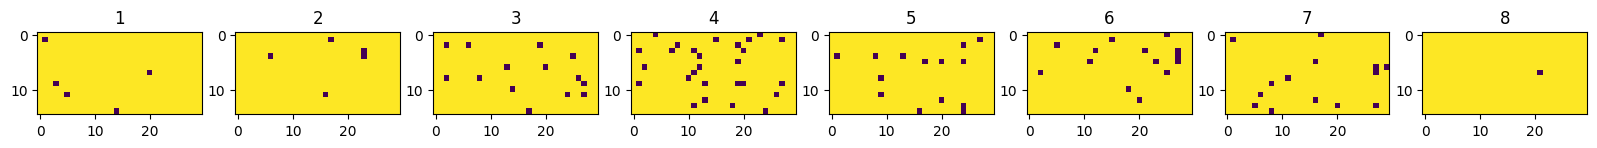

Num timesteps: 3016000
Best mean reward: -43188767.30 - Last mean reward per episode: -54876729.64


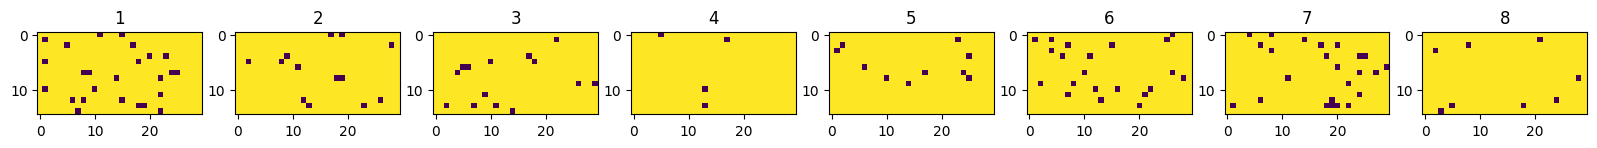

Num timesteps: 3024000
Best mean reward: -43188767.30 - Last mean reward per episode: -62279958.74


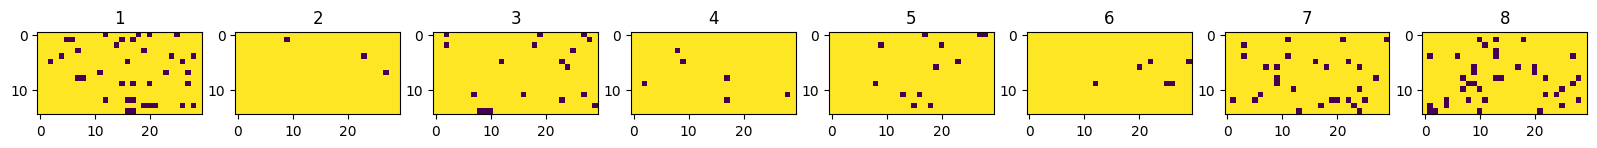

Num timesteps: 3032000
Best mean reward: -43188767.30 - Last mean reward per episode: -65255337.77


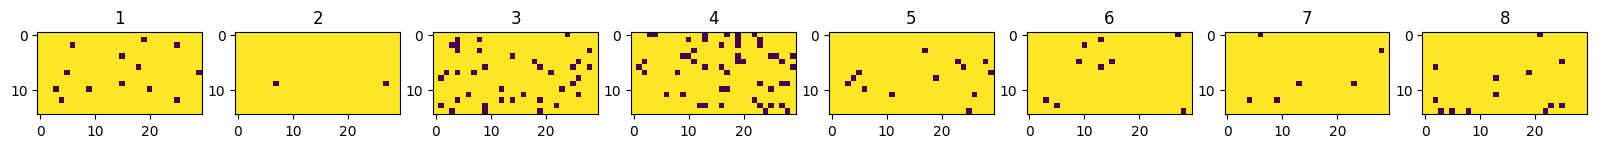

Num timesteps: 3040000
Best mean reward: -43188767.30 - Last mean reward per episode: -50616236.40


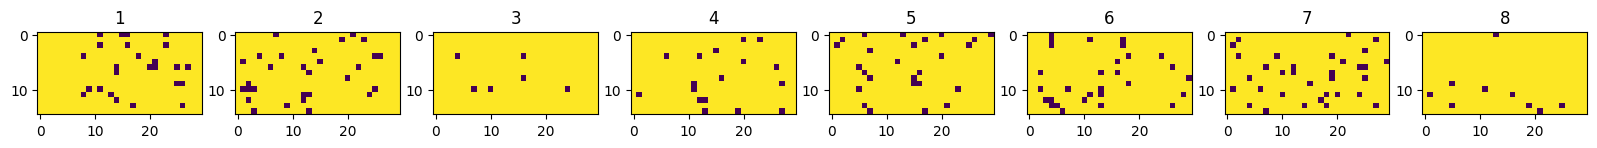

Num timesteps: 3048000
Best mean reward: -43188767.30 - Last mean reward per episode: -55543183.20


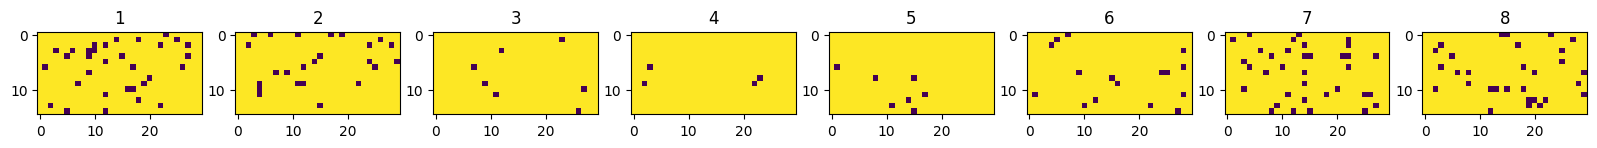

Num timesteps: 3056000
Best mean reward: -43188767.30 - Last mean reward per episode: -63769260.36


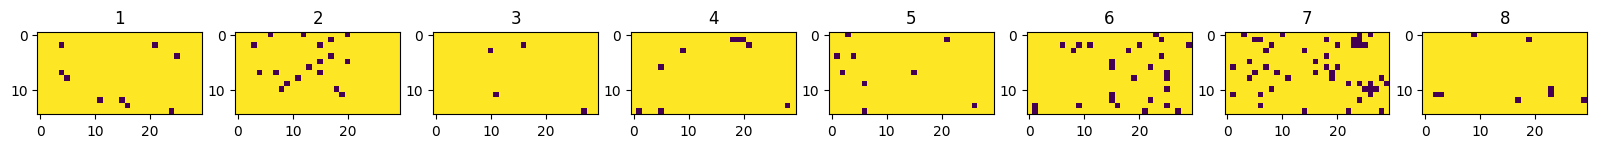

Num timesteps: 3064000
Best mean reward: -43188767.30 - Last mean reward per episode: -58377137.97


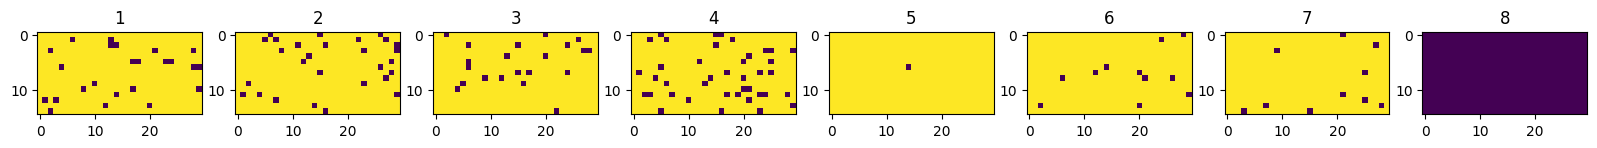

Num timesteps: 3072000
Best mean reward: -43188767.30 - Last mean reward per episode: -60160993.25


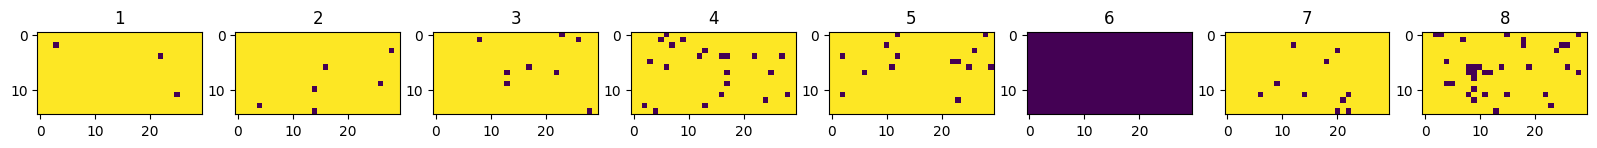

Num timesteps: 3080000
Best mean reward: -43188767.30 - Last mean reward per episode: -57333189.12


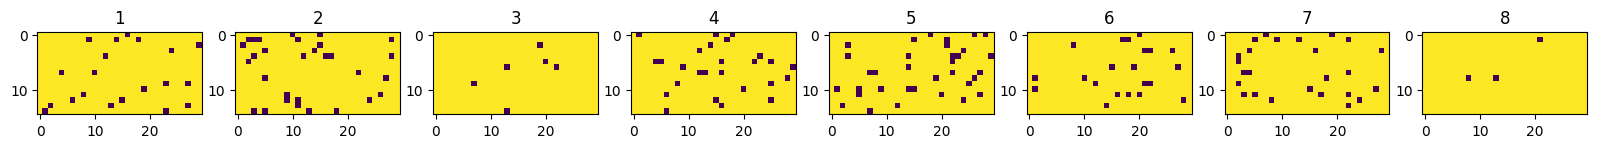

Num timesteps: 3088000
Best mean reward: -43188767.30 - Last mean reward per episode: -53203158.49


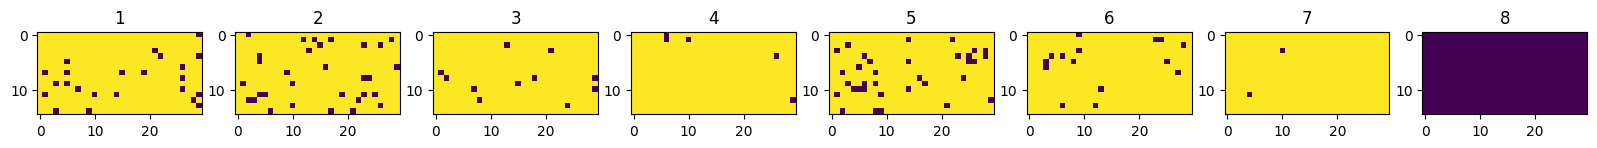

Num timesteps: 3096000
Best mean reward: -43188767.30 - Last mean reward per episode: -57881627.83


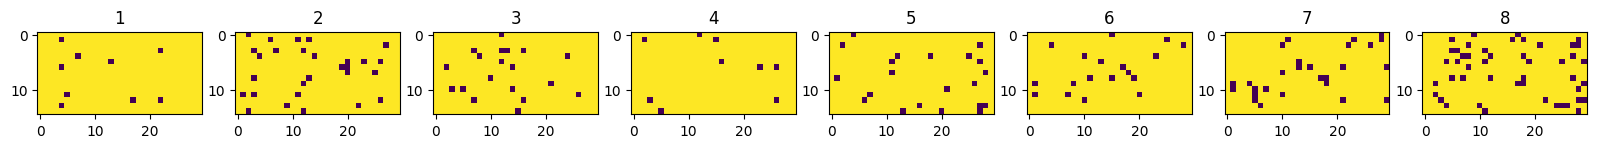

Num timesteps: 3104000
Best mean reward: -43188767.30 - Last mean reward per episode: -54460090.08


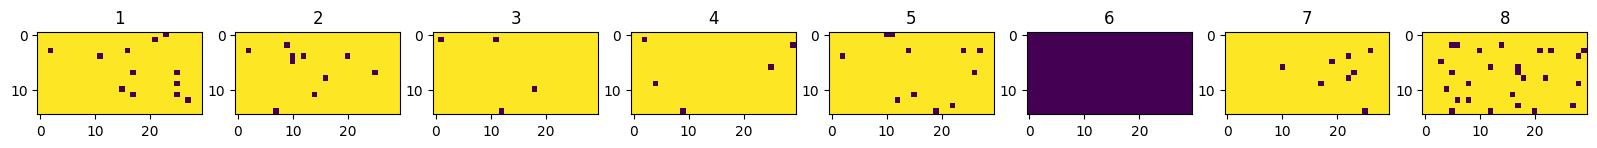

Num timesteps: 3112000
Best mean reward: -43188767.30 - Last mean reward per episode: -57633296.62


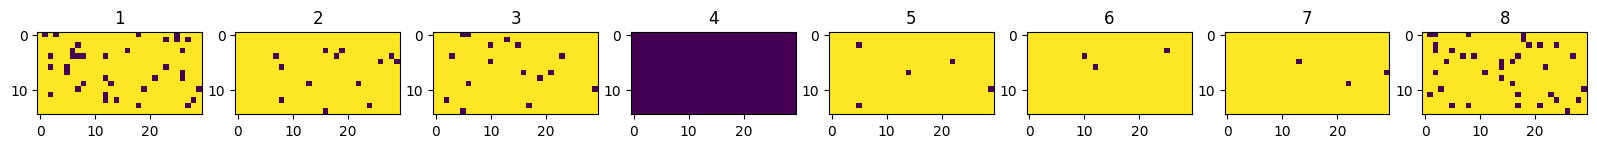

Num timesteps: 3120000
Best mean reward: -43188767.30 - Last mean reward per episode: -56689229.12


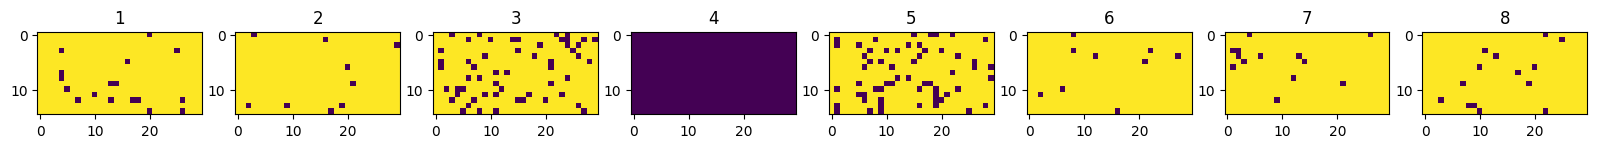

Num timesteps: 3128000
Best mean reward: -43188767.30 - Last mean reward per episode: -59992729.53


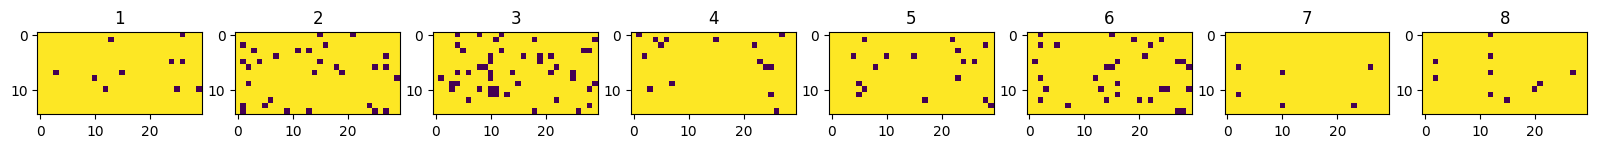

Num timesteps: 3136000
Best mean reward: -43188767.30 - Last mean reward per episode: -54185921.64


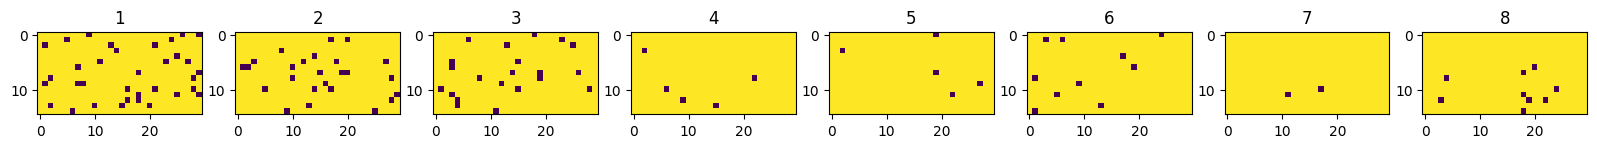

Num timesteps: 3144000
Best mean reward: -43188767.30 - Last mean reward per episode: -60147700.98


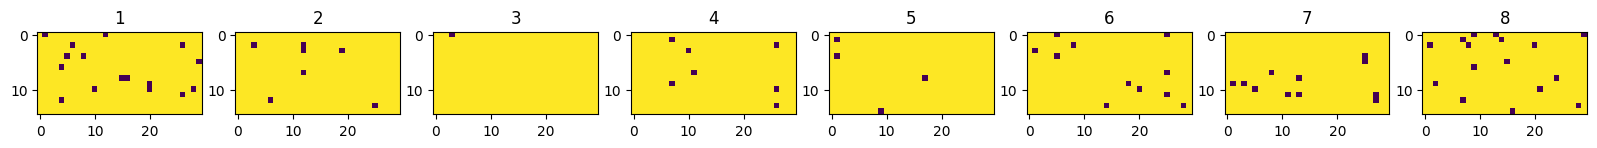

Num timesteps: 3152000
Best mean reward: -43188767.30 - Last mean reward per episode: -64355919.62


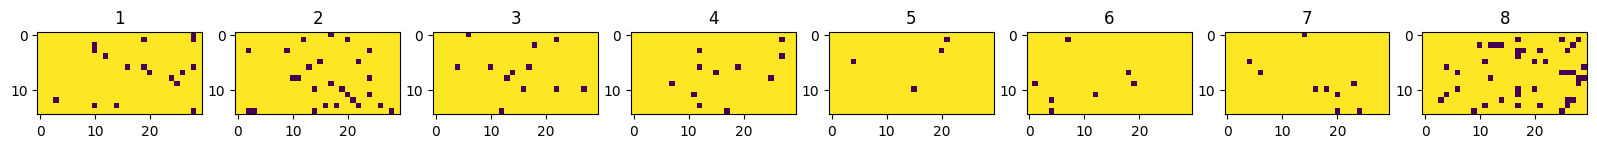

Num timesteps: 3160000
Best mean reward: -43188767.30 - Last mean reward per episode: -66008386.64


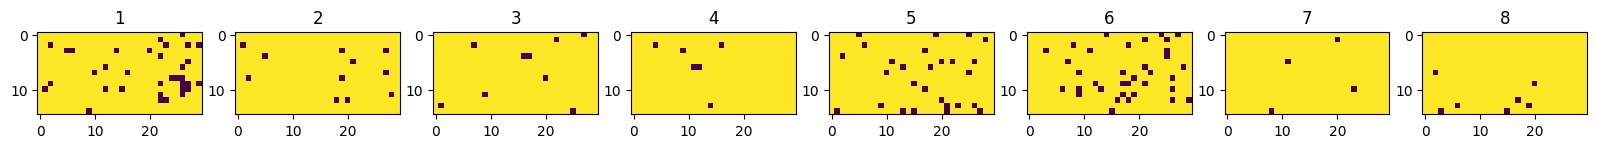

Num timesteps: 3168000
Best mean reward: -43188767.30 - Last mean reward per episode: -56895035.25


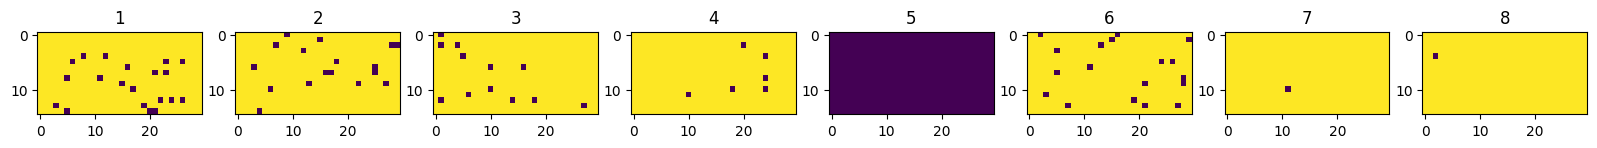

Num timesteps: 3176000
Best mean reward: -43188767.30 - Last mean reward per episode: -56773521.80


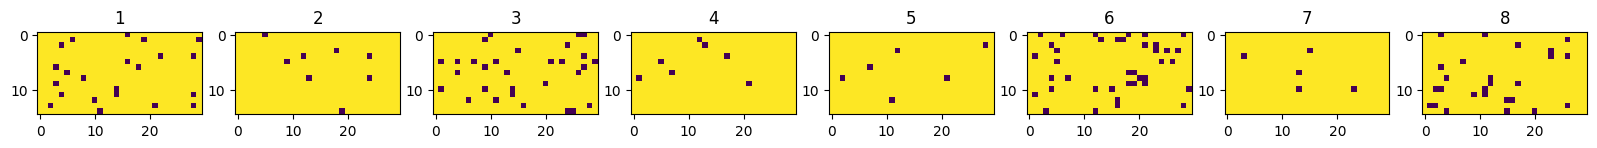

Num timesteps: 3184000
Best mean reward: -43188767.30 - Last mean reward per episode: -63028381.70


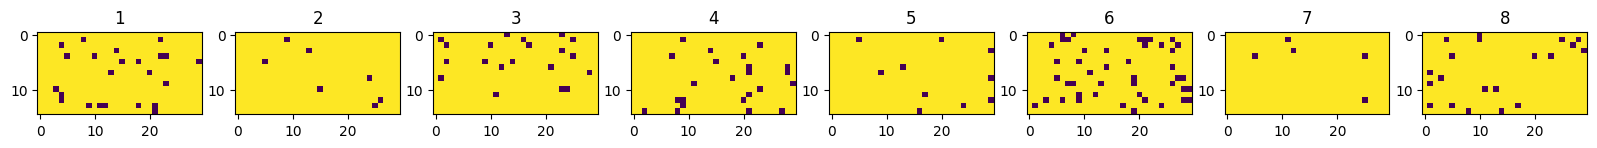

Num timesteps: 3192000
Best mean reward: -43188767.30 - Last mean reward per episode: -57430851.19


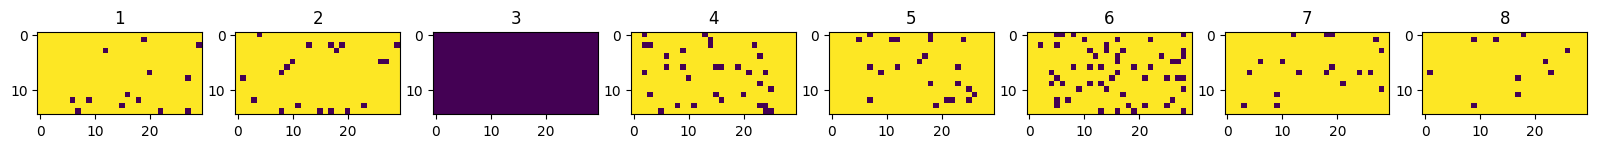

Num timesteps: 3200000
Best mean reward: -43188767.30 - Last mean reward per episode: -54887469.46


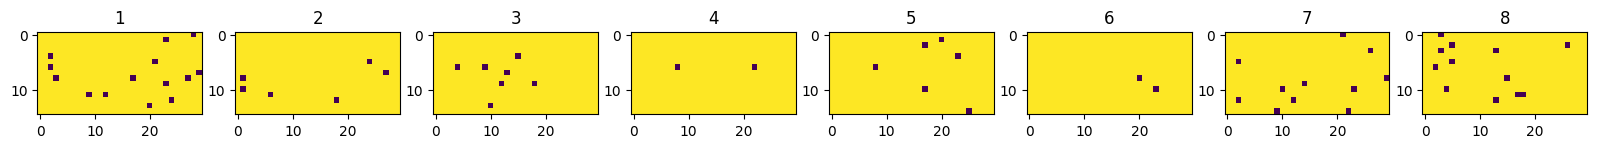

Num timesteps: 3208000
Best mean reward: -43188767.30 - Last mean reward per episode: -65615295.17


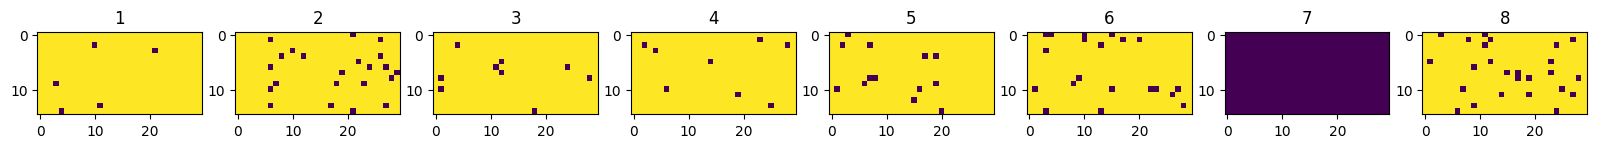

Num timesteps: 3216000
Best mean reward: -43188767.30 - Last mean reward per episode: -56005970.17


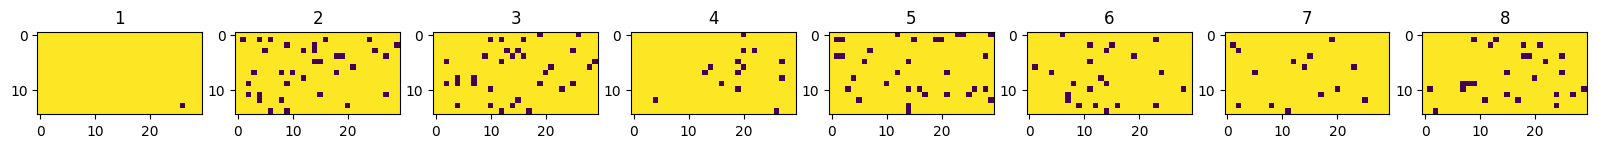

Num timesteps: 3224000
Best mean reward: -43188767.30 - Last mean reward per episode: -55833832.59


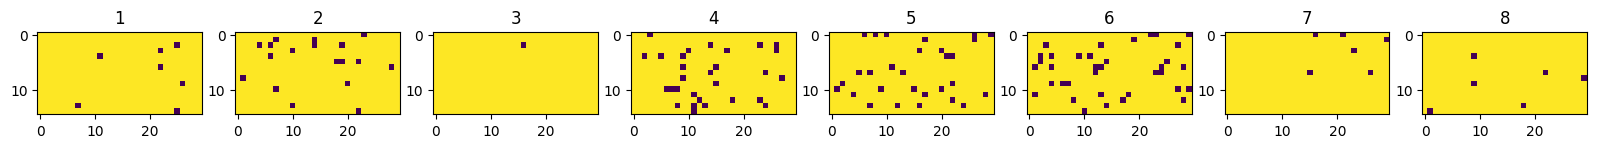

Num timesteps: 3232000
Best mean reward: -43188767.30 - Last mean reward per episode: -61269703.13


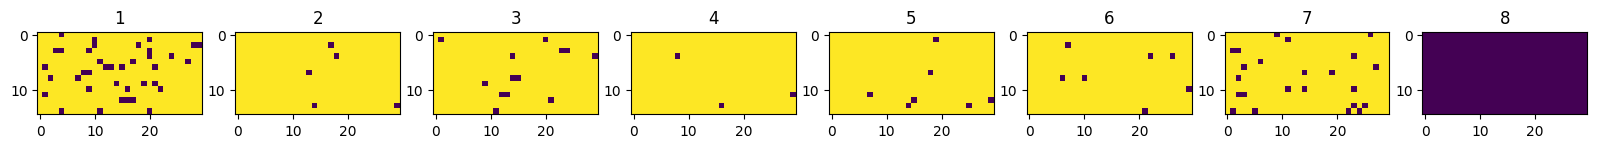

Num timesteps: 3240000
Best mean reward: -43188767.30 - Last mean reward per episode: -46909644.59


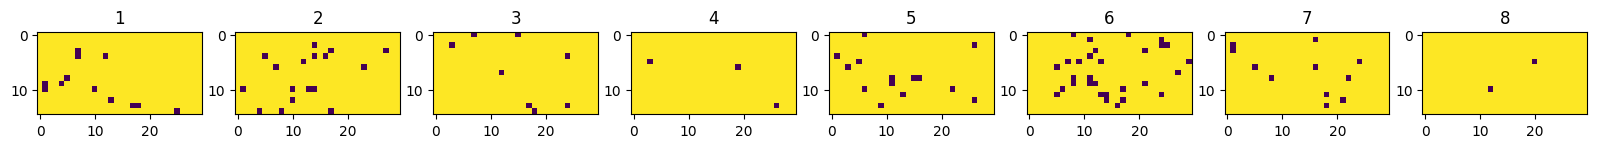

Num timesteps: 3248000
Best mean reward: -43188767.30 - Last mean reward per episode: -61951850.55


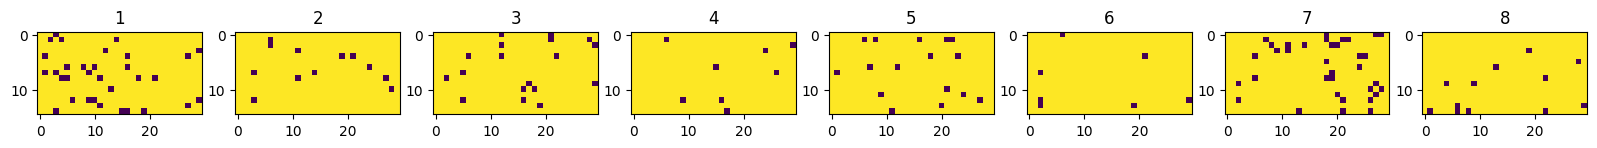

Num timesteps: 3256000
Best mean reward: -43188767.30 - Last mean reward per episode: -50366197.31


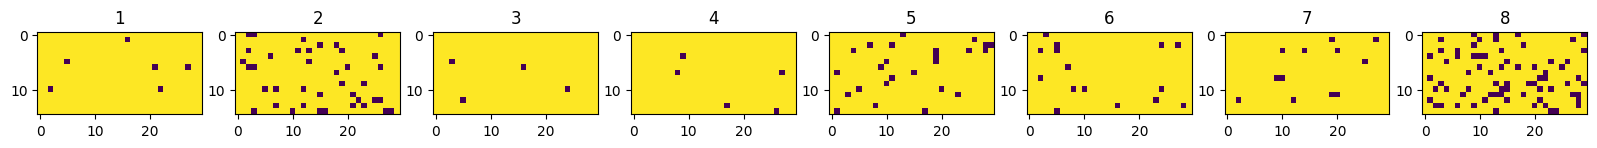

Num timesteps: 3264000
Best mean reward: -43188767.30 - Last mean reward per episode: -60138297.77


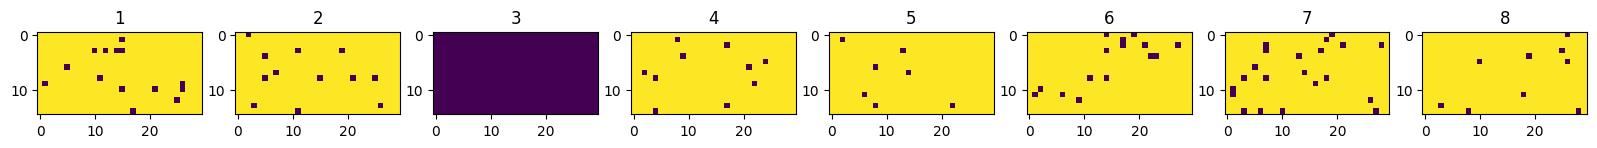

Num timesteps: 3272000
Best mean reward: -43188767.30 - Last mean reward per episode: -56644319.32


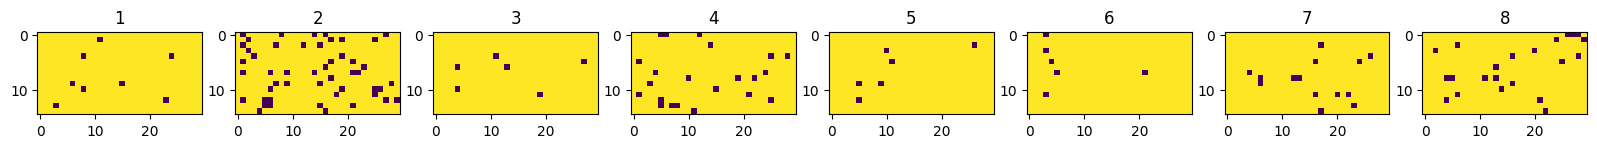

Num timesteps: 3280000
Best mean reward: -43188767.30 - Last mean reward per episode: -60469265.20


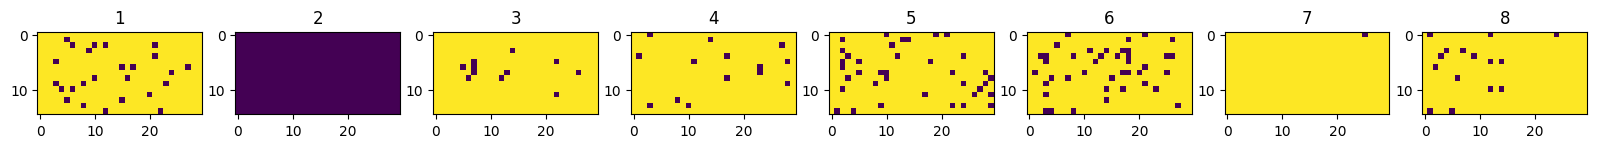

Num timesteps: 3288000
Best mean reward: -43188767.30 - Last mean reward per episode: -54842134.87


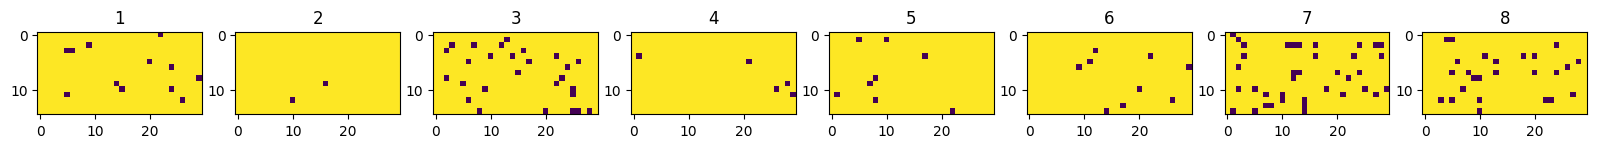

Num timesteps: 3296000
Best mean reward: -43188767.30 - Last mean reward per episode: -60623587.43


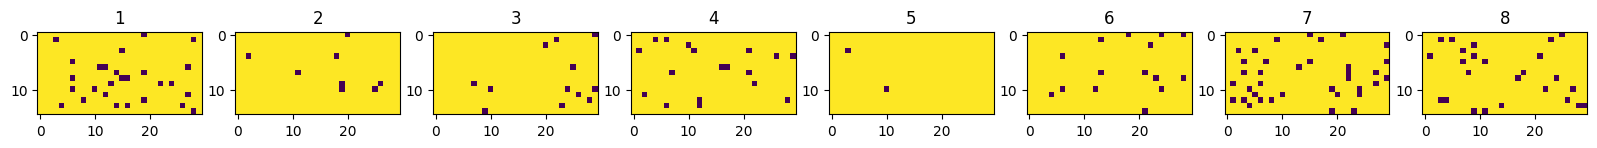

Num timesteps: 3304000
Best mean reward: -43188767.30 - Last mean reward per episode: -57555382.93


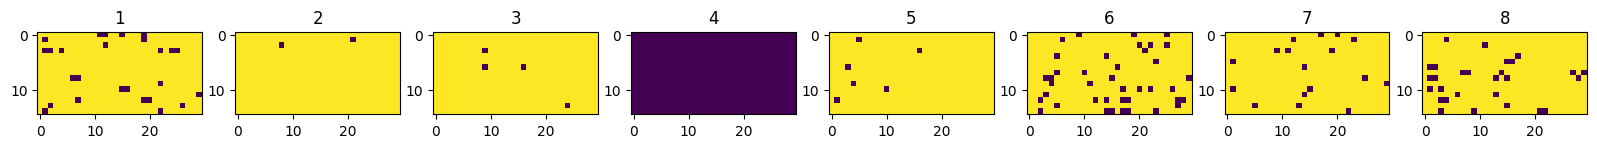

Num timesteps: 3312000
Best mean reward: -43188767.30 - Last mean reward per episode: -54612928.48


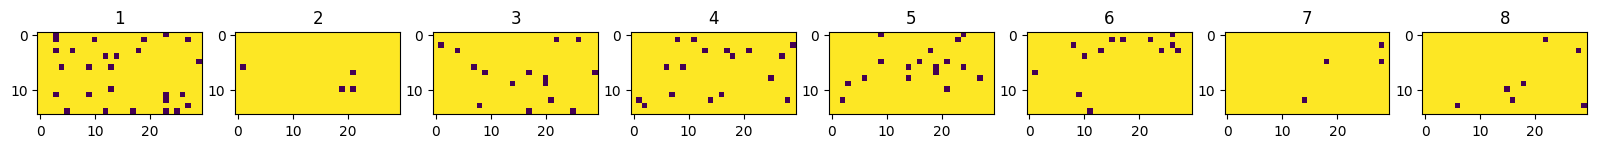

Num timesteps: 3320000
Best mean reward: -43188767.30 - Last mean reward per episode: -57512389.82


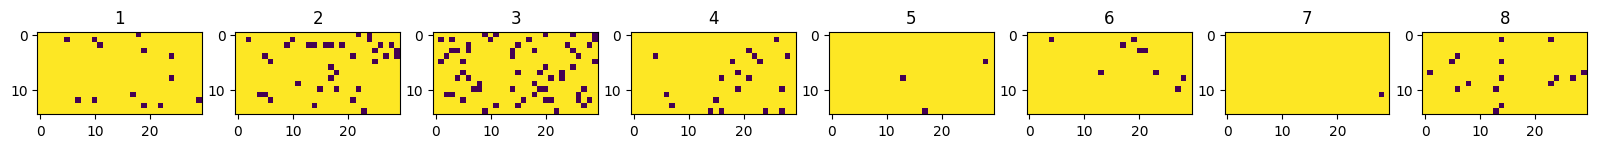

Num timesteps: 3328000
Best mean reward: -43188767.30 - Last mean reward per episode: -60632639.03


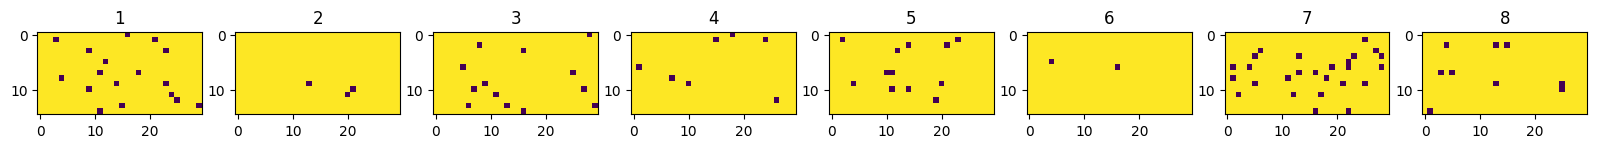

Num timesteps: 3336000
Best mean reward: -43188767.30 - Last mean reward per episode: -60972085.59


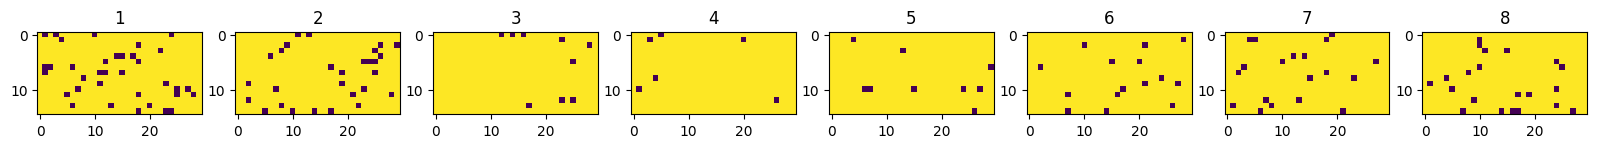

Num timesteps: 3344000
Best mean reward: -43188767.30 - Last mean reward per episode: -64994297.12


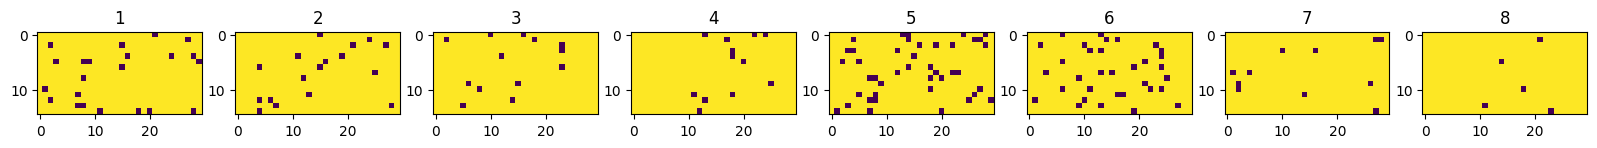

Num timesteps: 3352000
Best mean reward: -43188767.30 - Last mean reward per episode: -53298814.71


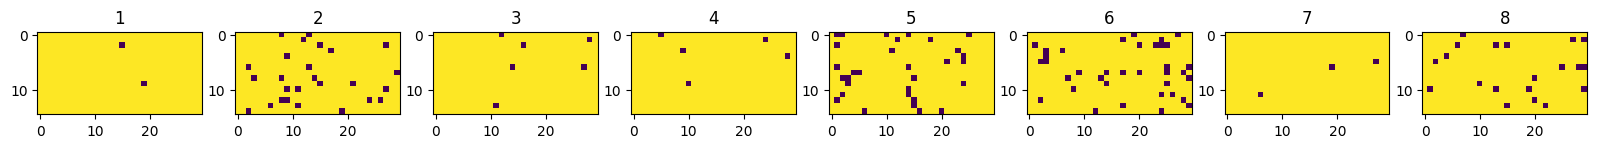

Num timesteps: 3360000
Best mean reward: -43188767.30 - Last mean reward per episode: -55468680.49


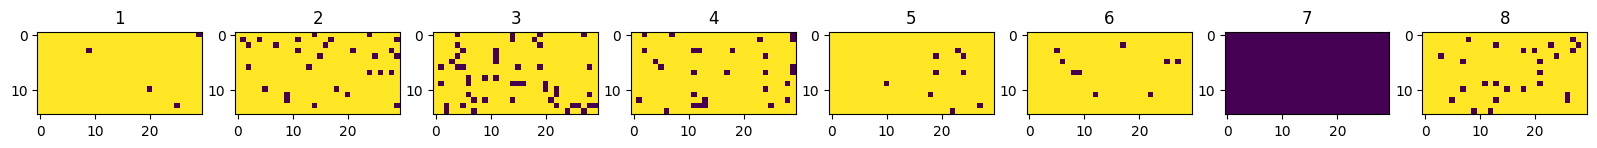

Num timesteps: 3368000
Best mean reward: -43188767.30 - Last mean reward per episode: -53416603.47


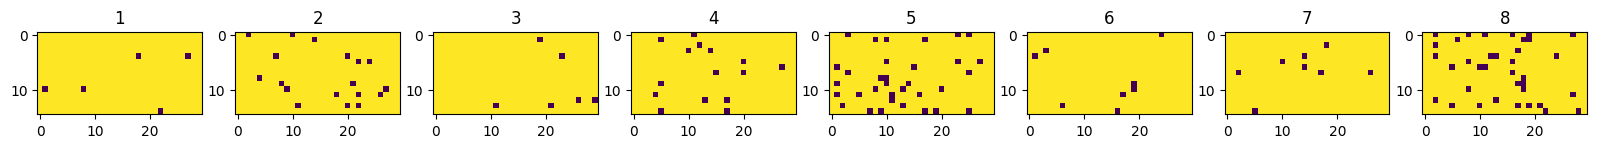

Num timesteps: 3376000
Best mean reward: -43188767.30 - Last mean reward per episode: -62991313.46


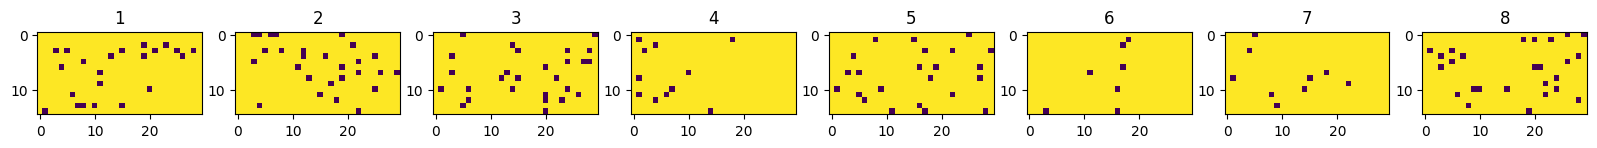

Num timesteps: 3384000
Best mean reward: -43188767.30 - Last mean reward per episode: -57653483.37


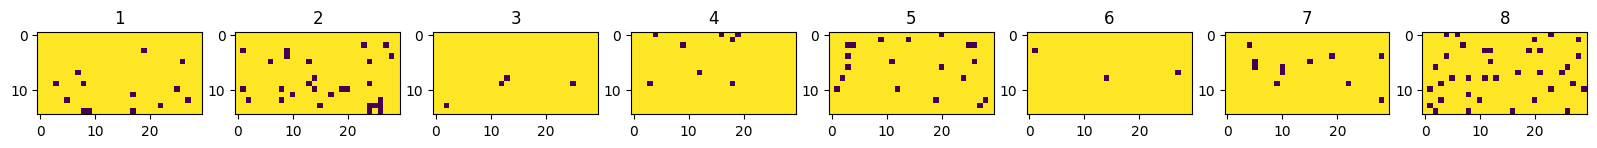

Num timesteps: 3392000
Best mean reward: -43188767.30 - Last mean reward per episode: -60402138.90


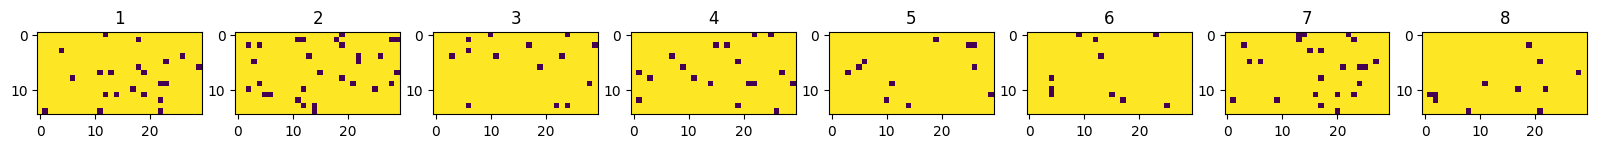

Num timesteps: 3400000
Best mean reward: -43188767.30 - Last mean reward per episode: -66524999.72


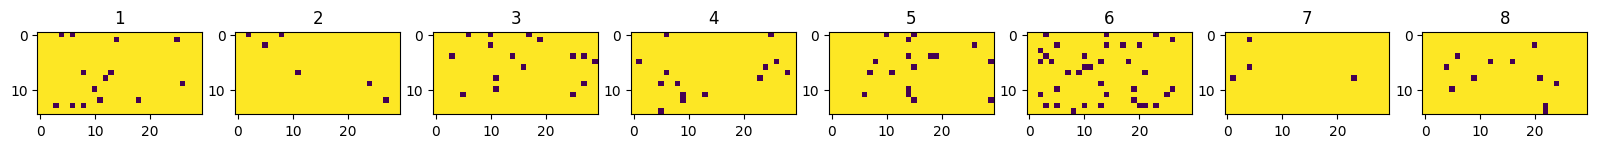

Num timesteps: 3408000
Best mean reward: -43188767.30 - Last mean reward per episode: -52911227.38


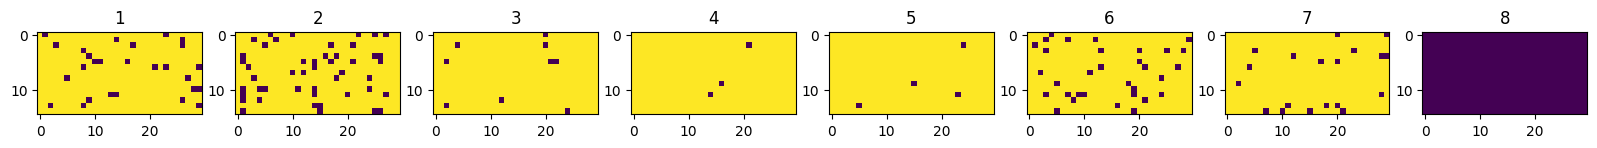

Num timesteps: 3416000
Best mean reward: -43188767.30 - Last mean reward per episode: -65528634.20


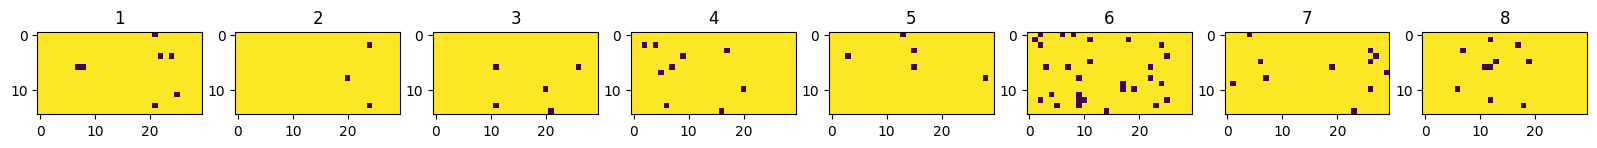

Num timesteps: 3424000
Best mean reward: -43188767.30 - Last mean reward per episode: -51760328.98


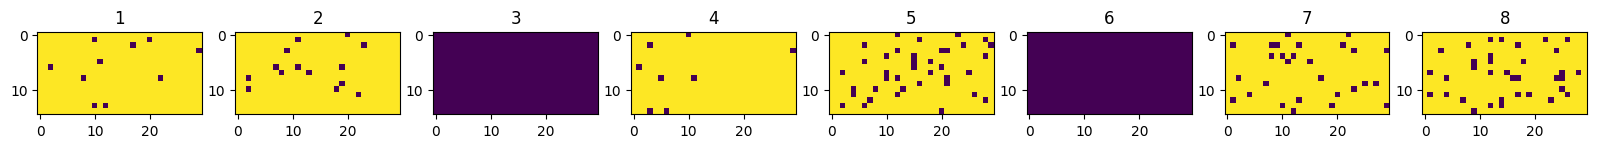

Num timesteps: 3432000
Best mean reward: -43188767.30 - Last mean reward per episode: -53269948.30


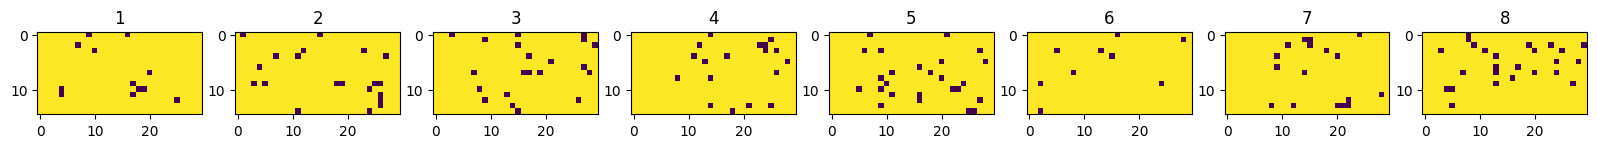

Num timesteps: 3440000
Best mean reward: -43188767.30 - Last mean reward per episode: -48702026.68


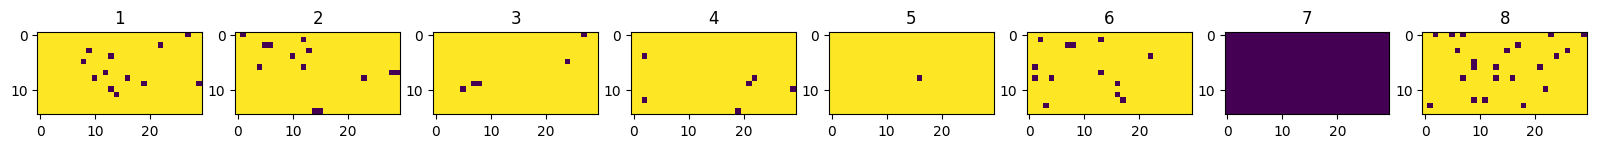

Num timesteps: 3448000
Best mean reward: -43188767.30 - Last mean reward per episode: -56940963.19


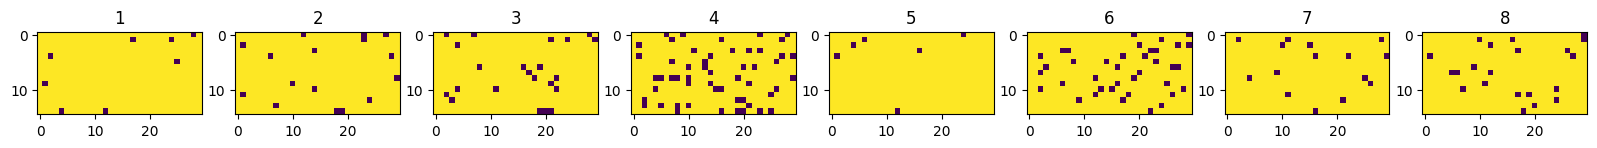

Num timesteps: 3456000
Best mean reward: -43188767.30 - Last mean reward per episode: -60859111.50


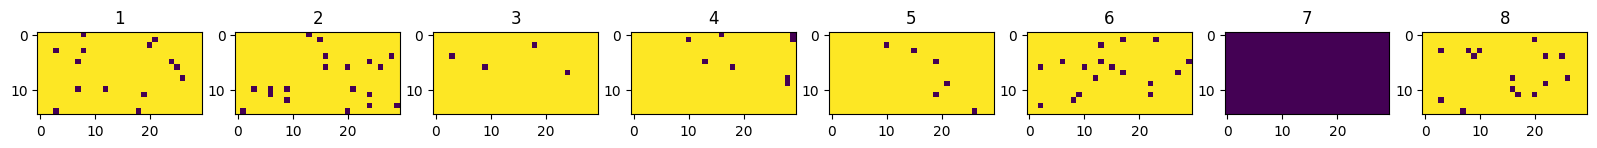

Num timesteps: 3464000
Best mean reward: -43188767.30 - Last mean reward per episode: -59809389.76


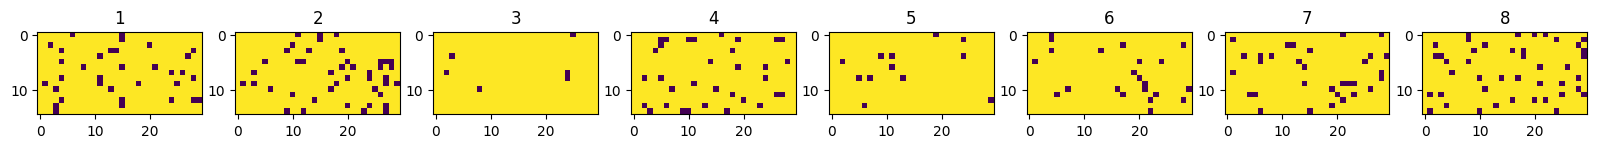

Num timesteps: 3472000
Best mean reward: -43188767.30 - Last mean reward per episode: -54173076.90


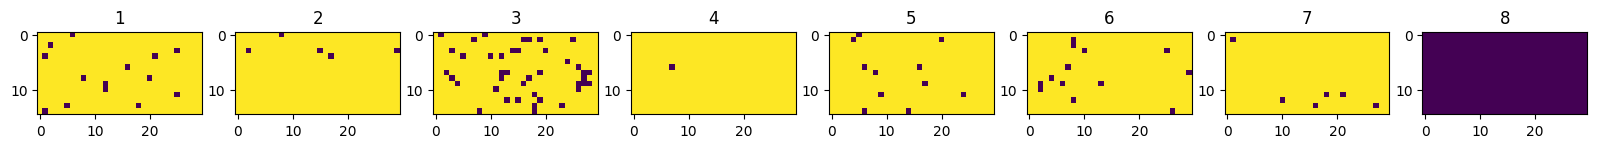

Num timesteps: 3480000
Best mean reward: -43188767.30 - Last mean reward per episode: -51877791.88


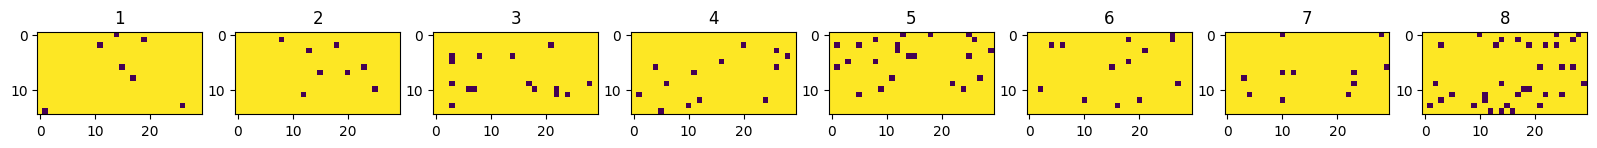

Num timesteps: 3488000
Best mean reward: -43188767.30 - Last mean reward per episode: -60483582.12


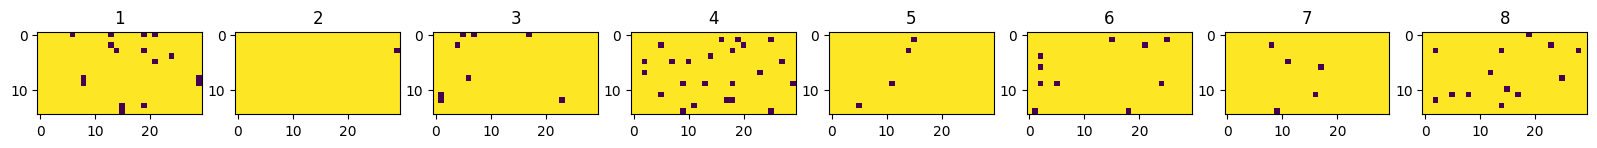

Num timesteps: 3496000
Best mean reward: -43188767.30 - Last mean reward per episode: -53795505.87


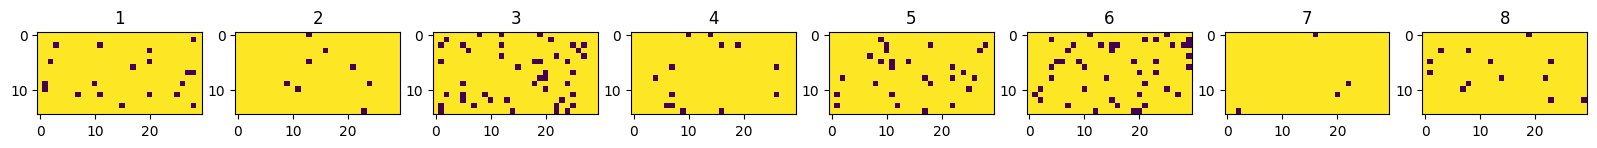

Num timesteps: 3504000
Best mean reward: -43188767.30 - Last mean reward per episode: -60778911.27


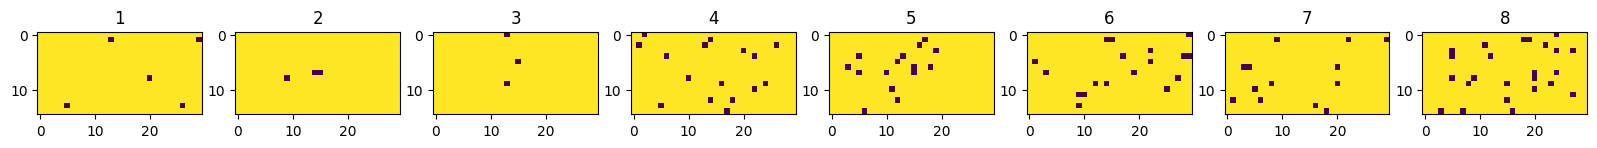

Num timesteps: 3512000
Best mean reward: -43188767.30 - Last mean reward per episode: -60515433.17


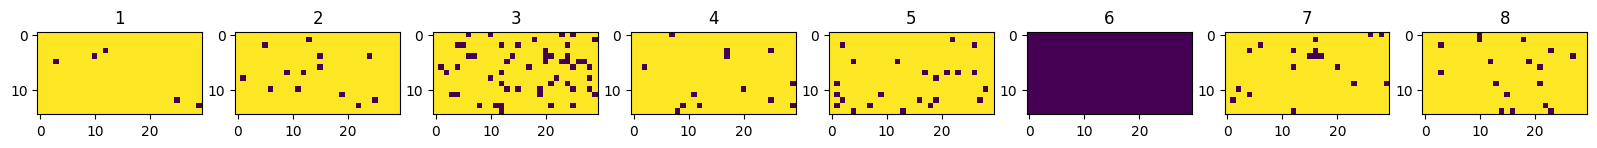

Num timesteps: 3520000
Best mean reward: -43188767.30 - Last mean reward per episode: -64039932.58


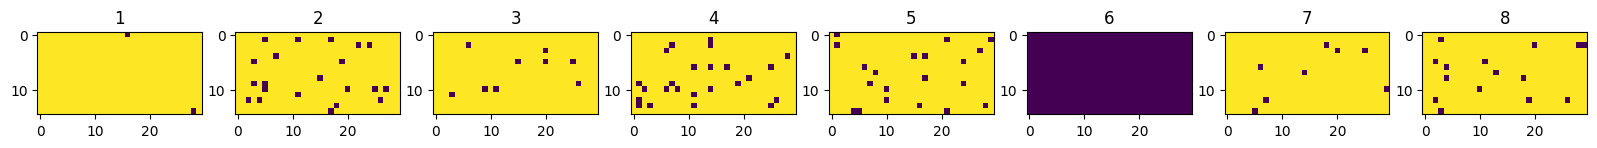

Num timesteps: 3528000
Best mean reward: -43188767.30 - Last mean reward per episode: -55988263.35


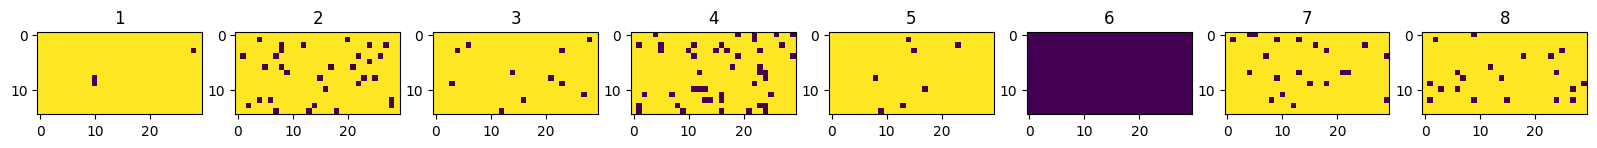

Num timesteps: 3536000
Best mean reward: -43188767.30 - Last mean reward per episode: -56994177.07


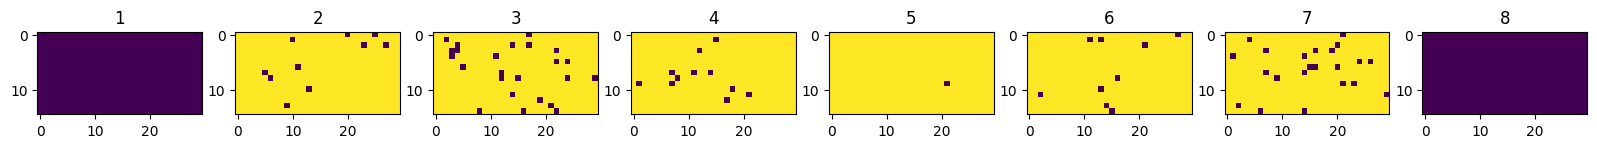

Num timesteps: 3544000
Best mean reward: -43188767.30 - Last mean reward per episode: -57831484.62


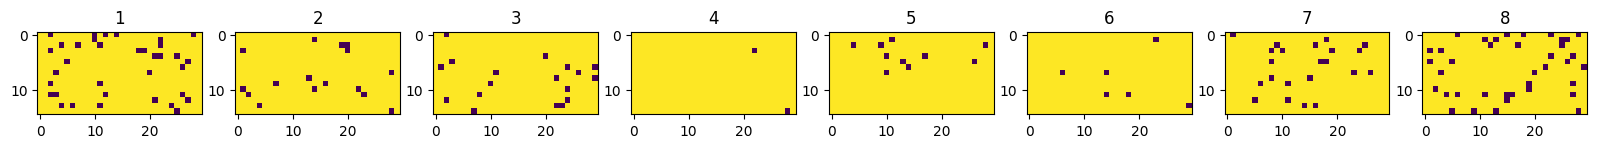

Num timesteps: 3552000
Best mean reward: -43188767.30 - Last mean reward per episode: -57830800.33


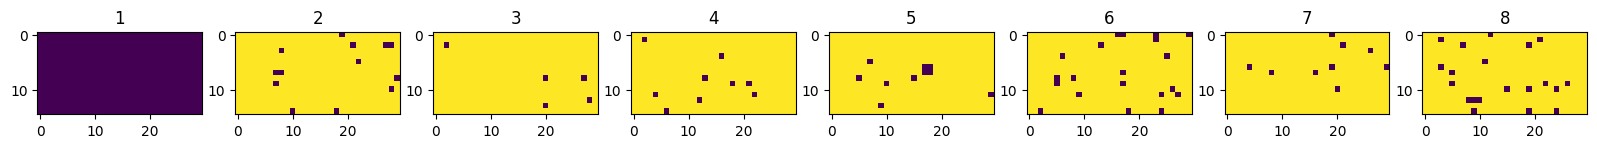

Num timesteps: 3560000
Best mean reward: -43188767.30 - Last mean reward per episode: -55302044.64


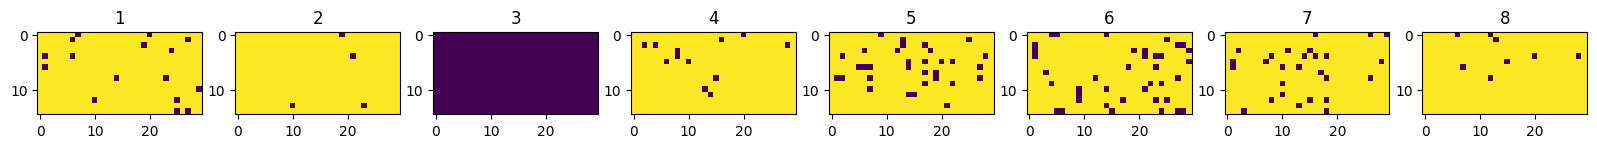

Num timesteps: 3568000
Best mean reward: -43188767.30 - Last mean reward per episode: -60450801.92


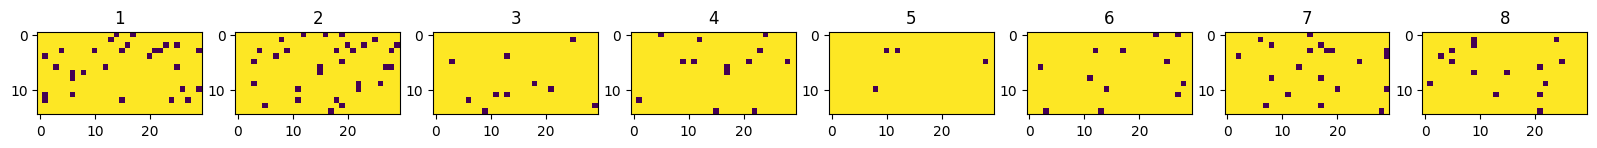

Num timesteps: 3576000
Best mean reward: -43188767.30 - Last mean reward per episode: -59231310.78


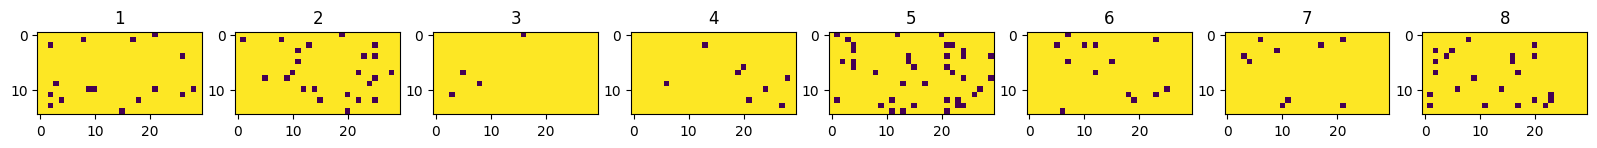

Num timesteps: 3584000
Best mean reward: -43188767.30 - Last mean reward per episode: -55933731.89


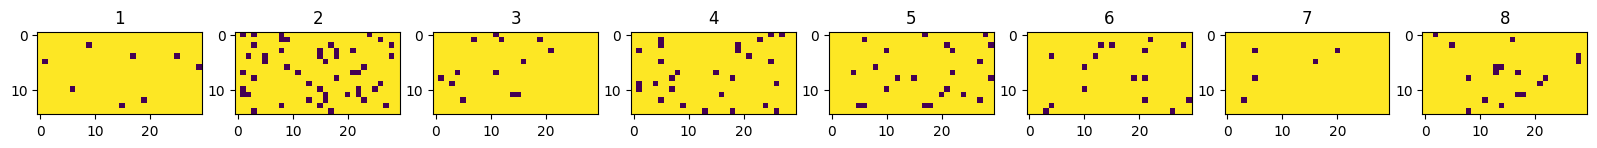

Num timesteps: 3592000
Best mean reward: -43188767.30 - Last mean reward per episode: -56586680.70


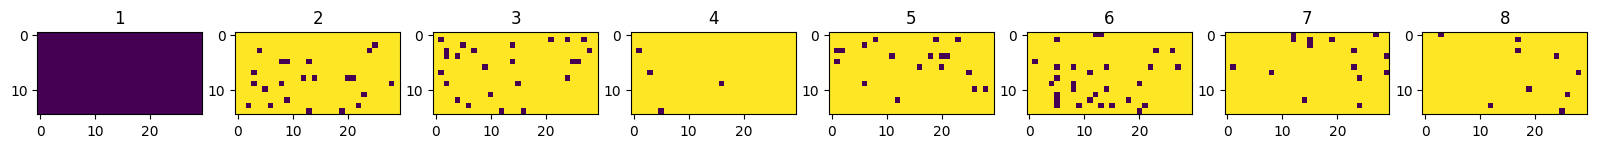

Num timesteps: 3600000
Best mean reward: -43188767.30 - Last mean reward per episode: -51038751.99


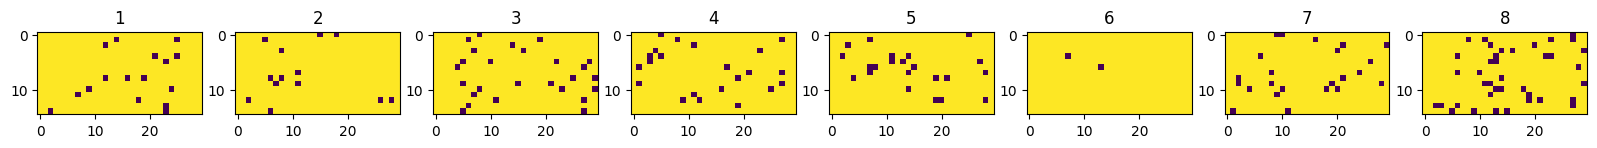

Num timesteps: 3608000
Best mean reward: -43188767.30 - Last mean reward per episode: -57925157.33


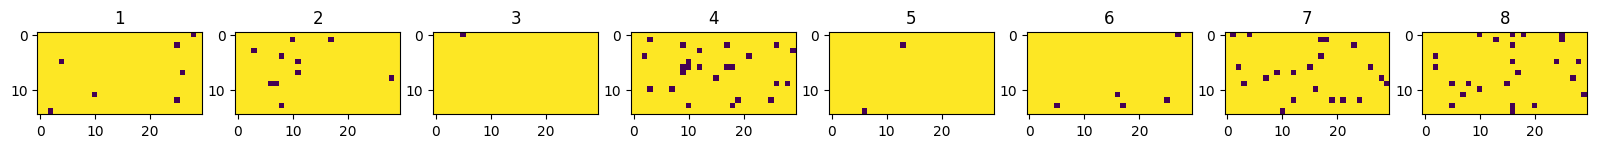

Num timesteps: 3616000
Best mean reward: -43188767.30 - Last mean reward per episode: -55701414.24


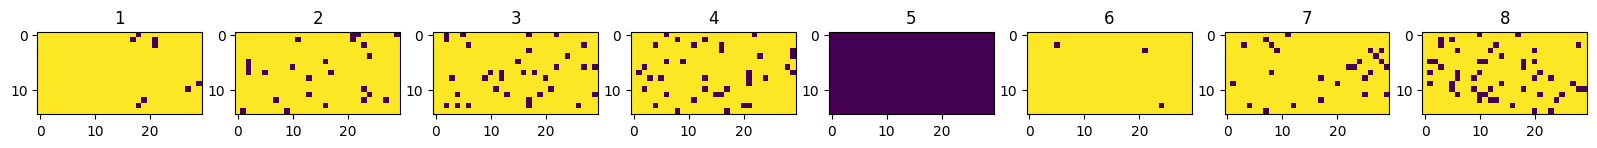

Num timesteps: 3624000
Best mean reward: -43188767.30 - Last mean reward per episode: -57045670.72


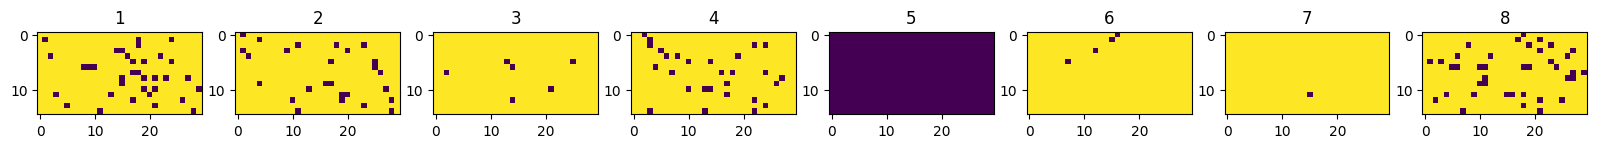

Num timesteps: 3632000
Best mean reward: -43188767.30 - Last mean reward per episode: -59505105.55


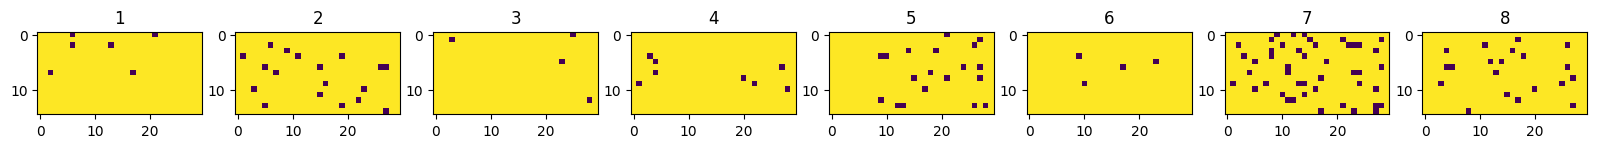

Num timesteps: 3640000
Best mean reward: -43188767.30 - Last mean reward per episode: -59783619.61


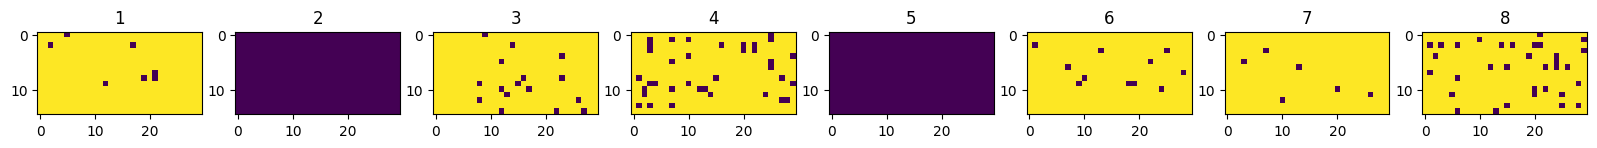

Num timesteps: 3648000
Best mean reward: -43188767.30 - Last mean reward per episode: -63622214.02


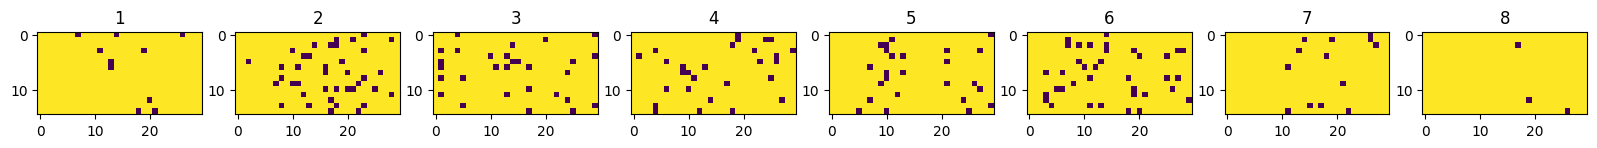

Num timesteps: 3656000
Best mean reward: -43188767.30 - Last mean reward per episode: -48848861.25


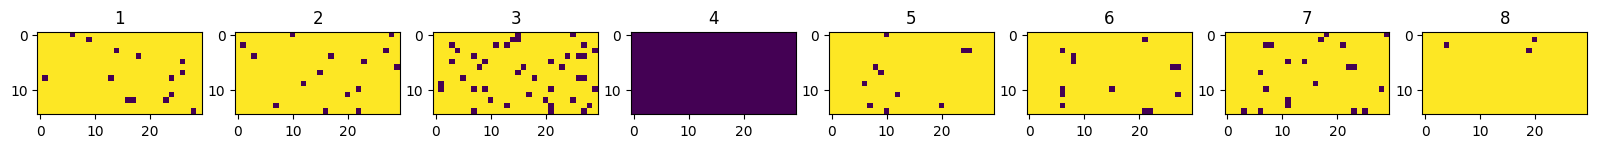

Num timesteps: 3664000
Best mean reward: -43188767.30 - Last mean reward per episode: -57972034.99


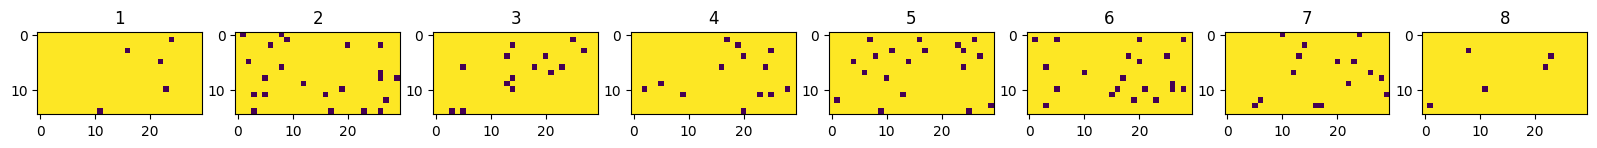

Num timesteps: 3672000
Best mean reward: -43188767.30 - Last mean reward per episode: -53366748.55


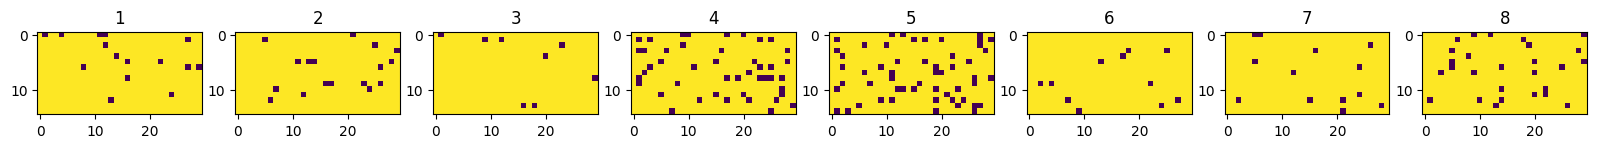

Num timesteps: 3680000
Best mean reward: -43188767.30 - Last mean reward per episode: -60365239.91


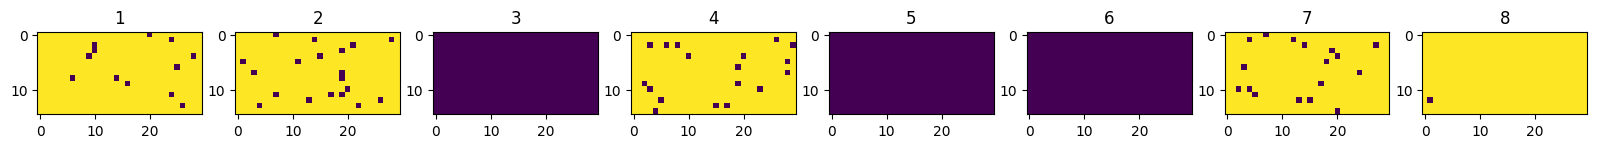

Num timesteps: 3688000
Best mean reward: -43188767.30 - Last mean reward per episode: -51000631.78


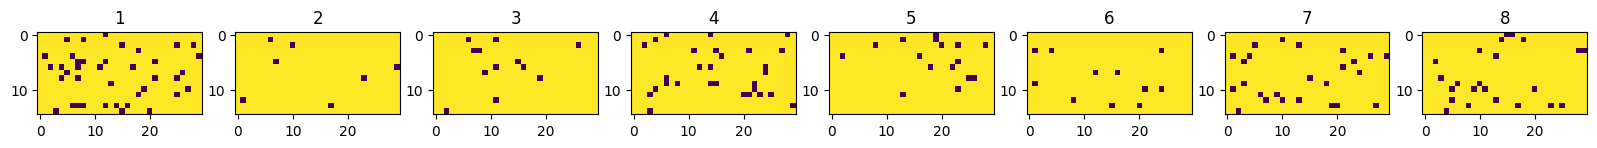

Num timesteps: 3696000
Best mean reward: -43188767.30 - Last mean reward per episode: -59369385.75


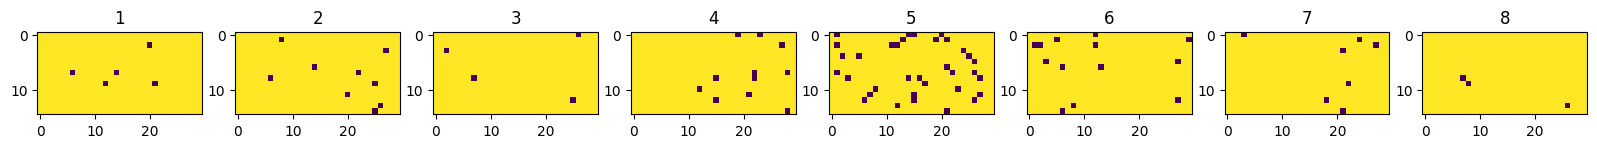

Num timesteps: 3704000
Best mean reward: -43188767.30 - Last mean reward per episode: -60378138.77


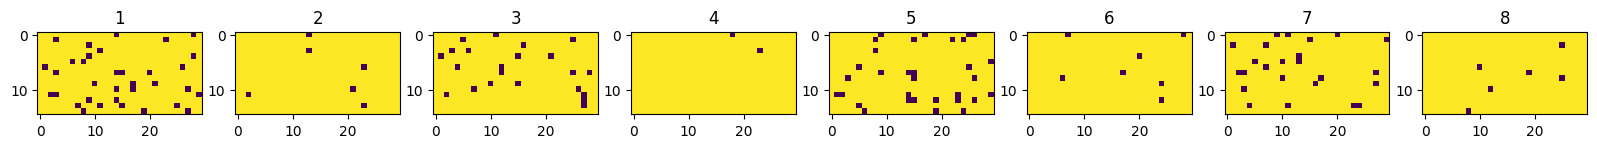

Num timesteps: 3712000
Best mean reward: -43188767.30 - Last mean reward per episode: -64390690.55


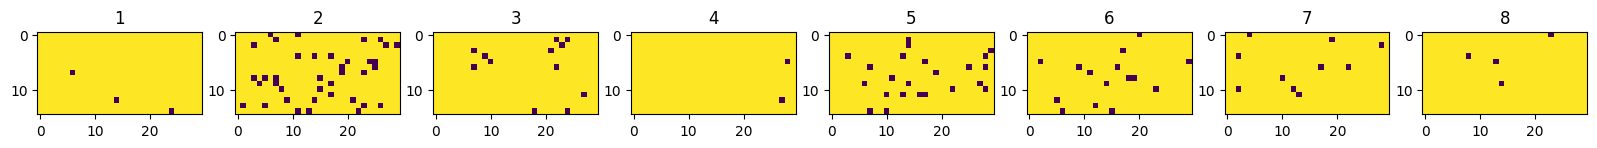

Num timesteps: 3720000
Best mean reward: -43188767.30 - Last mean reward per episode: -47208888.43


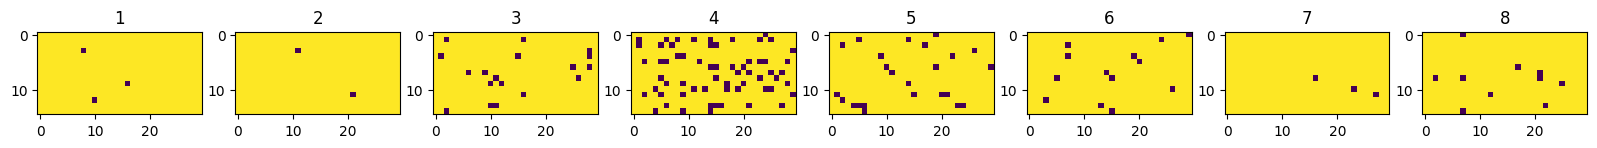

Num timesteps: 3728000
Best mean reward: -43188767.30 - Last mean reward per episode: -48408493.78


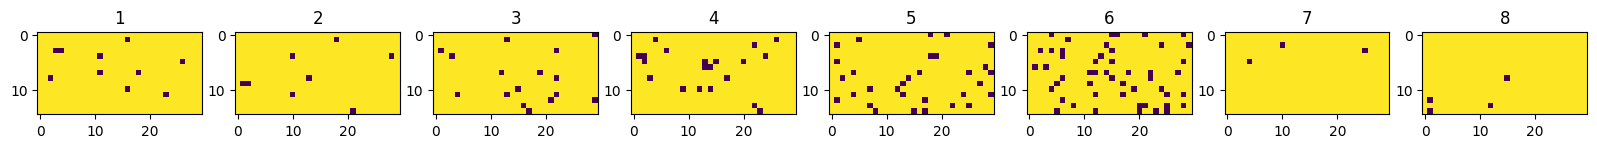

Num timesteps: 3736000
Best mean reward: -43188767.30 - Last mean reward per episode: -51346299.48


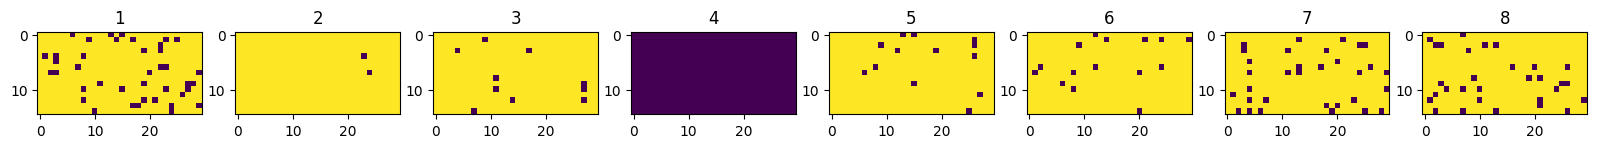

Num timesteps: 3744000
Best mean reward: -43188767.30 - Last mean reward per episode: -60176061.76


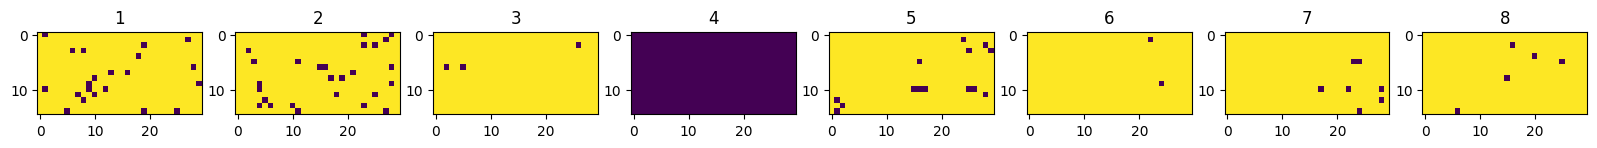

Num timesteps: 3752000
Best mean reward: -43188767.30 - Last mean reward per episode: -65304580.25


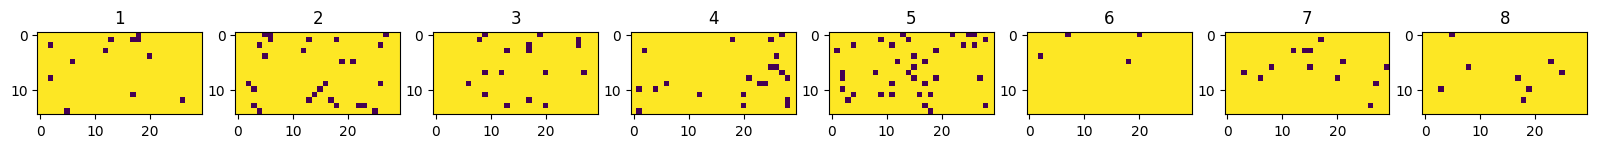

Num timesteps: 3760000
Best mean reward: -43188767.30 - Last mean reward per episode: -55153216.91


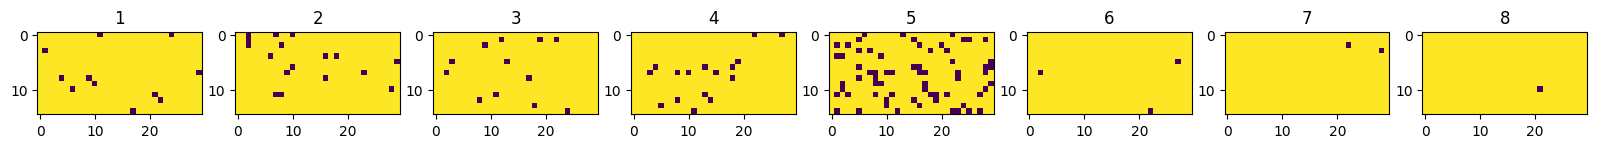

Num timesteps: 3768000
Best mean reward: -43188767.30 - Last mean reward per episode: -47059254.80


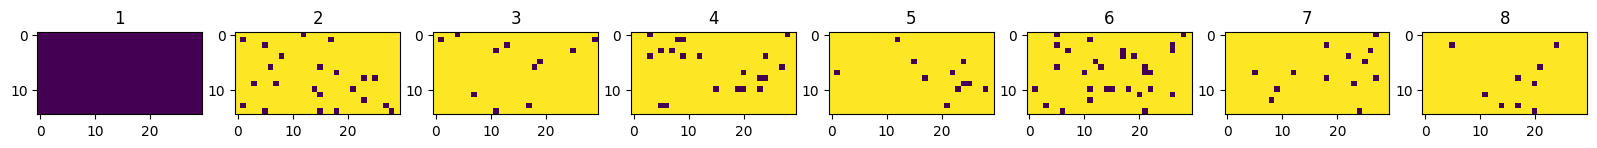

Num timesteps: 3776000
Best mean reward: -43188767.30 - Last mean reward per episode: -63327063.46


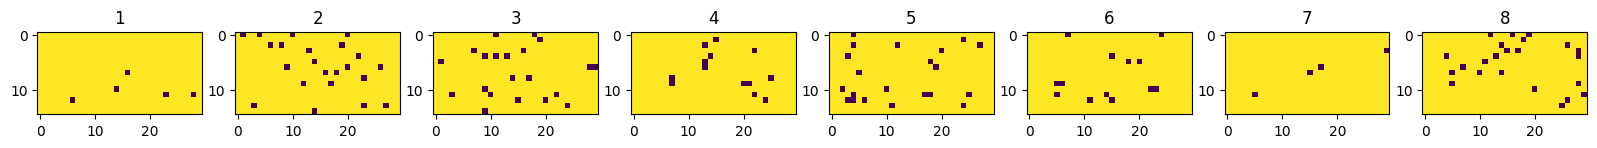

Num timesteps: 3784000
Best mean reward: -43188767.30 - Last mean reward per episode: -54871799.37


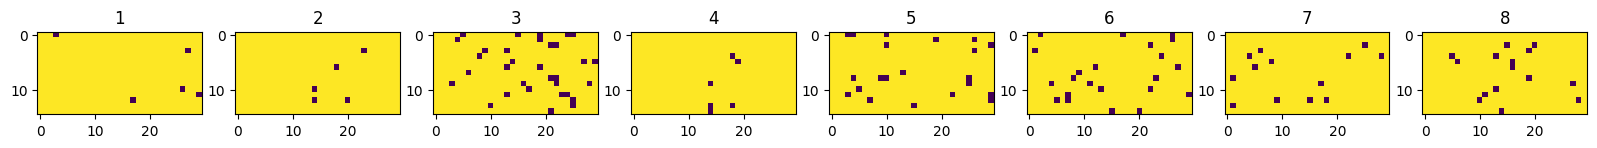

Num timesteps: 3792000
Best mean reward: -43188767.30 - Last mean reward per episode: -58234084.13


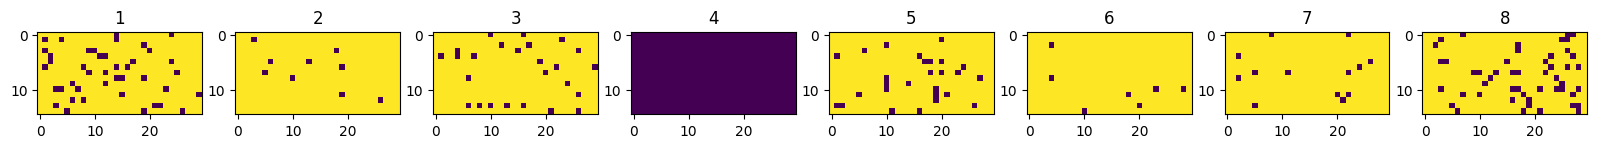

Num timesteps: 3800000
Best mean reward: -43188767.30 - Last mean reward per episode: -62509588.68


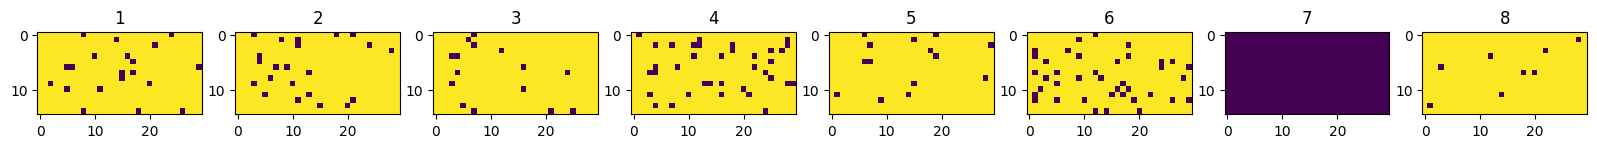

Num timesteps: 3808000
Best mean reward: -43188767.30 - Last mean reward per episode: -56418560.86


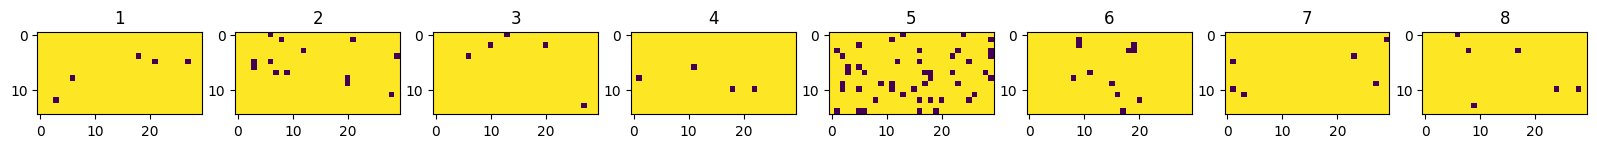

Num timesteps: 3816000
Best mean reward: -43188767.30 - Last mean reward per episode: -62389585.08


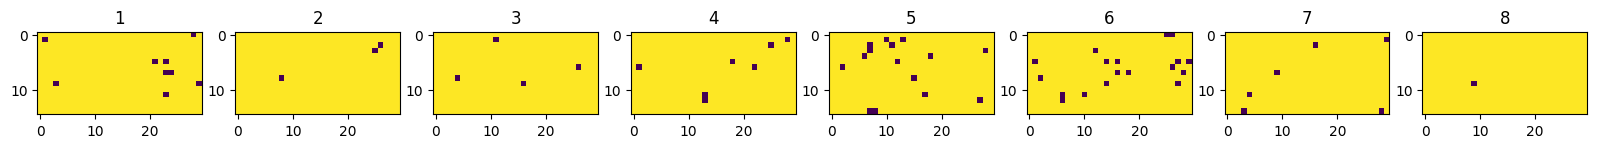

Num timesteps: 3824000
Best mean reward: -43188767.30 - Last mean reward per episode: -67737866.10


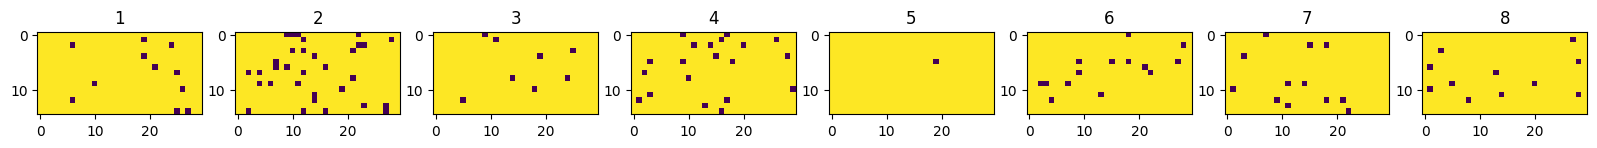

Num timesteps: 3832000
Best mean reward: -43188767.30 - Last mean reward per episode: -60288624.41


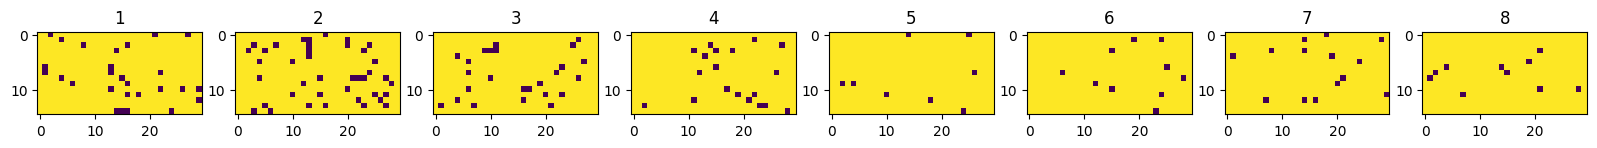

Num timesteps: 3840000
Best mean reward: -43188767.30 - Last mean reward per episode: -63085623.79


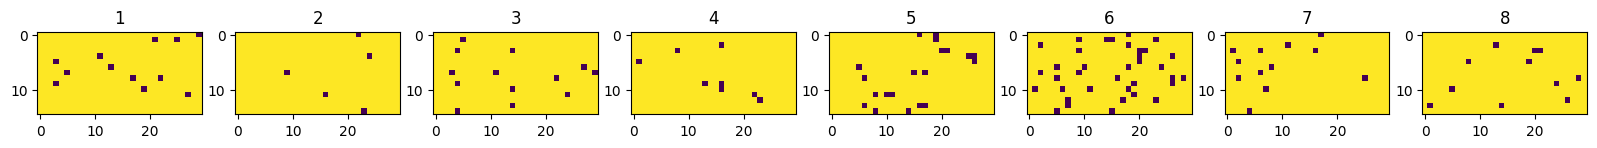

Num timesteps: 3848000
Best mean reward: -43188767.30 - Last mean reward per episode: -52640606.47


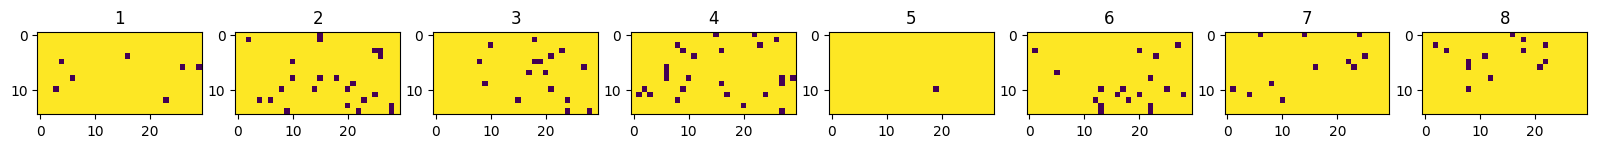

Num timesteps: 3856000
Best mean reward: -43188767.30 - Last mean reward per episode: -51080026.28


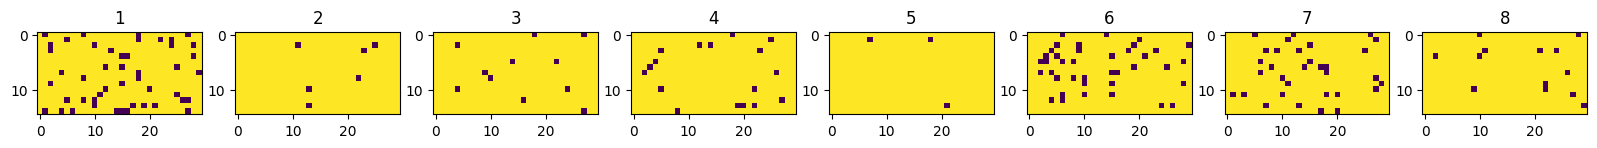

Num timesteps: 3864000
Best mean reward: -43188767.30 - Last mean reward per episode: -50552487.13


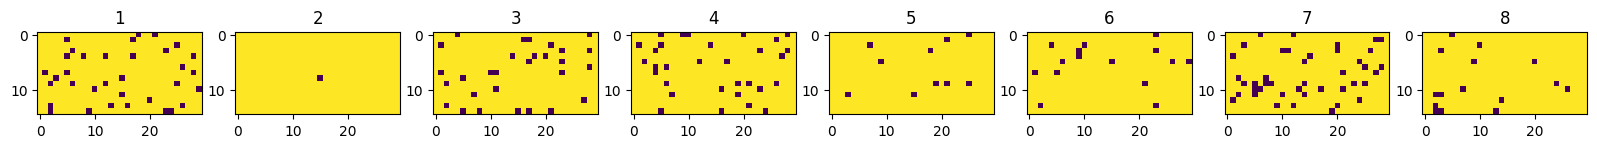

Num timesteps: 3872000
Best mean reward: -43188767.30 - Last mean reward per episode: -64112335.26


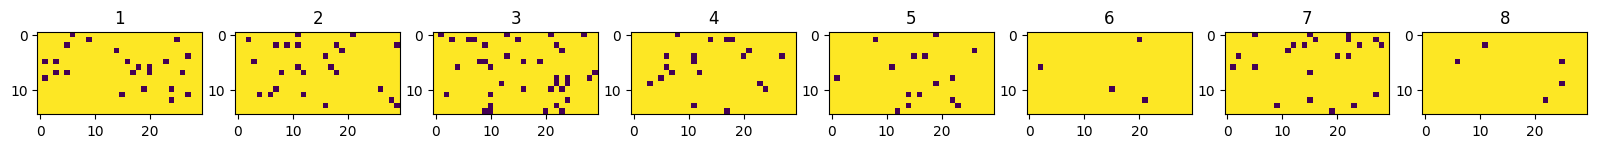

Num timesteps: 3880000
Best mean reward: -43188767.30 - Last mean reward per episode: -48811805.57


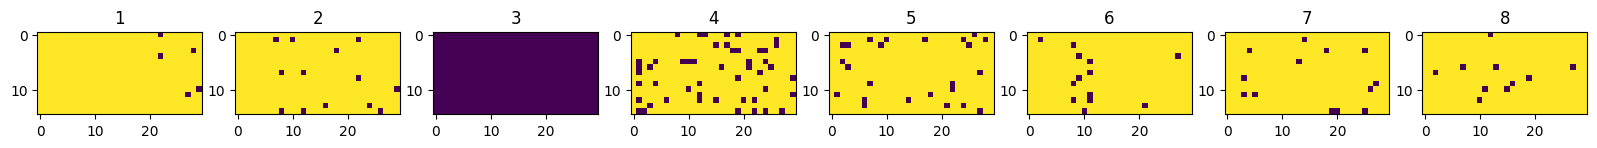

Num timesteps: 3888000
Best mean reward: -43188767.30 - Last mean reward per episode: -53054268.47


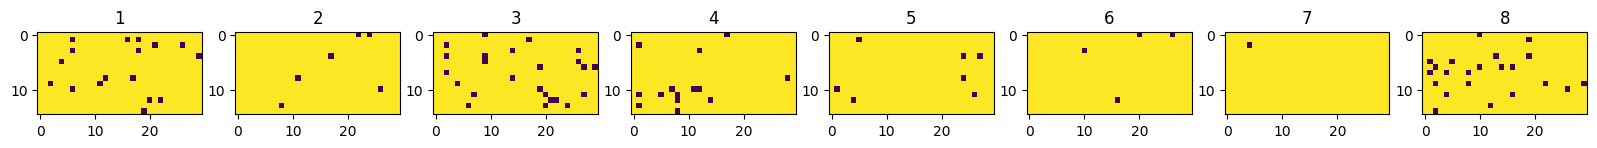

Num timesteps: 3896000
Best mean reward: -43188767.30 - Last mean reward per episode: -57250264.31


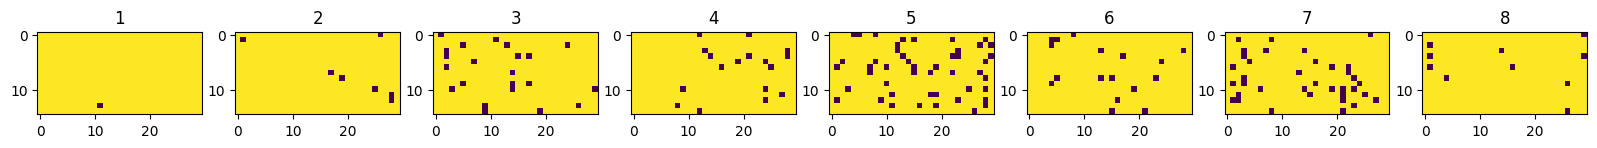

Num timesteps: 3904000
Best mean reward: -43188767.30 - Last mean reward per episode: -58565680.46


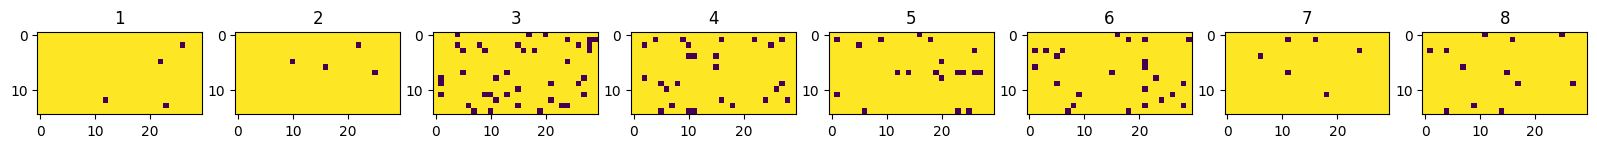

Num timesteps: 3912000
Best mean reward: -43188767.30 - Last mean reward per episode: -54924088.75


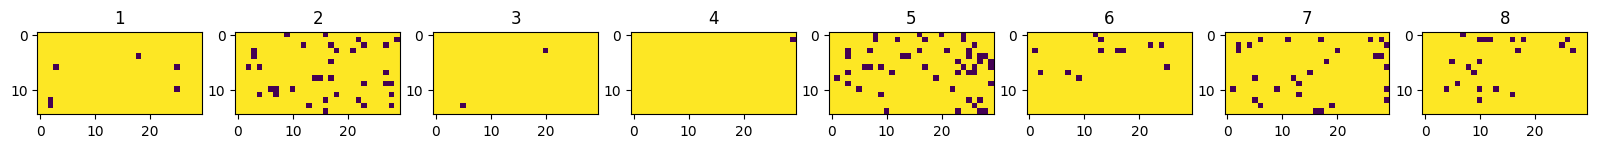

Num timesteps: 3920000
Best mean reward: -43188767.30 - Last mean reward per episode: -56606191.74


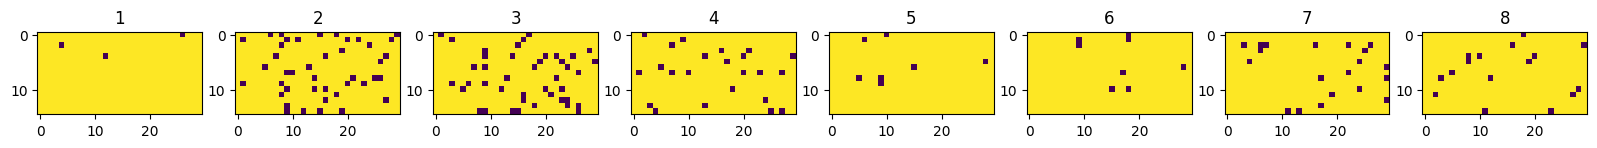

Num timesteps: 3928000
Best mean reward: -43188767.30 - Last mean reward per episode: -53450032.95


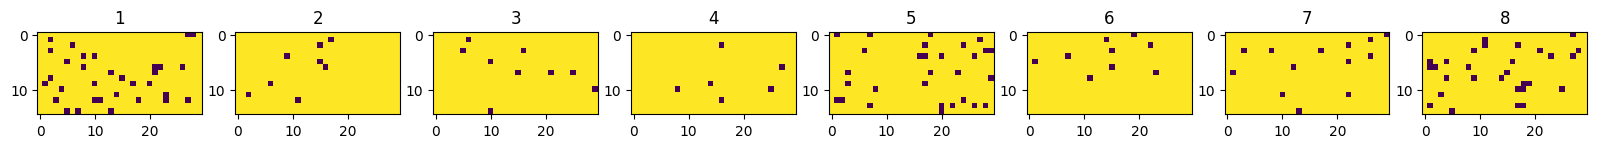

Num timesteps: 3936000
Best mean reward: -43188767.30 - Last mean reward per episode: -53642988.13


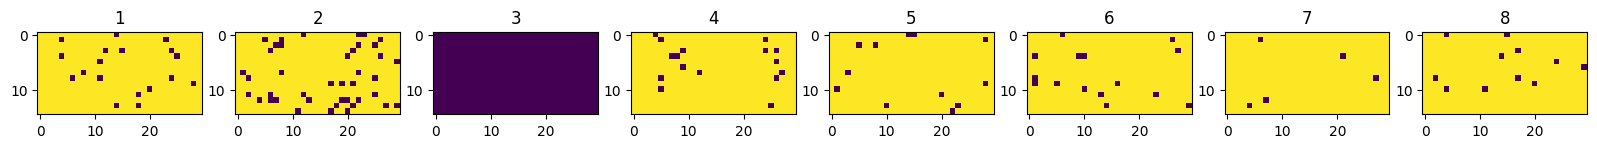

Num timesteps: 3944000
Best mean reward: -43188767.30 - Last mean reward per episode: -63057033.77


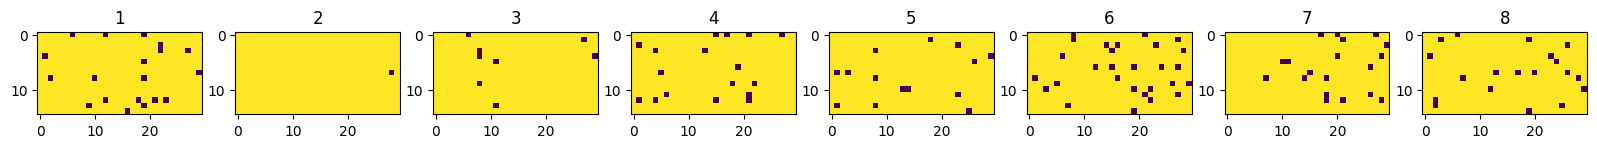

Num timesteps: 3952000
Best mean reward: -43188767.30 - Last mean reward per episode: -53067136.50


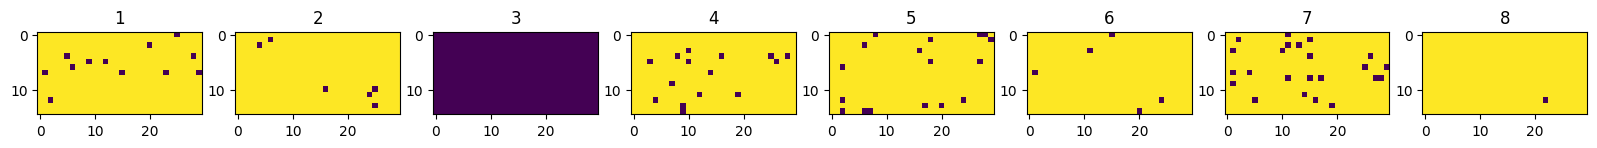

Num timesteps: 3960000
Best mean reward: -43188767.30 - Last mean reward per episode: -67102178.10


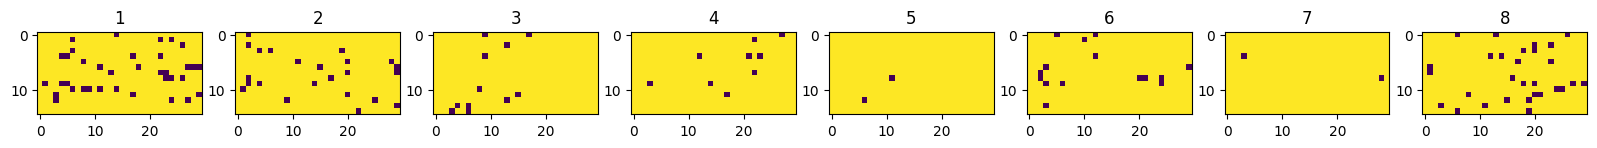

Num timesteps: 3968000
Best mean reward: -43188767.30 - Last mean reward per episode: -54175040.47


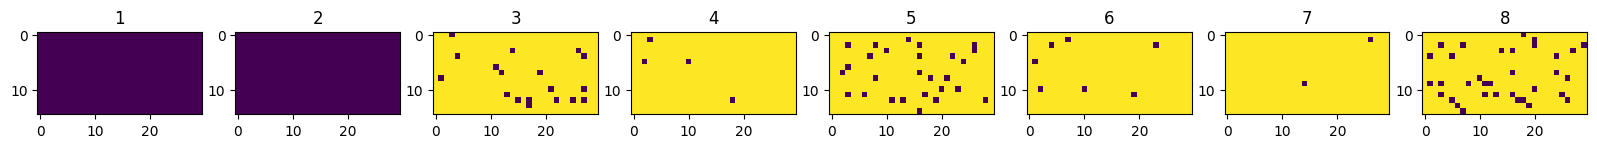

Num timesteps: 3976000
Best mean reward: -43188767.30 - Last mean reward per episode: -58697566.25


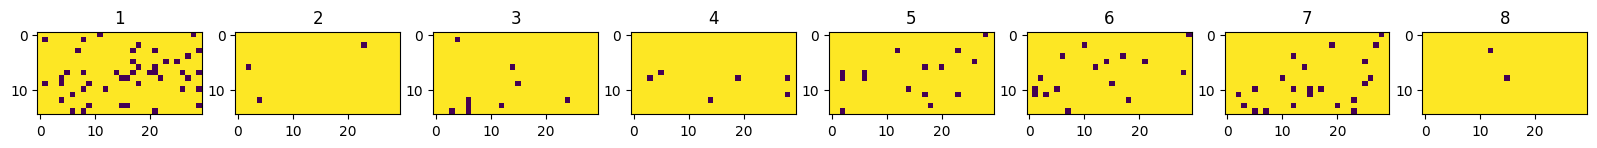

Num timesteps: 3984000
Best mean reward: -43188767.30 - Last mean reward per episode: -49110558.92


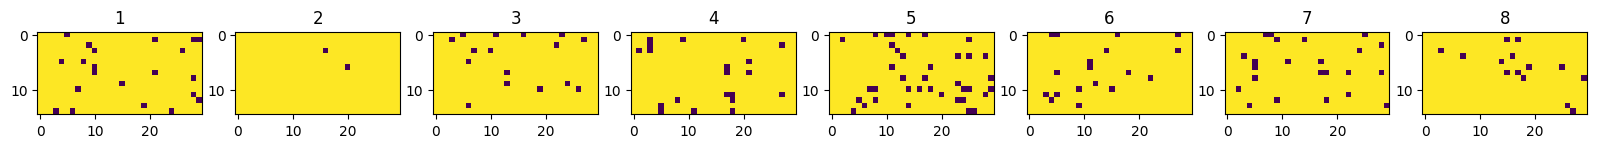

Num timesteps: 3992000
Best mean reward: -43188767.30 - Last mean reward per episode: -73510469.95


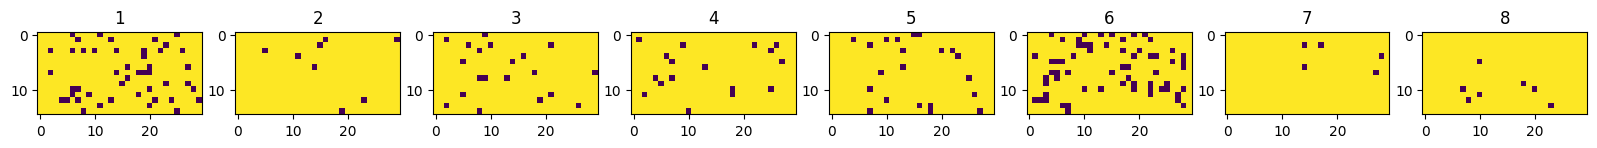

Num timesteps: 4000000
Best mean reward: -43188767.30 - Last mean reward per episode: -57765221.66


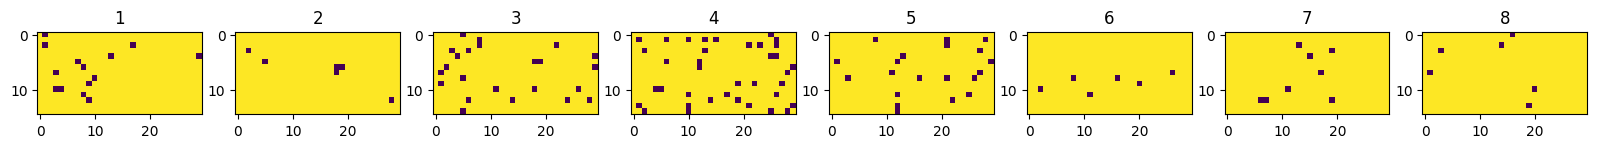

Num timesteps: 4008000
Best mean reward: -43188767.30 - Last mean reward per episode: -58922833.55


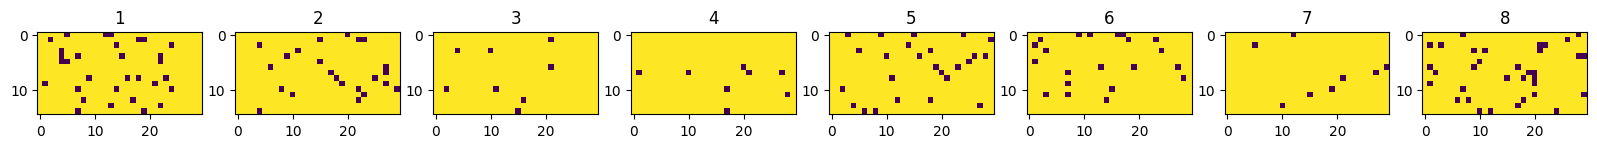

Num timesteps: 4016000
Best mean reward: -43188767.30 - Last mean reward per episode: -55205885.99


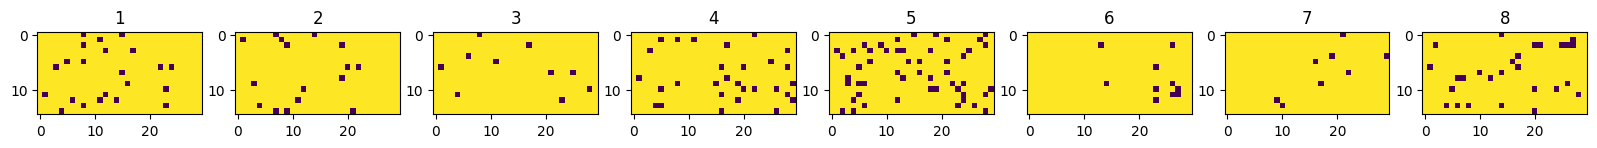

Num timesteps: 4024000
Best mean reward: -43188767.30 - Last mean reward per episode: -58724365.93


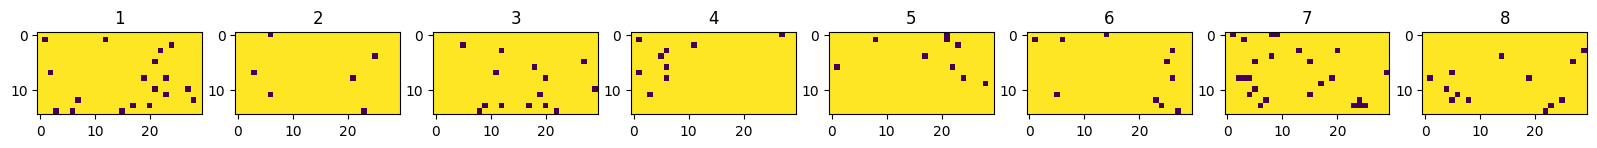

Num timesteps: 4032000
Best mean reward: -43188767.30 - Last mean reward per episode: -57369677.06


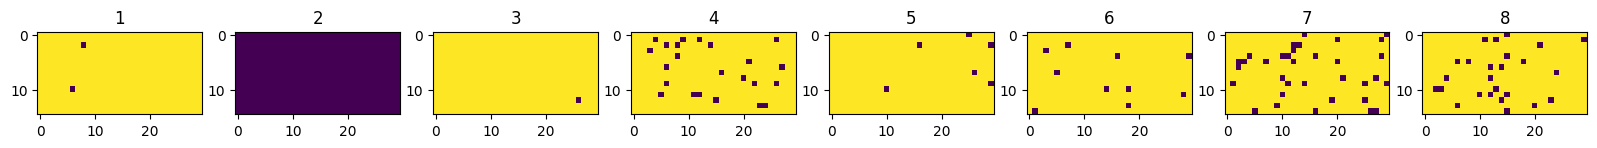

Num timesteps: 4040000
Best mean reward: -43188767.30 - Last mean reward per episode: -52127484.46


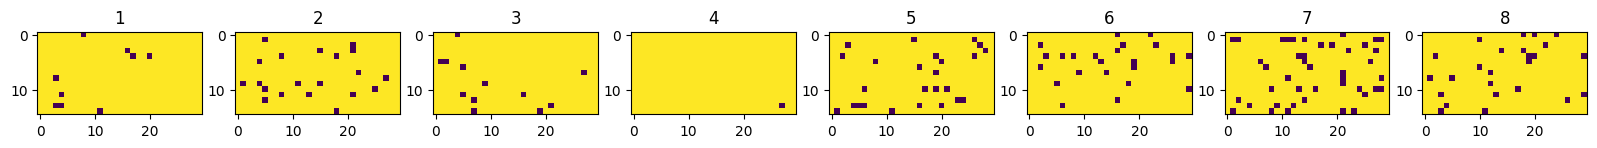

Num timesteps: 4048000
Best mean reward: -43188767.30 - Last mean reward per episode: -51606980.67


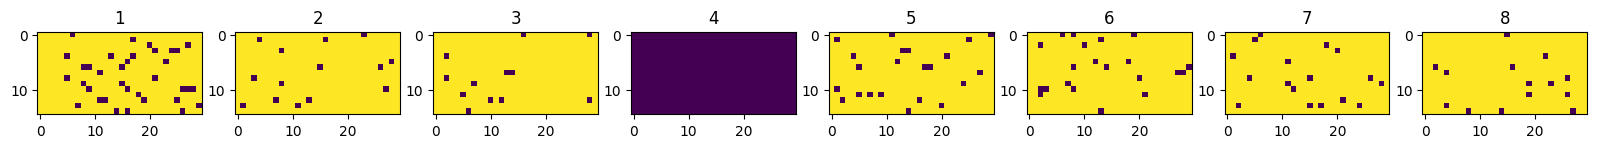

Num timesteps: 4056000
Best mean reward: -43188767.30 - Last mean reward per episode: -51416676.84


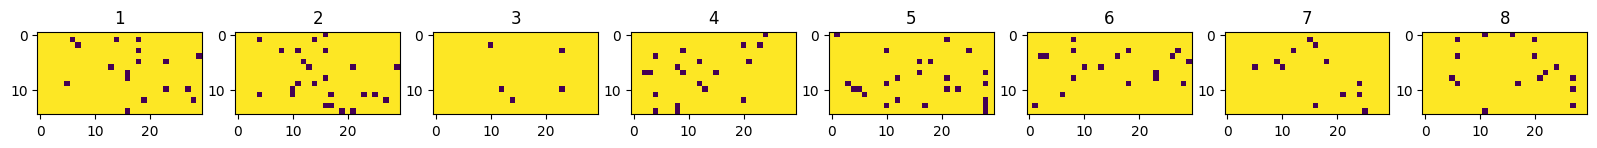

Num timesteps: 4064000
Best mean reward: -43188767.30 - Last mean reward per episode: -58818181.31


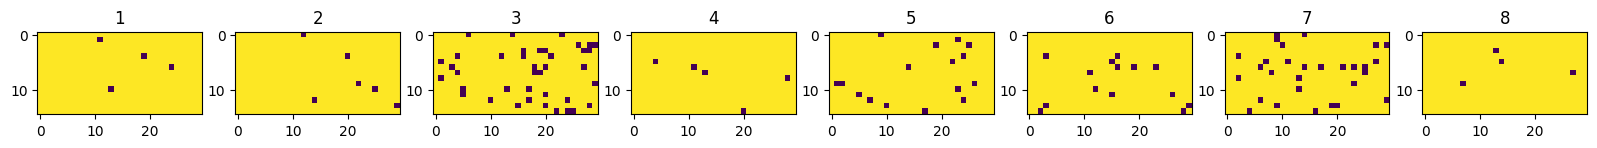

Num timesteps: 4072000
Best mean reward: -43188767.30 - Last mean reward per episode: -55998385.97


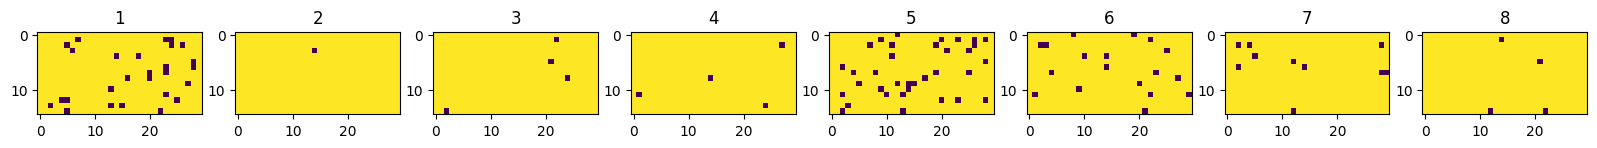

Num timesteps: 4080000
Best mean reward: -43188767.30 - Last mean reward per episode: -58404043.92


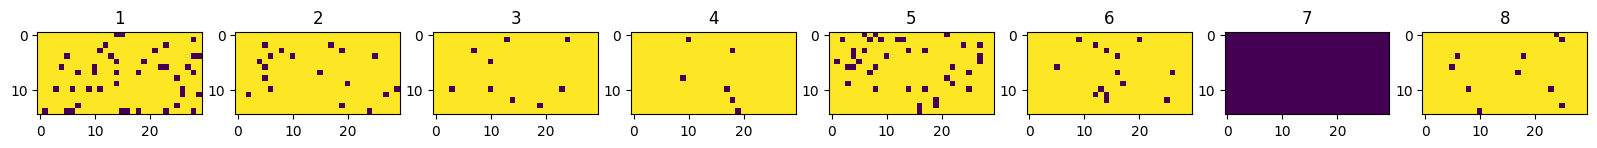

Num timesteps: 4088000
Best mean reward: -43188767.30 - Last mean reward per episode: -55892704.38


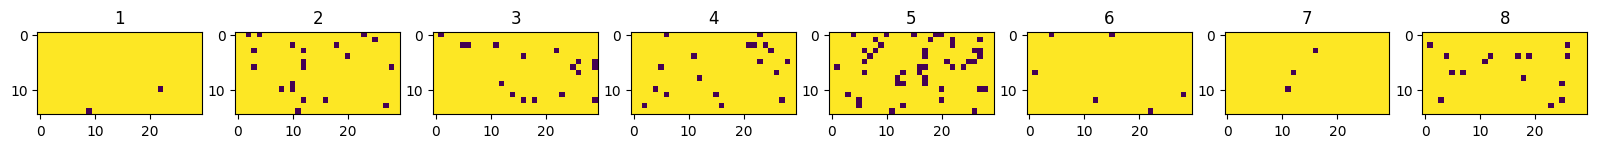

Num timesteps: 4096000
Best mean reward: -43188767.30 - Last mean reward per episode: -57038524.13


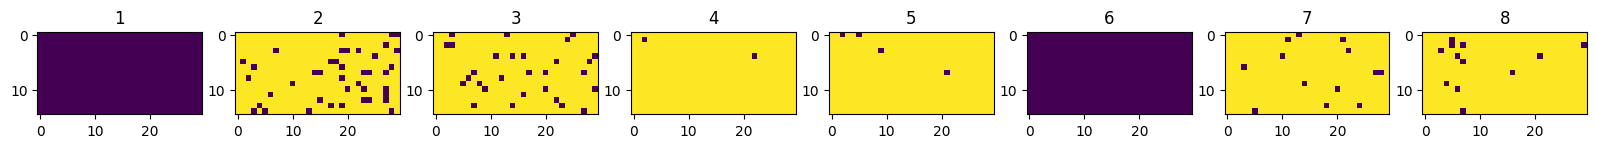

Num timesteps: 4104000
Best mean reward: -43188767.30 - Last mean reward per episode: -55969414.00


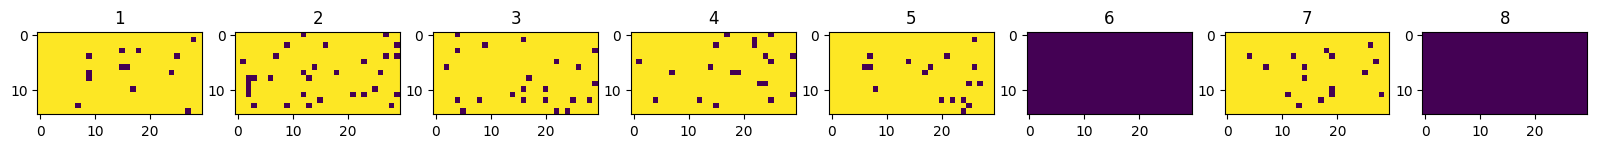

Num timesteps: 4112000
Best mean reward: -43188767.30 - Last mean reward per episode: -47451925.37


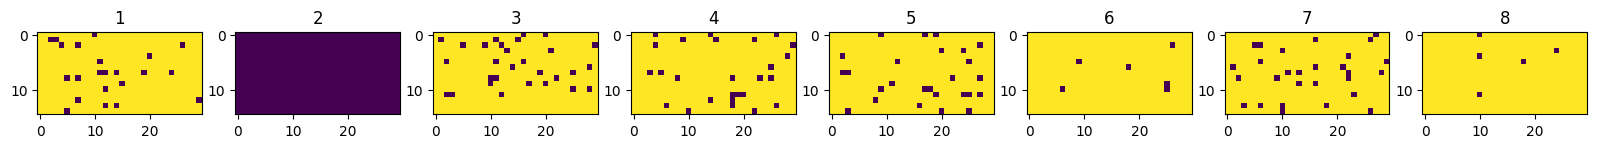

Num timesteps: 4120000
Best mean reward: -43188767.30 - Last mean reward per episode: -56668782.34


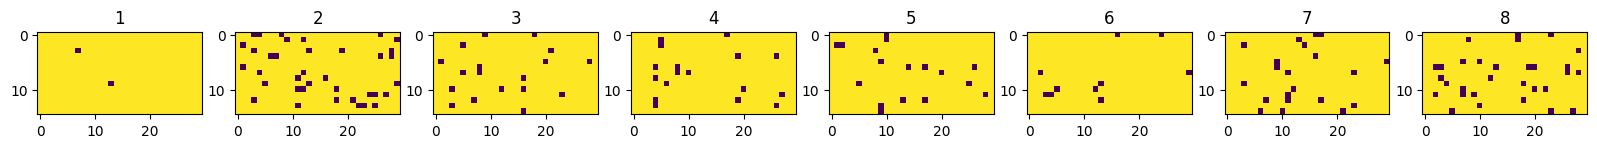

Num timesteps: 4128000
Best mean reward: -43188767.30 - Last mean reward per episode: -64486859.23


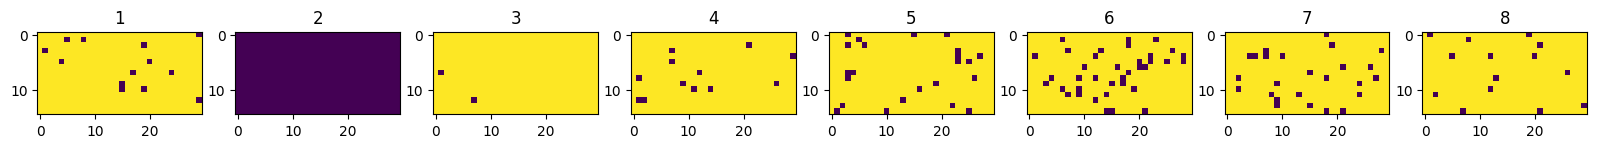

Num timesteps: 4136000
Best mean reward: -43188767.30 - Last mean reward per episode: -60155142.03


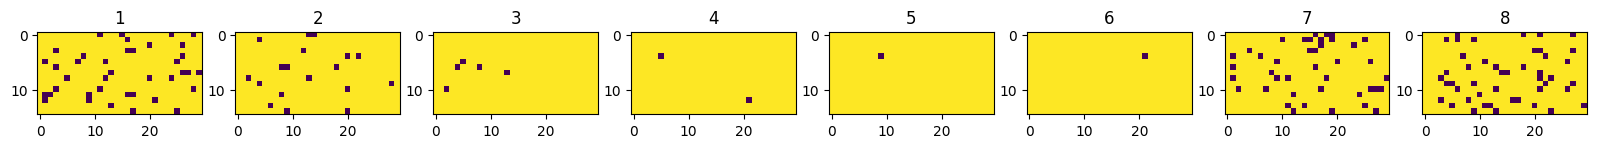

Num timesteps: 4144000
Best mean reward: -43188767.30 - Last mean reward per episode: -59378626.74


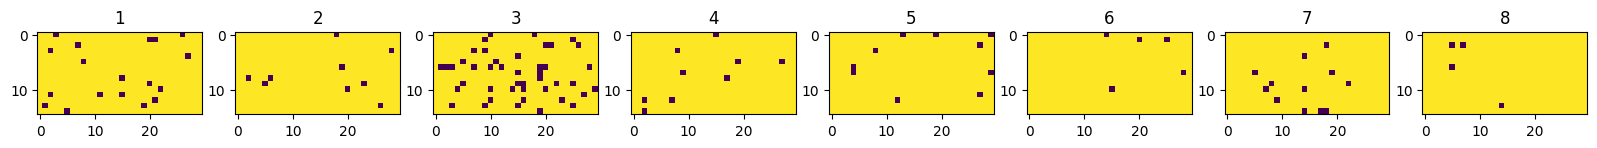

Num timesteps: 4152000
Best mean reward: -43188767.30 - Last mean reward per episode: -55264927.70


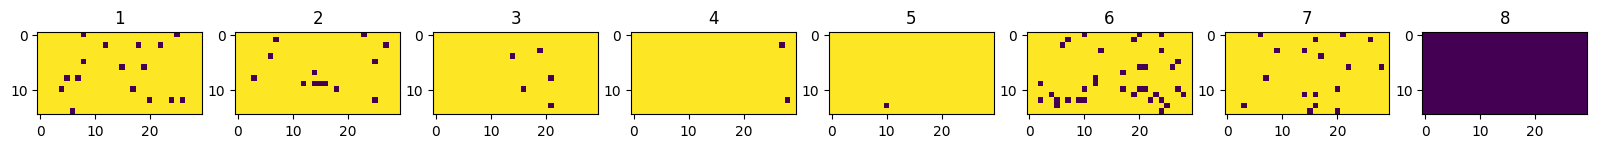

Num timesteps: 4160000
Best mean reward: -43188767.30 - Last mean reward per episode: -50404402.42


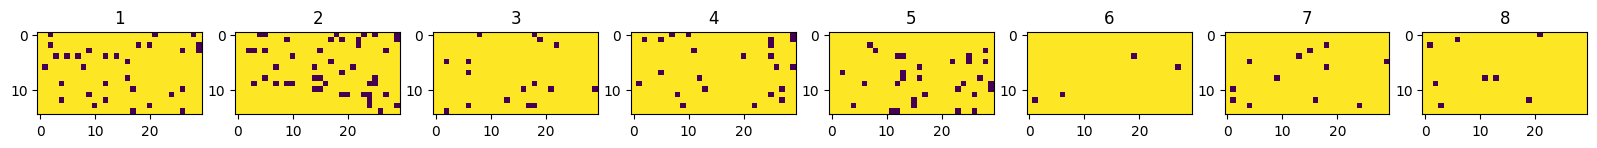

Num timesteps: 4168000
Best mean reward: -43188767.30 - Last mean reward per episode: -64594590.52


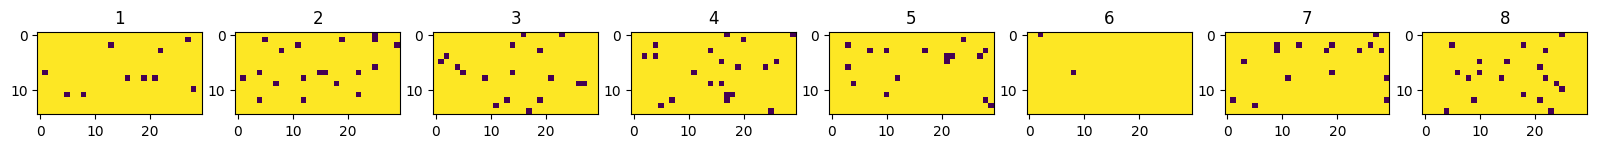

Num timesteps: 4176000
Best mean reward: -43188767.30 - Last mean reward per episode: -62115180.09


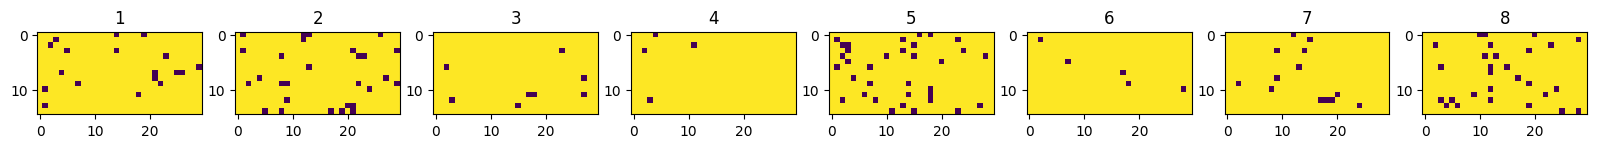

Num timesteps: 4184000
Best mean reward: -43188767.30 - Last mean reward per episode: -57452715.26


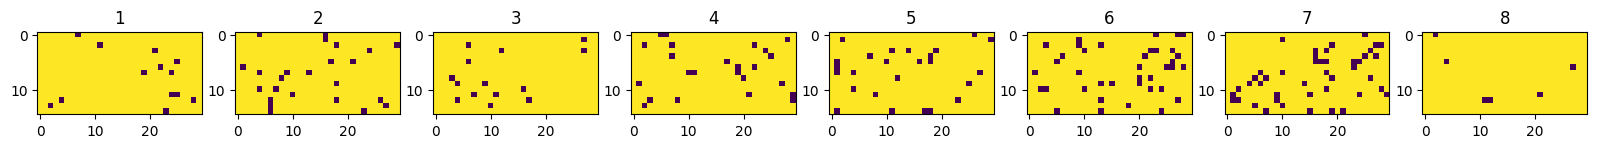

Num timesteps: 4192000
Best mean reward: -43188767.30 - Last mean reward per episode: -50640389.19


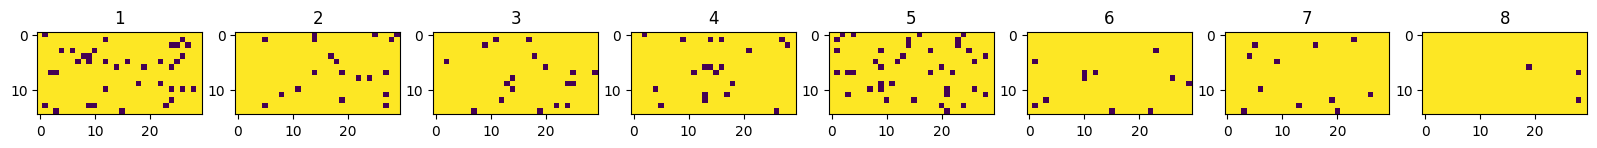

Num timesteps: 4200000
Best mean reward: -43188767.30 - Last mean reward per episode: -47657144.68


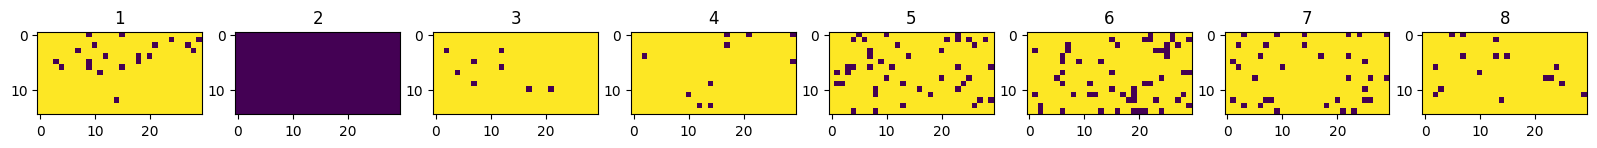

Num timesteps: 4208000
Best mean reward: -43188767.30 - Last mean reward per episode: -49476869.05


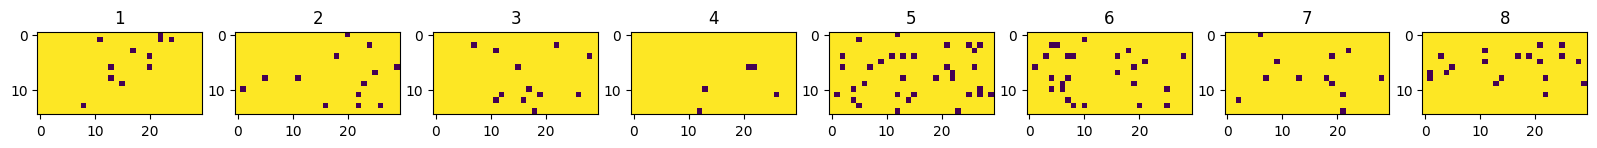

Num timesteps: 4216000
Best mean reward: -43188767.30 - Last mean reward per episode: -60328098.45


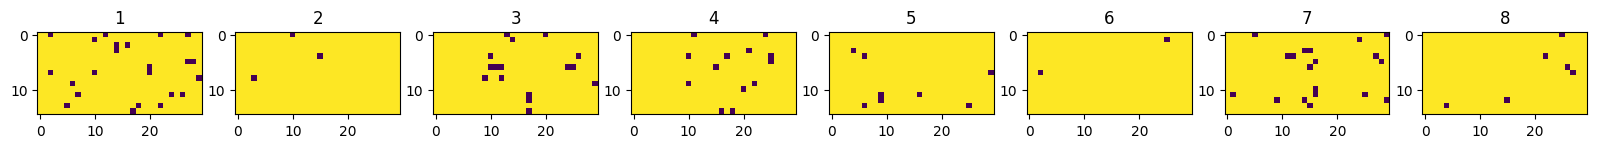

Num timesteps: 4224000
Best mean reward: -43188767.30 - Last mean reward per episode: -54424315.31


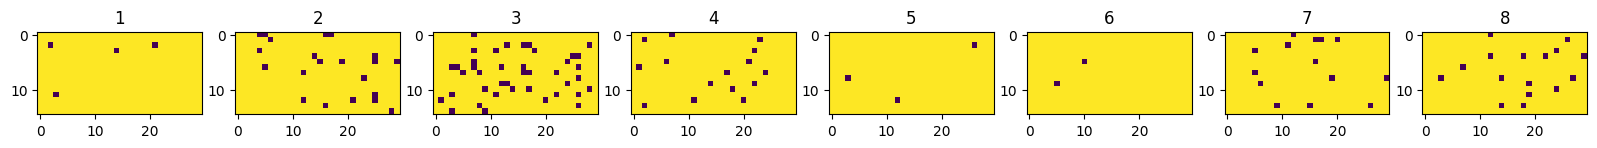

Num timesteps: 4232000
Best mean reward: -43188767.30 - Last mean reward per episode: -51801201.56


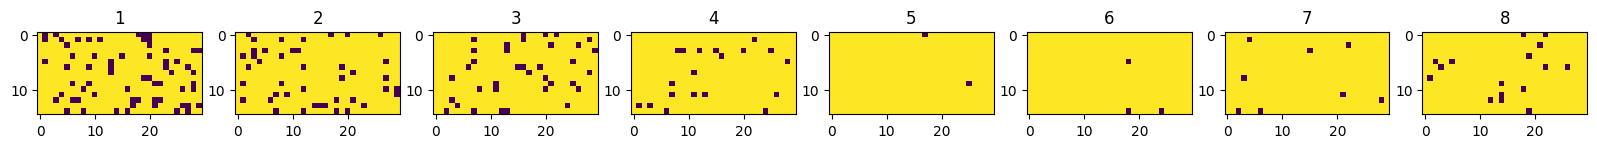

Num timesteps: 4240000
Best mean reward: -43188767.30 - Last mean reward per episode: -48033312.18


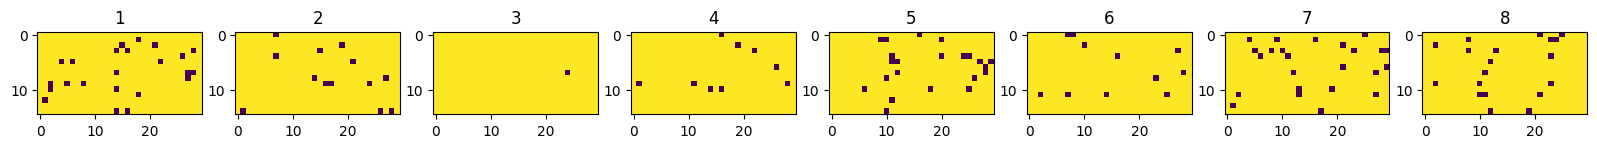

Num timesteps: 4248000
Best mean reward: -43188767.30 - Last mean reward per episode: -62787085.64


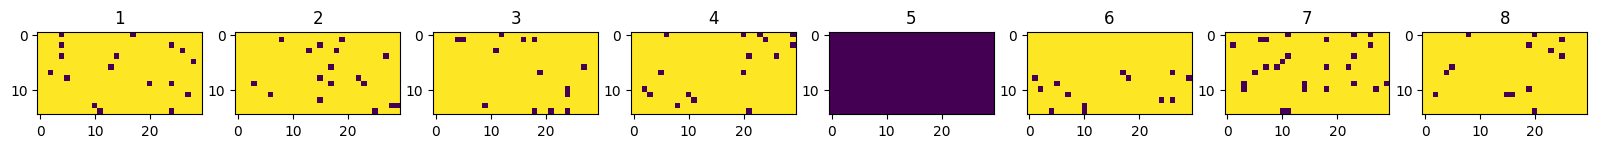

Num timesteps: 4256000
Best mean reward: -43188767.30 - Last mean reward per episode: -55241023.06


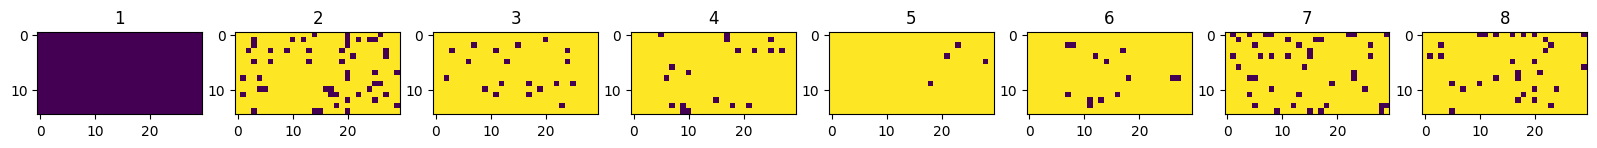

Num timesteps: 4264000
Best mean reward: -43188767.30 - Last mean reward per episode: -63105228.31


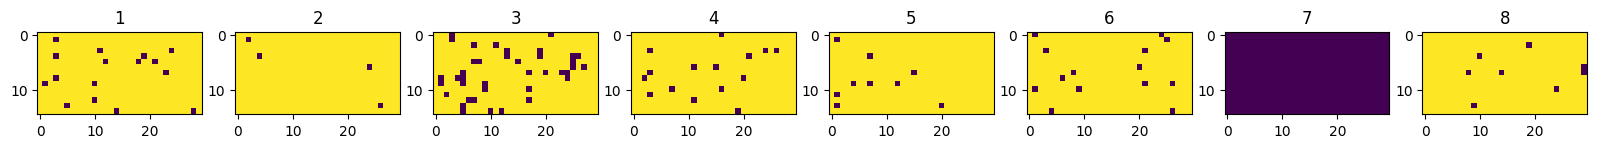

Num timesteps: 4272000
Best mean reward: -43188767.30 - Last mean reward per episode: -63621876.04


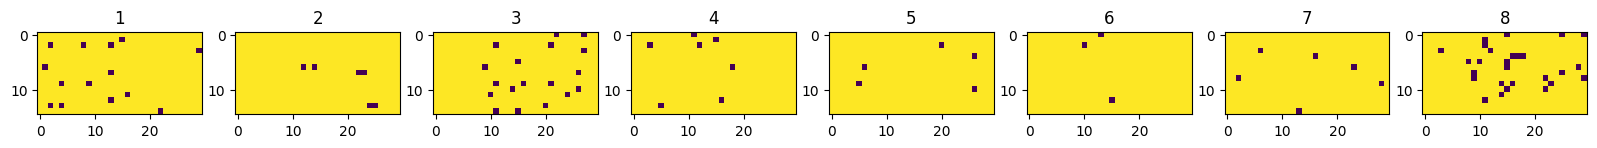

Num timesteps: 4280000
Best mean reward: -43188767.30 - Last mean reward per episode: -44811090.22


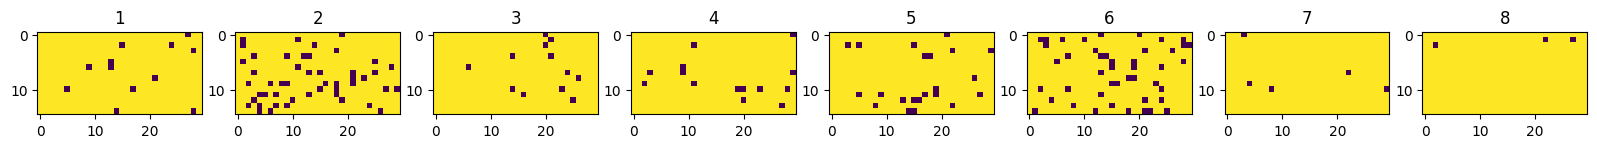

Num timesteps: 4288000
Best mean reward: -43188767.30 - Last mean reward per episode: -57657730.96


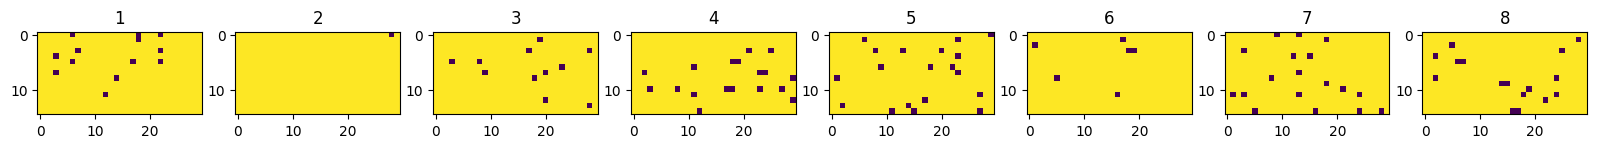

Num timesteps: 4296000
Best mean reward: -43188767.30 - Last mean reward per episode: -50656782.70


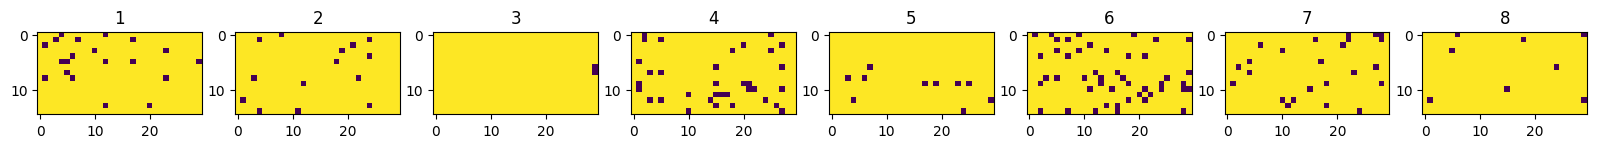

Num timesteps: 4304000
Best mean reward: -43188767.30 - Last mean reward per episode: -55466124.41


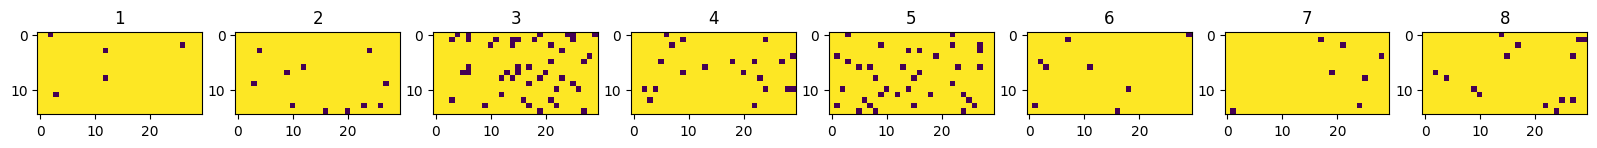

Num timesteps: 4312000
Best mean reward: -43188767.30 - Last mean reward per episode: -62161255.87


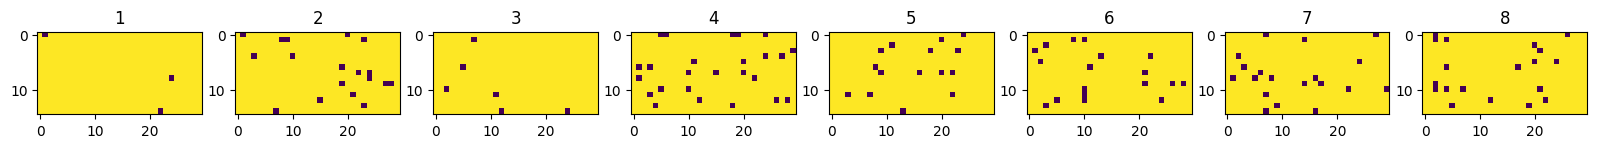

Num timesteps: 4320000
Best mean reward: -43188767.30 - Last mean reward per episode: -64102913.46


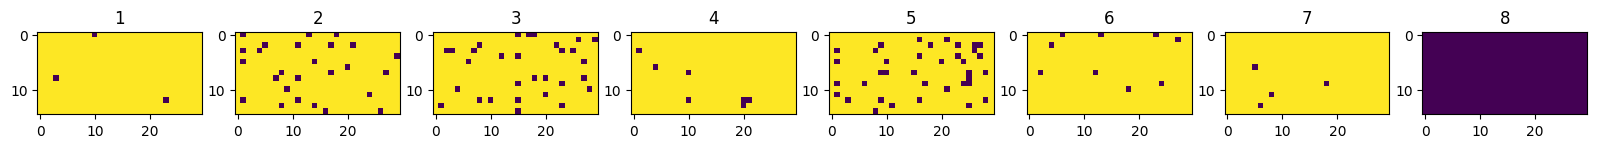

Num timesteps: 4328000
Best mean reward: -43188767.30 - Last mean reward per episode: -50937037.14


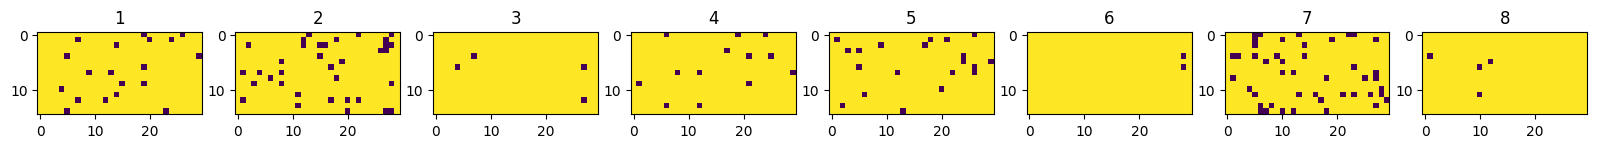

Num timesteps: 4336000
Best mean reward: -43188767.30 - Last mean reward per episode: -54525777.74


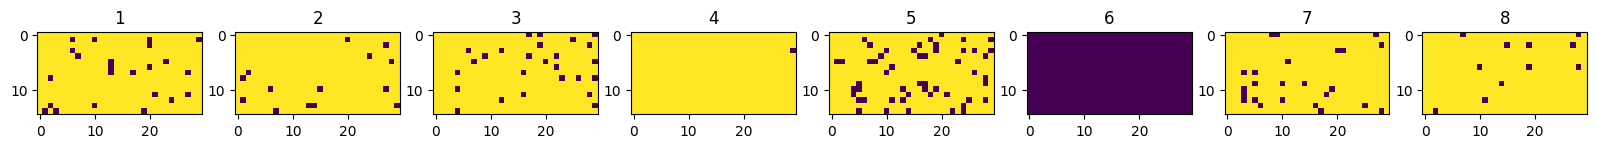

Num timesteps: 4344000
Best mean reward: -43188767.30 - Last mean reward per episode: -61213056.48


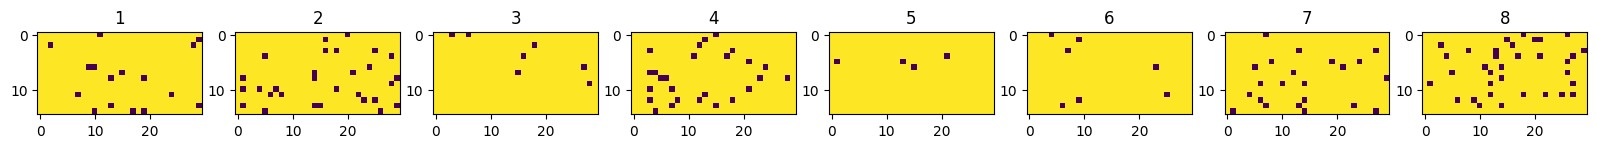

Num timesteps: 4352000
Best mean reward: -43188767.30 - Last mean reward per episode: -51732738.33


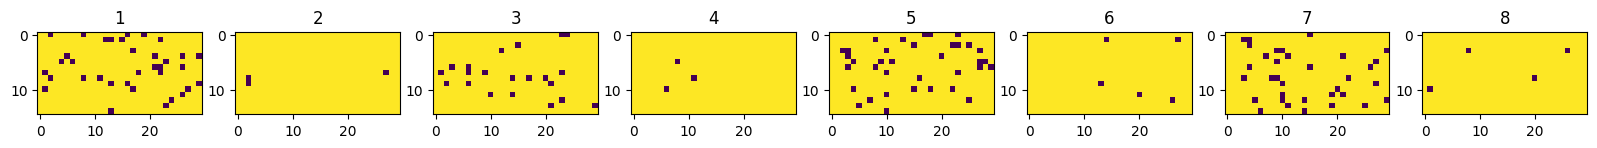

Num timesteps: 4360000
Best mean reward: -43188767.30 - Last mean reward per episode: -57334502.22


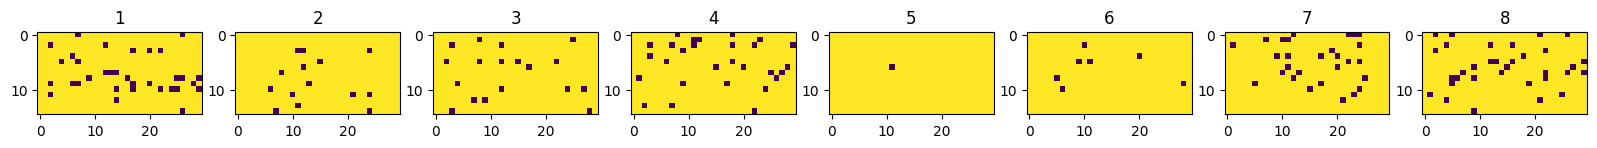

Num timesteps: 4368000
Best mean reward: -43188767.30 - Last mean reward per episode: -50865601.31


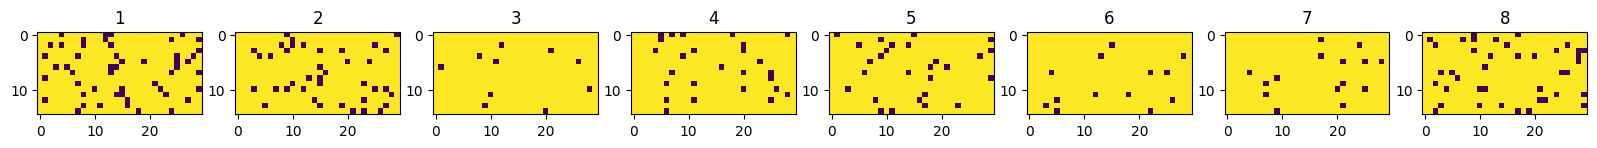

Num timesteps: 4376000
Best mean reward: -43188767.30 - Last mean reward per episode: -58642185.29


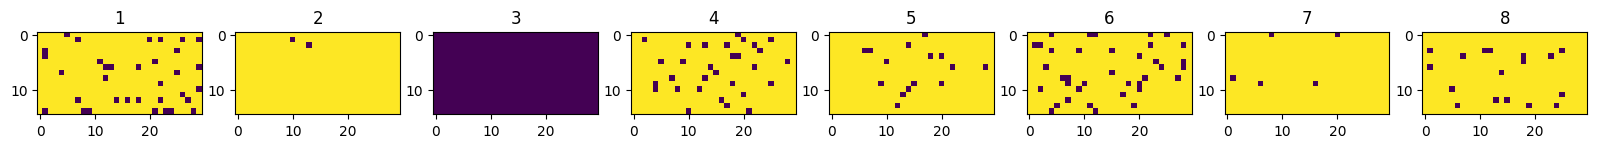

Num timesteps: 4384000
Best mean reward: -43188767.30 - Last mean reward per episode: -55261265.31


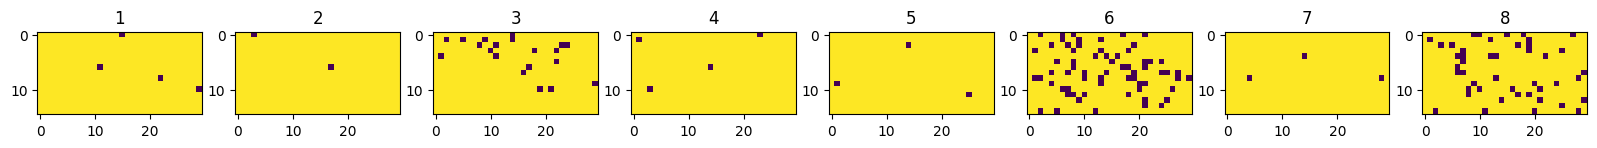

Num timesteps: 4392000
Best mean reward: -43188767.30 - Last mean reward per episode: -49240778.64


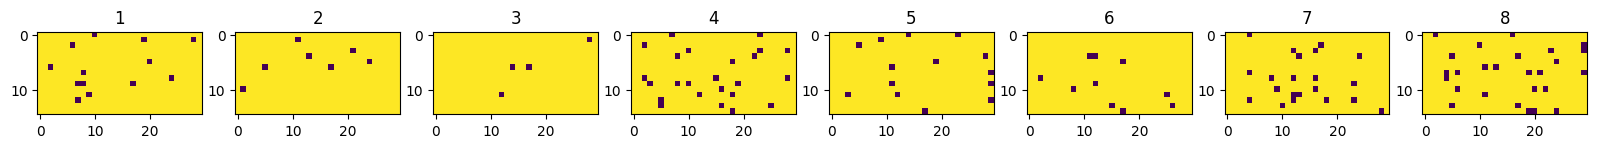

Num timesteps: 4400000
Best mean reward: -43188767.30 - Last mean reward per episode: -59297875.77


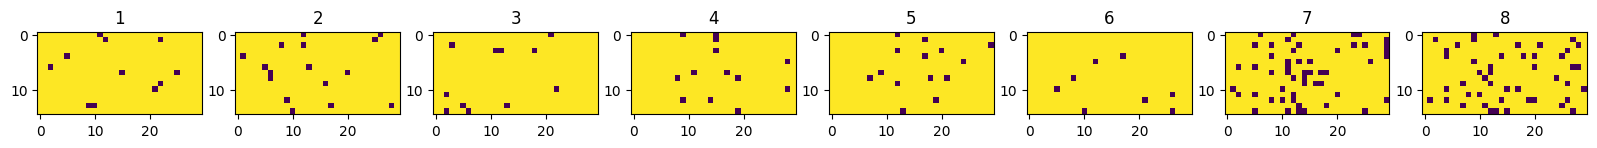

Num timesteps: 4408000
Best mean reward: -43188767.30 - Last mean reward per episode: -59066607.50


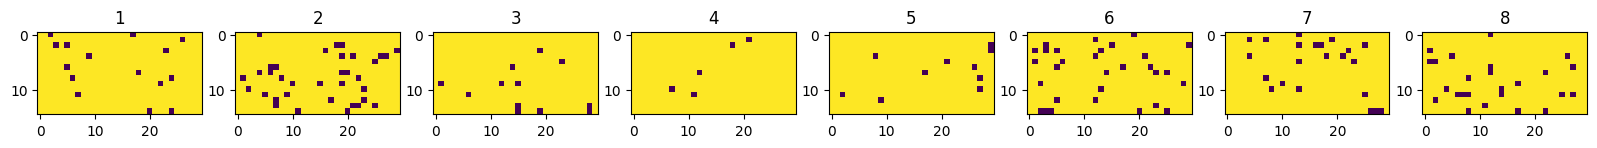

Num timesteps: 4416000
Best mean reward: -43188767.30 - Last mean reward per episode: -55041867.80


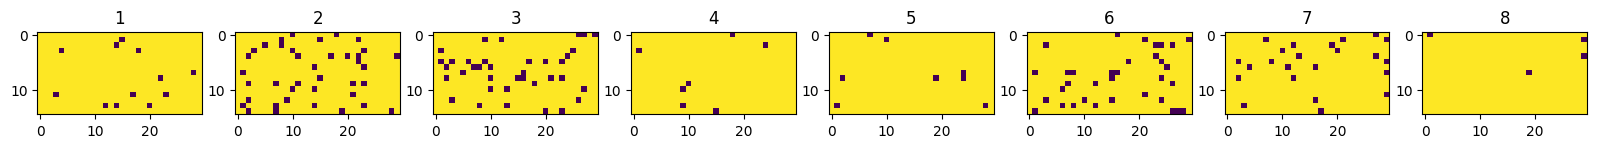

Num timesteps: 4424000
Best mean reward: -43188767.30 - Last mean reward per episode: -48799747.77


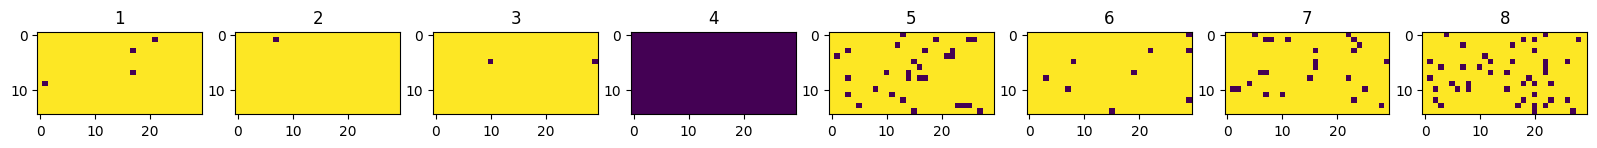

Num timesteps: 4432000
Best mean reward: -43188767.30 - Last mean reward per episode: -70298642.28


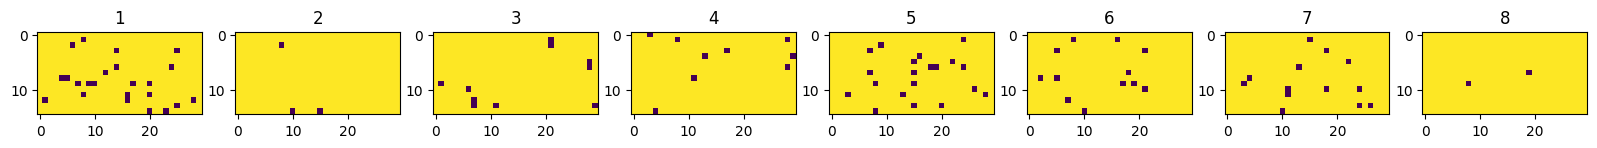

Num timesteps: 4440000
Best mean reward: -43188767.30 - Last mean reward per episode: -55063602.64


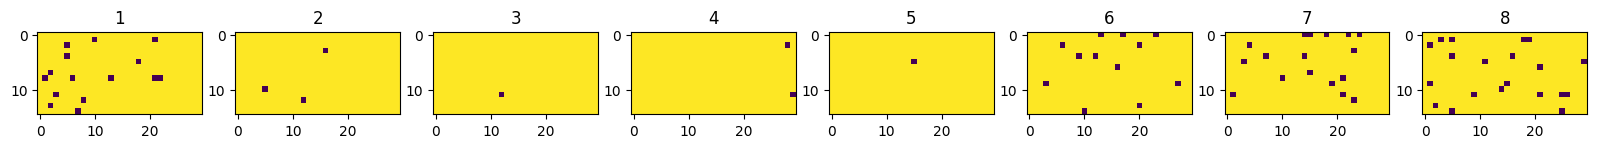

Num timesteps: 4448000
Best mean reward: -43188767.30 - Last mean reward per episode: -60893539.21


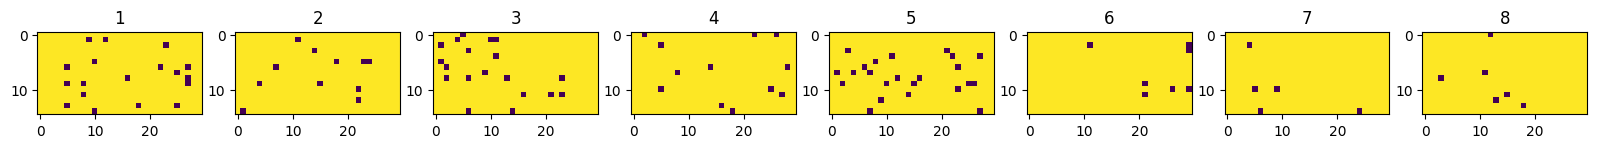

Num timesteps: 4456000
Best mean reward: -43188767.30 - Last mean reward per episode: -47165763.42


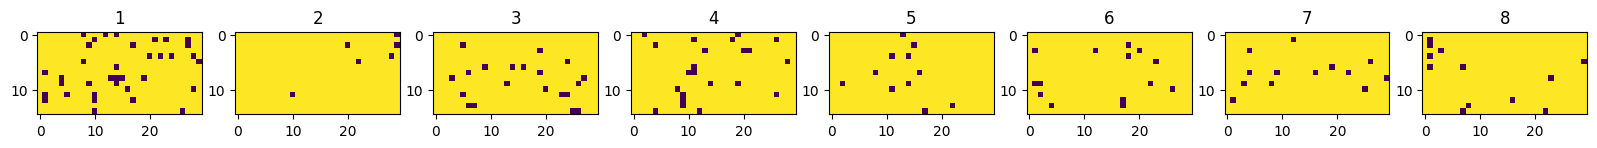

Num timesteps: 4464000
Best mean reward: -43188767.30 - Last mean reward per episode: -52539913.24


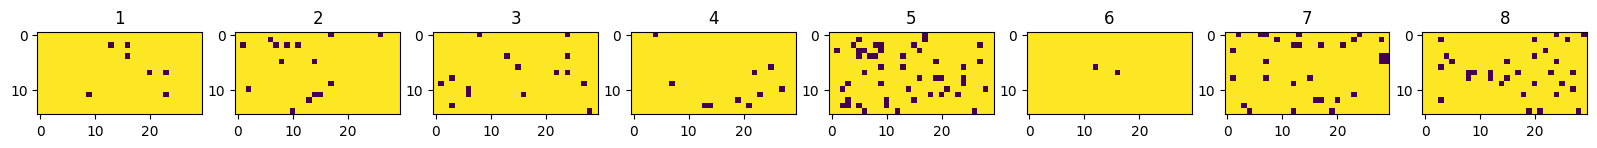

Num timesteps: 4472000
Best mean reward: -43188767.30 - Last mean reward per episode: -59586729.83


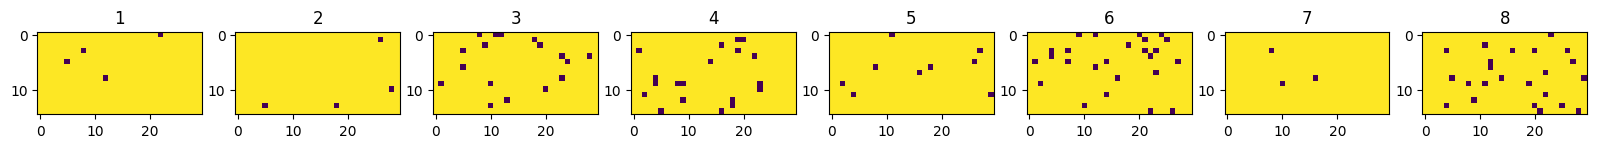

Num timesteps: 4480000
Best mean reward: -43188767.30 - Last mean reward per episode: -60239331.19


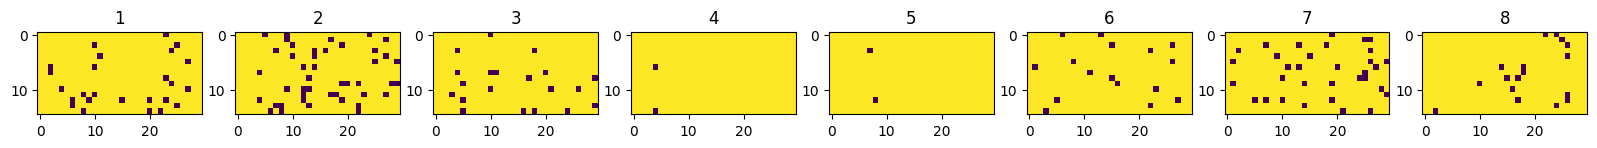

Num timesteps: 4488000
Best mean reward: -43188767.30 - Last mean reward per episode: -50225192.54


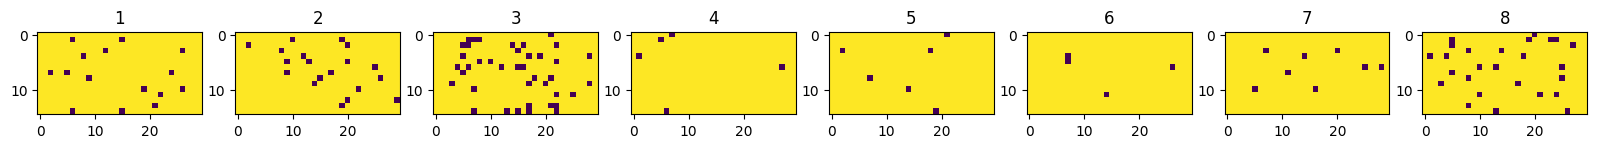

Num timesteps: 4496000
Best mean reward: -43188767.30 - Last mean reward per episode: -61953029.17


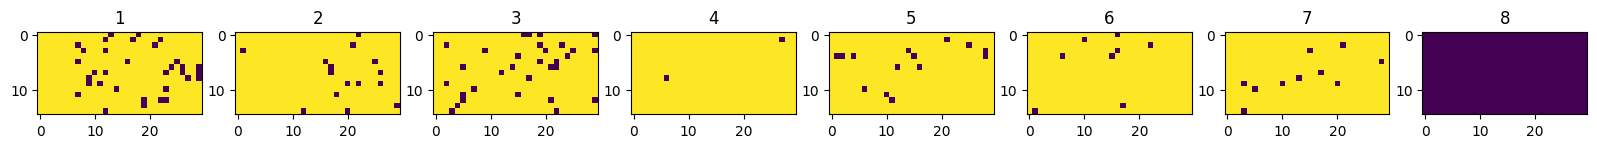

Num timesteps: 4504000
Best mean reward: -43188767.30 - Last mean reward per episode: -61034683.30


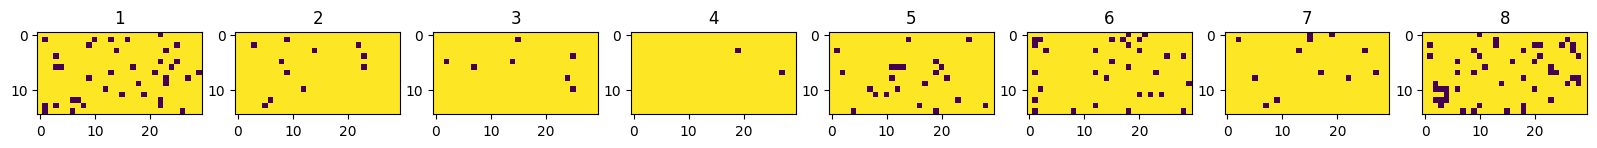

Num timesteps: 4512000
Best mean reward: -43188767.30 - Last mean reward per episode: -65898532.80


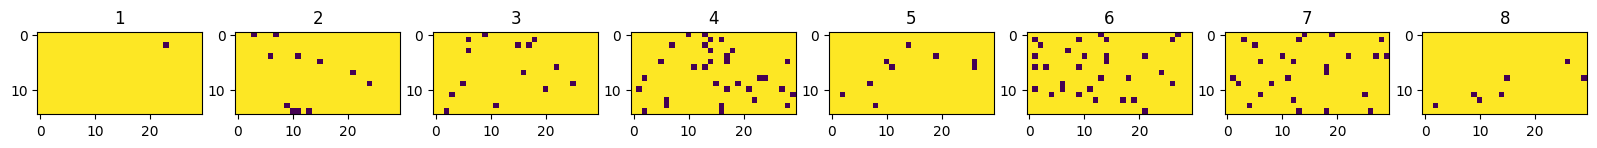

Num timesteps: 4520000
Best mean reward: -43188767.30 - Last mean reward per episode: -60582822.65


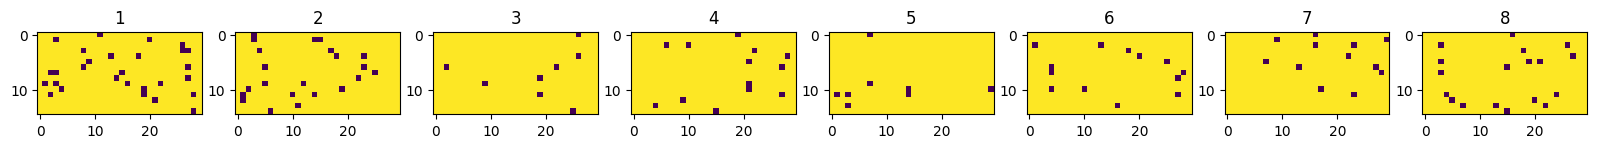

Num timesteps: 4528000
Best mean reward: -43188767.30 - Last mean reward per episode: -59110123.27


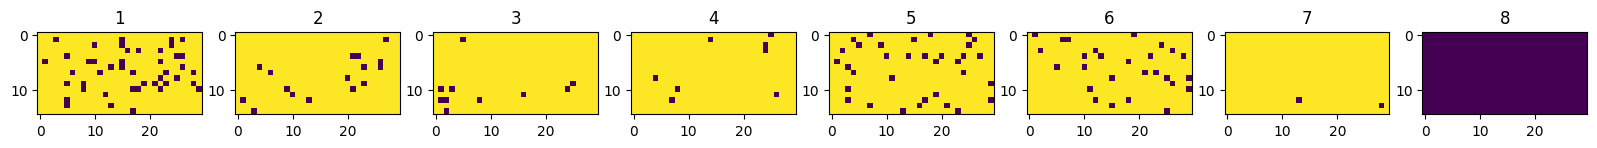

Num timesteps: 4536000
Best mean reward: -43188767.30 - Last mean reward per episode: -65441508.56


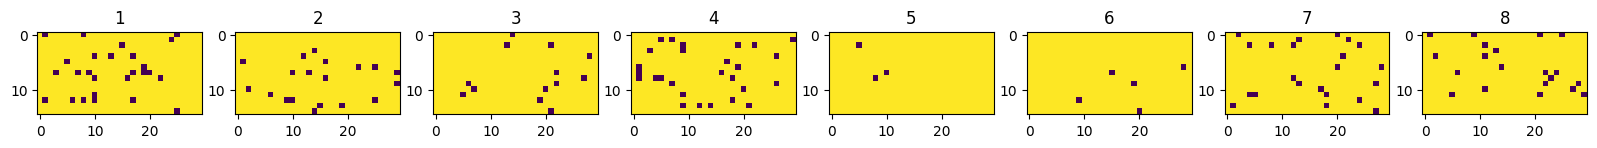

Num timesteps: 4544000
Best mean reward: -43188767.30 - Last mean reward per episode: -55523977.58


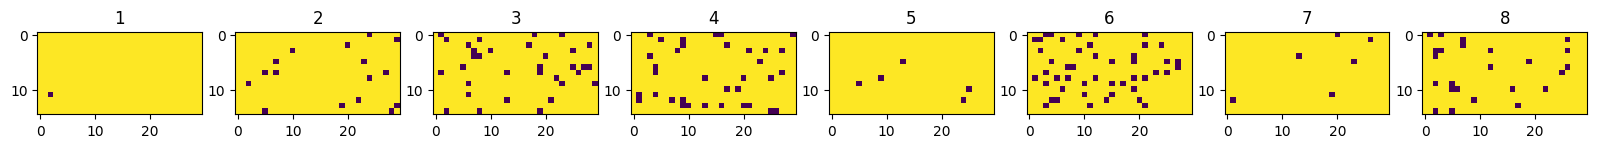

Num timesteps: 4552000
Best mean reward: -43188767.30 - Last mean reward per episode: -59505893.57


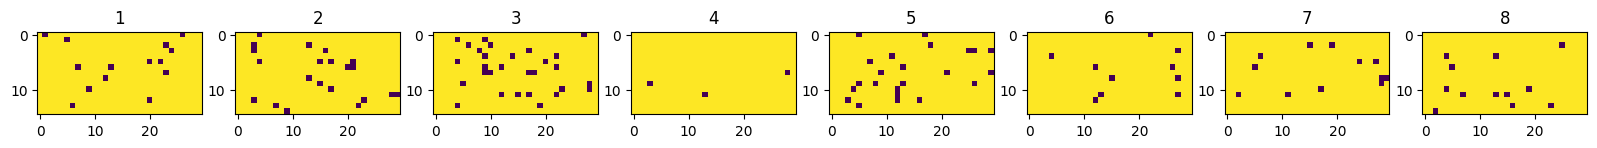

Num timesteps: 4560000
Best mean reward: -43188767.30 - Last mean reward per episode: -69468233.51


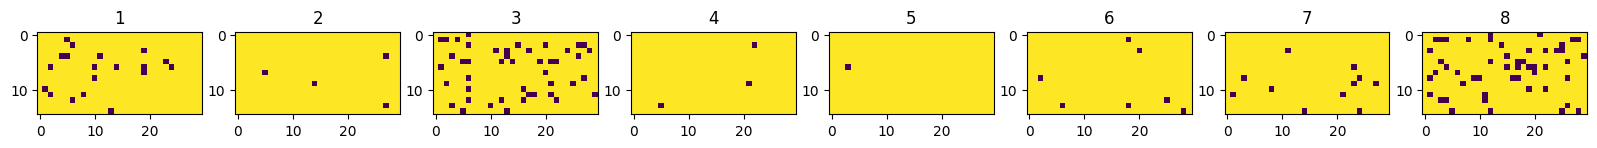

Num timesteps: 4568000
Best mean reward: -43188767.30 - Last mean reward per episode: -55076227.91


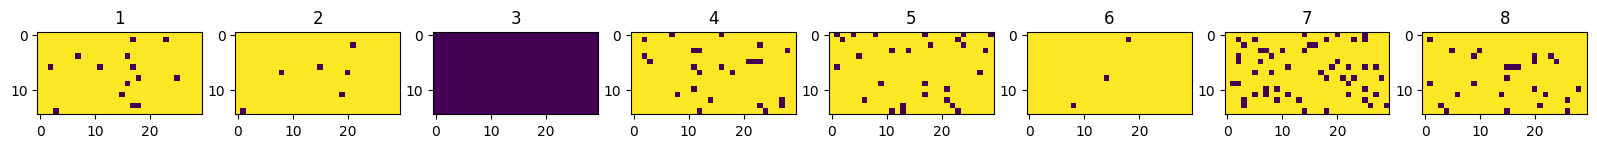

Num timesteps: 4576000
Best mean reward: -43188767.30 - Last mean reward per episode: -57506533.46


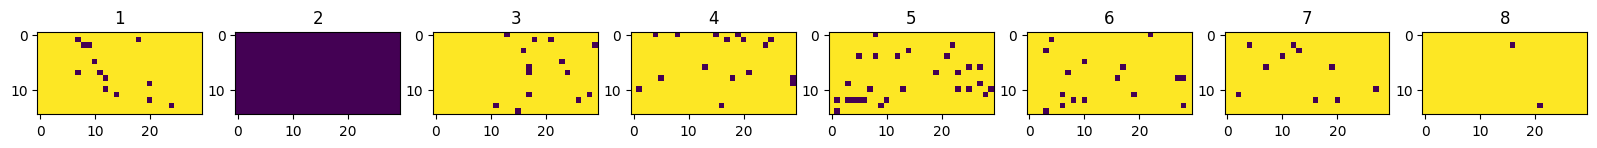

Num timesteps: 4584000
Best mean reward: -43188767.30 - Last mean reward per episode: -46863423.11


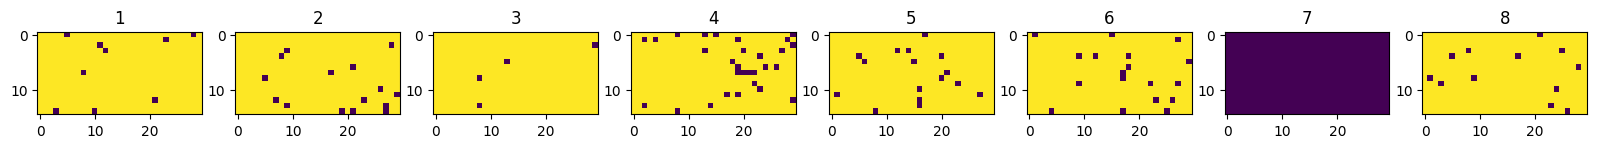

Num timesteps: 4592000
Best mean reward: -43188767.30 - Last mean reward per episode: -65720688.08


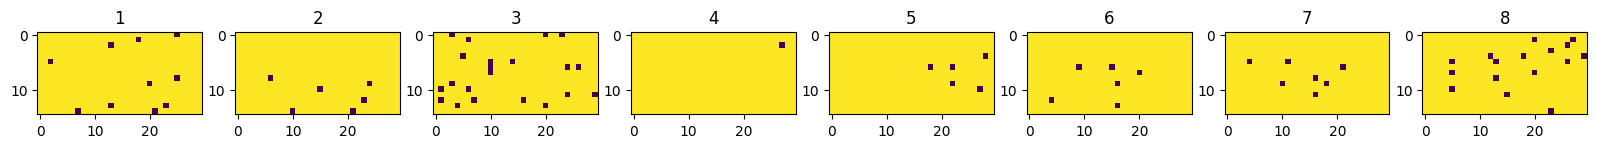

Num timesteps: 4600000
Best mean reward: -43188767.30 - Last mean reward per episode: -60515082.66


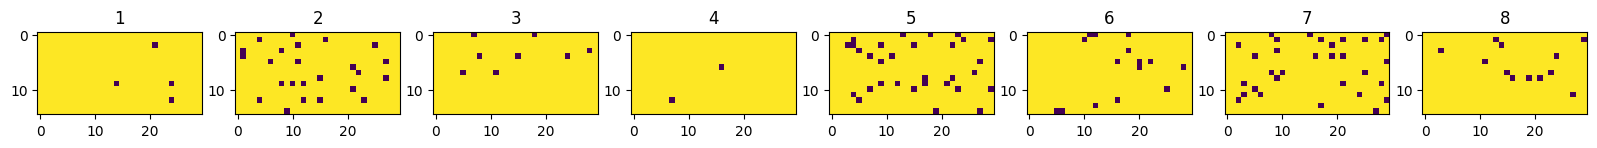

Num timesteps: 4608000
Best mean reward: -43188767.30 - Last mean reward per episode: -61054967.18


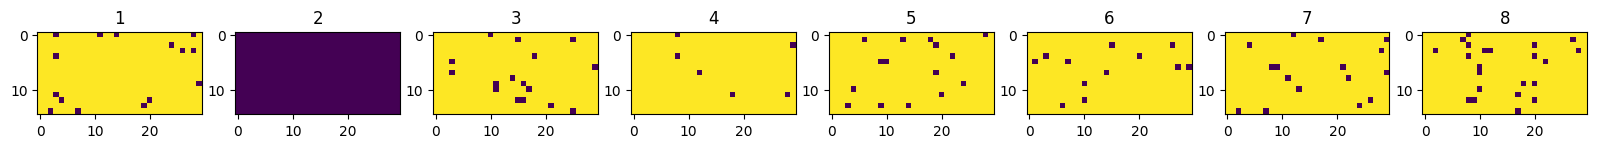

Num timesteps: 4616000
Best mean reward: -43188767.30 - Last mean reward per episode: -52693625.92


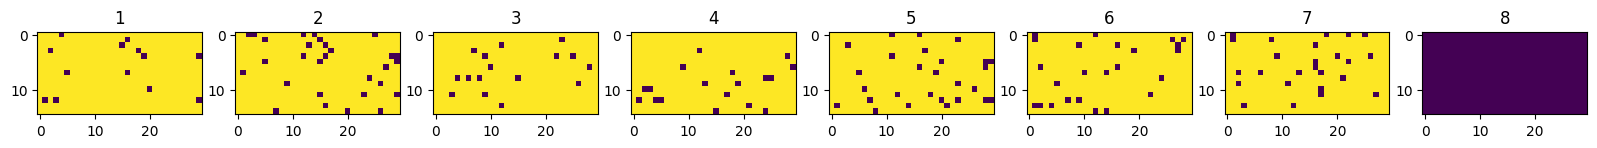

Num timesteps: 4624000
Best mean reward: -43188767.30 - Last mean reward per episode: -65082306.25


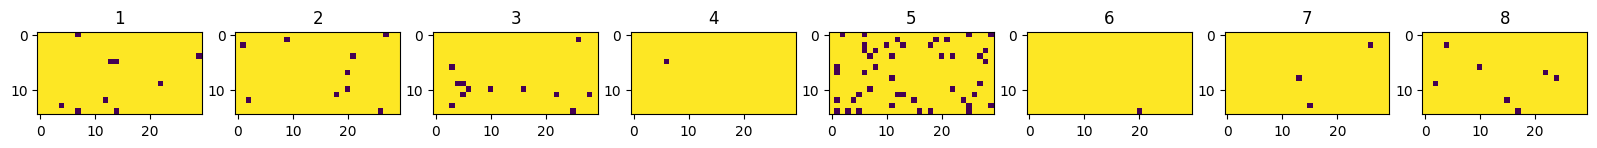

Num timesteps: 4632000
Best mean reward: -43188767.30 - Last mean reward per episode: -64502501.61


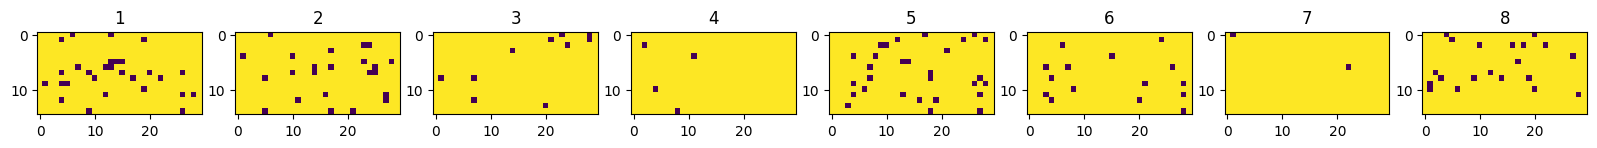

Num timesteps: 4640000
Best mean reward: -43188767.30 - Last mean reward per episode: -52420269.56


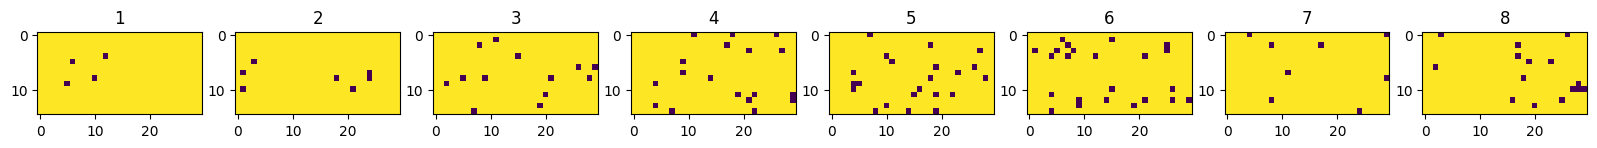

Num timesteps: 4648000
Best mean reward: -43188767.30 - Last mean reward per episode: -60904497.30


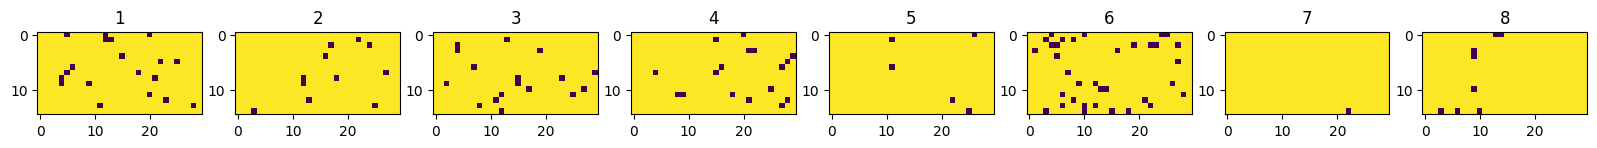

Num timesteps: 4656000
Best mean reward: -43188767.30 - Last mean reward per episode: -68018830.64


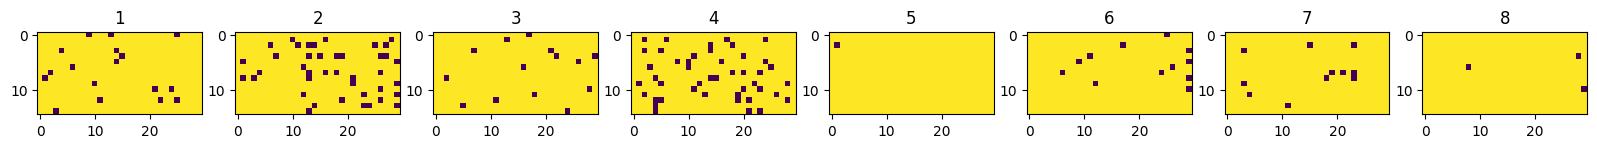

Num timesteps: 4664000
Best mean reward: -43188767.30 - Last mean reward per episode: -54777280.80


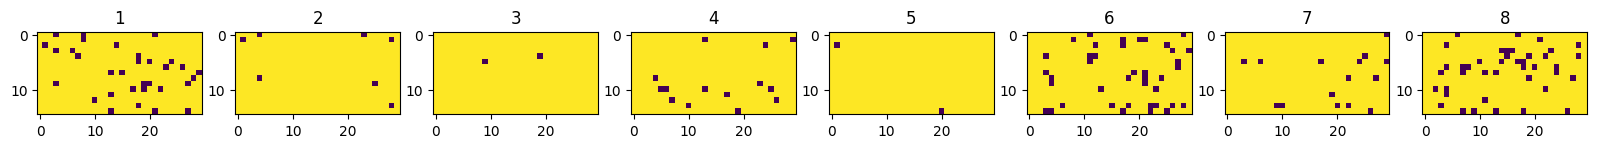

Num timesteps: 4672000
Best mean reward: -43188767.30 - Last mean reward per episode: -52072279.08


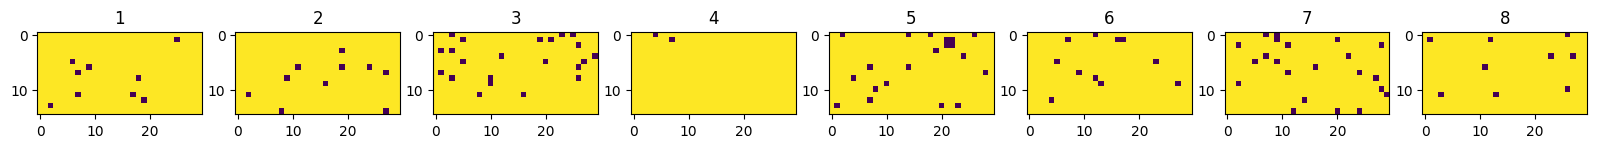

Num timesteps: 4680000
Best mean reward: -43188767.30 - Last mean reward per episode: -57614335.80


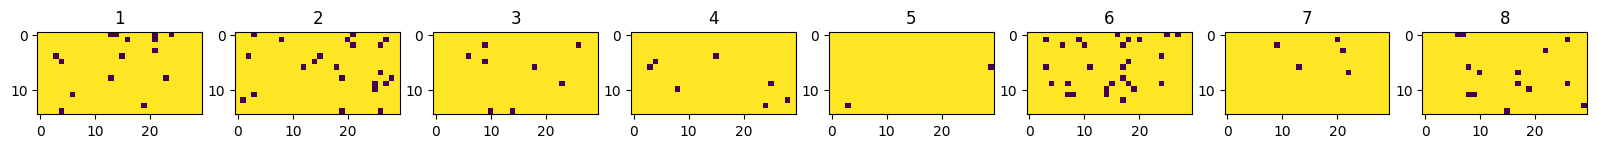

Num timesteps: 4688000
Best mean reward: -43188767.30 - Last mean reward per episode: -49863822.07


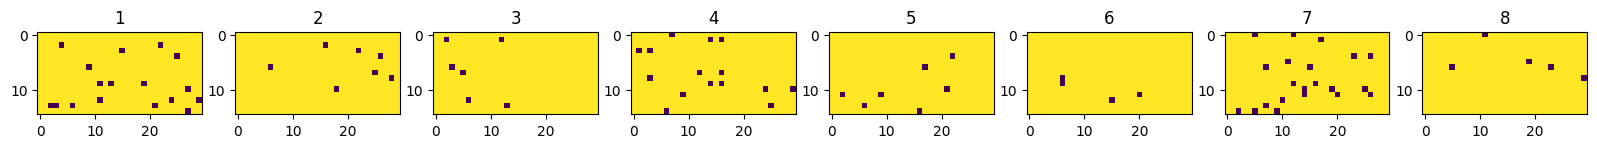

Num timesteps: 4696000
Best mean reward: -43188767.30 - Last mean reward per episode: -50641283.45


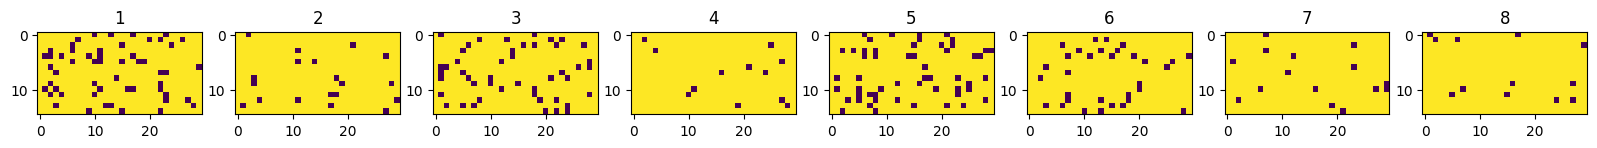

Num timesteps: 4704000
Best mean reward: -43188767.30 - Last mean reward per episode: -59873495.16


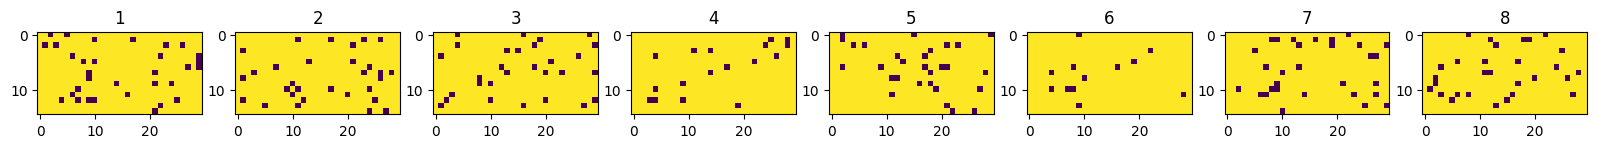

Num timesteps: 4712000
Best mean reward: -43188767.30 - Last mean reward per episode: -48323018.16


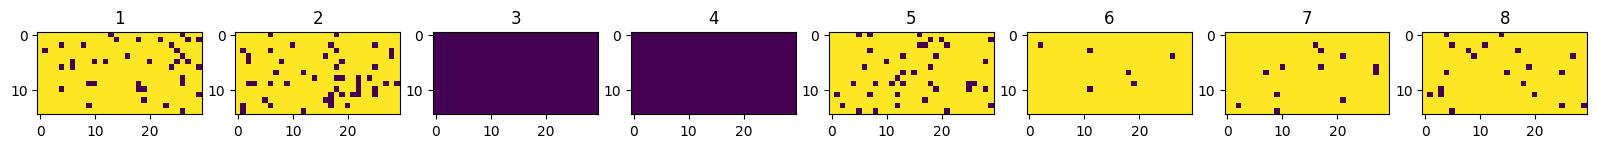

Num timesteps: 4720000
Best mean reward: -43188767.30 - Last mean reward per episode: -54165938.13


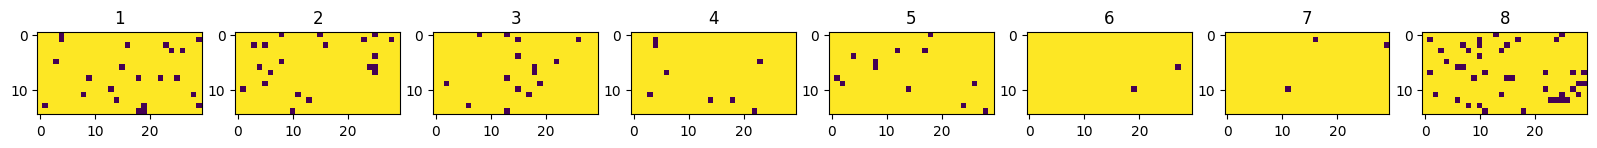

Num timesteps: 4728000
Best mean reward: -43188767.30 - Last mean reward per episode: -52450452.22


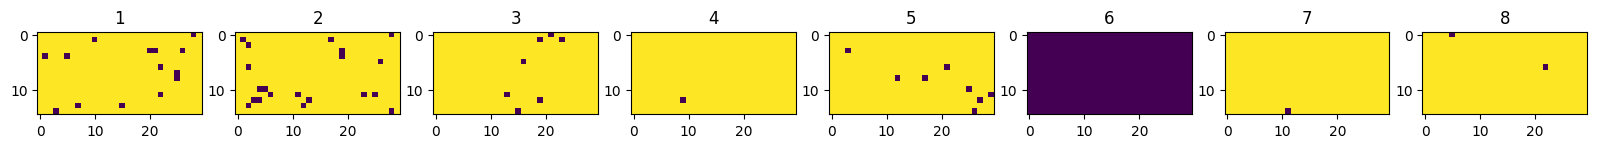

Num timesteps: 4736000
Best mean reward: -43188767.30 - Last mean reward per episode: -56309326.00


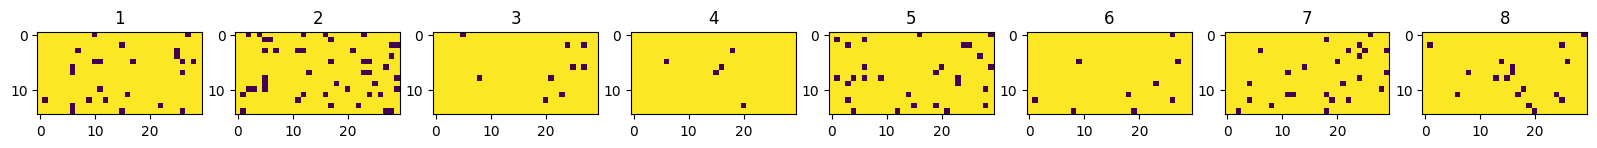

Num timesteps: 4744000
Best mean reward: -43188767.30 - Last mean reward per episode: -59577478.58


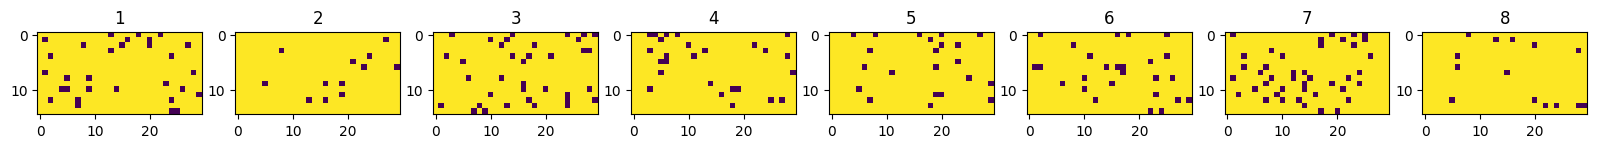

Num timesteps: 4752000
Best mean reward: -43188767.30 - Last mean reward per episode: -54196493.77


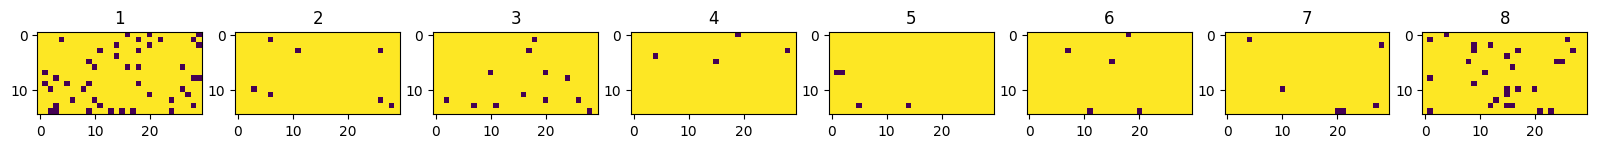

Num timesteps: 4760000
Best mean reward: -43188767.30 - Last mean reward per episode: -60647453.48


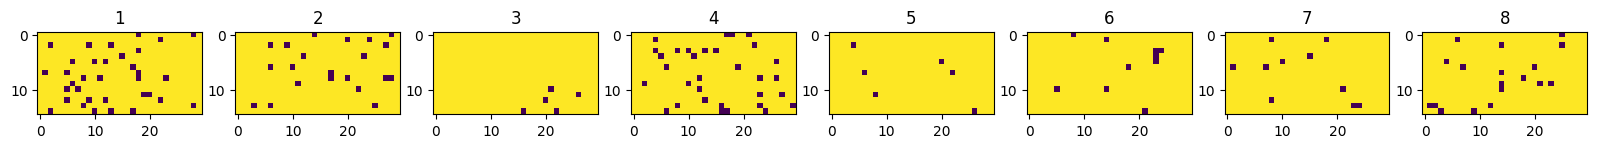

Num timesteps: 4768000
Best mean reward: -43188767.30 - Last mean reward per episode: -54741163.93


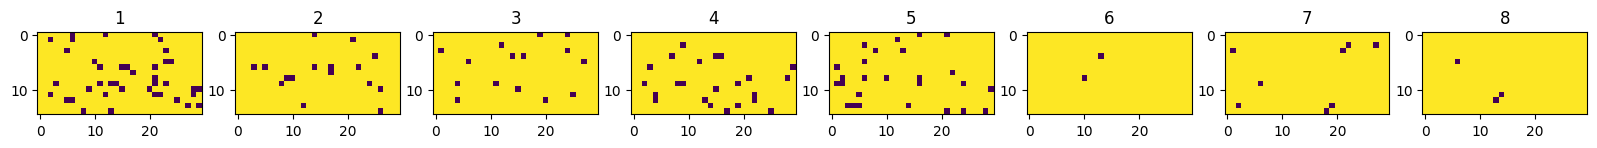

Num timesteps: 4776000
Best mean reward: -43188767.30 - Last mean reward per episode: -57822375.87


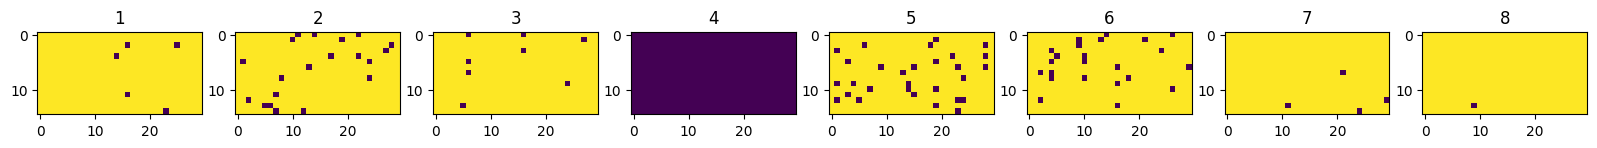

Num timesteps: 4784000
Best mean reward: -43188767.30 - Last mean reward per episode: -58003366.42


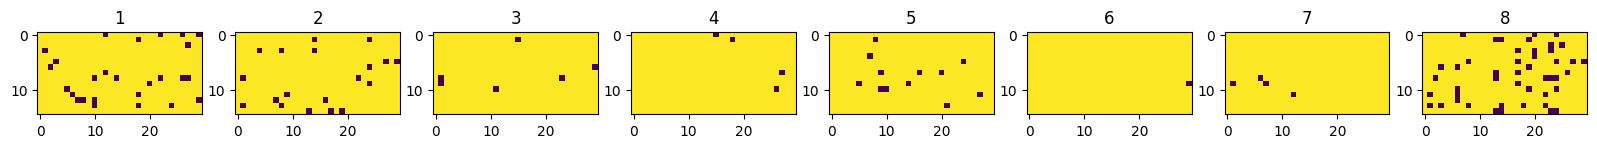

Num timesteps: 4792000
Best mean reward: -43188767.30 - Last mean reward per episode: -60902729.95


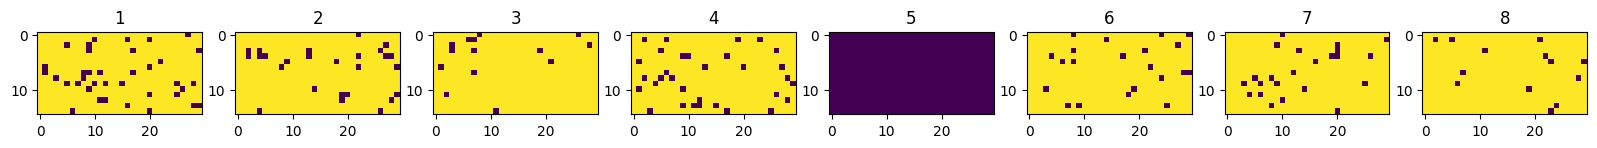

Num timesteps: 4800000
Best mean reward: -43188767.30 - Last mean reward per episode: -58016111.57


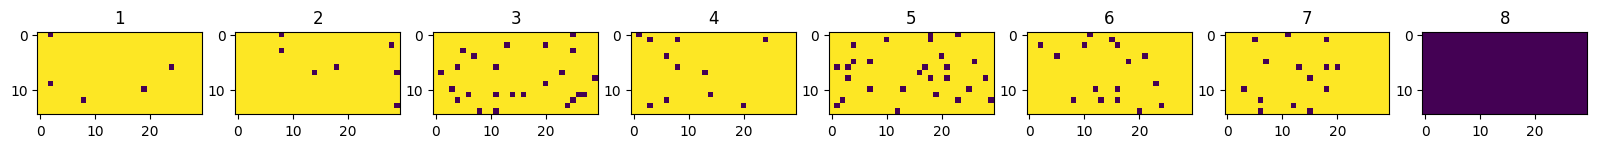

Num timesteps: 4808000
Best mean reward: -43188767.30 - Last mean reward per episode: -58152117.58


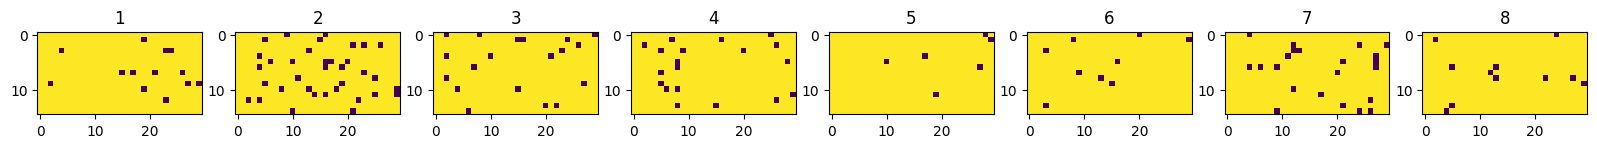

Num timesteps: 4816000
Best mean reward: -43188767.30 - Last mean reward per episode: -50042406.73


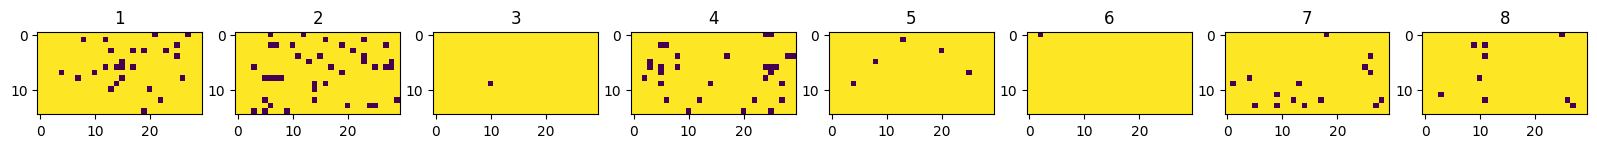

Num timesteps: 4824000
Best mean reward: -43188767.30 - Last mean reward per episode: -51959192.56


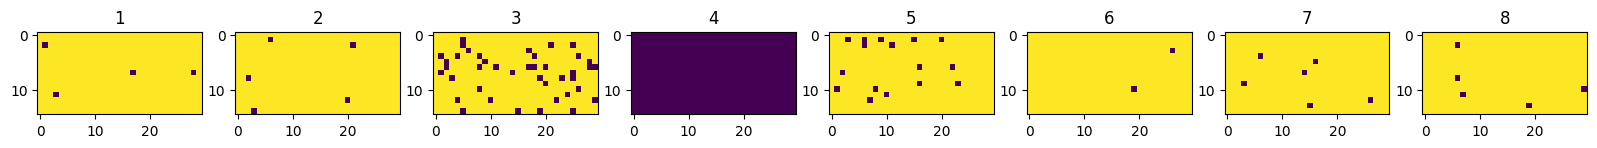

Num timesteps: 4832000
Best mean reward: -43188767.30 - Last mean reward per episode: -66208184.72


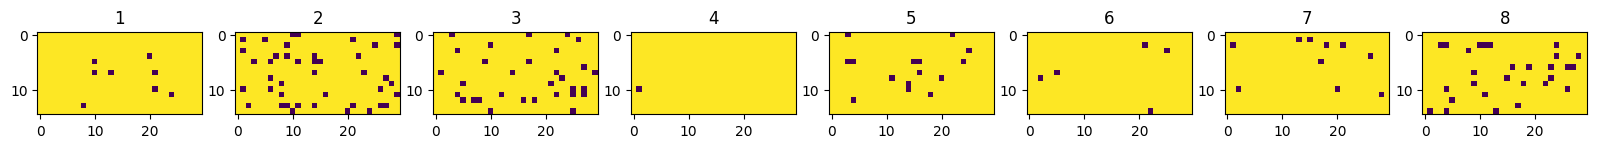

Num timesteps: 4840000
Best mean reward: -43188767.30 - Last mean reward per episode: -57408995.89


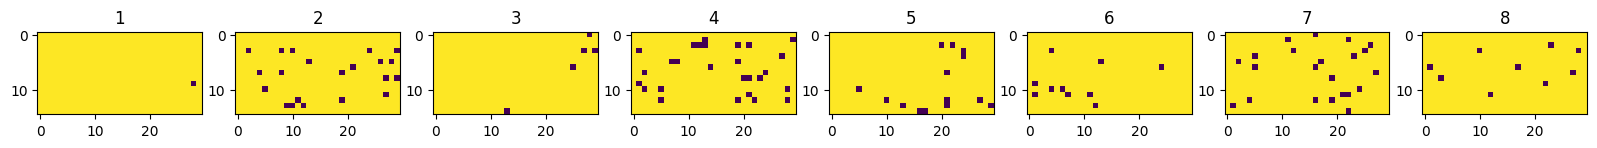

Num timesteps: 4848000
Best mean reward: -43188767.30 - Last mean reward per episode: -54609436.84


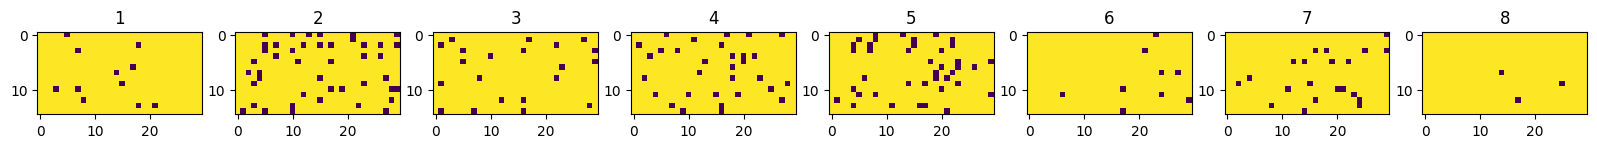

Num timesteps: 4856000
Best mean reward: -43188767.30 - Last mean reward per episode: -56120191.73


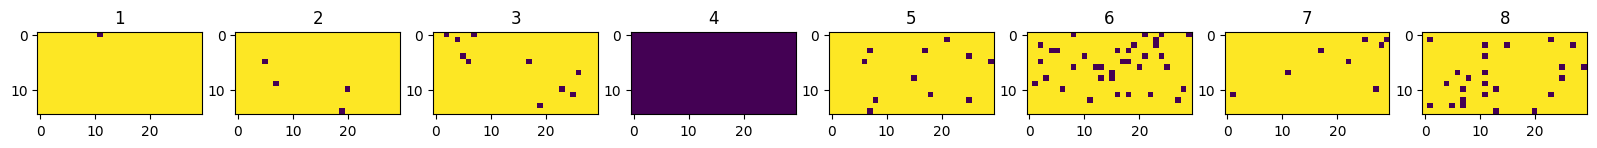

Num timesteps: 4864000
Best mean reward: -43188767.30 - Last mean reward per episode: -66988236.20


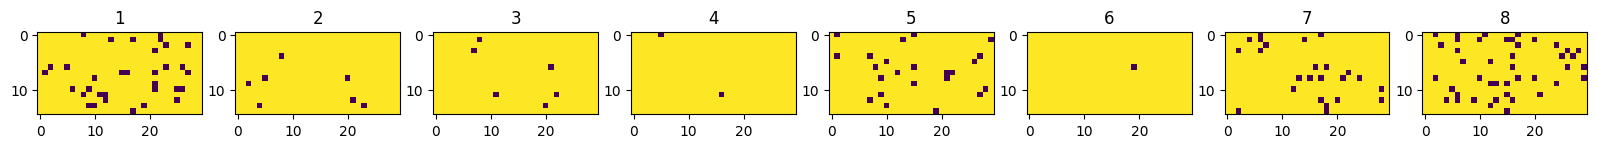

Num timesteps: 4872000
Best mean reward: -43188767.30 - Last mean reward per episode: -57085859.78


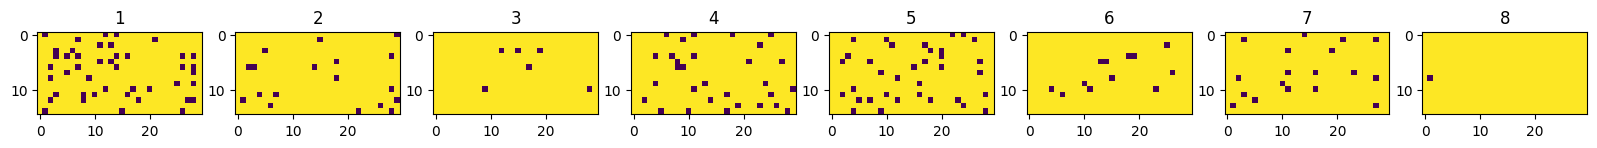

Num timesteps: 4880000
Best mean reward: -43188767.30 - Last mean reward per episode: -57933922.06


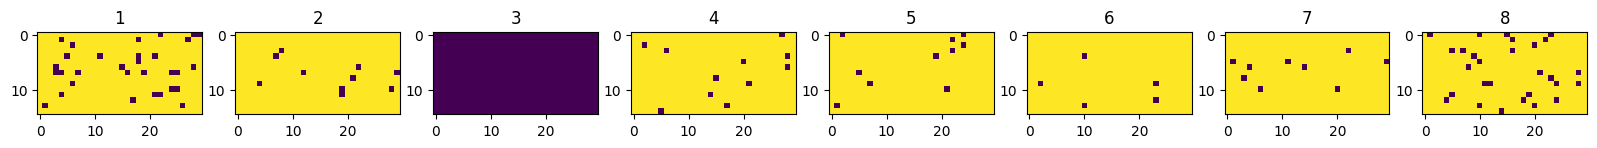

Num timesteps: 4888000
Best mean reward: -43188767.30 - Last mean reward per episode: -60178788.53


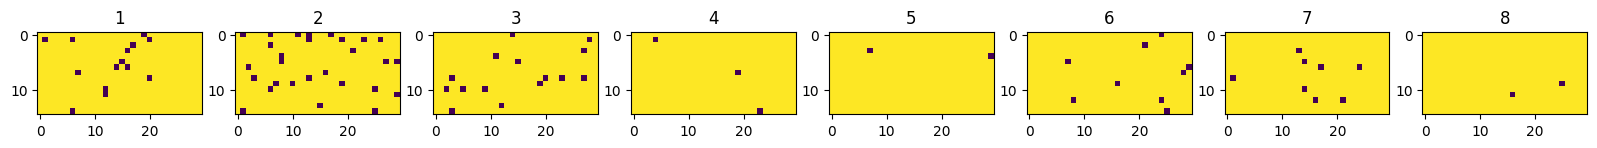

Num timesteps: 4896000
Best mean reward: -43188767.30 - Last mean reward per episode: -58008023.80


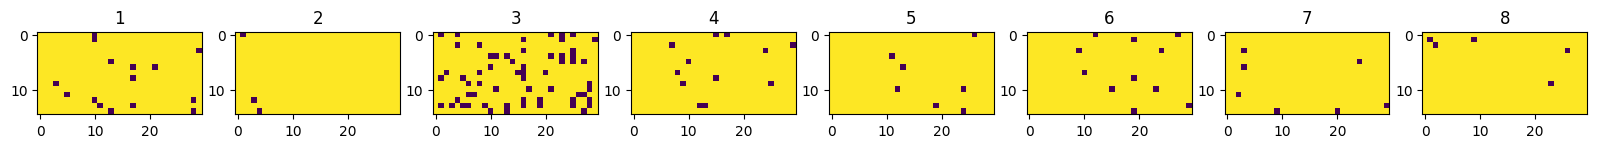

Num timesteps: 4904000
Best mean reward: -43188767.30 - Last mean reward per episode: -58932685.66


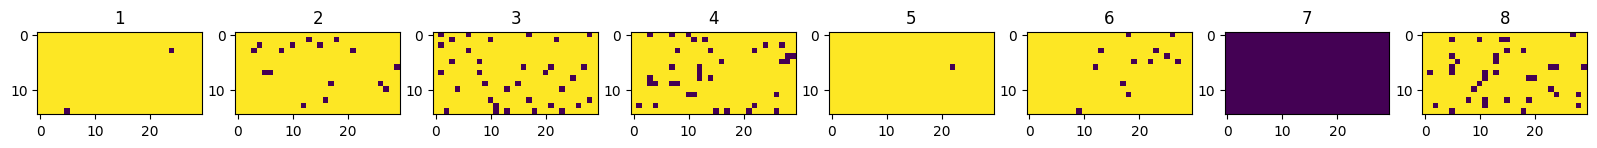

Num timesteps: 4912000
Best mean reward: -43188767.30 - Last mean reward per episode: -57560496.79


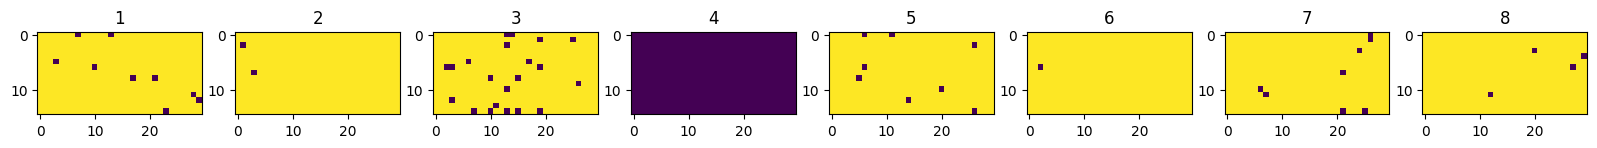

Num timesteps: 4920000
Best mean reward: -43188767.30 - Last mean reward per episode: -54918068.49


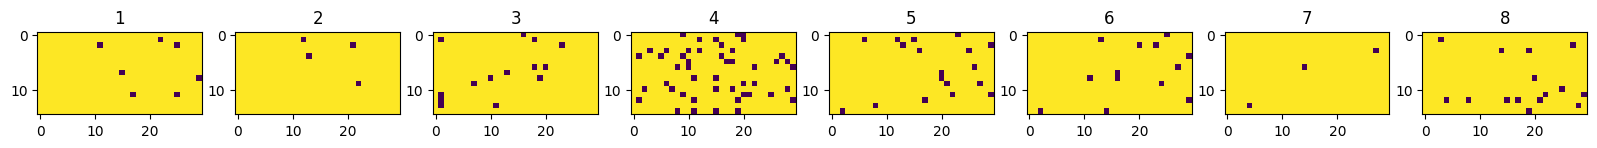

Num timesteps: 4928000
Best mean reward: -43188767.30 - Last mean reward per episode: -46741723.88


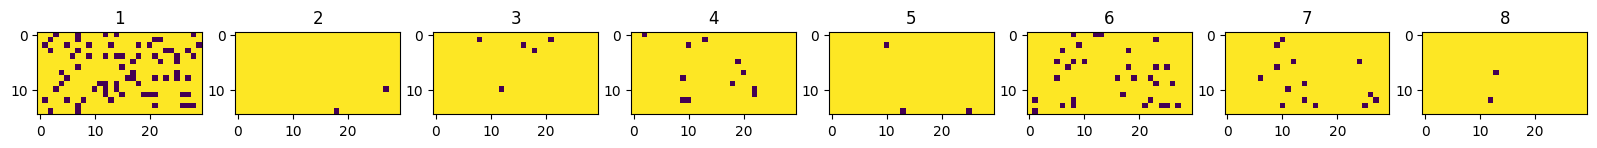

Num timesteps: 4936000
Best mean reward: -43188767.30 - Last mean reward per episode: -56406386.32


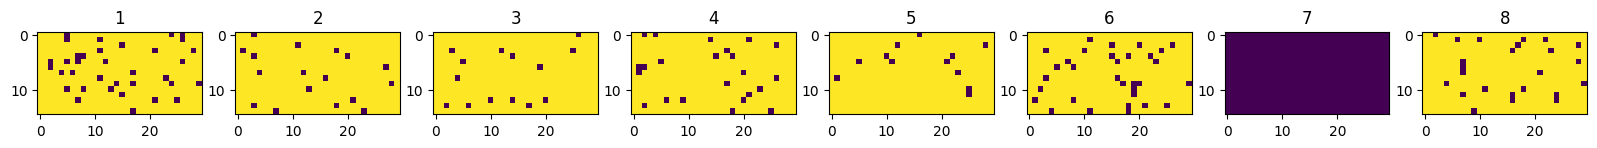

Num timesteps: 4944000
Best mean reward: -43188767.30 - Last mean reward per episode: -54475654.09


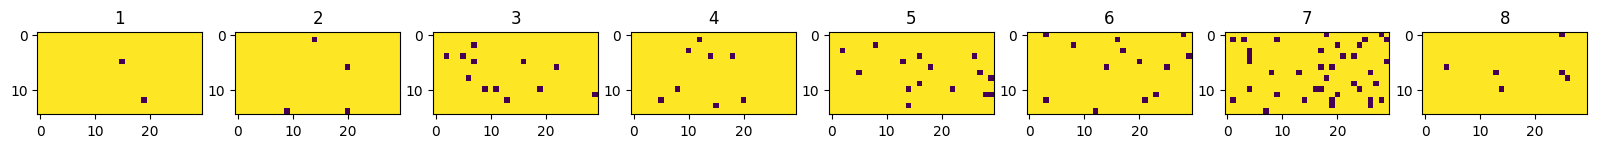

Num timesteps: 4952000
Best mean reward: -43188767.30 - Last mean reward per episode: -55609701.78


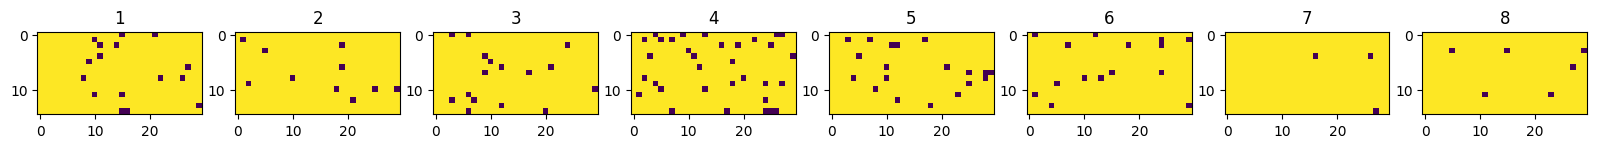

Num timesteps: 4960000
Best mean reward: -43188767.30 - Last mean reward per episode: -52454498.49


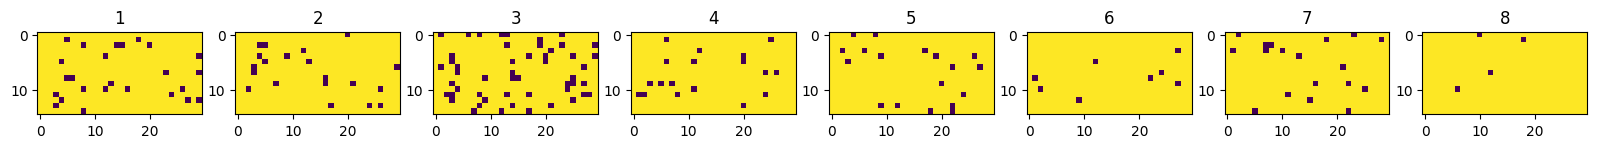

Num timesteps: 4968000
Best mean reward: -43188767.30 - Last mean reward per episode: -66424598.54


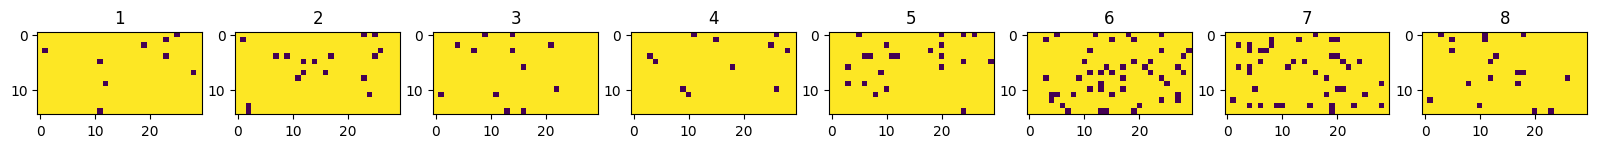

Num timesteps: 4976000
Best mean reward: -43188767.30 - Last mean reward per episode: -61177116.45


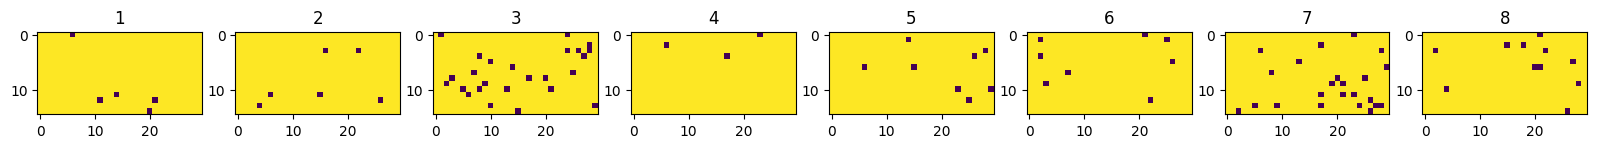

Num timesteps: 4984000
Best mean reward: -43188767.30 - Last mean reward per episode: -48844277.83


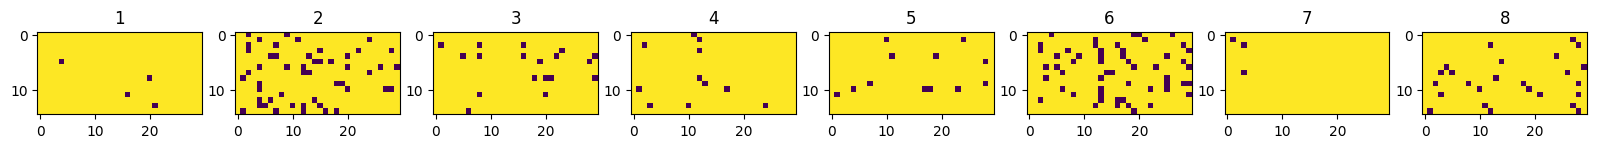

Num timesteps: 4992000
Best mean reward: -43188767.30 - Last mean reward per episode: -64151547.56


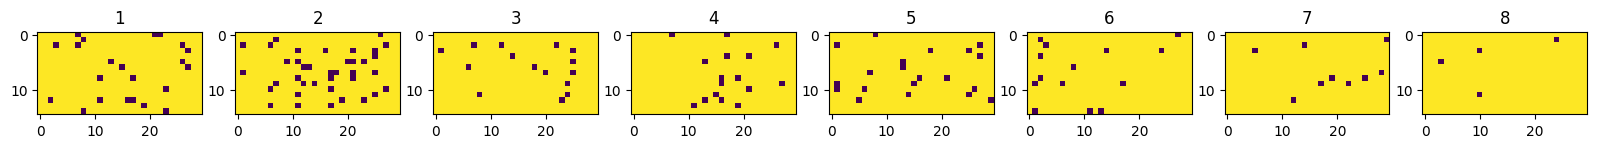

Num timesteps: 5000000
Best mean reward: -43188767.30 - Last mean reward per episode: -56555562.58


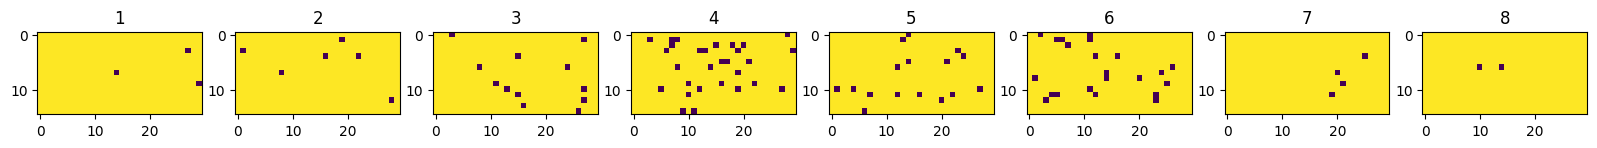

Num timesteps: 5008000
Best mean reward: -43188767.30 - Last mean reward per episode: -57337740.19


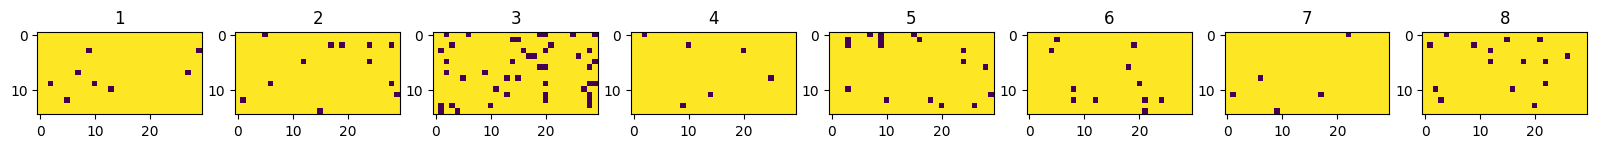

Elapsed Time = 17995.678643465042


In [28]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   
print("Elapsed Time = " + str(end-start))

Step 1
(6, 0)
current Design


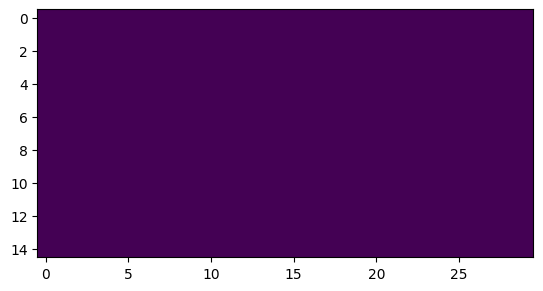

Step 2
(9, 0)
Step 3
(7, 0)
Step 4
(1, 0)
Step 5
(10, 26)
Step 6
(6, 0)
Step 7
(5, 0)
Step 8
(4, 0)
Step 9
(9, 0)
Step 10
(7, 0)
Step 11
(1, 21)
current Design


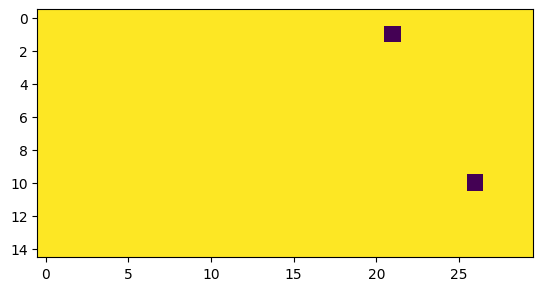

Step 12
(1, 0)
Step 13
(9, 0)
Step 14
(4, 0)
Step 15
(9, 0)
Step 16
(9, 0)
Step 17
(9, 0)
Step 18
(13, 0)
Step 19
(9, 0)
Step 20
(6, 0)
Step 21
(7, 0)
current Design


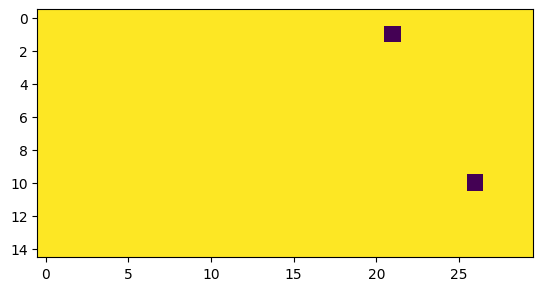

Step 22
(14, 0)
Step 23
(1, 0)
Step 24
(6, 0)
Step 25
(7, 0)
Step 26
(9, 0)
Step 27
(7, 0)
Step 28
(9, 0)
Step 29
(9, 0)
Step 30
(5, 0)
Step 31
(14, 0)
current Design


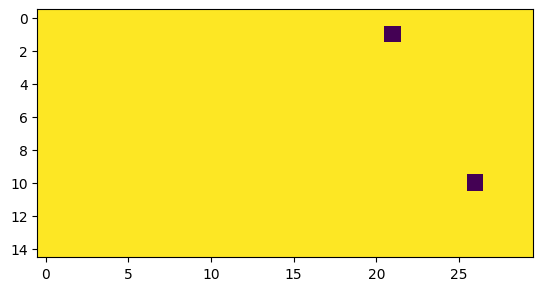

Step 32
(6, 0)
Step 33
(11, 0)
Step 34
(1, 0)
Step 35
(11, 0)
Step 36
(9, 0)
Step 37
(2, 0)
Step 38
(1, 0)
Step 39
(1, 0)
Step 40
(9, 0)
Step 41
(7, 0)
current Design


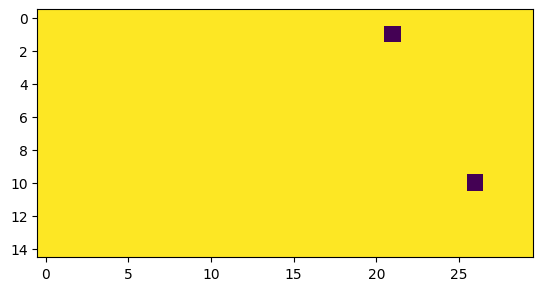

Step 42
(9, 0)
Step 43
(7, 0)
Step 44
(5, 0)
Step 45
(11, 0)
Step 46
(9, 0)
Step 47
(13, 0)
Step 48
(9, 12)
Step 49
(9, 0)
Step 50
(5, 0)
Step 51
(7, 0)
current Design


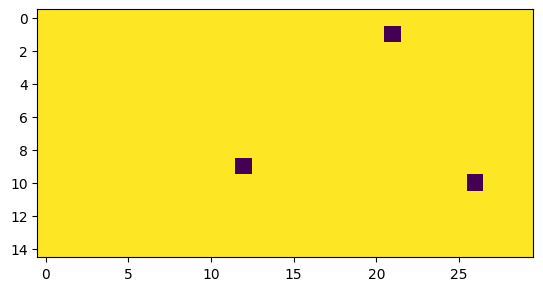

Step 52
(9, 0)
Step 53
(5, 25)
Step 54
(6, 0)
Step 55
(11, 0)
Step 56
(9, 0)
Step 57
(14, 29)
Step 58
(11, 0)
Step 59
(12, 0)
Step 60
(7, 0)
Step 61
(5, 0)
current Design


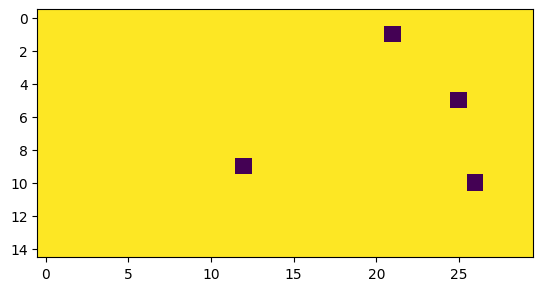

Step 62
(12, 0)
Step 63
(9, 0)
Step 64
(9, 0)
Step 65
(6, 0)
Step 66
(5, 0)
Step 67
(6, 0)
Step 68
(12, 0)
Step 69
(9, 0)
Step 70
(0, 0)
Step 71
(1, 0)
current Design


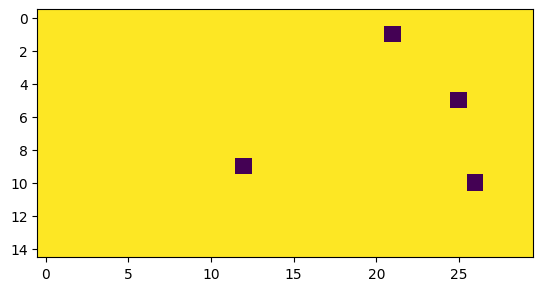

Step 72
(5, 0)
Step 73
(5, 0)
Step 74
(8, 3)
Step 75
(2, 0)
Step 76
(14, 29)
Step 77
(9, 0)
Step 78
(9, 0)
Step 79
(6, 0)
Step 80
(2, 0)
Step 81
(9, 0)
current Design


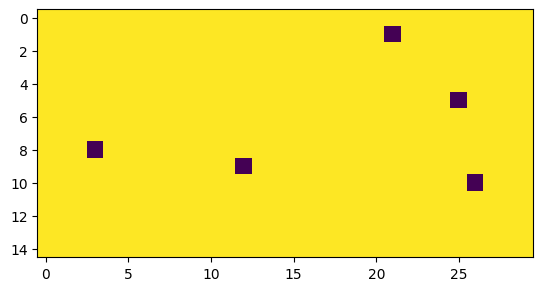

Step 82
(6, 0)
Step 83
(2, 0)
Step 84
(6, 0)
Step 85
(13, 0)
Step 86
(7, 0)
Step 87
(8, 0)
Step 88
(9, 0)
Step 89
(1, 0)
Step 90
(4, 17)
Step 91
(2, 0)
current Design


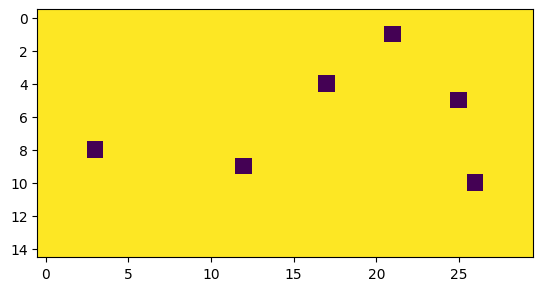

Step 92
(7, 0)
Step 93
(14, 0)
Step 94
(13, 0)
Step 95
(1, 0)
Step 96
(2, 0)
Step 97
(7, 0)
Step 98
(6, 0)
Step 99
(2, 0)
Step 100
(1, 20)
Step 101
(0, 0)
current Design


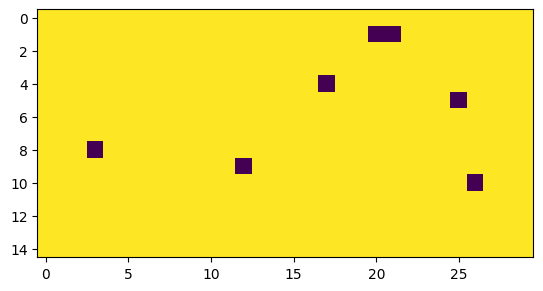

Step 102
(0, 0)
Step 103
(1, 0)
Step 104
(5, 0)
Step 105
(9, 0)
Step 106
(9, 0)
Step 107
(4, 0)
Step 108
(5, 0)
Step 109
(7, 0)
Step 110
(9, 0)
Step 111
(12, 2)
current Design


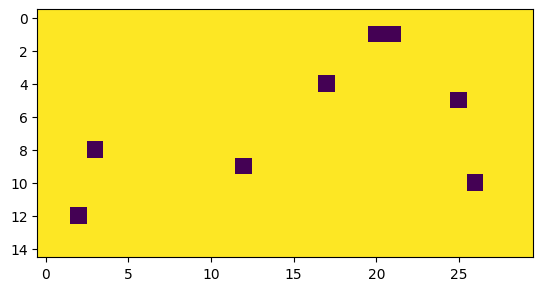

Step 112
(5, 0)
Step 113
(4, 0)
Step 114
(5, 0)
Step 115
(7, 0)
Step 116
(7, 0)
Step 117
(14, 0)
Step 118
(6, 0)
Step 119
(10, 0)
Step 120
(5, 0)
Step 121
(6, 0)
current Design


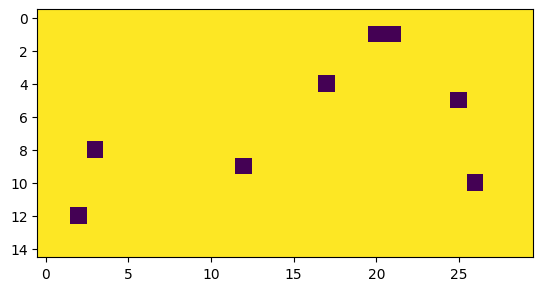

Step 122
(7, 0)
Step 123
(2, 5)
Step 124
(6, 19)
Step 125
(10, 17)
Step 126
(14, 29)
Step 127
(9, 0)
Step 128
(6, 0)
Step 129
(7, 6)
Step 130
(5, 0)
Step 131
(10, 29)
current Design


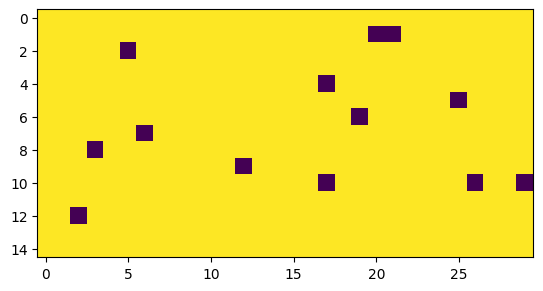

Step 132
(7, 0)
Step 133
(9, 0)
Step 134
(12, 0)
Step 135
(5, 0)
Step 136
(12, 0)
Step 137
(9, 0)
Step 138
(13, 0)
Step 139
(1, 0)
Step 140
(9, 0)
Step 141
(2, 0)
current Design


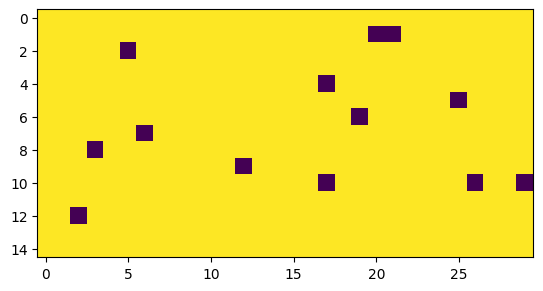

Step 142
(14, 29)
Step 143
(14, 0)
Step 144
(1, 0)
Step 145
(9, 0)
Step 146
(13, 0)
Step 147
(3, 0)
Step 148
(12, 0)
Step 149
(5, 0)
Step 150
(0, 0)
Step 151
(8, 0)
current Design


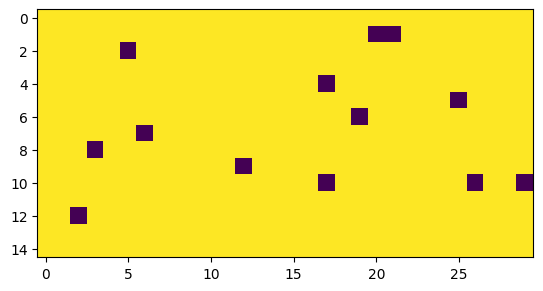

Step 152
(2, 0)
Step 153
(13, 0)
Step 154
(9, 0)
Step 155
(9, 0)
Step 156
(10, 0)
Step 157
(9, 0)
Step 158
(10, 0)
Step 159
(12, 0)
Step 160
(9, 0)
Step 161
(1, 0)
current Design


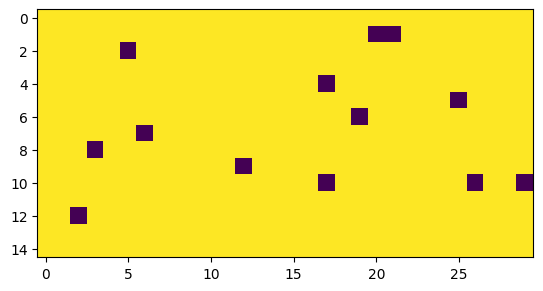

Step 162
(6, 0)
Step 163
(7, 0)
Step 164
(9, 0)
Step 165
(7, 0)
Step 166
(1, 0)
Step 167
(4, 0)
Step 168
(6, 0)
Step 169
(0, 0)
Step 170
(13, 0)
Step 171
(5, 0)
current Design


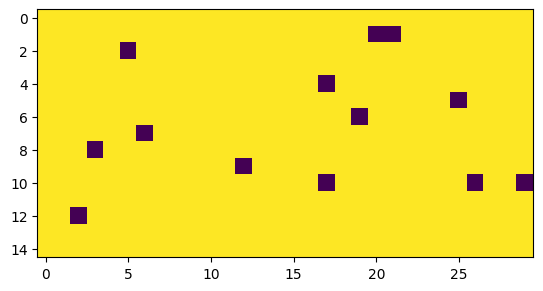

Step 172
(9, 0)
Step 173
(8, 0)
Step 174
(12, 0)
Step 175
(1, 0)
Step 176
(11, 0)
Step 177
(7, 0)
Step 178
(13, 0)
Step 179
(3, 0)
Step 180
(11, 0)
Step 181
(8, 0)
current Design


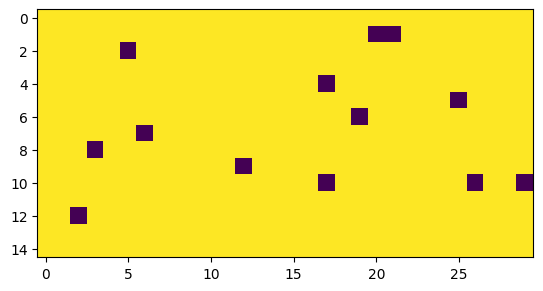

Step 182
(9, 0)
Step 183
(4, 0)
Step 184
(1, 0)
Step 185
(9, 0)
Step 186
(1, 0)
Step 187
(9, 0)
Step 188
(10, 0)
Step 189
(12, 0)
Step 190
(5, 0)
Step 191
(13, 0)
current Design


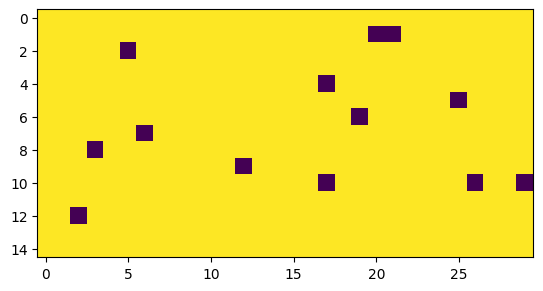

Step 192
(13, 0)
Step 193
(8, 18)
Step 194
(10, 0)
Step 195
(8, 0)
Step 196
(9, 0)
Step 197
(12, 0)
Step 198
(7, 0)
Step 199
(13, 0)
Step 200
(6, 0)
Step 201
(8, 0)
current Design


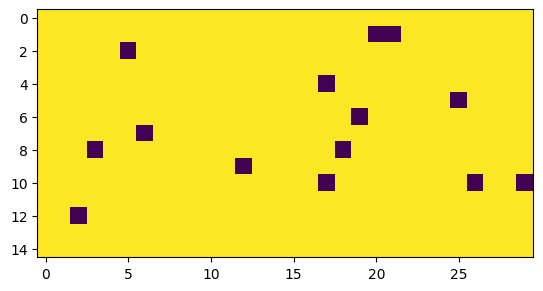

Step 202
(4, 25)
Step 203
(0, 0)
Step 204
(4, 0)
Step 205
(9, 0)
Step 206
(1, 0)
Step 207
(1, 0)
Step 208
(12, 0)
Step 209
(12, 0)
Step 210
(5, 0)
Step 211
(3, 29)
current Design


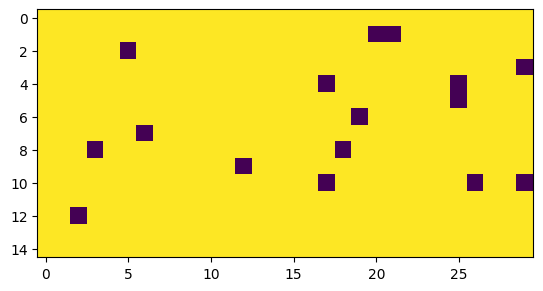

Step 212
(5, 0)
Step 213
(9, 0)
Step 214
(9, 0)
Step 215
(5, 0)
Step 216
(7, 0)
Step 217
(9, 0)
Step 218
(9, 0)
Step 219
(7, 0)
Step 220
(9, 0)
Step 221
(9, 0)
current Design


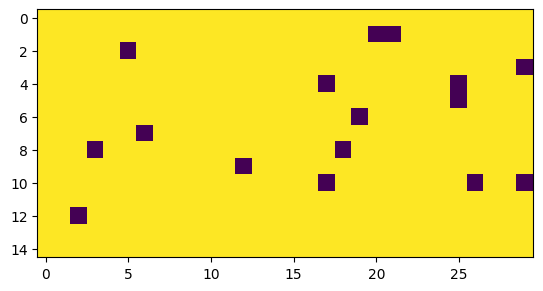

Step 222
(2, 0)
Step 223
(14, 29)
Step 224
(8, 0)
Step 225
(8, 0)
Step 226
(5, 16)
Step 227
(6, 0)
Step 228
(0, 0)
Step 229
(9, 0)
Step 230
(14, 29)
Step 231
(6, 0)
current Design


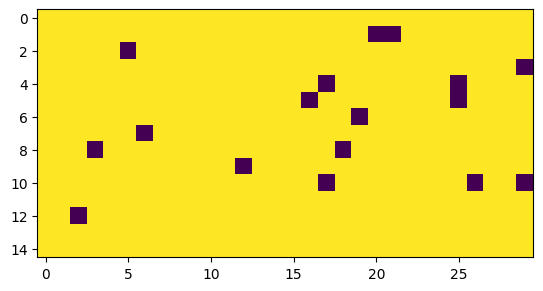

Step 232
(7, 0)
Step 233
(8, 0)
Step 234
(9, 0)
Step 235
(14, 29)
Step 236
(13, 0)
Step 237
(11, 0)
Step 238
(7, 0)
Step 239
(4, 0)
Step 240
(9, 0)
Step 241
(9, 0)
current Design


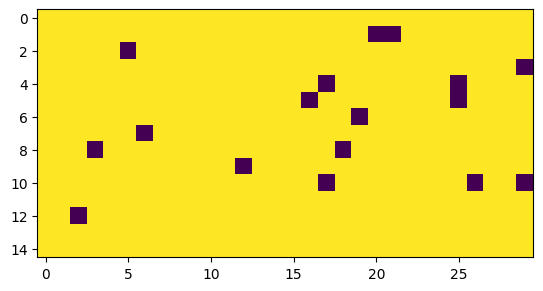

Step 242
(1, 0)
Step 243
(2, 0)
Step 244
(11, 0)
Step 245
(6, 0)
Step 246
(7, 0)
Step 247
(1, 0)
Step 248
(1, 0)
Step 249
(12, 0)
Step 250
(9, 0)
Step 251
(13, 0)
current Design


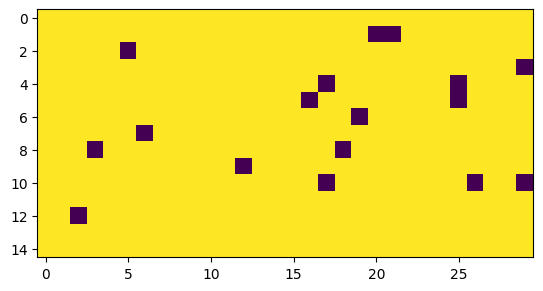

Step 252
(7, 0)
Step 253
(9, 0)
Step 254
(5, 0)
Step 255
(13, 0)
Step 256
(13, 0)
Step 257
(6, 0)
Step 258
(6, 0)
Step 259
(13, 0)
Step 260
(5, 0)
Step 261
(0, 0)
current Design


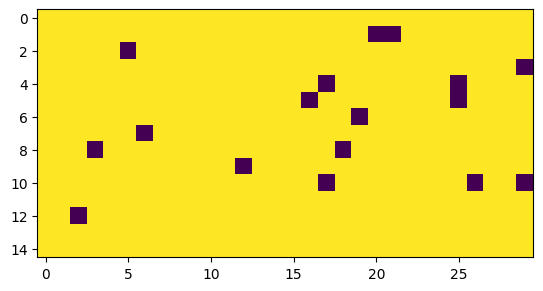

Step 262
(1, 0)
Step 263
(1, 0)
Step 264
(7, 7)
Step 265
(6, 0)
Step 266
(13, 0)
Step 267
(0, 0)
Step 268
(13, 0)
Step 269
(9, 0)
Step 270
(12, 0)
Step 271
(14, 0)
current Design


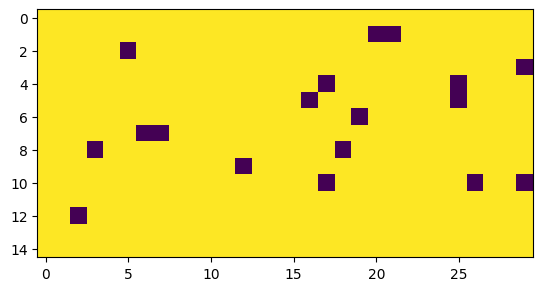

Step 272
(6, 0)
Step 273
(5, 0)
Step 274
(5, 0)
Step 275
(9, 0)
Step 276
(9, 0)
Step 277
(9, 0)
Step 278
(1, 0)
Step 279
(9, 0)
Step 280
(8, 0)
Step 281
(1, 0)
current Design


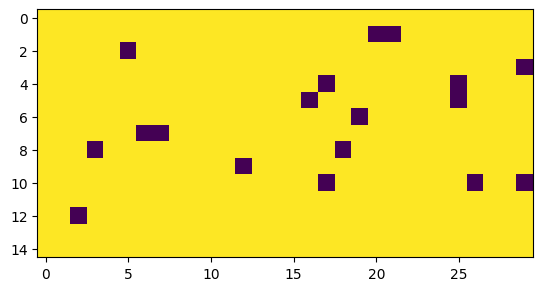

Step 282
(5, 0)
Step 283
(0, 0)
Step 284
(10, 0)
Step 285
(9, 0)
Step 286
(14, 0)
Step 287
(9, 0)
Step 288
(10, 0)
Step 289
(3, 0)
Step 290
(12, 0)
Step 291
(5, 0)
current Design


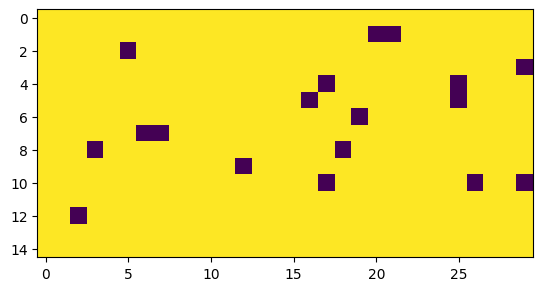

Step 292
(3, 0)
Step 293
(13, 0)
Step 294
(12, 0)
Step 295
(2, 0)
Step 296
(1, 0)
Step 297
(13, 0)
Step 298
(9, 0)
Step 299
(2, 0)
Step 300
(5, 0)
Step 301
(2, 0)
current Design


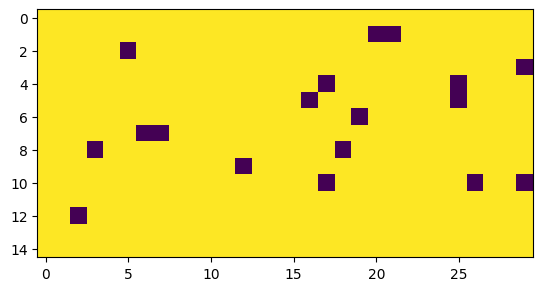

Step 302
(9, 0)
Step 303
(4, 0)
Step 304
(13, 0)
Step 305
(4, 0)
Step 306
(1, 0)
Step 307
(9, 0)
Step 308
(9, 0)
Step 309
(1, 0)
Step 310
(7, 0)
Step 311
(2, 0)
current Design


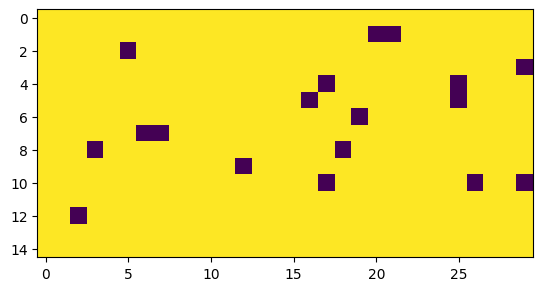

Step 312
(9, 0)
Step 313
(6, 0)
Step 314
(4, 20)
Step 315
(3, 0)
Step 316
(5, 0)
Step 317
(13, 0)
Step 318
(5, 0)
Step 319
(9, 0)
Step 320
(1, 0)
Step 321
(12, 0)
current Design


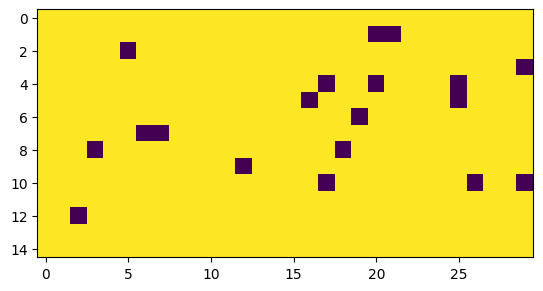

Step 322
(13, 0)
Step 323
(12, 0)
Step 324
(9, 0)
Step 325
(6, 0)
Step 326
(11, 22)
Step 327
(5, 0)
Step 328
(8, 0)
Step 329
(1, 0)
Step 330
(1, 0)
Step 331
(3, 29)
current Design


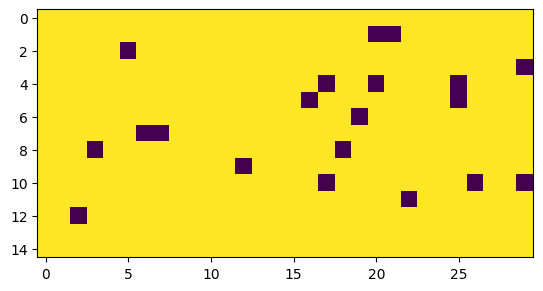

Step 332
(1, 0)
Step 333
(9, 0)
Step 334
(1, 0)
Step 335
(8, 0)
Step 336
(9, 0)
Step 337
(8, 0)
Step 338
(8, 0)
Step 339
(9, 0)
Step 340
(7, 0)
Step 341
(6, 0)
current Design


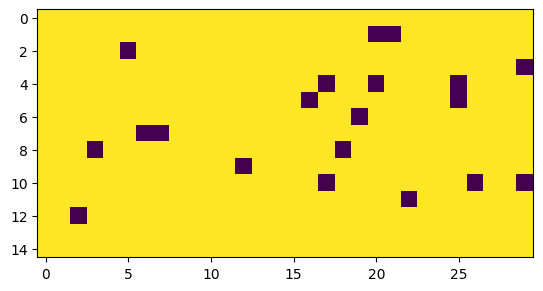

Step 342
(10, 0)
Step 343
(6, 7)
Step 344
(9, 0)
Step 345
(3, 0)
Step 346
(13, 0)
Step 347
(6, 0)
Step 348
(13, 0)
Step 349
(12, 0)
Step 350
(3, 0)
Step 351
(8, 0)
current Design


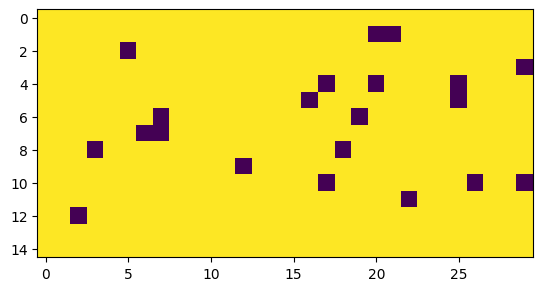

Step 352
(7, 0)
Step 353
(2, 0)
Step 354
(2, 0)
Step 355
(12, 0)
Step 356
(7, 0)
Step 357
(12, 0)
Step 358
(9, 0)
Step 359
(6, 0)
Step 360
(7, 0)
Step 361
(11, 0)
current Design


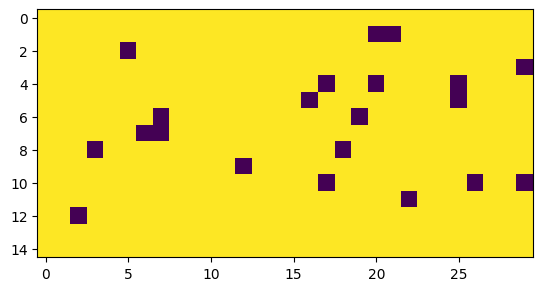

Step 362
(12, 0)
Step 363
(8, 0)
Step 364
(6, 0)
Step 365
(9, 0)
Step 366
(7, 0)
Step 367
(7, 0)
Step 368
(7, 9)
Step 369
(5, 0)
Step 370
(12, 0)
Step 371
(10, 0)
current Design


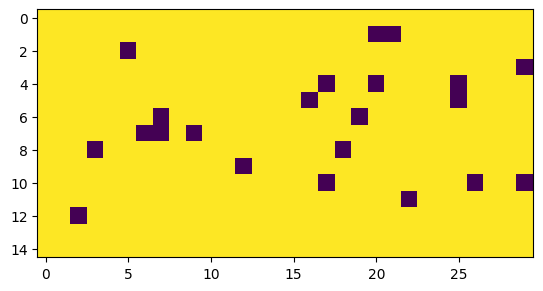

Step 372
(9, 0)
Step 373
(7, 0)
Step 374
(6, 0)
Step 375
(5, 0)
Step 376
(9, 0)
Step 377
(11, 0)
Step 378
(10, 0)
Step 379
(13, 0)
Step 380
(9, 0)
Step 381
(5, 0)
current Design


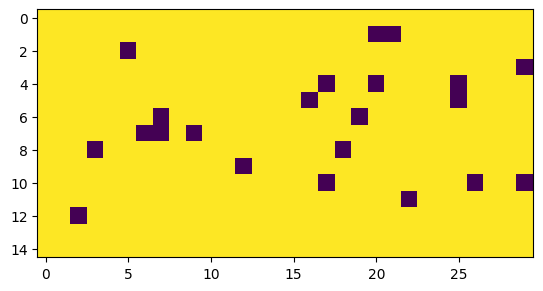

Step 382
(0, 0)
Step 383
(0, 25)
Step 384
(3, 29)
Step 385
(5, 0)
Step 386
(7, 0)
Step 387
(8, 0)
Step 388
(7, 0)
Step 389
(8, 0)
Step 390
(14, 29)
Step 391
(1, 0)
current Design


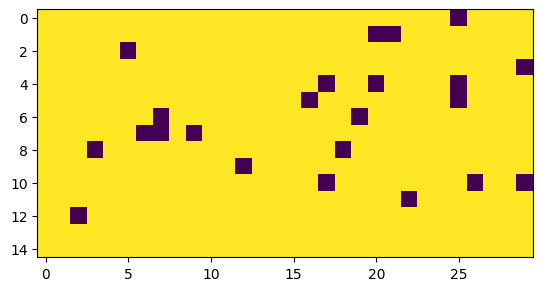

Step 392
(5, 9)
Step 393
(4, 0)
Step 394
(9, 0)
Step 395
(4, 16)
Step 396
(9, 0)
Step 397
(5, 0)
Step 398
(1, 0)
Step 399
(10, 11)
Step 400
(8, 0)
Step 401
(9, 0)
current Design


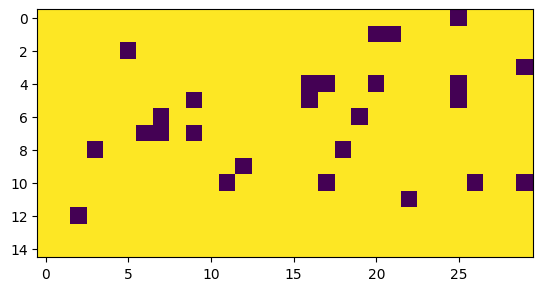

Step 402
(9, 0)
Step 403
(7, 0)
Step 404
(6, 0)
Step 405
(1, 0)
Step 406
(7, 0)
Step 407
(9, 0)
Step 408
(12, 0)
Step 409
(6, 0)
Step 410
(1, 0)
Step 411
(13, 0)
current Design


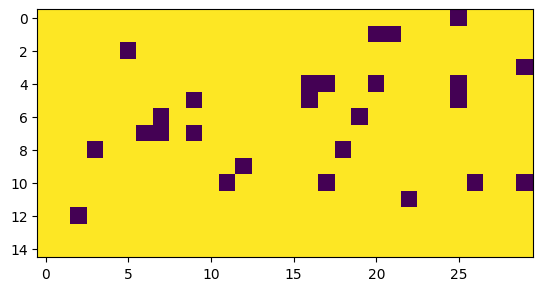

Step 412
(6, 0)
Step 413
(6, 0)
Step 414
(0, 0)
Step 415
(11, 0)
Step 416
(12, 0)
Step 417
(10, 0)
Step 418
(12, 0)
Step 419
(10, 0)
Step 420
(7, 0)
Step 421
(9, 0)
current Design


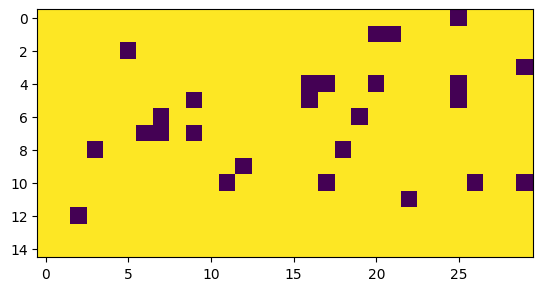

Step 422
(7, 0)
Step 423
(1, 0)
Step 424
(11, 0)
Step 425
(14, 29)
Step 426
(7, 0)
Step 427
(2, 0)
Step 428
(10, 0)
Step 429
(3, 0)
Step 430
(1, 0)
Step 431
(7, 15)
current Design


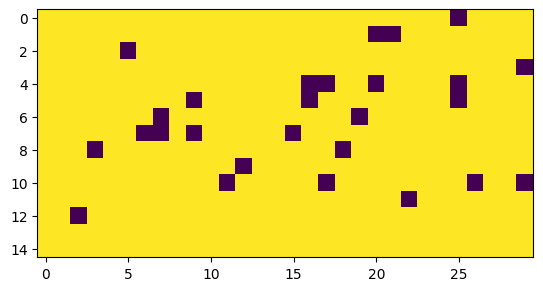

Step 432
(7, 0)
Step 433
(14, 0)
Step 434
(7, 0)
Step 435
(12, 0)
Step 436
(1, 0)
Step 437
(11, 0)
Step 438
(2, 0)
Step 439
(4, 0)
Step 440
(13, 0)
Step 441
(9, 0)
current Design


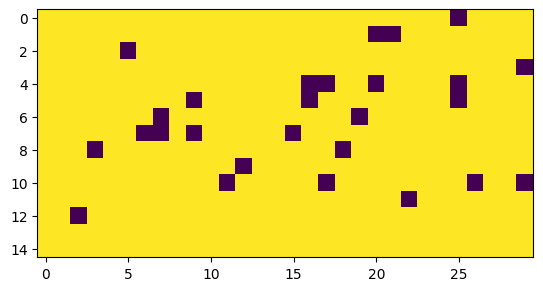

Step 442
(8, 0)
Step 443
(9, 0)
Step 444
(4, 0)
Step 445
(6, 0)
Step 446
(9, 15)
Step 447
(9, 0)
Step 448
(5, 0)
Step 449
(2, 0)
Step 450
(7, 0)
Step 451
(1, 0)
current Design


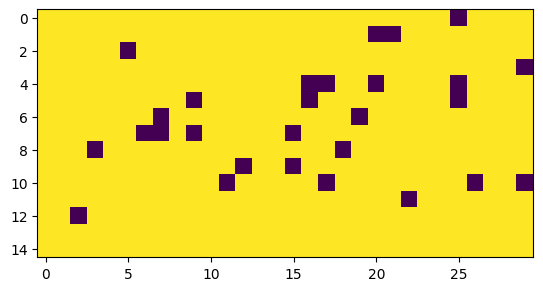

Step 452
(0, 0)
Step 453
(12, 0)
Step 454
(12, 0)
Step 455
(12, 0)
Step 456
(2, 0)
Step 457
(0, 0)
Step 458
(9, 0)
Step 459
(9, 0)
Step 460
(5, 0)
Step 461
(9, 0)
current Design


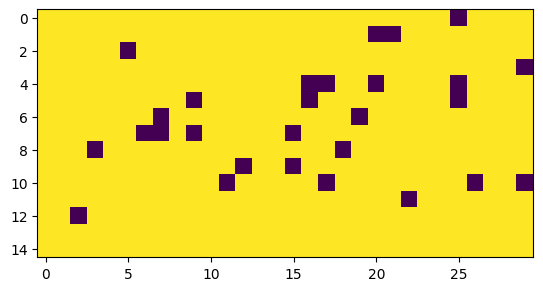

Step 462
(3, 0)
Step 463
(9, 0)
Step 464
(11, 0)
Step 465
(1, 0)
Step 466
(2, 0)
Step 467
(14, 29)
Step 468
(11, 0)
Step 469
(9, 0)
Step 470
(7, 0)
Step 471
(8, 10)
current Design


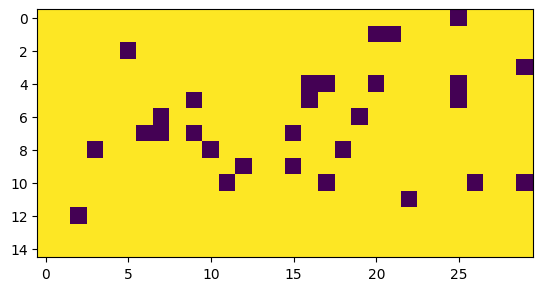

Step 472
(7, 0)
Step 473
(13, 0)
Step 474
(2, 0)
Step 475
(7, 0)
Step 476
(9, 0)
Step 477
(7, 0)
Step 478
(5, 0)
Step 479
(13, 0)
Step 480
(6, 0)
Step 481
(11, 11)
current Design


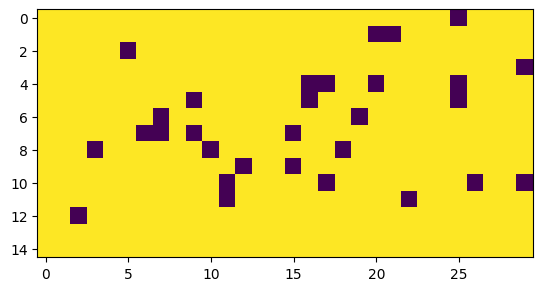

Step 482
(9, 0)
Step 483
(9, 0)
Step 484
(14, 19)
Step 485
(9, 0)
Step 486
(13, 0)
Step 487
(9, 0)
Step 488
(2, 0)
Step 489
(14, 29)
Step 490
(6, 0)
Step 491
(2, 0)
current Design


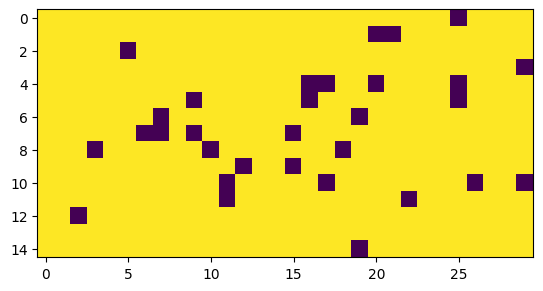

Step 492
(11, 16)
Step 493
(9, 0)
Step 494
(9, 0)
Step 495
(7, 0)
Step 496
(5, 0)
Step 497
(13, 0)
Step 498
(13, 0)
Step 499
(9, 0)
Step 500
(6, 0)
Step 501
(1, 0)
current Design


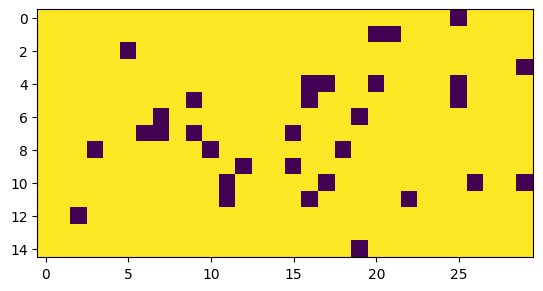

Step 502
(6, 0)
Step 503
(9, 23)
Step 504
(12, 0)
Step 505
(14, 29)
Step 506
(5, 0)
Step 507
(4, 0)
Step 508
(7, 0)
Step 509
(0, 8)
Step 510
(0, 0)
Step 511
(10, 6)
current Design


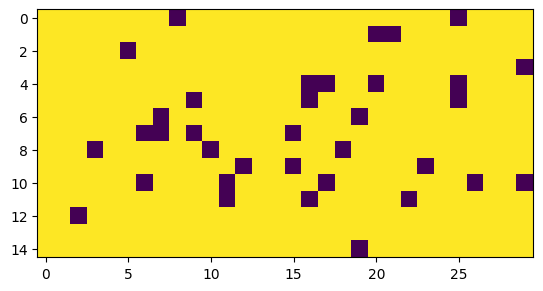

Step 512
(11, 0)
Step 513
(8, 0)
Step 514
(14, 4)
Step 515
(10, 12)
Step 516
(4, 0)
Step 517
(3, 0)
Step 518
(12, 0)
Step 519
(1, 0)
Step 520
(0, 0)
Step 521
(5, 0)
current Design


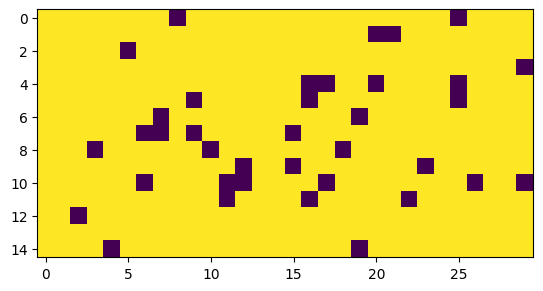

Step 522
(7, 24)
Step 523
(12, 0)
Step 524
(9, 0)
Step 525
(5, 0)
Step 526
(9, 0)
Step 527
(10, 0)
Step 528
(10, 0)
Step 529
(7, 0)
Step 530
(2, 20)
Step 531
(1, 0)
current Design


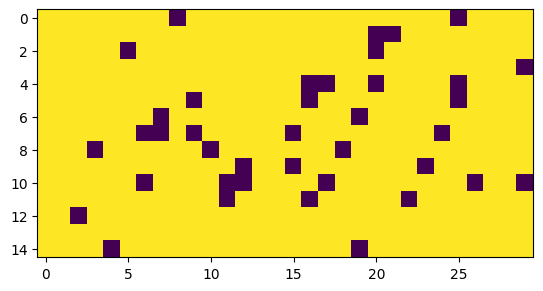

Step 532
(1, 0)
Step 533
(7, 0)
Step 534
(5, 0)
Step 535
(11, 0)
Step 536
(11, 0)
Step 537
(8, 0)
Step 538
(5, 0)
Step 539
(13, 0)
Step 540
(2, 0)
Step 541
(9, 0)
current Design


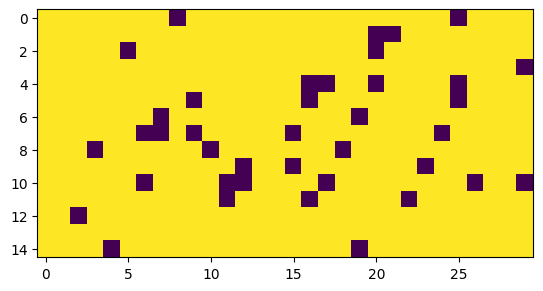

Step 542
(2, 0)
Step 543
(10, 0)
Step 544
(12, 0)
Step 545
(2, 0)
Step 546
(0, 0)
Step 547
(5, 19)
Step 548
(2, 0)
Step 549
(1, 0)
Step 550
(5, 0)
Step 551
(12, 0)
current Design


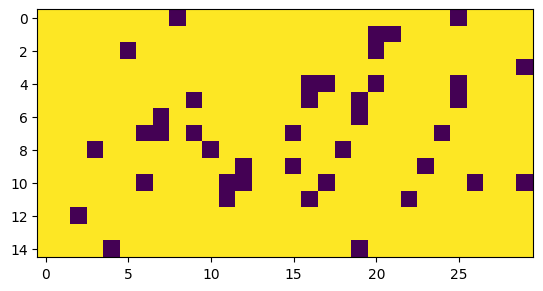

Step 552
(12, 0)
Step 553
(11, 0)
Step 554
(9, 0)
Step 555
(9, 0)
Step 556
(1, 0)
Step 557
(2, 0)
Step 558
(12, 0)
Step 559
(1, 0)
Step 560
(9, 0)
Step 561
(6, 0)
current Design


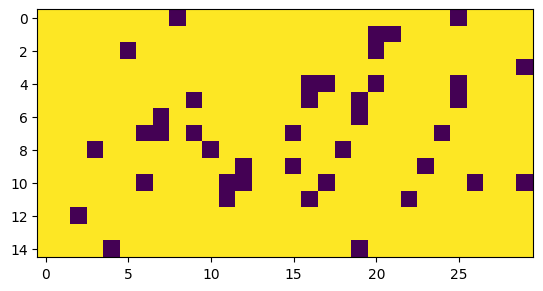

Step 562
(12, 0)
Step 563
(0, 0)
Step 564
(14, 0)
Step 565
(4, 0)
Step 566
(1, 4)
Step 567
(9, 0)
Step 568
(6, 0)
Step 569
(1, 0)
Step 570
(9, 0)
Step 571
(9, 0)
current Design


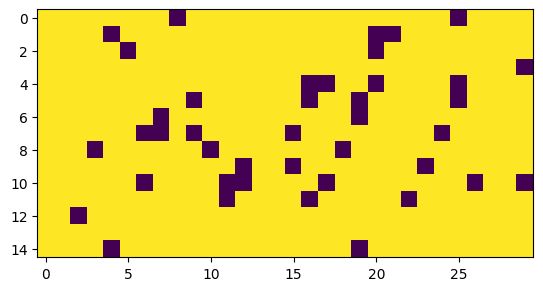

Step 572
(12, 0)
Step 573
(11, 0)
Step 574
(1, 0)
Step 575
(7, 0)
Step 576
(11, 13)
Step 577
(3, 0)
Step 578
(12, 0)
Step 579
(9, 8)
Step 580
(7, 0)
Step 581
(7, 0)
current Design


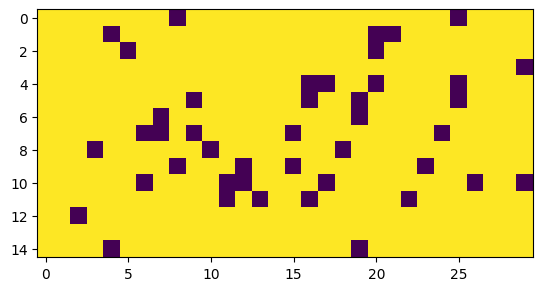

Step 582
(1, 0)
Step 583
(11, 15)
Step 584
(9, 0)
Step 585
(6, 0)
Step 586
(9, 0)
Step 587
(8, 0)
Step 588
(1, 0)
Step 589
(7, 0)
Step 590
(8, 0)
Step 591
(1, 0)
current Design


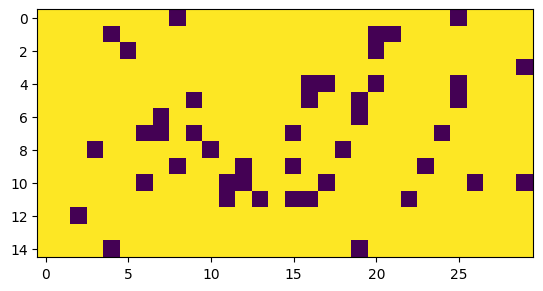

Step 592
(9, 0)
Step 593
(10, 0)
Step 594
(4, 15)
Step 595
(9, 0)
Step 596
(6, 0)
Step 597
(13, 0)
Step 598
(9, 0)
Step 599
(2, 0)
Step 600
(2, 0)
Step 601
(9, 0)
current Design


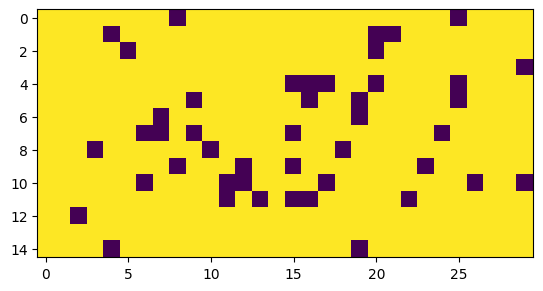

Step 602
(6, 0)
Step 603
(1, 0)
Step 604
(1, 0)
Step 605
(7, 0)
Step 606
(9, 0)
Step 607
(9, 0)
Step 608
(9, 0)
Step 609
(0, 0)
Step 610
(11, 0)
Step 611
(10, 0)
current Design


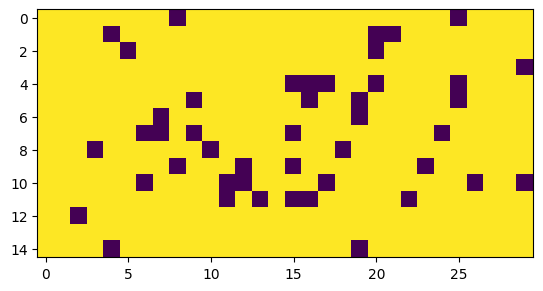

Step 612
(13, 2)
Step 613
(11, 0)
Step 614
(9, 0)
Step 615
(9, 0)
Step 616
(1, 0)
Step 617
(5, 0)
Step 618
(13, 0)
Step 619
(6, 0)
Step 620
(9, 0)
Step 621
(9, 0)
current Design


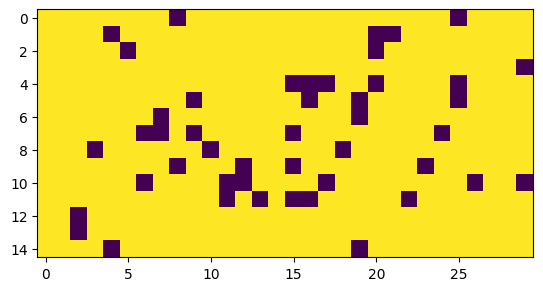

Step 622
(5, 0)
Step 623
(1, 0)
Step 624
(12, 0)
Step 625
(9, 0)
Step 626
(8, 0)
Step 627
(5, 0)
Step 628
(1, 0)
Step 629
(10, 0)
Step 630
(0, 0)
Step 631
(9, 0)
current Design


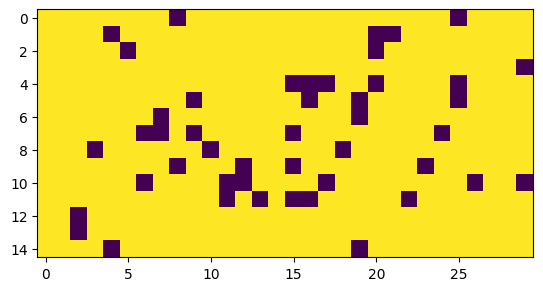

Step 632
(5, 0)
Step 633
(9, 0)
Step 634
(6, 8)
Step 635
(13, 21)
Step 636
(9, 0)
Step 637
(1, 0)
Step 638
(6, 0)
Step 639
(8, 0)
Step 640
(9, 12)
Step 641
(1, 0)
current Design


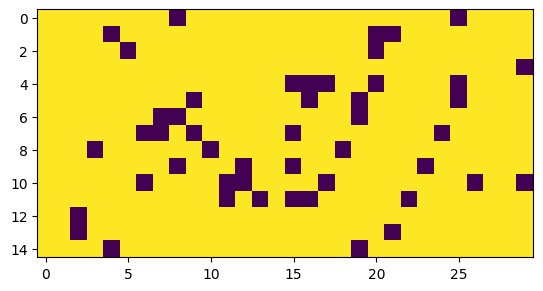

Step 642
(14, 29)
Step 643
(12, 0)
Step 644
(5, 0)
Step 645
(4, 0)
Step 646
(14, 0)
Step 647
(8, 0)
Step 648
(1, 0)
Step 649
(8, 0)
Step 650
(1, 0)
Step 651
(13, 0)
current Design


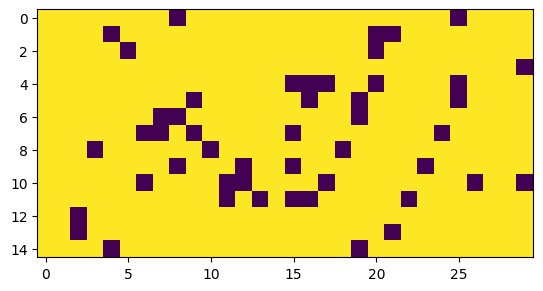

Step 652
(12, 0)
Step 653
(12, 0)
Step 654
(5, 25)
Step 655
(12, 0)
Step 656
(12, 0)
Step 657
(2, 0)
Step 658
(12, 0)
Step 659
(9, 0)
Step 660
(6, 0)
Step 661
(5, 0)
current Design


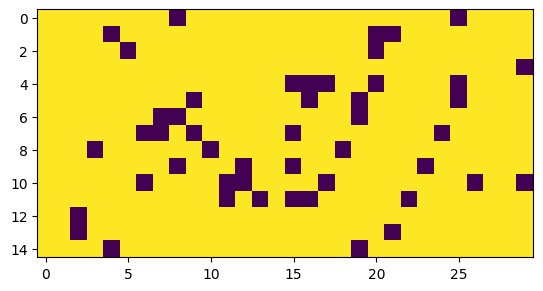

Step 662
(12, 0)
Step 663
(2, 0)
Step 664
(0, 0)
Step 665
(4, 0)
Step 666
(8, 0)
Step 667
(5, 0)
Step 668
(14, 10)
Step 669
(9, 0)
Step 670
(7, 0)
Step 671
(4, 0)
current Design


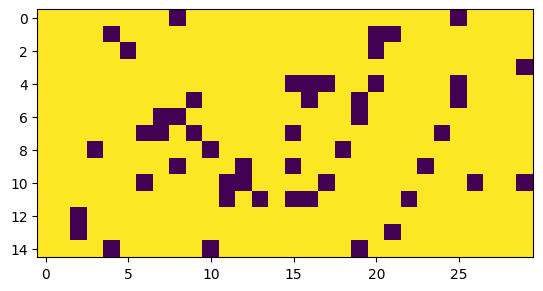

Step 672
(11, 0)
Step 673
(7, 0)
Step 674
(7, 0)
Step 675
(6, 13)
Step 676
(9, 0)
Step 677
(9, 0)
Step 678
(9, 0)
Step 679
(12, 3)
Step 680
(0, 0)
Step 681
(9, 0)
current Design


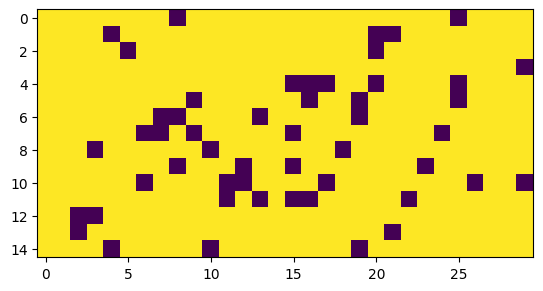

Step 682
(1, 21)
Step 683
(9, 0)
Step 684
(12, 0)
Step 685
(9, 0)
Step 686
(9, 0)
Step 687
(1, 29)
Step 688
(12, 0)
Step 689
(14, 0)
Step 690
(11, 0)
Step 691
(9, 0)
current Design


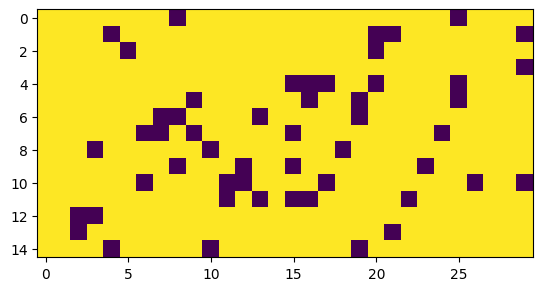

Step 692
(2, 0)
Step 693
(5, 0)
Step 694
(7, 0)
Step 695
(7, 0)
Step 696
(11, 0)
Step 697
(9, 0)
Step 698
(0, 0)
Step 699
(13, 28)
Step 700
(13, 6)
Step 701
(8, 0)
current Design


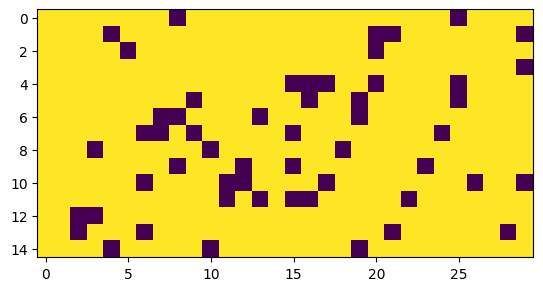

Step 702
(13, 0)
Step 703
(0, 0)
Step 704
(9, 0)
Step 705
(13, 0)
Step 706
(7, 0)
Step 707
(9, 0)
Step 708
(8, 0)
Step 709
(2, 20)
Step 710
(9, 0)
Step 711
(13, 0)
current Design


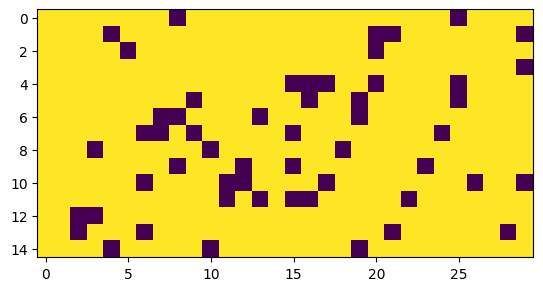

Step 712
(7, 29)
Step 713
(9, 0)
Step 714
(6, 0)
Step 715
(12, 0)
Step 716
(7, 0)
Step 717
(6, 0)
Step 718
(7, 14)
Step 719
(8, 15)
Step 720
(7, 0)
Step 721
(7, 0)
current Design


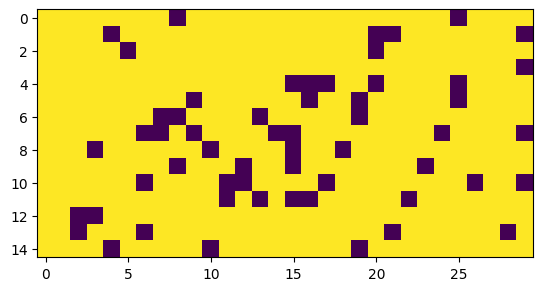

Step 722
(9, 0)
Step 723
(2, 0)
Step 724
(9, 0)
Step 725
(12, 0)
Step 726
(13, 0)
Step 727
(9, 0)
Step 728
(5, 0)
Step 729
(1, 0)
Step 730
(8, 0)
Step 731
(7, 0)
current Design


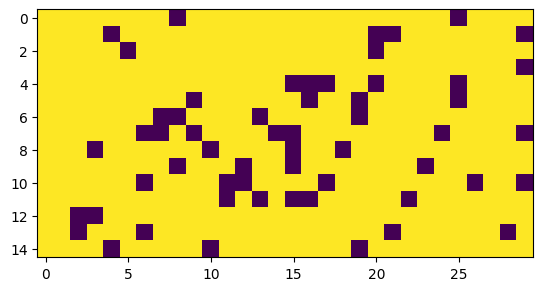

Step 732
(9, 0)
Step 733
(4, 0)
Step 734
(5, 0)
Step 735
(6, 0)
Step 736
(11, 0)
Step 737
(0, 0)
Step 738
(13, 0)
Step 739
(6, 0)
Step 740
(6, 0)
Step 741
(9, 0)
current Design


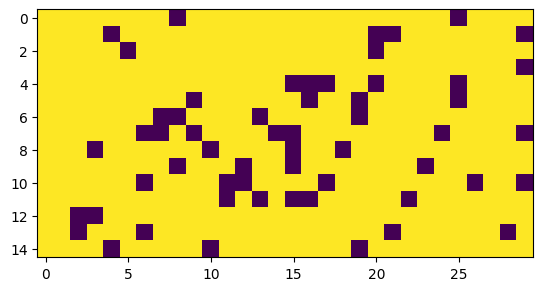

Step 742
(11, 0)
Step 743
(7, 0)
Step 744
(9, 0)
Step 745
(12, 0)
Step 746
(5, 0)
Step 747
(1, 0)
Step 748
(9, 0)
Step 749
(6, 0)
Step 750
(7, 0)
Step 751
(1, 0)
current Design


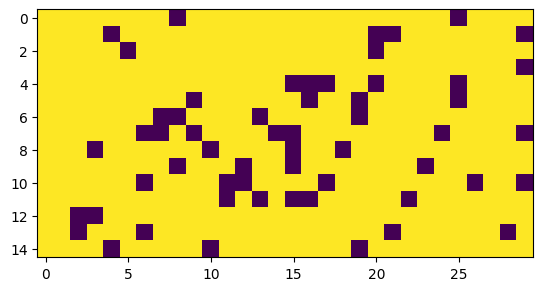

Step 752
(9, 0)
Step 753
(0, 0)
Step 754
(5, 0)
Step 755
(13, 0)
Step 756
(9, 0)
Step 757
(7, 0)
Step 758
(5, 0)
Step 759
(9, 0)
Step 760
(9, 0)
Step 761
(13, 22)
current Design


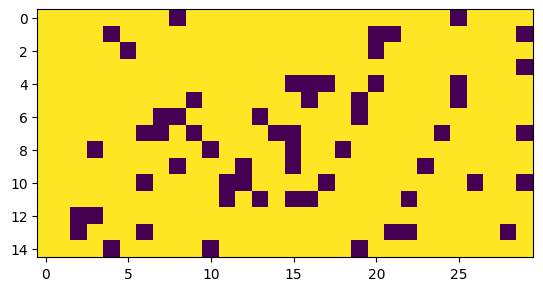

Step 762
(2, 0)
Step 763
(5, 20)
Step 764
(0, 0)
Step 765
(6, 0)
Step 766
(9, 0)
Step 767
(5, 0)
Step 768
(6, 0)
Step 769
(3, 1)
Step 770
(0, 0)
Step 771
(3, 0)
current Design


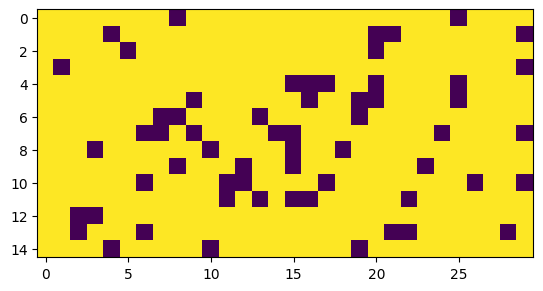

Step 772
(0, 0)
Step 773
(13, 0)
Step 774
(2, 10)
Step 775
(14, 29)
Step 776
(0, 0)
Step 777
(6, 2)
Step 778
(12, 0)
Step 779
(9, 0)
Step 780
(9, 0)
Step 781
(6, 0)
current Design


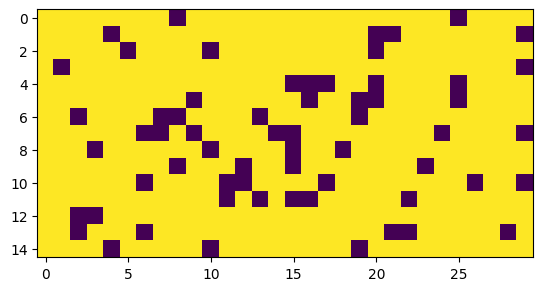

Step 782
(6, 0)
Step 783
(6, 0)
Step 784
(2, 0)
Step 785
(9, 0)
Step 786
(6, 0)
Step 787
(6, 0)
Step 788
(4, 0)
Step 789
(9, 0)
Step 790
(1, 0)
Step 791
(6, 0)
current Design


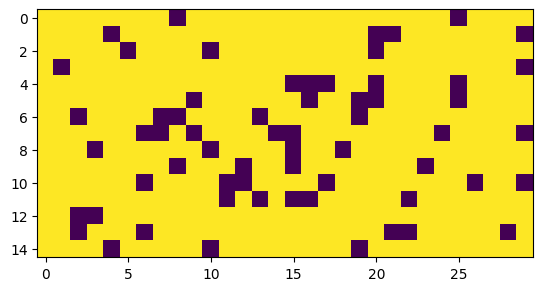

Step 792
(9, 14)
Step 793
(9, 0)
Step 794
(6, 0)
Step 795
(4, 23)
Step 796
(0, 0)
Step 797
(9, 0)
Step 798
(3, 0)
Step 799
(9, 0)
Step 800
(9, 0)
Step 801
(4, 0)
current Design


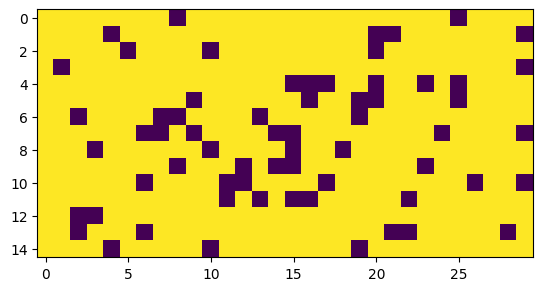

Step 802
(9, 0)
Step 803
(9, 0)
Step 804
(13, 0)
Step 805
(5, 5)
Step 806
(6, 0)
Step 807
(3, 0)
Step 808
(6, 0)
Step 809
(8, 0)
Step 810
(5, 0)
Step 811
(1, 0)
current Design


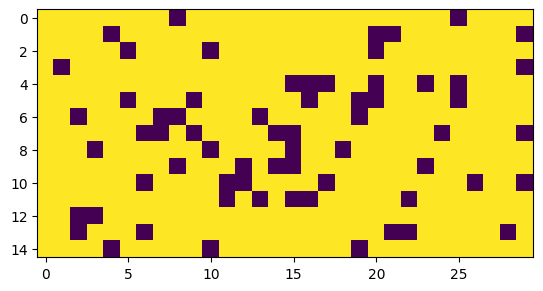

Step 812
(9, 0)
Step 813
(4, 0)
Step 814
(1, 0)
Step 815
(1, 0)
Step 816
(12, 0)
Step 817
(9, 0)
Step 818
(5, 0)
Step 819
(5, 0)
Step 820
(9, 0)
Step 821
(9, 0)
current Design


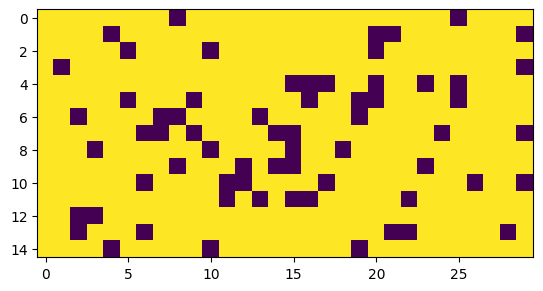

Step 822
(14, 0)
Step 823
(11, 0)
Step 824
(1, 0)
Step 825
(11, 0)
Step 826
(6, 0)
Step 827
(9, 0)
Step 828
(7, 0)
Step 829
(7, 0)
Step 830
(10, 0)
Step 831
(8, 0)
current Design


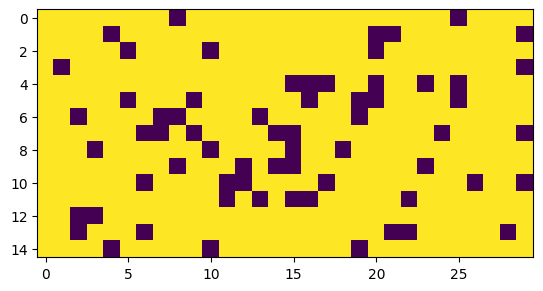

Step 832
(6, 0)
Step 833
(5, 0)
Step 834
(12, 0)
Step 835
(0, 0)
Step 836
(9, 0)
Step 837
(13, 0)
Step 838
(13, 0)
Step 839
(12, 0)
Step 840
(14, 0)
Step 841
(11, 0)
current Design


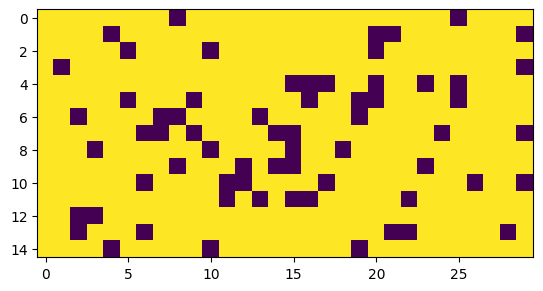

Step 842
(12, 0)
Step 843
(1, 0)
Step 844
(13, 0)
Step 845
(12, 0)
Step 846
(9, 0)
Step 847
(6, 0)
Step 848
(12, 0)
Step 849
(7, 0)
Step 850
(8, 0)
Step 851
(0, 23)
current Design


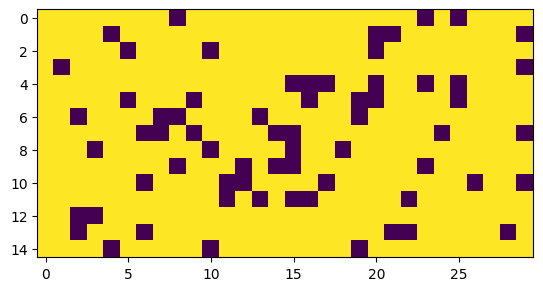

Step 852
(8, 0)
Step 853
(13, 0)
Step 854
(1, 0)
Step 855
(7, 0)
Step 856
(8, 29)
Step 857
(6, 0)
Step 858
(5, 0)
Step 859
(9, 0)
Step 860
(14, 0)
Step 861
(3, 22)
current Design


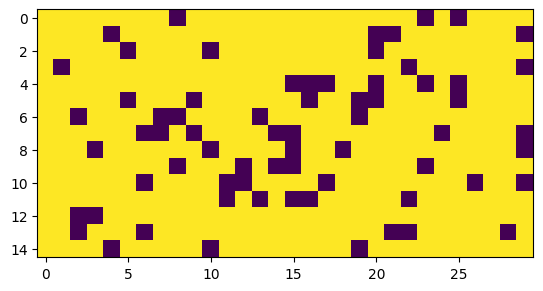

Step 862
(13, 0)
Step 863
(13, 0)
Step 864
(9, 0)
Step 865
(5, 0)
Step 866
(6, 0)
Step 867
(3, 0)
Step 868
(13, 0)
Step 869
(2, 0)
Step 870
(10, 0)
Step 871
(5, 0)
current Design


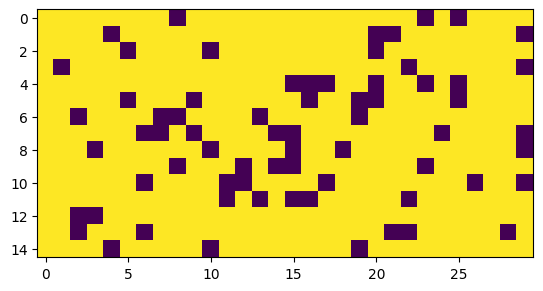

Step 872
(7, 0)
Step 873
(3, 0)
Step 874
(0, 0)
Step 875
(5, 0)
Step 876
(13, 12)
Step 877
(9, 0)
Step 878
(10, 0)
Step 879
(8, 0)
Step 880
(9, 0)
Step 881
(5, 0)
current Design


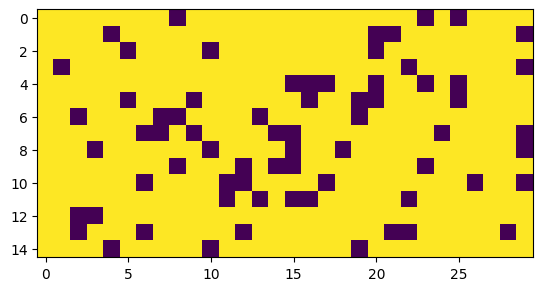

Step 882
(14, 29)
Step 883
(5, 0)
Step 884
(7, 24)
Step 885
(6, 0)
Step 886
(2, 0)
Step 887
(1, 0)
Step 888
(13, 0)
Step 889
(1, 0)
Step 890
(12, 26)
Step 891
(9, 0)
current Design


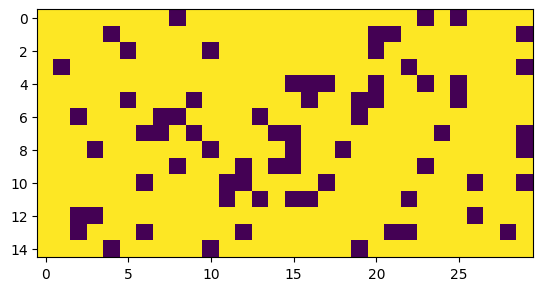

Step 892
(7, 6)
Step 893
(6, 0)
Step 894
(11, 0)
Step 895
(6, 0)
Step 896
(1, 0)
Step 897
(8, 25)
Step 898
(12, 0)
Step 899
(9, 0)
Step 900
(13, 0)
Step 901
(2, 0)
current Design


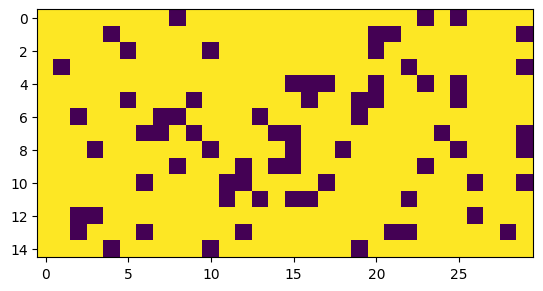

Step 902
(9, 0)
Step 903
(2, 0)
Step 904
(11, 0)
Step 905
(8, 0)
Step 906
(7, 0)
Step 907
(1, 0)
Step 908
(9, 0)
Step 909
(8, 0)
Step 910
(9, 0)
Step 911
(13, 0)
current Design


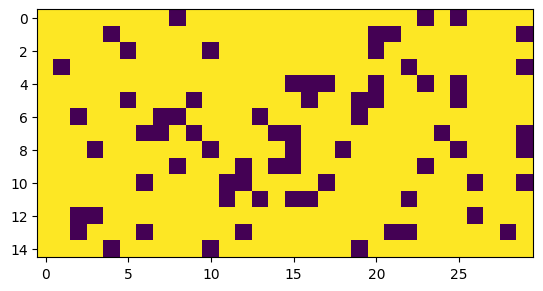

Step 912
(9, 0)
Step 913
(0, 0)
Step 914
(12, 0)
Step 915
(2, 0)
Step 916
(9, 0)
Step 917
(9, 0)
Step 918
(7, 0)
Step 919
(2, 0)
Step 920
(12, 0)
Step 921
(9, 0)
current Design


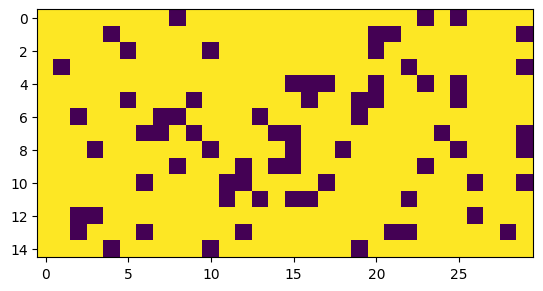

Step 922
(9, 0)
Step 923
(5, 0)
Step 924
(7, 0)
Step 925
(13, 0)
Step 926
(13, 0)
Step 927
(3, 28)
Step 928
(9, 0)
Step 929
(9, 0)
Step 930
(3, 0)
Step 931
(1, 0)
current Design


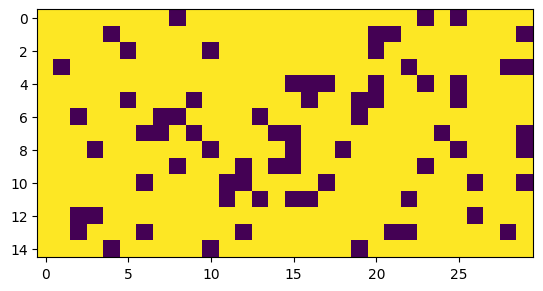

Step 932
(8, 0)
Step 933
(9, 0)
Step 934
(3, 0)
Step 935
(7, 0)
Step 936
(9, 0)
Step 937
(9, 0)
Step 938
(9, 0)
Step 939
(7, 0)
Step 940
(3, 0)
Step 941
(14, 10)
current Design


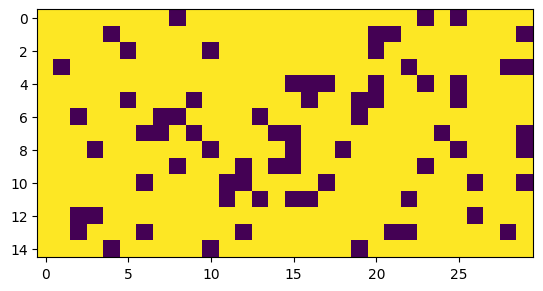

Step 942
(3, 0)
Step 943
(1, 0)
Step 944
(1, 0)
Step 945
(13, 0)
Step 946
(9, 0)
Step 947
(5, 0)
Step 948
(5, 0)
Step 949
(2, 0)
Step 950
(1, 0)
Step 951
(2, 12)
current Design


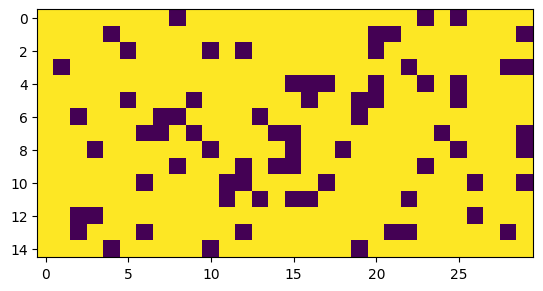

Step 952
(2, 0)
Step 953
(9, 0)
Step 954
(2, 0)
Step 955
(14, 0)
Step 956
(9, 0)
Step 957
(3, 0)
Step 958
(5, 0)
Step 959
(5, 10)
Step 960
(9, 0)
Step 961
(0, 0)
current Design


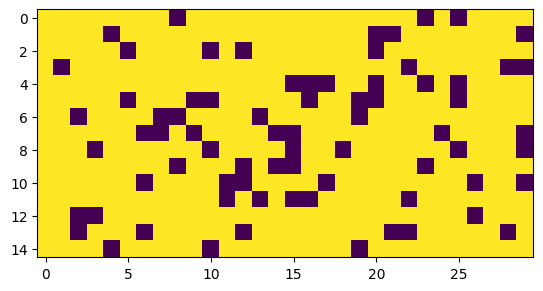

Step 962
(9, 0)
Step 963
(1, 0)
Step 964
(1, 0)
Step 965
(2, 0)
Step 966
(7, 0)
Step 967
(3, 0)
Step 968
(12, 0)
Step 969
(9, 0)
Step 970
(5, 0)
Step 971
(9, 0)
current Design


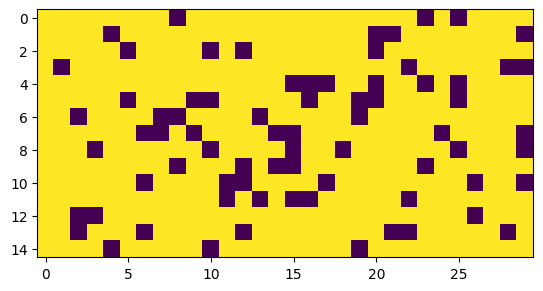

Step 972
(9, 0)
Step 973
(0, 0)
Step 974
(2, 0)
Step 975
(9, 0)
Step 976
(5, 0)
Step 977
(1, 0)
Step 978
(1, 0)
Step 979
(0, 0)
Step 980
(12, 0)
Step 981
(9, 0)
current Design


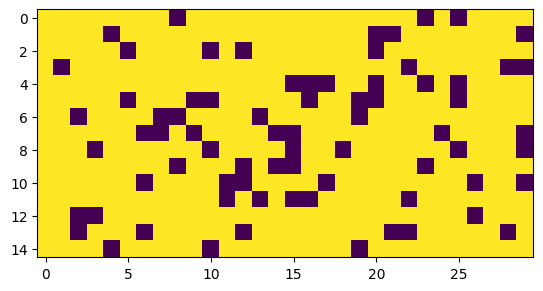

Step 982
(6, 0)
Step 983
(1, 0)
Step 984
(9, 0)
Step 985
(9, 0)
Step 986
(14, 5)
Step 987
(13, 6)
Step 988
(4, 0)
Step 989
(9, 0)
Step 990
(13, 0)
Step 991
(5, 0)
current Design


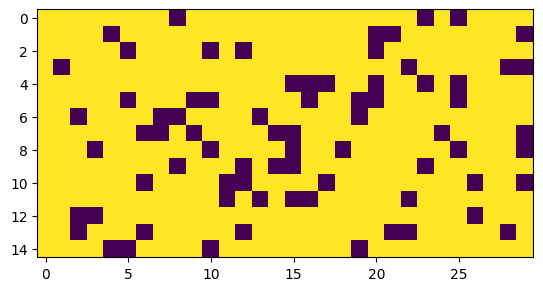

Step 992
(7, 0)
Step 993
(5, 0)
Step 994
(14, 29)
Step 995
(7, 0)
Step 996
(12, 0)
Step 997
(5, 0)
Step 998
(6, 0)
Step 999
(12, 0)
Step 1000
(8, 0)


In [15]:
#TODO Warum darf ich das Modell Nicht Laden :(


env.close()
env = TopOptEnv()
model_best = PPO.load("log/best_model",env=env)
obs, _ = env.reset()
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    action = action.item()
    print(f"Step {i + 1}")
    # print("Action: ", action)       # added Console Outputs for better understanding  
    obs, rewards, dones, _, info = env.step(action)
    if i%10 == 0:
        env.render()
    if dones:
        print("Goal reached!", "reward=", rewards)
        break
    i+=1



